In [11]:
spark.stop()

In [12]:
core = 8
nome = "marco"
#nicolò
#marco
#francesco
#raffaele

In [13]:
# Pulizia delle cache (rimuove se ci sono dataframe persistati)

#spark.catalog.clearCache()
import gc
gc.collect()

1225

In [14]:
# mapping utenti → (SparkUI, user)
mappa = {
    "nicolò":   (4040, "user_a", False),
    "marco":    (4041, "user_b", True),
    "francesco":(4042, "user_c", False),
    "raffaele": (4043, "user_d", False),
}
# recupero SparkUI e user dal mapping
SparkUI, user, docker = mappa[nome]
Npartition = 4*core # Regola generale: numero_partizioni = numero_core * (2 o 4)

print(f"Hai settato {SparkUI} e {user}: tu sei {nome}")
if docker:
    print(f"STAI USANDO DOCKER")
else:
    print(f"STAI USANDO CLOUDVENETO")

Hai settato 4041 e user_b: tu sei marco
STAI USANDO DOCKER


sudo pkill -u $(whoami) -f "jupyter-notebook"

# Setting Spark Session

In [84]:
import os
import numpy as np
import pandas as pd
from math import ceil
import matplotlib.pyplot as plt
from functools import reduce
#from joblib import Parallel, delayed
from IPython.display import display, HTML
import seaborn as sns

from pyspark import SparkFiles
from pyspark.sql import SparkSession, DataFrame, Window
from pyspark.sql.types import StructType, StructField, IntegerType, DoubleType, TimestampType, BooleanType

from pyspark.sql.functions import (
    coalesce, corr, array, countDistinct, approx_count_distinct,
    col, lit, expr, when, count, count_if, row_number, sum as spark_sum, abs as spark_abs,
    round as spark_round, min as spark_min, max as spark_max, avg as spark_avg,
    first, last, lag, lead, row_number, desc, asc, bool_or, floor,
    explode, sequence, from_unixtime, to_date, unix_timestamp, array_repeat,
    window, min_by, mode, concat, monotonically_increasing_id, mean, rand
)

In [16]:
if docker:

    spark = SparkSession.builder \
        .master("spark://spark-master:7077") \
        .appName("ProjectDocker") \
        .config("spark.executor.memory", "1300m") \
        .config("spark.cores.max", "8") \
        .config("spark.default.parallelism", "16") \
        .config("spark.sql.shuffle.partitions", "16") \
        .config("spark.sql.adaptive.enabled", "true") \
        .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
        .config("spark.sql.execution.arrow.pyspark.fallback.enabled", "false") \
        .getOrCreate()

        # SE NON FUNZIONA TOGLI I DUE CONFIG DI ARROW

        # .config("spark.executor.memory", "1500m")
        # .config("spark.executor.cores", "1")\
        # .config("spark.executor.instances", "12")\
        # .config("spark.cores.max", "12")\
        # .config("spark.default.parallelism", "24")\
        # .config("spark.sql.adaptive.enabled", "true")\

else:

    os.environ["PYSPARK_PYTHON"] = "/opt/miniconda3/bin/python"
    os.environ["PYSPARK_DRIVER_PYTHON"] = "/opt/miniconda3/bin/python"
    
    configs = {
       "spark.scheduler.mode": "FAIR",                                  # Multi-user scheduler
       "spark.scheduler.pool": user,                                    # User pool
       "spark.scheduler.allocation.file": "file:///usr/local/spark/conf/fairscheduler.xml",  # Scheduler config file
       "spark.executor.memory": "2200m",                                # Executor RAM
       "spark.cores.max": core,                                         # Total cores
       "spark.sql.shuffle.partitions": Npartition,                      # Shuffle partitions
       "spark.sql.execution.arrow.pyspark.enabled": "true",             # Enable Arrow
       "spark.sql.execution.arrow.pyspark.fallback.enabled": "false",   # No Arrow fallback
       "spark.dynamicAllocation.enabled": "false",                      # No dynamic allocation
       "spark.shuffle.service.enabled": "false",                        # No shuffle service
       "spark.ui.port": SparkUI,                                        # Custom UI port
       "spark.sql.debug.maxToStringFields": 1000                        # Debug fields limit
    }
    
    spark_builder = SparkSession.builder \
       .appName("ProjectCloudVeneto") \
       .master("spark://10.67.22.135:7077")
    
    for key, value in configs.items():
       spark_builder = spark_builder.config(key, value)
    
    spark = spark_builder.getOrCreate()

sc = spark.sparkContext

In [17]:
sensors = ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S106', 'S107', 'S108', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S180', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW']
alarms = ['A5', 'A9', 'ComError']
engines = ["S117", "S118", "S169", "S170"]
print(f"There are {len(sensors)} sensors.\n")

There are 130 sensors.



In [18]:
def print_separator(hw): 
    return display(HTML(f"<div style='text-align:center; font-size:24px; font-weight:bold; margin:20px 0;'>--------------------------{hw}--------------------------</div>"))

# Upload and inspect dataset

In [9]:
%%time 

df = spark.read.option("header", True).option("inferSchema", True).csv("file:///mnt/shared/dataset.csv").repartition(4, col("hwid"))

# convert milliseconds into seconds
df = df.withColumn("when", spark_round(col("when") / 1000).cast(IntegerType()))

ERROR:root:KeyboardInterrupt while sending command.               (22 + 4) / 39]
Traceback (most recent call last):
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/spark/python/lib/py4j-0.10.9.7-src.zip/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/miniconda3/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt
[Stage 1:=================================>                       (23 + 5) / 39]

KeyboardInterrupt: 

In [ ]:
# inspect dataset
df.printSchema()

In [ ]:
# inspect dataset
df.show(3, truncate=False)

In [ ]:
# inspect hardwares of dataset
hwid_list = df.select("hwid").distinct()
hwid_list.show()

In [ ]:
list_hw = df.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw

In [ ]:
%%time

# Process all hardware in parallel with window functions
df_all_hw = (df.groupBy("hwid", "when")
                   .pivot("metric")
                   .agg(first("value"))
                   .withColumn("time", from_unixtime(col("when")))
                   .orderBy("hwid", "when"))

df_all_hw = df_all_hw.persist()
df_all_hw.count()

engines = ["S117", "S118", "S169", "S170"]
df_all_hw.select("when","time",*engines).orderBy(col("time").asc()).show(5)

In [ ]:
df_all_hw.printSchema()

In [ ]:
df_all_hw.select("S178").show(10)
                            

In [ ]:
%%time
#Reformat the data with the correct decimal

decimals = {'P5': 1, 'P6': 1, 'P7': 1, 'P8': 1, 'P9': 1, 'P10': 1, 'P16': 1, 'P17': 1, 'P18': 1, 'S3': 1, 'S6': 1, 'S19': 1, 'S37': 1, 'S39': 1, 'S40': 1, 'S41': 1,'S42': 1, 'S43': 1, 'S45': 1, 'S46': 1, 'S47': 1, 'S49': 1, 'S50': 1, 'S69': 1, 'S70': 1, 'S71': 1, 'S72': 1, 'S80': 1, 'S81': 1, 'S83': 1, 'S97': 1, 'S100': 1, 'S101': 1, 'S102': 1, 'S106': 1, 'S107': 1, 'S108': 1, 'S109': 1, 'S110': 1, 'S122': 2, 'S124': 1, 'S126': 1, 'S128': 1, 'S129': 1, 'S137': 1, 'S138': 1, 'S140': 1, 'S154': 1, 'S157': 1, 'S158': 1, 'S159': 1, 'S163': 1, 'S164': 1, 'S165': 1, 'S166': 1, 'S167': 1, 'S178': 2, 'S180': 1}

columns_to_transform = [(col(c) / (10**decimals[c])).alias(c) if c in decimals else col(c) for c in df_all_hw.columns]
df_all_hw = df_all_hw.select(*columns_to_transform)

In [ ]:
df_all_hw.select("S178").show(10)

# Timestamp analysis

In [ ]:
def compute_time_differences(df):
    w = Window.partitionBy("hwid").orderBy("when")
    df_with_diff = df.withColumn("prev_time", lag("when").over(w)) \
                   .withColumn("time_diff", col("when") - col("prev_time")) \
                   .filter(col("time_diff").isNotNull())
    
    df_freq = df_with_diff.groupBy("hwid", "time_diff").count()
    return df_freq.orderBy("hwid", "time_diff")

In [ ]:
def time_diff_summary(df_diff, list_hw, top_n=5):
    w_smallest = Window.partitionBy("hwid").orderBy("time_diff")
    w_largest = Window.partitionBy("hwid").orderBy(desc("time_diff"))
    
    smallest_diffs = df_diff.withColumn("rank", row_number().over(w_smallest)) \
                     .filter(col("rank") <= top_n) \
                     .drop("rank")
    
    largest_diffs = df_diff.withColumn("rank", row_number().over(w_largest)) \
                    .filter(col("rank") <= top_n) \
                    .drop("rank")
    
    for hw in list_hw:
        print(f"\n{hw} - {top_n} smallest time differences:")
        smallest_diffs.filter(col("hwid") == hw).orderBy("time_diff").show(top_n, truncate=False)
        
        print(f"\n{hw} - {top_n} largest time differences:")
        largest_diffs.filter(col("hwid") == hw).orderBy(desc("time_diff")).show(top_n, truncate=False)

In [ ]:
TimestampDiff.show(5)

In [ ]:
%%time

TimestampDiff = compute_time_differences(df_all_hw)
time_diff_summary(TimestampDiff,list_hw,top_n=5)

In [ ]:
def plot_diff_histogram(df, min_diff, max_diff, delta, ax=None):
    filtered_df = df[(df['time_diff'] >= min_diff) & (df['time_diff'] <= max_diff)]
    bins = int((max_diff - min_diff) / delta)
    title = f"Time Difference Events (range {min_diff} - {max_diff} [s])"
    
    if ax is None:
        plt.figure(figsize=(10, 6))
        plt.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                color="steelblue", edgecolor="black")
        plt.title(title)
        plt.xlabel("Time difference [s]")
        plt.ylabel("Counts")
        plt.show()
    else:
        ax.hist(filtered_df['time_diff'], bins=bins, weights=filtered_df['count'], 
                color="steelblue", edgecolor="black")
        ax.set_title(title)
        ax.set_xlabel("Time difference [s]")
        ax.set_ylabel("Counts")

In [ ]:
for hw in list_hw:
    print_separator("yolo")
    
    dfDiffpandas = TimestampDiff.where(col("hwid")==hw).toPandas()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
    
    plot_diff_histogram(dfDiffpandas, min_diff=0, max_diff=300, delta=5, ax=ax1)
    plot_diff_histogram(dfDiffpandas, min_diff=300, max_diff=5000, delta=50, ax=ax2)
    
    plt.tight_layout()
    plt.show()

# Data preparation

In [ ]:
#Create a grid of "interval" seconds in order to have homogeneous separation of data. 
def CreateGrid(df, interval):

    #time window interval column
    df_windowed = df.withColumn("time_window", window("time", f"{interval} seconds"))

    aggs = []
    sensors = [c for c in df.columns if c not in ("when", "time", "hwid")]
    for s in sensors:
        #handle different datatypes: mean continuous metric and take min/max of binary ones
        stats = df.selectExpr(f"min({s}) as min", f"max({s}) as max").first()
        is_binary = stats["min"] is not None and stats["max"] is not None    and    0 <= stats["min"] and stats["max"] <= 1
        
        # treat differently A5 and A9 sensors 
        if s in alarms or is_binary:
            agg_func = spark_max(col(s)).alias(s)
        else:
            agg_func = spark_round(spark_avg(col(s)), 2).alias(s)
        aggs.append(agg_func)

    #groupy by hardware and time_window (homogeneous resampling)
    result_df = (
        df_windowed
        .groupBy("hwid", "time_window")
        .agg(*aggs)
    )

    result_df = (
        result_df
        .withColumn("window_start", col("time_window.start"))
        .withColumn("window_end", col("time_window.end"))
        .withColumn("when", expr("unix_timestamp(window_start) + int((unix_timestamp(window_end) - unix_timestamp(window_start)) / 2)"))
        .drop("time_window")
        .orderBy("when")
    )

    return result_df.select(["hwid", "when","window_start","window_end"]+sensors)

In [ ]:
%%time

interval = 60 #seconds

df_grid = CreateGrid(df_all_hw, interval)
df_grid.select("when","window_start","window_end",*engines).show(3, truncate = False)

In [ ]:
print(f"Records (rows) are {df_grid.count()}.")

In [ ]:
#Create independent blocks in the dataset when the time difference between two record is grater than max_interval
def BuildBlocks(df, max_interval, sensors):    

    #Parallelized on the 4 hardware
    w_hw = Window.partitionBy("hwid").orderBy("when")
    #Compute previous and next timestamp
    df = (df
          .withColumn("Prev_TimeStamp", lag("when").over(w_hw))
          .withColumn("Next_TimeStamp", lead("when").over(w_hw))
          .withColumn("PrevDiff", col("when") - col("Prev_TimeStamp"))
          .withColumn("NextDiff", col("Next_TimeStamp") - col("when"))
         )

    #Check if the timediff between two consecutive data is more than max_interval
    df = df.withColumn("CheckNewBlock", when(col("PrevDiff") > max_interval, 1).otherwise(0))
    df = df.withColumn("BlockID", spark_sum("CheckNewBlock").over(w_hw))

    df = df.drop("CheckNewBlock")

    return df

In [ ]:
df_blocks = BuildBlocks(df_grid, max_interval = 1800, sensors = sensors)
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

In [ ]:
for hw in list_hw:
    print(f"{hw} has {df_blocks.where(col("hwid") == hw).select('BlockID').distinct().count()} Blocks.")

In [ ]:
#Fill most of all values inside the arbitraty time gap
def FillNull(df, sensors, max_gap=240):
    w = Window.partitionBy("hwid", "BlockID").orderBy("when")
    
    for s in sensors:
        prev_val = lag(col(s)).over(w)
        next_val = lead(col(s)).over(w)
        
        df = df.withColumn(s, when(col(s).isNotNull(), col(s))
            .when(
                (col("NextDiff") <= max_gap) & 
                (col("NextDiff") <= col("PrevDiff")), 
                next_val).when(col("PrevDiff") <= max_gap, prev_val))

    
    df = df.na.drop(subset=sensors)
    
    return df

In [ ]:
df_blocks = FillNull(df_blocks, sensors + engines, max_gap=240).persist()
df_blocks.select("hwid","BlockID","when","window_start","window_end",*engines,*alarms).show(3)

In [ ]:
#Saving the final DF:
save = False
if save:
    #Transoform each hwid into panda dataframe and then combine (no memory issue)
    all_chunks = []
    for hw in list_hw:
        hw
        chunk = df_blocks.filter(f"hwid = '{hw}'").toPandas()
        all_chunks.append(chunk)
        
    # Combine
    pandas_df = pd.concat(all_chunks, ignore_index=True)
    pandas_df.to_parquet("/mnt/shared/df_blocks.parquet", index=False)

[Stage 1:================================================>        (33 + 4) / 39]

# Import the file

In [12]:
if docker:
    df_blocks = spark.read.parquet("/mapd-workspace/df_block.parquet")

else:
    df_blocks = spark.read.parquet("/mnt/shared/df_blocks.parquet/")

df_blocks = df_blocks.withColumn("A5", col("A5").cast("int"))
df_blocks = df_blocks.withColumn("A9", col("A9").cast("int"))

In [13]:
%%time

df_max = df_blocks.select(*sensors).groupBy().agg( *[spark_max(s).alias(s) for s in sensors] )
max_values = df_max.first().asDict()

df_min = df_blocks.select(*sensors).groupBy().agg( *[spark_min(s).alias(s) for s in sensors] )
min_values = df_min.first().asDict()

useless_sensors = [k for k in sensors if max_values[k] == min_values[k]]
useful_sensors = [k for k in sensors if k not in useless_sensors]

25/08/24 10:11:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
[Stage 6:===================================================>       (7 + 1) / 8]

CPU times: user 403 ms, sys: 160 ms, total: 563 ms
Wall time: 28.2 s


In [18]:
print(f"There are {len(useless_sensors)} useless sensors (just one value), which are:\n")
print(useless_sensors)
print("\n")
print(f"There are {len(useful_sensors)} useful sensors (at least 2 distinct values), which are:\n")
print(useful_sensors)

There are 28 useless sensors (just one value), which are:

['S106', 'S108', 'S11', 'S110', 'S15', 'S16', 'S163', 'S165', 'S167', 'S17', 'S175', 'S176', 'S19', 'S34', 'S42', 'S43', 'S45', 'S49', 'S50', 'S54', 'S56', 'S57', 'S63', 'S69', 'SA12', 'SA4', 'SA8', 'SW']


There are 102 useful sensors (at least 2 distinct values), which are:

['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S100', 'S101', 'S102', 'S107', 'S109', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S151', 'S154', 'S157', 'S158', 'S159', 'S164', 'S166', 'S169', 'S170', 'S171', 'S172', 'S173', 'S174', 'S178', 'S179', 'S180', 'S181', 'S183', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S35', 'S37', 'S39', 'S40', 'S41', 'S46', 'S47', 'S5', 'S53', 'S55', 'S6', 'S64', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9'

In [14]:
df_blocks = df_blocks.drop(*useless_sensors)

In [15]:
list_hw = df_blocks.select("hwid").distinct().rdd.flatMap(lambda x : x).collect()
list_hw.sort()
list_hw

['SW-065', 'SW-088', 'SW-106', 'SW-115']

Longest blocks:

     BlockID  Block count
98        40         5112
99        12         6200
100       15        12731


Longest blocks:

     BlockID  minutes
98        40   5521.0
99        12   6549.0
100       15  13490.0


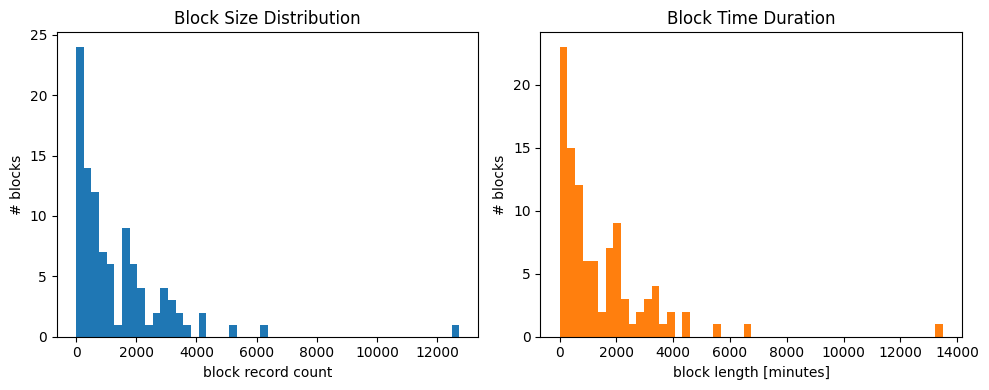

Longest blocks:

      BlockID  Block count
1038      460         2094
1039      483         2130
1040      164         2372


Longest blocks:

      BlockID  minutes
1038      460   2277.0
1039      483   2320.0
1040      164   2498.0


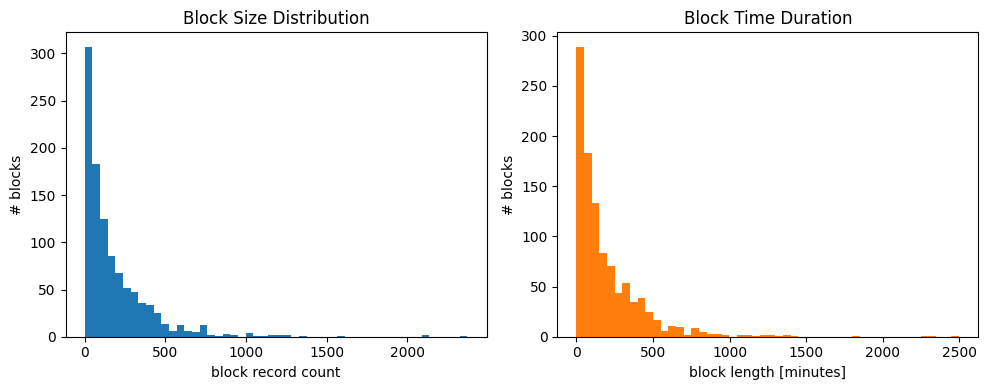

Longest blocks:

     BlockID  Block count
182      180         3508
183      175         3961
184      182         4658
Longest blocks:

     BlockID  minutes
182      180   3882.0
183      175   4446.0
184      182   5140.0


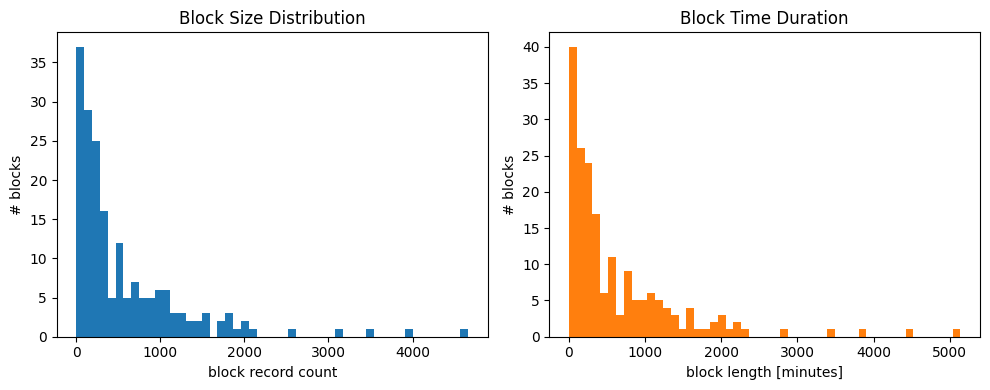

Longest blocks:

    BlockID  Block count
75       73         8623
76       23        10973
77        8        14199
Longest blocks:

    BlockID  minutes
75       73   9160.0
76       23  11790.0
77        8  15197.0


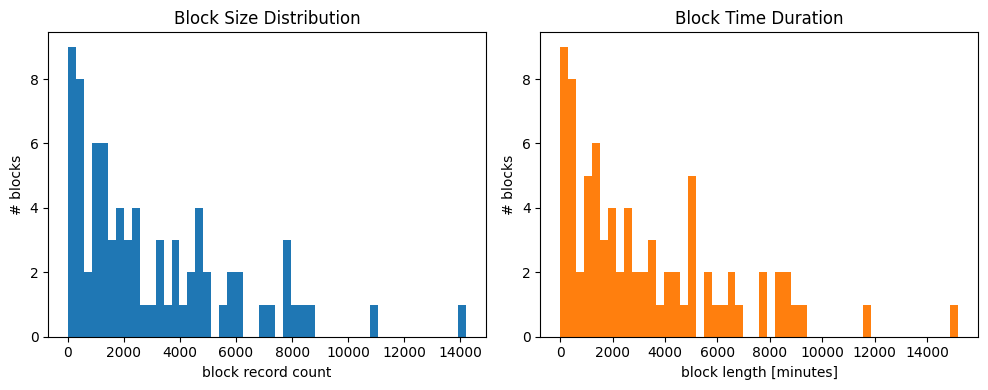

In [21]:
for hw in list_hw:

    print_separator(hw) #function to display a nice line separator with name
    dist_blocks = df_blocks.where(col("hwid")==hw).groupBy("BlockID").agg(count("*").alias("Block count")).orderBy("Block count")
    data = dist_blocks.toPandas()
    print("Longest blocks:\n")
    print( data.tail(3) )
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 4))
    axes[0].hist(data['Block count'], bins=50)
    axes[0].set_xlabel("block record count")
    axes[0].set_ylabel("# blocks")
    axes[0].set_title("Block Size Distribution")

    dist_blocks_min = (
        df_blocks.where(col("hwid") == hw)
        .groupBy("BlockID")
        .agg(((spark_max("when") - spark_min("when"))/60).alias("minutes"))
        .orderBy("minutes")
    )
    data = dist_blocks_min.toPandas()
    print("Longest blocks:\n")
    print(data.tail(3))

    axes[1].hist(data['minutes'], bins=50, color = "#ff7f0e")
    axes[1].set_xlabel("block length [minutes]")
    axes[1].set_ylabel("# blocks")
    axes[1].set_title("Block Time Duration")
    

    plt.tight_layout()
    plt.show()

# Anomaly detection (1)

## Distributed Analysis for Anomaly Detection

In [16]:
def detect_anomalies(df, time_separator, threshold, sensors):
    # Lag to get previous value within each partition (i.e. within each block)
    window         = Window.partitionBy("BlockID").orderBy("when")
    lagged_columns = [lag(col(s)).over(window) for s in sensors] 
    lag_names      = [f"lagged_{s}" for s in sensors]
    
    df_lagged = df.withColumns(dict(zip(lag_names, lagged_columns)))

    # Determina switch del sensore (didSwitch = 1 se il sensore passa da 0 a 1 o viceversa, didSwitch = 0 altrimenti)
    switch_w     = Window.partitionBy('BlockID').orderBy('when')
    didSwitch    = [when((col(f"lagged_{s}") != col(s)), 1).otherwise(0) for s in sensors] 
    switch_names = [f"didSwitch_{s}" for s in sensors]    

    df_didSwitch = df_lagged.withColumns(dict(zip(switch_names, didSwitch)))

    # Detect anomaly group: when two clusters are more distant than time_separator they are grouped as different anomalies
    # Tutte le anomalie di uno stesso gruppo hanno stesso id, cioè un numero crescente che si resetta ad ogni nuovo blocco
    df_anomalies = df_didSwitch
    for sensor in sensors:   
        # Il periodo anomalo inizia quando il sensore è 1 e finisce quando esso è 0
        df_start = (
            df_didSwitch \
            .withColumn(f'theres0Before_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(1, time_separator)) > 0) \
            .withColumn(f'theres0After_{sensor}', count_if(col(sensor) == 0).over(window.rangeBetween(-time_separator, -1)) > 0) \
            .filter( 
                (col(f'didSwitch_{sensor}') == 1) & 
                (when(col(sensor) == 1, col(f'theres0Before_{sensor}')).otherwise(True)) &
                (when(col(sensor) == 0, col(f'theres0After_{sensor}')).otherwise(True))
            ) \
            .withColumn(f'startGroup_{sensor}', when((col('when')-lag(col('when'), 1, -1e9).over(window))>time_separator, 1).otherwise(0)) \
            .withColumn(f'anomalyID_{sensor}', spark_sum(col(f'startGroup_{sensor}')).over(window)) \
        )
        
        df_anomalies = df_anomalies.join(
            other = df_start.select('BlockID', 'when', f'startGroup_{sensor}', f'anomalyID_{sensor}'),
            on = ['BlockID', 'when'],
            how = 'left'
        )

    count_names = [f'count_{s}' for s in sensors]
    count_cols  = [count('*').over(Window.partitionBy('BlockID', f'anomalyID_{s}')) for s in sensors]

    flag_names  = [f'flag_{s}' for s in sensors]
    flag_cols   = [when((col(f'count_{s}') >= threshold) & (col(f'anomalyID_{s}') > 0), True).otherwise(False) for s in sensors]
    
    df_flag = df_anomalies \
        .withColumns(dict(zip(count_names, count_cols))) \
        .withColumns(dict(zip(flag_names, flag_cols))) \
        .orderBy('BlockID', 'when')

    # Quando ci sono delle righe comprese tra anomalie con stesso ID, queste righe sono a loro volta considerate anomalie
    next_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(0, time_separator)
    prev_w  = Window.partitionBy('BlockID').orderBy('when').rangeBetween(-time_separator, 0)

    prev_names = [f'prevID_{s}' for s in sensors]
    prev_id = [when((bool_or(f'flag_{s}').over(prev_w)), spark_max(f'anomalyID_{s}').over(prev_w)).otherwise(None) for s in sensors]
    next_names = [f'nextID_{s}' for s in sensors]
    next_id = [when((bool_or(f'flag_{s}').over(next_w)), spark_min(f'anomalyID_{s}').over(next_w)).otherwise(None) for s in sensors]

    df_newID = (
        df_flag \
            .withColumns(dict(zip(prev_names, prev_id))) \
            .withColumns(dict(zip(next_names, next_id)))
    )

    new_flags = [when((col(f'nextID_{s}') == col(f'prevID_{s}')) & (col(f'nextID_{s}') > 0), True).otherwise(col(f'flag_{s}')) for s in sensors]
    
    df_flag = df_newID.withColumns(dict(zip(flag_names, new_flags)))
    
    condition = reduce(lambda a, b: a | b, [col(f'flag_{s}') for s in sensors])
    df_flag = df_flag.withColumn('flag_anomaly', when(condition, 1).otherwise(0))

    return df_flag \
        .select("BlockID", "when", *sensors, *flag_names, 'flag_anomaly') 

In [17]:
%%time

list_df_anomalies = {}
for hw in list_hw:
    df_anomalies = detect_anomalies(
        df = df_blocks.filter( col("hwid") == hw),
        time_separator = 60*40, # seconds
        threshold = 8,
        sensors = engines
    )

    list_df_anomalies[hw] = df_anomalies

list_df_anomalies

CPU times: user 543 ms, sys: 233 ms, total: 776 ms
Wall time: 12.2 s


{'SW-065': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-088': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-106': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int],
 'SW-115': DataFrame[BlockID: bigint, when: bigint, S117: int, S118: int, S169: int, S170: int, flag_S117: boolean, flag_S118: boolean, flag_S169: boolean, flag_S170: boolean, flag_anomaly: int]}

In [24]:
hw_to_inspect = 'SW-088'

In [25]:
%%time

list_df_anomalies[hw_to_inspect].filter('flag_S117').show(3, truncate=False)

+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|BlockID|when      |S117|S118|S169|S170|flag_S117|flag_S118|flag_S169|flag_S170|flag_anomaly|
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
|71     |1602481950|1   |0   |1   |1   |true     |false    |true     |false    |1           |
|71     |1602482010|1   |0   |0   |1   |true     |false    |true     |false    |1           |
|71     |1602482070|0   |0   |0   |1   |true     |false    |true     |false    |1           |
+-------+----------+----+----+----+----+---------+---------+---------+---------+------------+
only showing top 3 rows

CPU times: user 32.6 ms, sys: 5.81 ms, total: 38.4 ms
Wall time: 14 s


In [26]:
print("Know some BlockID where there are anomalies, so we can plot it and see.")

BlockWithAnom = list_df_anomalies[hw_to_inspect].filter('flag_S117').select('BlockID').distinct().orderBy('BlockID')
BlockWithAnom.show(3, truncate=False)

listBlockAnom = BlockWithAnom.collect()

Know some BlockID where there are anomalies, so we can plot it and see.


+-------+
|BlockID|
+-------+
|71     |
|90     |
|136    |
+-------+
only showing top 3 rows



In [18]:
def inspect_anomalies(df, sensor, blockID):
    def extract_column(df, column, default):
        return df.filter(col('BlockID') == blockID) \
            .select(when(col(column).isNull(), default).otherwise(col(column))) \
            .rdd.flatMap(lambda x: x).collect()
    def extract_when(df):
        return df.filter(col('BlockID') == blockID) \
            .select('when') \
            .rdd.flatMap(lambda x: x).collect()

    values    = extract_column(df, sensor, 0)
    anomalies = extract_column(df, f'flag_{sensor}', False)
    whens     = extract_when(df)

    fig, axes = plt.subplots(1, 2, figsize=(14,5))

    t_min, t_max = min(whens), max(whens)
    full_t = list(range(t_min, t_max + 60, 60))
    full_t_rel = [(t - t_min) // 60 for t in full_t]
    whens_rel  = [(w - t_min) // 60 for w in whens]
    values_map    = dict(zip(whens_rel, values))
    anomalies_map = dict(zip(whens_rel, anomalies))
    aligned_values    = [values_map.get(t, 0) for t in full_t_rel]
    aligned_anomalies = [anomalies_map.get(t, 0) for t in full_t_rel]
    missing = [0.5 if t not in whens_rel else 0 for t in full_t_rel]
    combined_anomalies = [max(a, m) for a, m in zip(aligned_anomalies, missing)]

    axes[0].bar(full_t_rel, aligned_values, width=1, alpha=0.7, color="blue", label=sensor)
    axes[0].bar(full_t_rel, missing, width=1, alpha=0.8, color="red", label="time hole")
    axes[0].bar(full_t_rel, combined_anomalies, width=1, alpha=0.5, color="orange", label="anomal")
    axes[0].set_xlabel("Minutes (relative to block start)")
    axes[0].set_ylabel(sensor)
    axes[0].legend(loc='lower right')
    axes[0].set_title(f"Block N.{blockID} (raw)")

    t = range(len(anomalies))
    axes[1].bar(t, values, width=1, alpha=0.5, lw=1)
    axes[1].bar(t, anomalies, width=1, alpha=0.5, label="anomal")
    axes[1].set_xlabel("Consecutive available data")
    axes[1].set_ylabel(sensor)
    axes[1].legend(loc='lower right')
    axes[1].set_title(f"Block N.{blockID} (aligned)")

    plt.tight_layout()
    plt.show()

25/08/24 08:34:50 ERROR TaskSchedulerImpl: Lost executor 2 on 10.67.22.135: Command exited with code 137


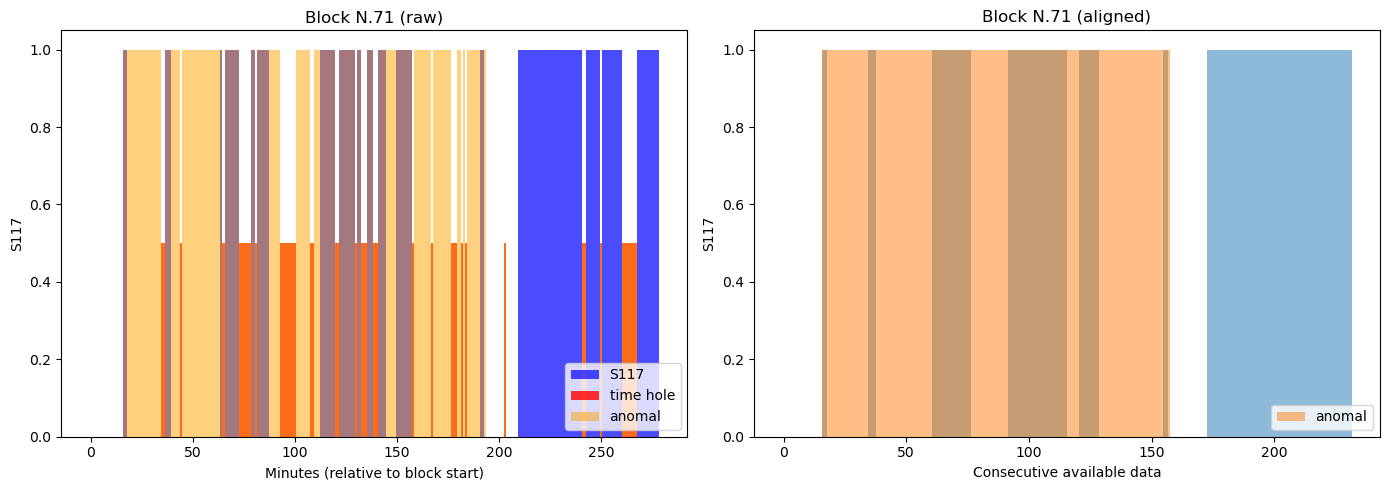

In [19]:
for row in listBlockAnom[:1]:
    inspect_anomalies(list_df_anomalies[hw_to_inspect], 'S117', row[0])

In [48]:
# Example block

# df_blocks.where( (col("BlockID")==71) & (col("hwid")==hw_to_inspect)) \
#     .select("window_start","window_end","NextDiff",'S117') \
#     .withColumn("NumeroRiga", monotonically_increasing_id()).show(250)

In [18]:
# Join on `when` and take just `flag_anomaly`

list_df_blocks_anom = {}

for hw in list_hw:
    df_anom = list_df_anomalies[hw].select('when', 'flag_anomaly')
    # df_anom = spark.createDataFrame(df_anom.rdd, df_anom.schema)  # Break lineage
    list_df_blocks_anom[hw] = df_blocks.filter( col("hwid") == hw ).join( df_anom, on='when', how='left' )
    #df_blocks_anom = df_blocks_anom.persist()

## Linear correlation setup (used for anomalies, S125-S181, A5-A9)

In [19]:
def correlations(df, sensors_list, target_col, batch_size=25): 
    all_correlations = []
    
    # Process sensors in batches to avoid broadcasting large tasks
    for i in range(0, len(sensors_list), batch_size):
        batch_sensors = sensors_list[i:i + batch_size]
        
        # Create correlation expressions for current batch
        corr_expressions = [corr(target_col, sensor).alias(f"corr_{sensor}") for sensor in batch_sensors]
        
        # Execute correlations for this batch
        batch_results = df.agg(*corr_expressions).collect()[0]
        
        # Extract correlation values (handle nulls as 0.0)
        batch_correlations = [batch_results[f"corr_{sensor}"] or 0.0 
                            for sensor in batch_sensors]
        all_correlations.extend(batch_correlations)
    
    # Create DataFrame with results
    results_df = pd.DataFrame({
        "Sensors": sensors_list, 
        "Correlations": all_correlations
    })
    
    # Sort by absolute correlation (highest first)
    sorted_results = results_df.reindex(
        results_df["Correlations"].abs().sort_values(ascending=False).index
    ).reset_index(drop=True)
    
    return sorted_results

In [20]:
def plot_correlations(df_spark, target_col, feature_cols, corr_df, hw):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        corr_val = corr_df[corr_df["Sensors"] == feature]["Correlations"].values
        corr_str = f"{corr_val[0]:.3f}" if len(corr_val) > 0 else "N/A"
        
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        ax1.scatter(pd_df[feature], pd_df[target_col], color="steelblue", alpha=0.005)
        ax1.set_ylabel(target_col)
        
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax2.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        ax2.set_ylabel("Density")
        ax2.legend()
        
        fig.suptitle(f"{hw} - {feature} - Correlation: {corr_str}")
        plt.tight_layout()
        plt.show()

## Correlation Analysis for Anomalies

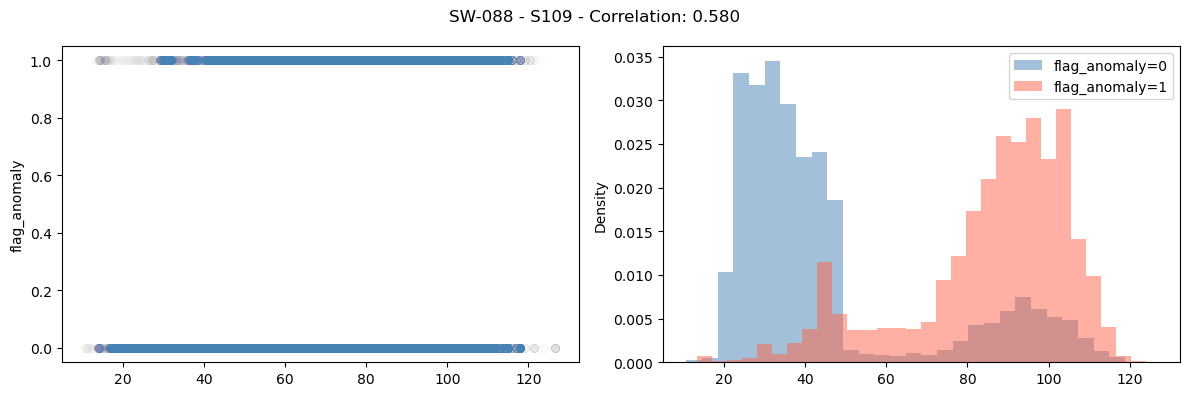

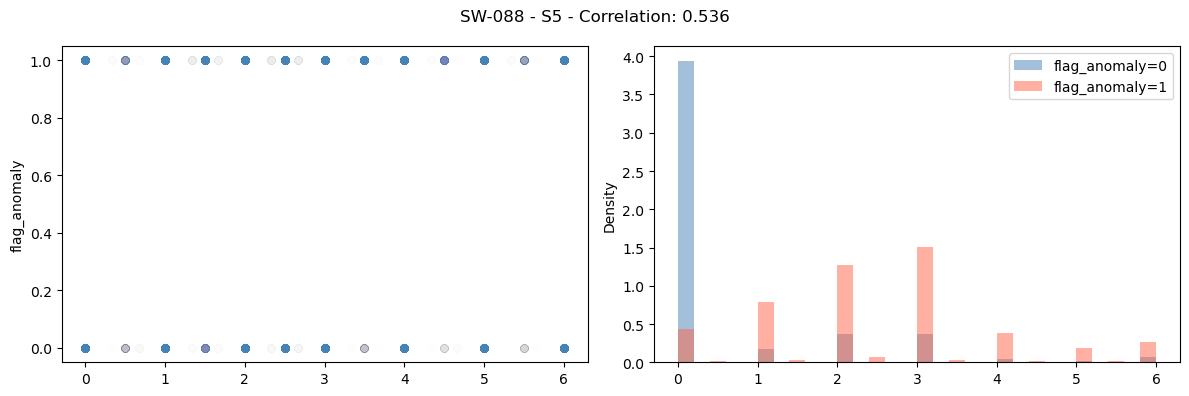

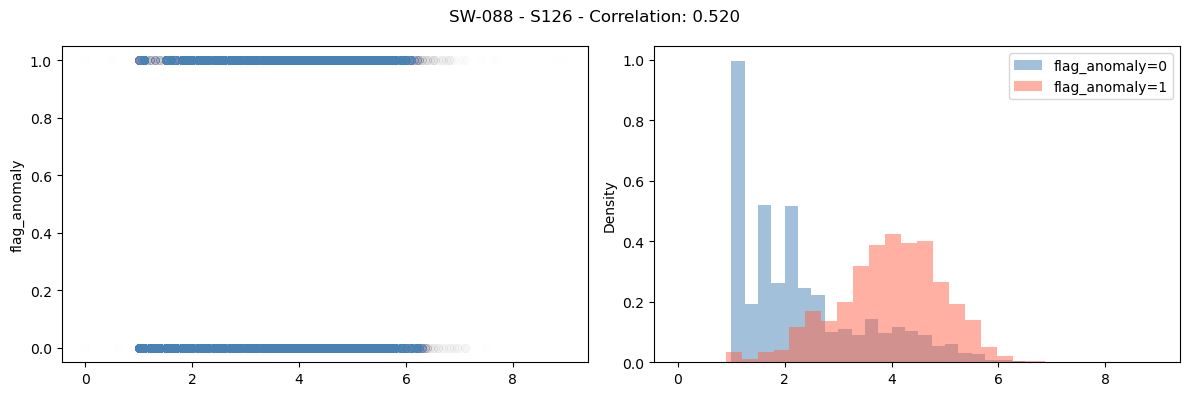

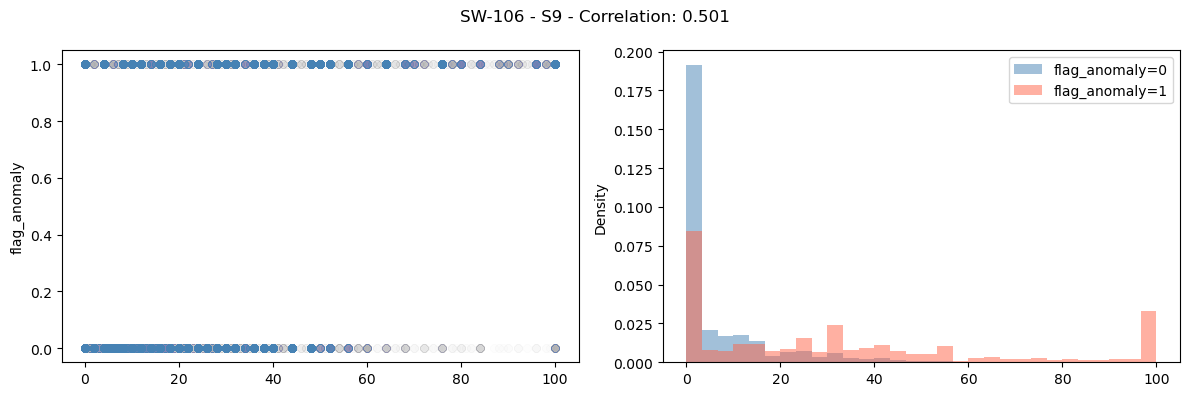

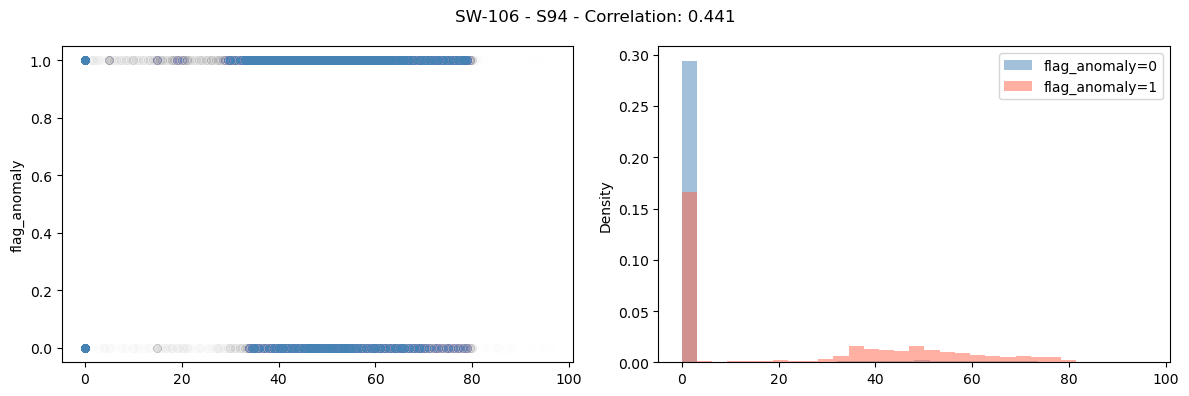

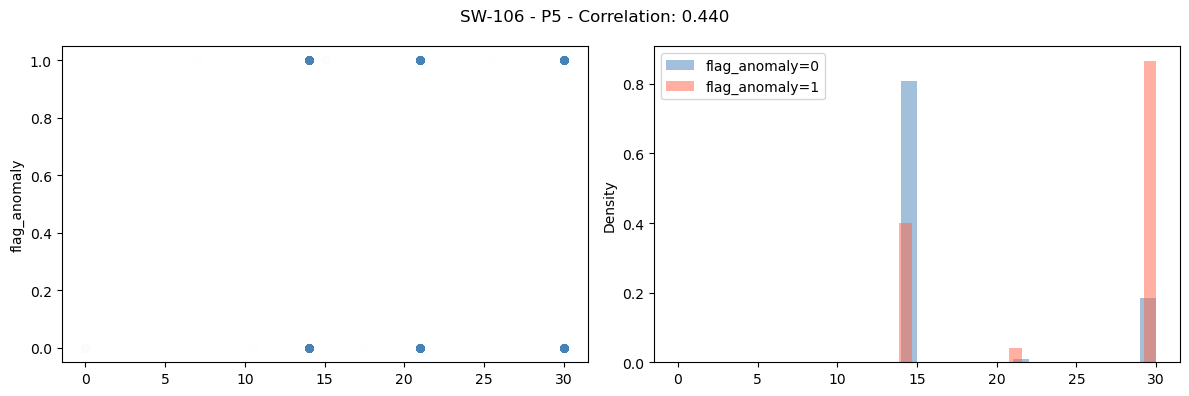

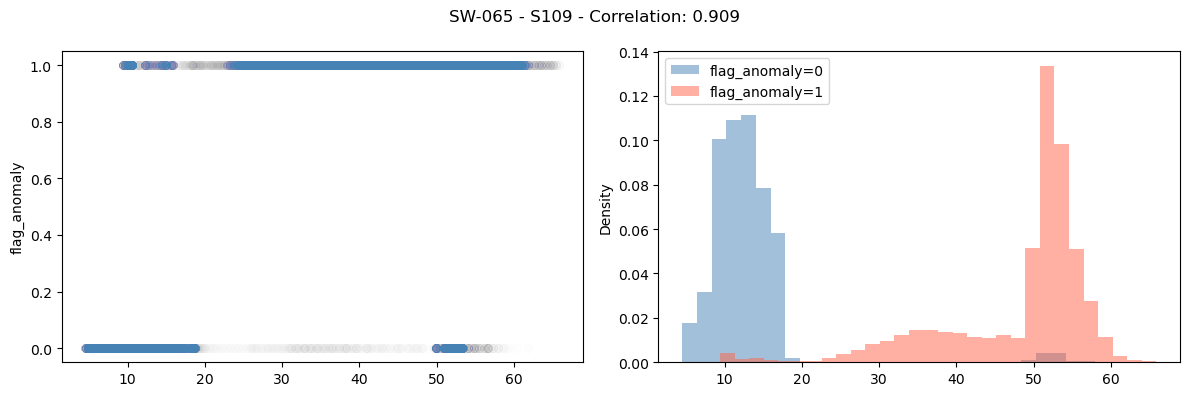

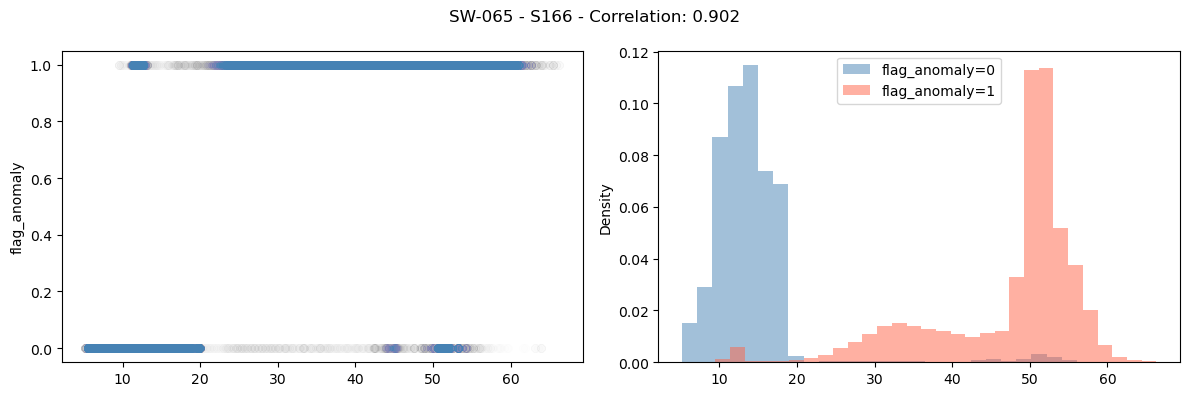

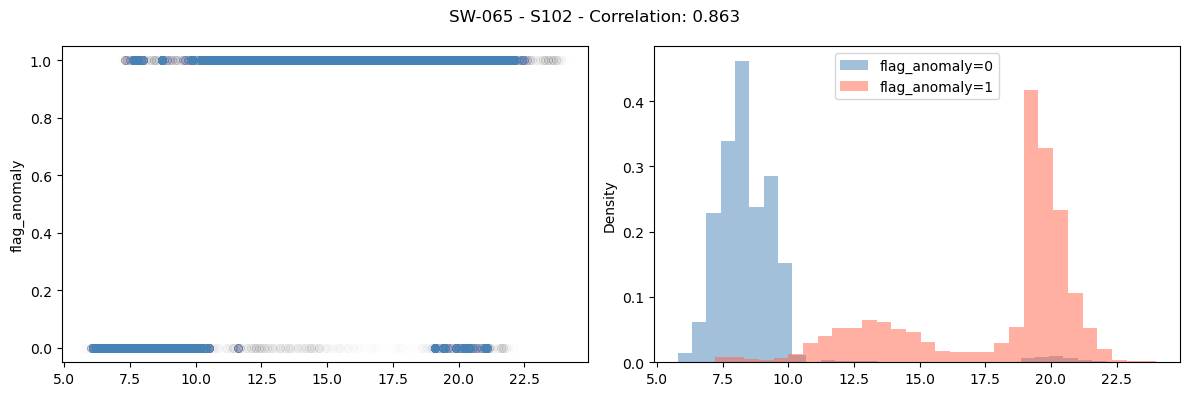

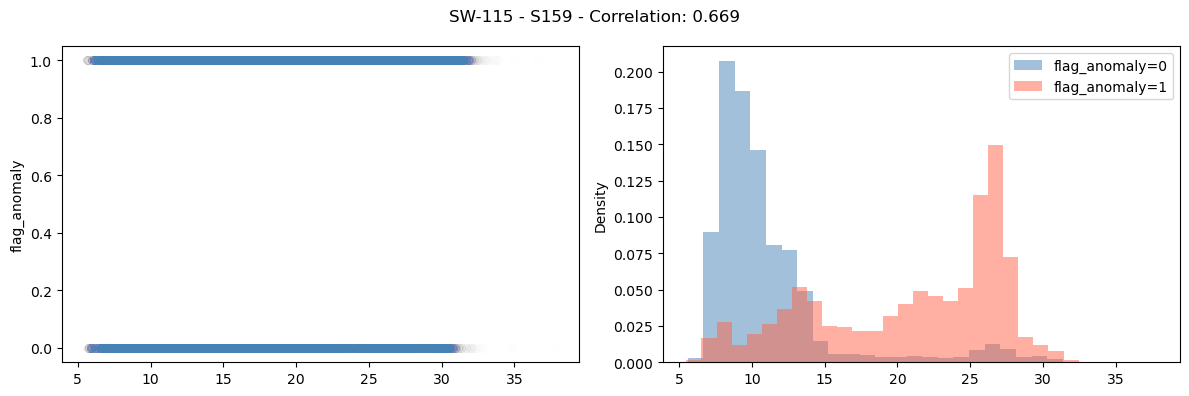

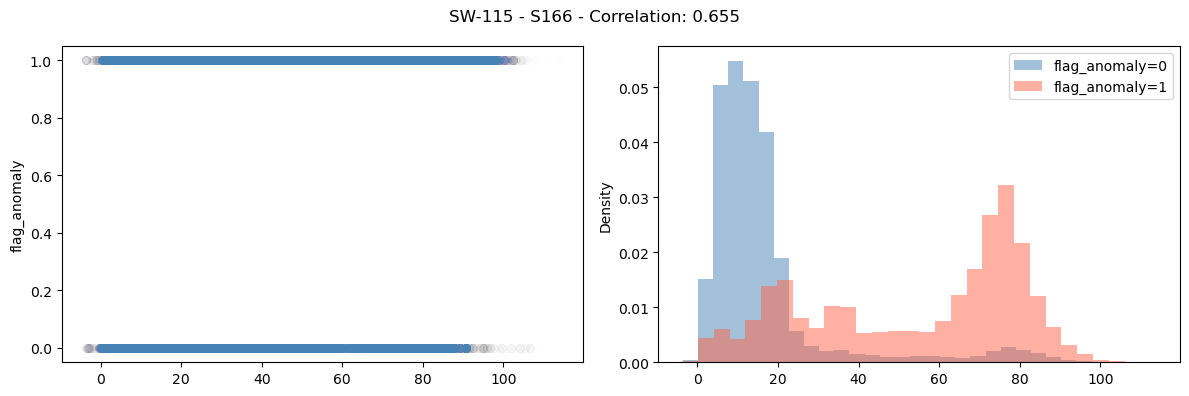

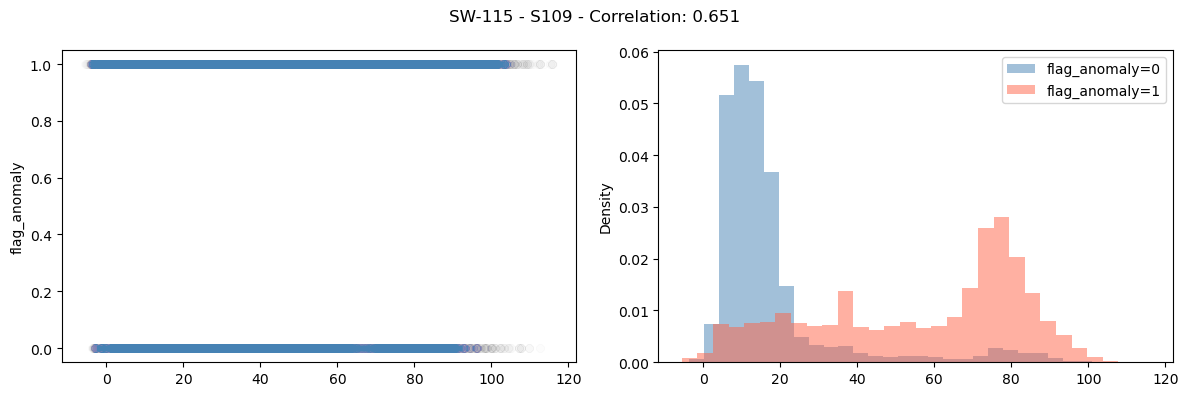

CPU times: user 4.81 s, sys: 232 ms, total: 5.04 s
Wall time: 2min 14s


In [110]:
%%time

for hw in list_hw:

    anomaly_corr = correlations(list_df_blocks_anom[hw], useful_sensors, 'flag_anomaly')
    
    # top_anom_corr = anomaly_corr.head(5)[['Sensors', 'Correlations']].to_dict('records')
    top_anom_corr = anomaly_corr.head(3)['Sensors'].tolist()

    print_separator("yolo")
    plot_correlations(list_df_blocks_anom[hw], 'flag_anomaly', top_anom_corr, anomaly_corr, hw)
    
    # print(top_anom_corr)

## Alternative approach: Random Forest 

In [36]:
#Model the training set balancing the flag anomalies ratio
hw = 'SW-088'

df_final_flag0 = list_df_blocks_anom[hw].filter(col('flag_anomaly')==0)
df_final_flag1 = list_df_blocks_anom[hw].filter(col('flag_anomaly')==1)

to_drop_df = df_final_flag0.sample(withReplacement = False, fraction = 0.85, seed = 2503)

df_final_flag0_reduced = df_final_flag0.subtract(to_drop_df)

df_final_balanced = df_final_flag1.union(df_final_flag0_reduced)


#Check for the ratio between the flag anomalies 1 and 0
flag_ratio = df_final_balanced.filter(col('flag_anomaly')==1).count()/df_final_balanced.filter(col('flag_anomaly')==0).count()

print("Ratio [1/0]:",flag_ratio)

[Stage 1764:==============================================>         (5 + 1) / 6]

Ratio [1/0]: 0.9049526727151329


In [34]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

def run_random_forest(df, feature_cols, label_col="label", n_trees=100, max_depth=5, test_fraction=0.2, seed = 2503):
    
    train_df, test_df = df.randomSplit([1 - test_fraction, test_fraction], seed=seed)
    print(f"Training on {train_df.count()} rows, testing on {test_df.count()} rows")
    
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

    rf = RandomForestClassifier(labelCol=label_col, featuresCol="features", numTrees=n_trees, maxDepth=max_depth,  seed=seed)

    pipeline = Pipeline(stages=[assembler, rf]) #La pipeline serve per dire a Spark di eseguire due operazioni consecutive, poi Spark si arrangia a gestirle in questo modo

    model = pipeline.fit(train_df) 

    train_predictions = model.transform(train_df)
    test_predictions = model.transform(test_df)

    evaluator = MulticlassClassificationEvaluator(labelCol=label_col, predictionCol="prediction", metricName="accuracy")
    test_accuracy = evaluator.evaluate(test_predictions)

    print(f"RandomForest trained with {n_trees} trees, maxDepth={max_depth}")
    print(f"Test Accuracy = {test_accuracy:.4f}")

    rf_model = model.stages[-1] 
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(feature_cols, importances), key=lambda x: -x[1])

    print("\nFeature Importances:")
    for col, imp in feature_importance:
        print(f"{col}: {imp:.4f}")

    return model, train_predictions, test_predictions, test_accuracy

In [39]:
%%time

vector_to_drop = ['A5', 'A9', 'ComError', 'overheating']

sensors_forest = [s for s in useful_sensors if s not in vector_to_drop]

model, train_preds, test_preds, test_accuracy = run_random_forest(df_final_balanced, feature_cols=sensors_forest, label_col="flag_anomaly", n_trees = 120, max_depth = 10, test_fraction=0.33333)

test_preds.select('flag_anomaly', 'prediction', 'probability').show(10, truncate = 0)

Training on 32373 rows, testing on 16129 rows


25/08/21 17:13:24 WARN DAGScheduler: Broadcasting large task binary with size 1225.4 KiB
25/08/21 17:13:25 WARN DAGScheduler: Broadcasting large task binary with size 1767.8 KiB
25/08/21 17:13:26 WARN DAGScheduler: Broadcasting large task binary with size 2.6 MiB
25/08/21 17:13:27 WARN DAGScheduler: Broadcasting large task binary with size 4.1 MiB
25/08/21 17:13:30 WARN DAGScheduler: Broadcasting large task binary with size 6.1 MiB
25/08/21 17:13:32 WARN DAGScheduler: Broadcasting large task binary with size 8.9 MiB
25/08/21 17:13:34 WARN DAGScheduler: Broadcasting large task binary with size 1243.3 KiB
25/08/21 17:14:02 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
                                                                                

RandomForest trained with 120 trees, maxDepth=10
Test Accuracy = 0.8996

Feature Importances:
S109: 0.1240
S5: 0.0934
S125: 0.0667
S73: 0.0571
S102: 0.0542
S126: 0.0479
S122: 0.0461
S81: 0.0417
S107: 0.0385
S9: 0.0326
S101: 0.0284
S124: 0.0211
S166: 0.0172
S83: 0.0161
S164: 0.0158
S97: 0.0156
S90: 0.0147
S100: 0.0146
S70: 0.0134
S118: 0.0130
S40: 0.0113
S39: 0.0113
S158: 0.0108
S41: 0.0107
S47: 0.0102
S46: 0.0094
S138: 0.0090
S10: 0.0090
S157: 0.0087
S130: 0.0084
S3: 0.0072
S159: 0.0071
S80: 0.0070
S140: 0.0065
S72: 0.0064
S203: 0.0064
S86: 0.0064
S154: 0.0062
S178: 0.0061
S71: 0.0060
S123: 0.0056
S180: 0.0056
S181: 0.0035
S129: 0.0034
S117: 0.0033
S137: 0.0031
S147: 0.0031
S37: 0.0030
S202: 0.0027
S128: 0.0026
S143: 0.0025
SA11: 0.0022
S114: 0.0019
SA9: 0.0019
S6: 0.0019
S179: 0.0014
P10: 0.0013
S170: 0.0013
S205: 0.0011
S169: 0.0011
P16: 0.0011
S53: 0.0009
S112: 0.0009
S206: 0.0009
S94: 0.0007
S7: 0.0007
S173: 0.0006
S172: 0.0006
S201: 0.0005
S151: 0.0005
S1: 0.0005
S171: 0.0004
S127

25/08/21 17:14:14 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
25/08/21 17:14:14 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB


+------------+----------+----------------------------------------+
|flag_anomaly|prediction|probability                             |
+------------+----------+----------------------------------------+
|1           |0.0       |[0.7553949586127506,0.2446050413872493] |
|1           |0.0       |[0.5906355423169716,0.40936445768302854]|
|1           |0.0       |[0.5603523724739267,0.4396476275260734] |
|1           |1.0       |[0.3011140817820693,0.6988859182179308] |
|1           |1.0       |[0.404057790682642,0.5959422093173579]  |
|1           |1.0       |[0.19532519198876985,0.8046748080112301]|
|1           |1.0       |[0.14804283629707024,0.8519571637029297]|
|1           |1.0       |[0.16982303671128296,0.830176963288717] |
|1           |1.0       |[0.2456904006859635,0.7543095993140365] |
|1           |1.0       |[0.44289926506583166,0.5571007349341683]|
+------------+----------+----------------------------------------+
only showing top 10 rows

CPU times: user 132 ms, sys: 43.3 ms

In [42]:
#Prediction with the obtained model
n = 20
data_row = df_final_balanced.orderBy(rand()).limit(n)

predicted_data = model.transform(data_row)
predicted_data.select("S109", "S166", "S102", "flag_anomaly", "prediction").show()

25/08/21 17:16:31 WARN DAGScheduler: Broadcasting large task binary with size 6.3 MiB
                                                                                

+------+-----+-----+------------+----------+
|  S109| S166| S102|flag_anomaly|prediction|
+------+-----+-----+------------+----------+
|1094.0|125.0|335.5|           1|       1.0|
| 488.0|235.0|293.0|           0|       0.0|
| 828.5|118.0|220.0|           1|       1.0|
| 335.0|273.0|179.0|           0|       0.0|
| 490.0|208.0|219.5|           1|       1.0|
| 576.0|666.0|196.0|           1|       1.0|
|1111.0|180.0|342.0|           1|       1.0|
| 945.0|869.0|295.5|           1|       1.0|
+------+-----+-----+------------+----------+



## Alternative approach: PCA

In [40]:
from pyspark.sql.types import DoubleType
from pyspark.ml.feature import VectorAssembler

def covariance_matrix(df, cols=None):
    """
    This function returns the covariance matrix from the df
    """
    
    if cols is None:
        cols = df.columns

    for c in cols:
        df = df.withColumn(c, col(c).cast(DoubleType()))
    
    means = df.select([mean(c).alias(c) for c in cols]).collect()[0].asDict()
    
    df_centered = df.select(*[(col(c) - means[c]).alias(c) for c in cols])
    
    assembler = VectorAssembler(inputCols=cols, outputCol="features")
    df_centered_vec = assembler.transform(df_centered).select("features")
    
    n = df.count()
    cov_matrix = (
        df_centered_vec.rdd
        .map(lambda row: row.features.toArray())
        .map(lambda x: np.outer(x, x))
        .reduce(lambda a, b: a + b) / (n - 1)
    )
    
    return cov_matrix, cols

In [ ]:
def pca_from_cov(cov_matrix, cols, verbose = False):
    """
    PCA from covariance matrix
    """
    eigvals, eigvecs = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    explained_var_ratio = eigvals / eigvals.sum()

    if verbose:
        print("Covariance matrix:\n", cov_matrix, "\n")
        print("Eigenvalues (variance explained):", eigvals)
        print("Explained variance ratio:", explained_var_ratio, "\n")
        print("Principal Components (eigenvectors):")
        for i in range(int(len(cols)/7)):
            print(f"PC{i+1} ({explained_var_ratio[i]*100:.2f}% variance):")
            for col, weight in zip(cols, eigvecs[:, i]):
                if weight > 0.001
                print(f"  {col}: {weight:.4f}")
            print()

    return weight

In [41]:
pca_sensors = [ 'P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10','S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
for hw in [hw_to_inspect]: # mettici list_hw per averlo generale   
    df_anomalies_n = list_df_blocks_anom[hw].select(pca_sensors)
    df_anomalies_n = df_anomalies_n.na.drop()

    cov_matrix, columns = covariance_matrix(df_anomalies_n)

    print("Columns:", columns)
    print("Covariance matrix:\n", cov_matrix)    
    #df_anomalies_n.printSchema()
    #df_anomalies_n.show(5)

[Stage 1962:==========================================>             (3 + 1) / 4]

Columns: ['P1', 'P10', 'P15', 'P16', 'P17', 'P18', 'P2', 'P5', 'P6', 'P7', 'P8', 'P9', 'S1', 'S10', 'S109', 'S11', 'S110', 'S112', 'S113', 'S114', 'S115', 'S117', 'S118', 'S122', 'S123', 'S124', 'S125', 'S126', 'S127', 'S128', 'S129', 'S130', 'S137', 'S138', 'S140', 'S143', 'S147', 'S15', 'S151', 'S154', 'S157', 'S158', 'S159', 'S16', 'S163', 'S164', 'S165', 'S166', 'S167', 'S169', 'S17', 'S170', 'S171', 'S172', 'S173', 'S174', 'S175', 'S176', 'S178', 'S179', 'S181', 'S183', 'S19', 'S2', 'S201', 'S202', 'S203', 'S204', 'S205', 'S206', 'S25', 'S3', 'S33', 'S34', 'S35', 'S37', 'S39', 'S40', 'S41', 'S42', 'S43', 'S45', 'S46', 'S47', 'S49', 'S5', 'S50', 'S53', 'S54', 'S55', 'S56', 'S57', 'S6', 'S63', 'S64', 'S69', 'S7', 'S70', 'S71', 'S72', 'S73', 'S8', 'S80', 'S81', 'S83', 'S86', 'S9', 'S90', 'S94', 'S97', 'SA1', 'SA10', 'SA11', 'SA12', 'SA2', 'SA3', 'SA4', 'SA5', 'SA6', 'SA7', 'SA8', 'SA9', 'SW', 'flag_anomaly']
Covariance matrix:
 [[1.10804046e-01 6.21838345e-01 0.00000000e+00 ... 3.843

In [ ]:
%%time

pca_weights = pca_from_cov(cov_matrix, columns, verbose = True)

# Anomaly Detection (2)

## Correlation between device load and external temperature (S125-S181 vs S41) (Attualmente not working)

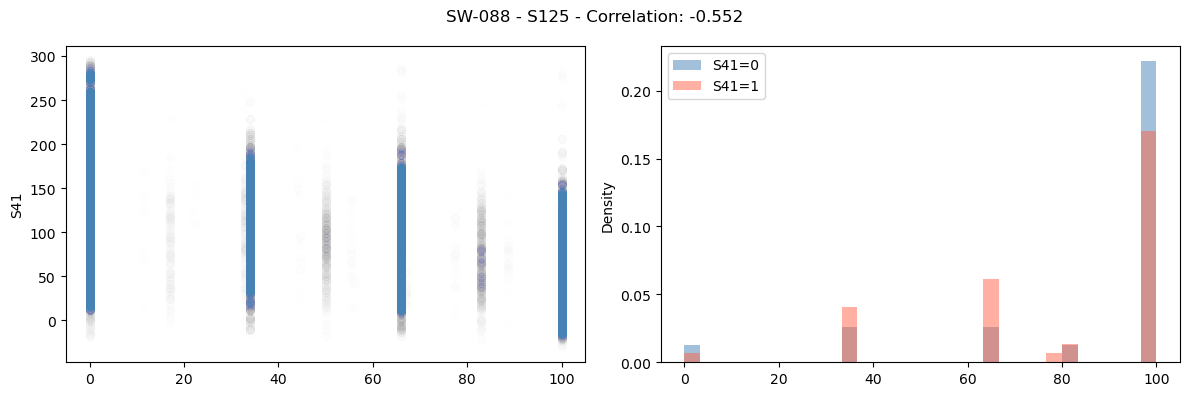

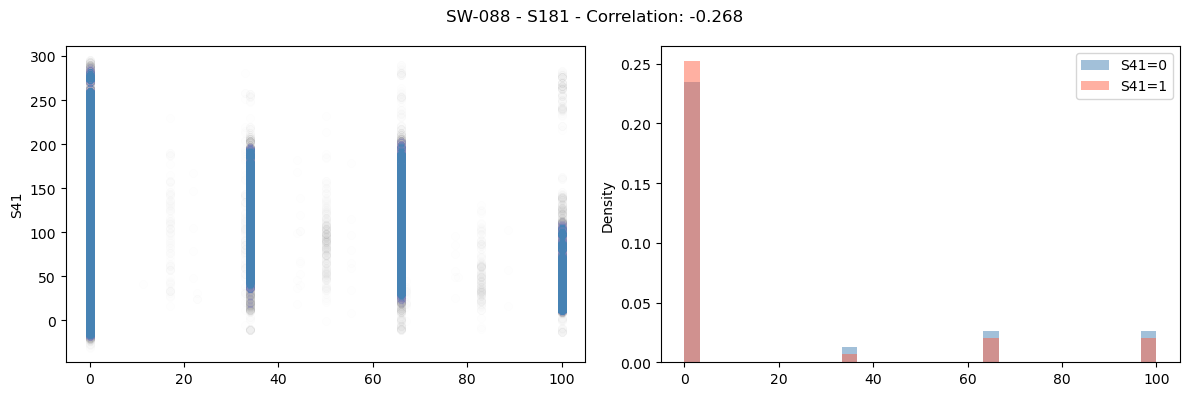

CPU times: user 712 ms, sys: 12.2 ms, total: 724 ms
Wall time: 3.09 s


In [74]:
%%time

load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

for hw in [hw_to_inspect]: # Sostituire hw_to_inspect con list_hw
    temper_corr = correlations(list_df_blocks_anom[hw], load_sensors, temperature_sensor)

    plot_correlations(list_df_blocks_anom[hw], temperature_sensor, load_sensors, temper_corr, hw)
    
    # print(top_anom_corr)

In [75]:
list_df_blocks_anom[hw_to_inspect].select('S41').show(10)

# Well well this is a problem, non è binario

+-----+
|  S41|
+-----+
|176.0|
|176.0|
|176.0|
|177.0|
|179.0|
|177.0|
|179.0|
|179.0|
|180.0|
|176.0|
+-----+
only showing top 10 rows



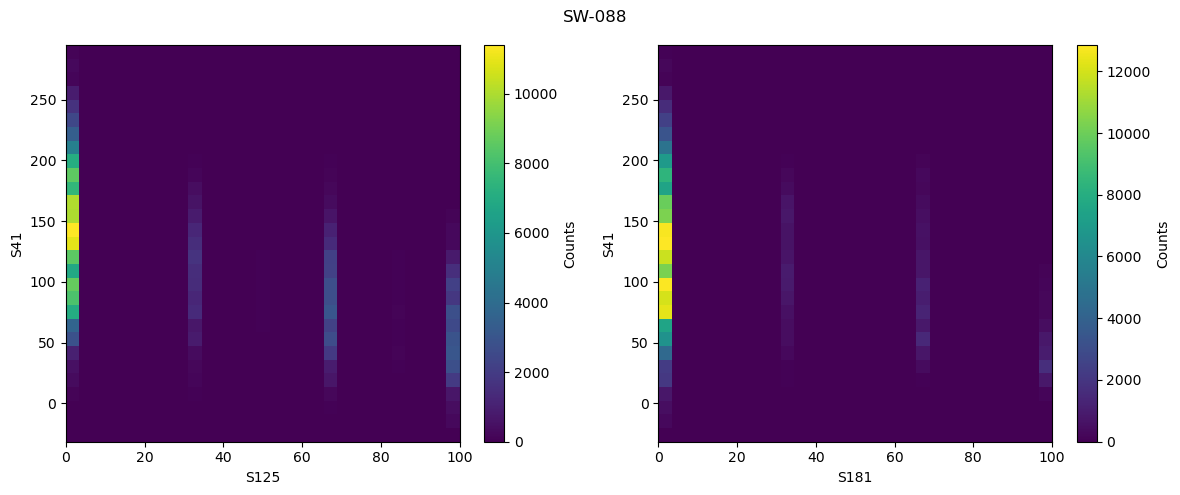

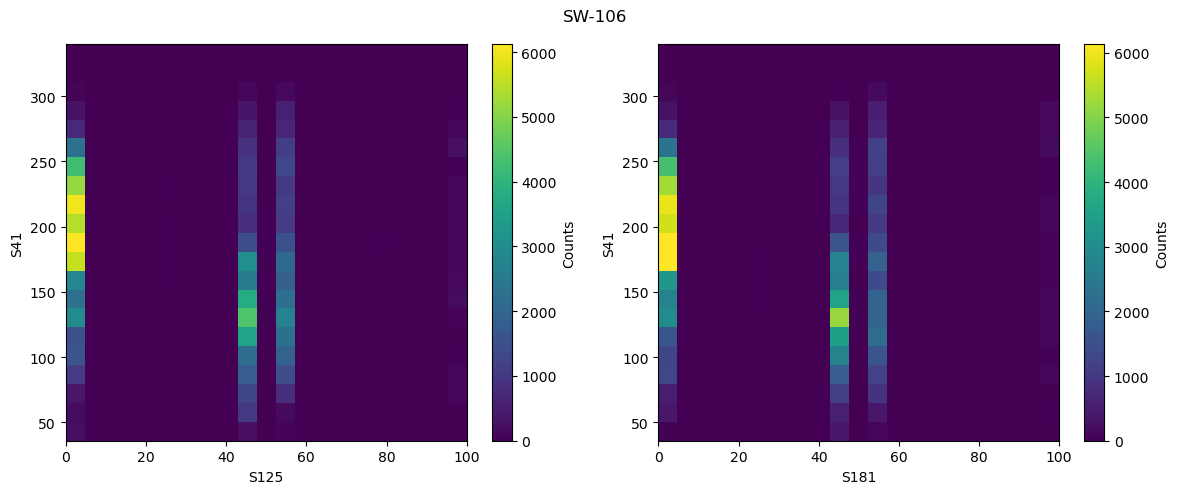

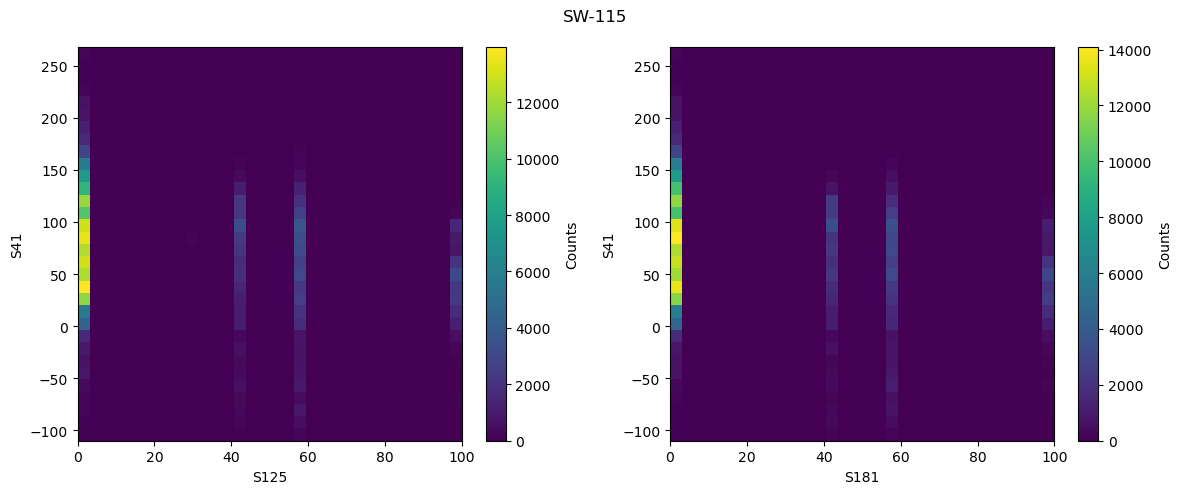

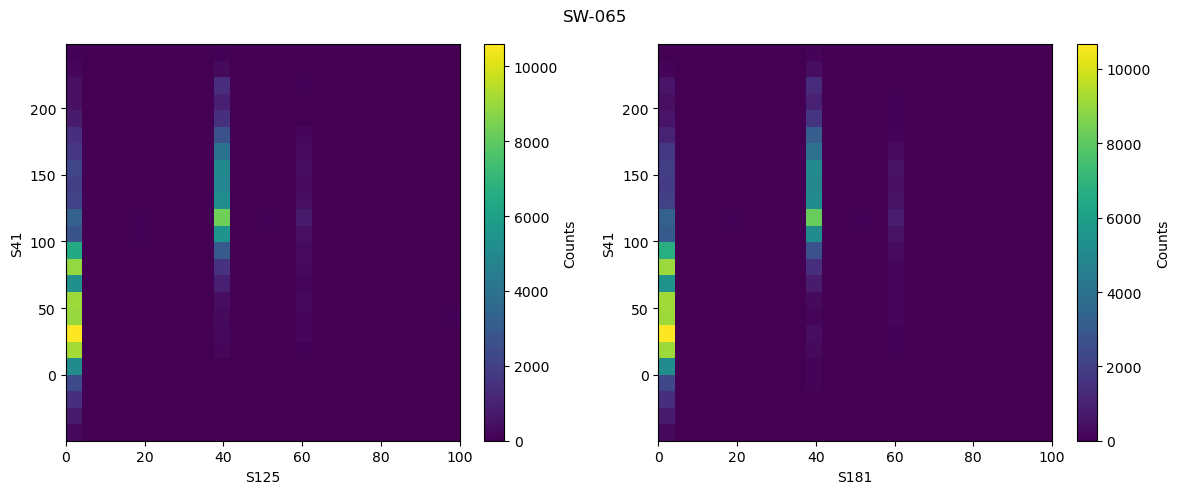

In [17]:
load_sensors = ['S125', 'S181']
temperature_sensor = 'S41'

# Inspect joint distribution of S41 and device load

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # fig.subplots_adjust(wspace=0.4)
    fig.suptitle(f"{hw}")
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        filtered_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))
        
        temperature = filtered_df.select(temperature_sensor).rdd.flatMap(lambda x: x).collect()
        load        = filtered_df.select(load_sensor).rdd.flatMap(lambda x: x).collect()
        bins = int(np.sqrt(len(temperature))/15)
        
        counts, xedges, yedges, im = ax[i].hist2d(load, temperature, bins=bins)
        cbar = fig.colorbar(im, ax=ax[i])   
        cbar.set_label('Counts')  
        ax[i].set_ylabel(temperature_sensor)
        ax[i].set_xlabel(load_sensor)
        
    plt.tight_layout()    
    plt.show()

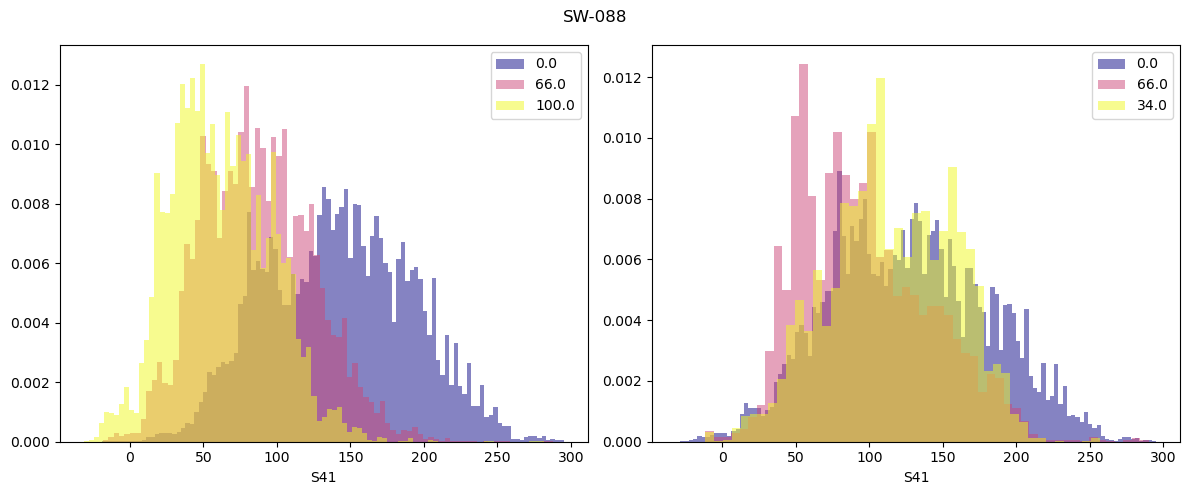

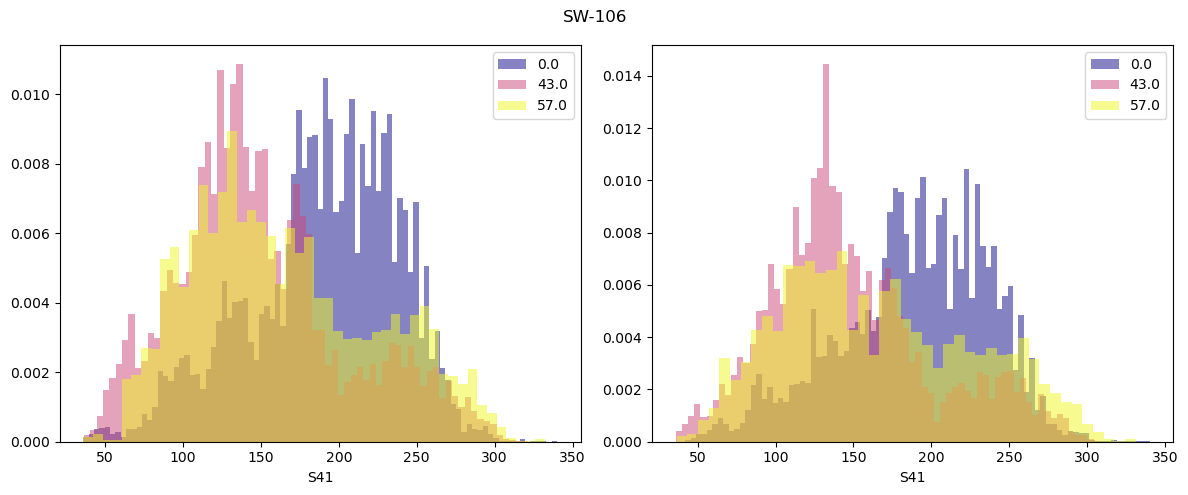

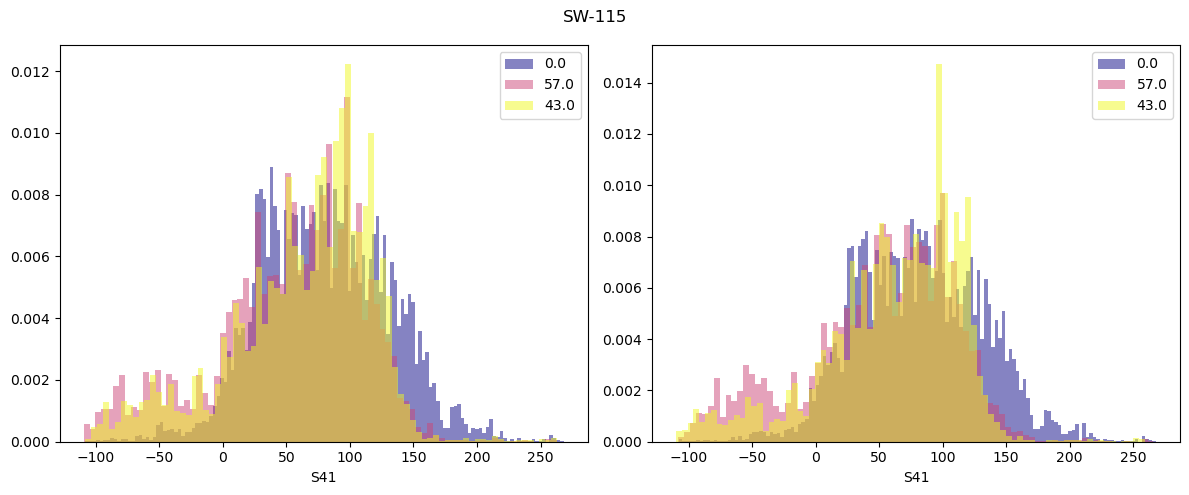

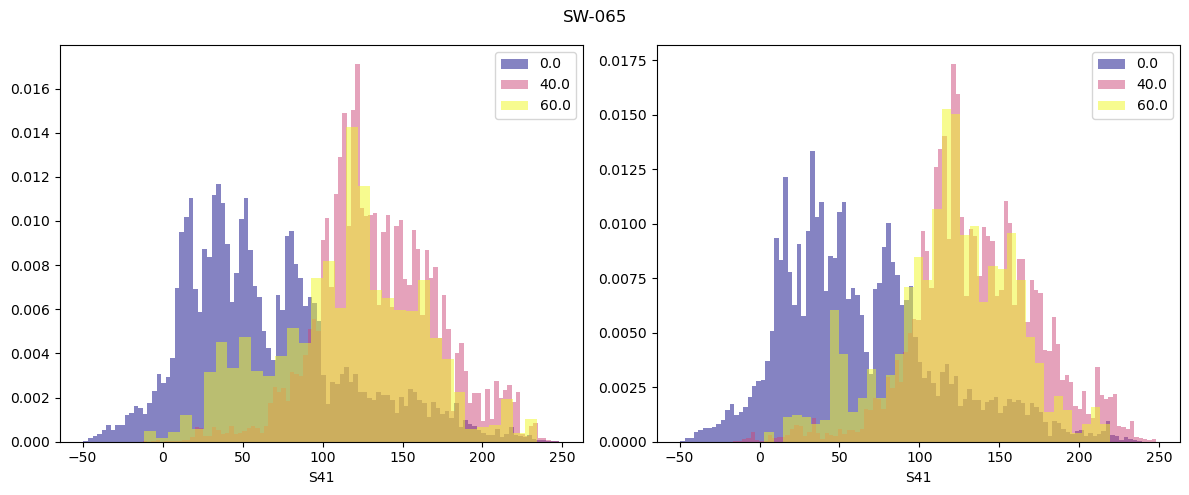

CPU times: user 3.91 s, sys: 178 ms, total: 4.08 s
Wall time: 49.6 s


In [18]:
%%time

# Inspect overlap of temperature distributions for different work load percentages

n_distributions = 3 # Show the first n most numerous distributions

for hw in list_hw:
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(f"{hw}")
    
    for i in range(len(load_sensors)):
        load_sensor = load_sensors[i]
        noNull_df = list_df_blocks_anom[hw].dropna(subset=(temperature_sensor, load_sensor))

        top_load_percentages = noNull_df \
            .select(load_sensor) \
            .groupBy(load_sensor) \
            .count() \
            .sort('count', ascending=False) \
            .limit(n_distributions) \
            .select(load_sensor) \
            .rdd.flatMap(lambda x: x) \
            .collect()
        # In alternativa, se lento fare pivot intorno a load_sensor dopo il filtro
        # print(load_sensor, ': ', top_load_percentages)
        
        cmap = plt.get_cmap('plasma') # viridis, plasma
        colors = [cmap(i) for i in np.linspace(0, 1, n_distributions)]

        for load_percentage, color in zip(top_load_percentages, colors): 
            temperature = noNull_df \
                .filter(f'{load_sensor} = {load_percentage}') \
                .select(temperature_sensor) \
                .rdd.flatMap(lambda x: x) \
                .collect()
            # bins = int(np.sqrt(len(temperature))/2)
            
            ax[i].hist(temperature, bins='auto', color=color, alpha=0.5, label=f'{load_percentage}', density=True)  
            ax[i].set_xlabel(temperature_sensor)
            ax[i].legend()
            
    plt.tight_layout()    
    plt.show()

# Predictive maintenance

## Conversion of Alarms (A5, A9)

In [21]:
def extract_alarms(df, columns=["A5", "A9"], bits=[6, 7, 8]):
    for col_name in columns:
        for bit in bits:
            convert_bit = bit - 1  # bit 1 is LSB
            df = df.withColumn( f"{bit}-{col_name}", ((col(col_name).bitwiseAND(1 << convert_bit)) > 0).cast("int") )
    
    #all_bit_cols = [col(f"{bit}-{col_name}") for col_name in columns for bit in bits]
    
    # condition ad least one alarm to get overheating
    #condition = sum(all_bit_cols) > 0 # already menaged NULL, it gives 0
    #df = df.withColumn("overheating", when(condition, 1).otherwise(0).cast("int"))


    df = df.withColumn(
        "overheating",
        when(
            (col("6-A5") == 1) | (col("7-A5") == 1) | (col("8-A5") == 1) | (col("6-A9") == 1) | (col("7-A9") == 1) | (col("8-A9") == 1) ,
            1
            ).otherwise(0).cast("int")
            ).where( (col("A5").isNotNull()) | (col("A9").isNotNull()) )
    return df

In [22]:
# Extract bits from alarms

list_df_alarms = {}
for hw in list_hw:
    df_alarms = extract_alarms(df_blocks.filter( col("hwid") == hw).select("when","A5","A9"),
                            columns=["A5", "A9"],
                            bits=[6, 7, 8] )

    list_df_alarms[hw] = df_alarms
    print( f"For hardware {hw} were recorded {df_alarms.agg(spark_sum(col('overheating'))).collect()[0][0]} overheating signals." )

#list_df_alarms['SW-088'].show(3)
#list_df_alarms['SW-088'].where( (col("A5").isNotNull()) | (col("A9").isNotNull()) ).show(3)
list_df_alarms['SW-088'].where( col("overheating") == 1 ).show(30)

For hardware SW-065 were recorded 0 overheating signals.
For hardware SW-088 were recorded 124 overheating signals.
For hardware SW-106 were recorded 0 overheating signals.
For hardware SW-115 were recorded 0 overheating signals.
+----------+-----+----+----+----+----+----+----+----+-----------+
|      when|   A5|  A9|6-A5|7-A5|8-A5|6-A9|7-A9|8-A9|overheating|
+----------+-----+----+----+----+----+----+----+----+-----------+
|1601510790|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601510850|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601597190|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601597250|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601686290|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601686350|18496|NULL|   0|   1|   0|NULL|NULL|NULL|          1|
|1601769750|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601856330|18496|   0|   0|   1|   0|   0|   0|   0|          1|
|1601856390|18496|NULL|   0|   1|   0|NULL|N

In [23]:
%%time

list_df_final = {}

print("Check previous n° of alarms with respect to total lines.\n")
#print('Number of records for every hardware. \n')

for hw in list_hw:
    df_final = list_df_blocks_anom[hw].join( list_df_alarms[hw].select('when', 'overheating') , on='when', how='left' )
    #list_df_final[hw] = df_final.persist()
    list_df_final[hw] = df_final
    print( f"For hardware {hw} there are {list_df_final[hw].count()} lines" )

Check previous n° of alarms with respect to total lines.



For hardware SW-065 there are 136096 lines


For hardware SW-088 there are 191805 lines


For hardware SW-106 there are 105873 lines


For hardware SW-115 there are 237640 lines
CPU times: user 99.5 ms, sys: 26.8 ms, total: 126 ms
Wall time: 30.3 s


## Correlation analysis for alarms

In [23]:
hw_to_inspect = 'SW-088'

In [24]:
alarm_corr = correlations(list_df_final[hw_to_inspect], useful_sensors, 'overheating')
alarm_corr.head(10)

,Sensors,Correlations
0,S53,0.654998
1,S7,0.649957
2,S172,0.498684
3,S173,-0.489226
4,S39,0.405736
5,S40,0.404673
6,S3,0.401989
7,P16,0.384099
8,P2,0.378371
9,S33,-0.357743


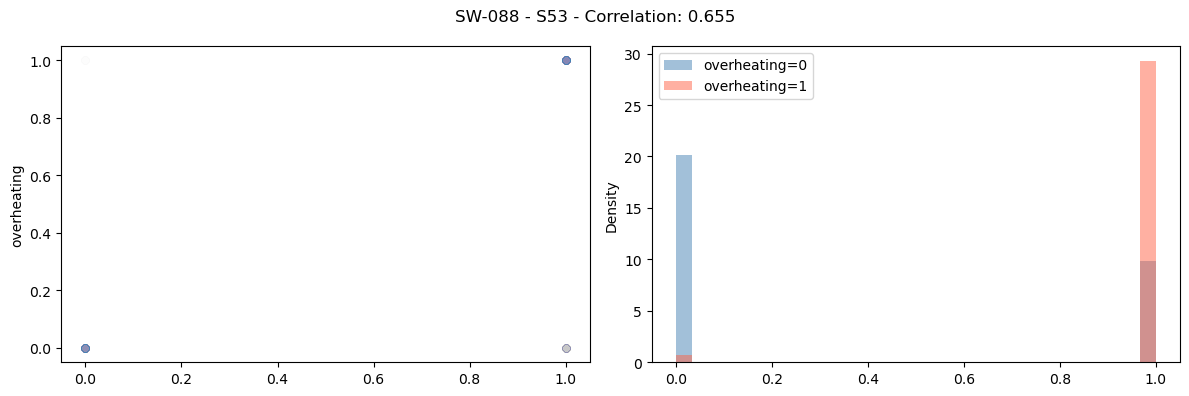

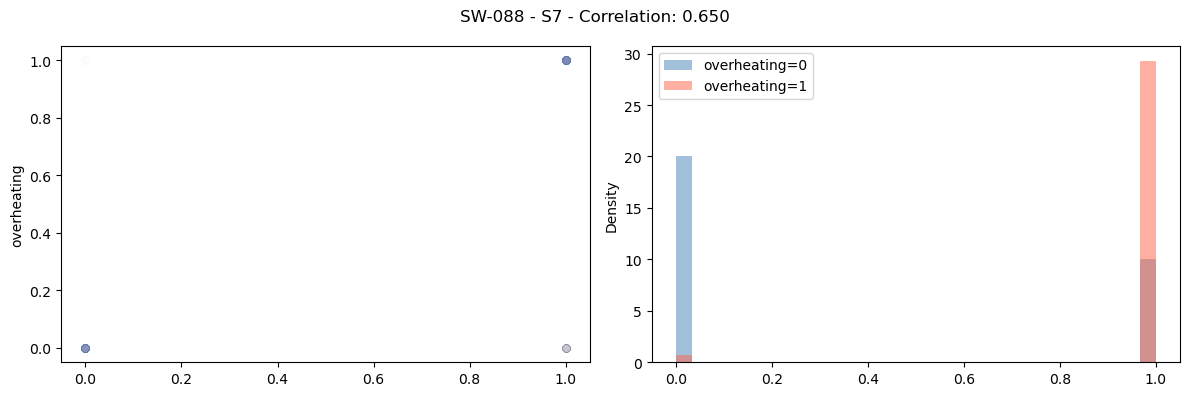

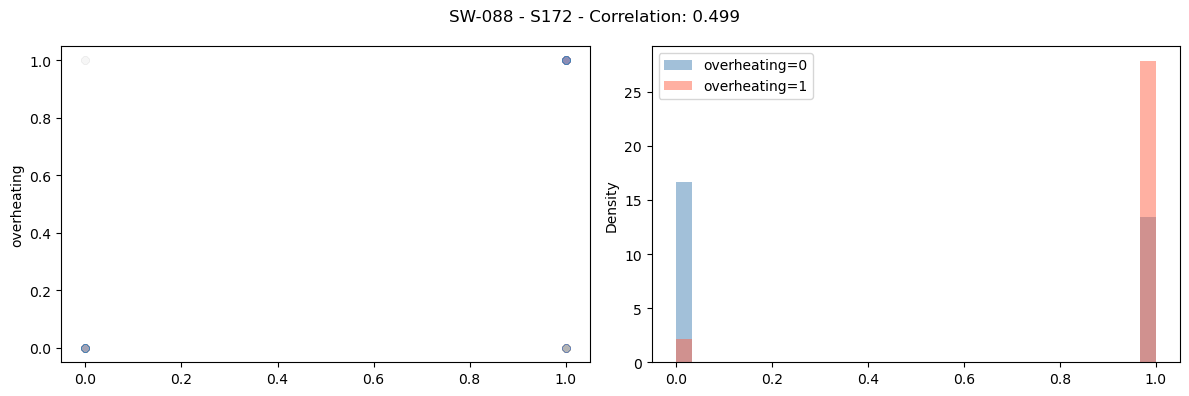

CPU times: user 682 ms, sys: 581 ms, total: 1.26 s
Wall time: 18.5 s


In [25]:
%%time

for hw in [hw_to_inspect]:
    alarm_corr = correlations(list_df_final[hw], useful_sensors, 'overheating')

    
    #top_alarm_corr = alarm_corr.head(5)[['Sensors', 'Correlations']].to_dict('records')
    top_alarm_corr = alarm_corr.head(3)['Sensors'].tolist()
    
    plot_correlations(list_df_final[hw], 'overheating', top_alarm_corr, alarm_corr, hw)
    
    #print(top_alarm_corr)

## Predictive modeling 

In [19]:
# FOR DOCKER ---------- DO NOT DELETE

#df_final_088.write.mode("overwrite").parquet("df_lavorare.parquet") #save file
df_final_088 = spark.read.parquet("df_lavorare.parquet") #read file
#df_final_088.columns

### Add predictive flag

In [44]:
df_final_088 = list_df_final['SW-088'] # the only one in which there is overheating

In [45]:
def add_predictive(df, target, window_before_heating=30, join=True ,debug=False): #window_before_heating in minutes

    w = Window.partitionBy("BlockID").orderBy("when")

    df_pred = df.select("BlockID","when","window_start",target)
    df_pred = df.withColumn(f"prev_{target}", lag(target).over(w))
    df_pred = df_pred.withColumn(
        f"is_start_{target}",
        when(
            (col(target) == 1) &
            ((col(f"prev_{target}") != 1) | col(f"prev_{target}").isNull()),
            1
        ).otherwise(0)
    )


    df_pred = df_pred.withColumn(f"start_time_{target}", when(col(f"is_start_{target}") == 1, col("when")))

    w_future = w.rowsBetween(Window.currentRow, Window.unboundedFollowing)
    df_pred = df_pred.withColumn(
        f"next_start_{target}",
        first(f"start_time_{target}", ignorenulls=True).over(w_future)
    )

    window_seconds = window_before_heating * 60
    df_pred = df_pred.withColumn(
    f"predictive_{target}",
        when(
            (col(f"next_start_{target}").isNotNull()) &
            (((col(target).isNull()) | (col(target) == 0))) &
            ((col(f"next_start_{target}") - col("when")) > 0) &
            ((col(f"next_start_{target}") - col("when")) <= window_seconds), 1 ).otherwise(0))

    if not debug:
        df_pred = df_pred.select("BlockID","when",target,f"predictive_{target}")


    if join:
        return df.join( df_pred.select('when', f'predictive_{target}') , on='when', how='left' )
    else:
        return df_pred

In [49]:
# target = "flag_anomaly"
# df_final_088 = add_predictive(df_final_088, target, window_before_heating=30, debug=False, join=True )
# df_final_088.filter(col("predictive_flag_anomaly") == 1).select('when', target, f'predictive_{target}').count()

3168

In [47]:
target = "overheating"
df_final_088 = add_predictive(df_final_088, target, window_before_heating=30, debug=False, join=True )
df_final_088.filter(col("predictive_overheating") == 1).select('when', target, f'predictive_{target}').count()

1826

In [39]:
target = "overheating"
df_final_088.where( (col("when") >= 1611962590) & (col("when") <= 1611967590) ).orderBy(col("when").asc()) \
     .select("window_start",target,f"predictive_{target}") .show(50)

+-------------------+-----------+----------------------+
|       window_start|overheating|predictive_overheating|
+-------------------+-----------+----------------------+
|2021-01-29 23:23:00|       NULL|                     0|
|2021-01-29 23:24:00|       NULL|                     0|
|2021-01-29 23:25:00|       NULL|                     0|
|2021-01-29 23:26:00|       NULL|                     0|
|2021-01-29 23:27:00|       NULL|                     0|
|2021-01-29 23:28:00|       NULL|                     0|
|2021-01-29 23:29:00|       NULL|                     0|
|2021-01-29 23:30:00|       NULL|                     0|
|2021-01-29 23:31:00|       NULL|                     0|
|2021-01-29 23:32:00|       NULL|                     0|
|2021-01-29 23:33:00|       NULL|                     0|
|2021-01-29 23:34:00|       NULL|                     0|
|2021-01-29 23:35:00|       NULL|                     0|
|2021-01-29 23:36:00|       NULL|                     0|
|2021-01-29 23:37:00|       NUL

BlockID: 0
Sensor: S53
Sensor: S7
BlockID: 5
Sensor: S53
Sensor: S7
BlockID: 8
Sensor: S53
Sensor: S7
BlockID: 13
Sensor: S53
Sensor: S7
BlockID: 20
Sensor: S53
Sensor: S7
BlockID: 22
Sensor: S53
Sensor: S7
BlockID: 23
Sensor: S53
Sensor: S7
BlockID: 26
Sensor: S53
Sensor: S7
BlockID: 28
Sensor: S53
Sensor: S7
BlockID: 411
Sensor: S53
Sensor: S7
BlockID: 527
Sensor: S53
Sensor: S7
BlockID: 530
Sensor: S53
Sensor: S7
BlockID: 534
Sensor: S53
Sensor: S7
BlockID: 539
Sensor: S53
Sensor: S7
BlockID: 637
Sensor: S53
Sensor: S7
BlockID: 638
Sensor: S53
Sensor: S7
BlockID: 643
Sensor: S53
Sensor: S7
BlockID: 653
Sensor: S53
Sensor: S7
BlockID: 656
Sensor: S53
Sensor: S7
BlockID: 664
Sensor: S53
Sensor: S7
CPU times: user 205 ms, sys: 28.1 ms, total: 234 ms
Wall time: 53.3 s


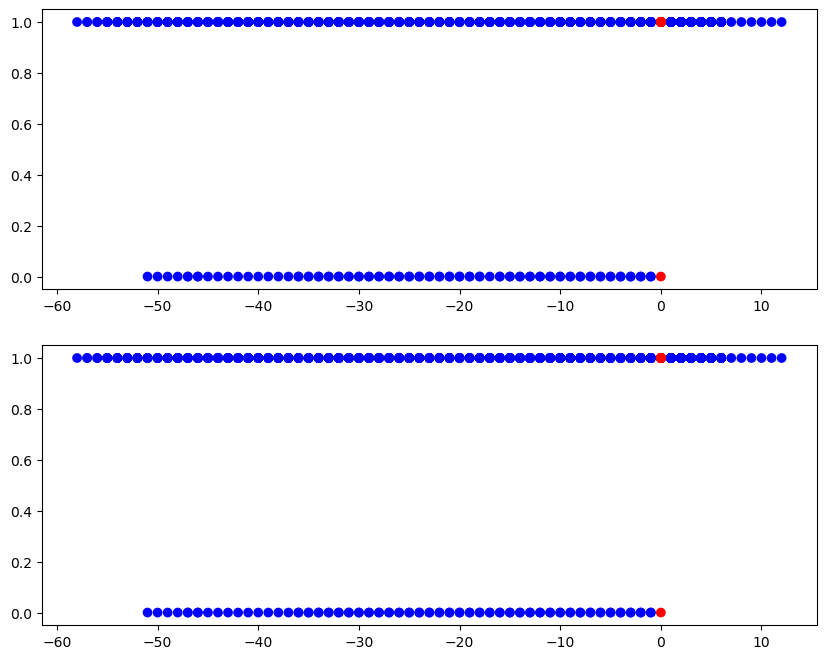

In [42]:
%%time
debug = True
### DA FARE: miglior estetica, capire se c'è differenza
n_sensors = 2
prev_time = 60*60 # seconds
post_time = 5*60
window = Window.partitionBy('BlockID').orderBy('when')

top_corr_sensors = alarm_corr['Sensors'][0:n_sensors]

indexed_df = (
    df_final_088 \
        .select('when', *top_corr_sensors, 'overheating', 'BlockID') \
        .withColumn('overheating_count', count_if(col('overheating') == 1).over(window.rangeBetween(-post_time, prev_time))) \
        .withColumn('closeToOverheating', col('overheating_count') > 0) \
        .filter('closeToOverheating') \
        .withColumn('naive_order', row_number().over(window) - 1)
)
# Voglio centrare l'ordinamento delle righe in modo che lo 0 cada sulla prima occorrenza di 1 
# Prima trovo la posizione del primo 1
positionOfOnes = (
    indexed_df \
        .filter('overheating = 1') \
        .groupBy('BlockID') \
        .agg(spark_min('naive_order').alias('positionOf1')) \
)
# Poi la sottraggo all'indice di ogni riga
plot_df = (
    indexed_df \
        .join(positionOfOnes, on='BlockID', how='left') \
        .withColumn('order', col('naive_order') - col('positionOf1')) \
        .select('when', *top_corr_sensors, 'overheating', 'BlockID', 'order')
)

distinct_blocks = plot_df.select('BlockID').distinct().rdd.flatMap(lambda x: x).collect()

fig, axes = plt.subplots(n_sensors, 1, figsize=(10, n_sensors*4))

for j in distinct_blocks[:20]:
    if debug: print(f'BlockID: {j}')
        
    pandas_df = plot_df.filter(f'BlockID = {j}').toPandas()
    for i in range(n_sensors):
        if debug: print(f'Sensor: {top_corr_sensors[i]}')

        orders = pandas_df['order']
        values = pandas_df[top_corr_sensors[i]]
        colors = ['red' if order == 0 else 'blue' for order in orders]
        axes[i].scatter(orders, values, c=colors)
        
        #pandas_df.plot.scatter(x='order', y=, ax=axes[i], color=)

   
#print(distinct_blocks)
#plot_df.show(300, truncate=False)

In [35]:

target = "flag_anomaly"
df_final_088 = add_predictive(df_final088, target, window_before_heating=30, debug=False, join=True )

In [40]:
# Example on anomaly

# target = "flag_anomaly"
# df_final088.where( (col("when") >= 1602565010) & (col("when") <= 1602654050) ).orderBy(col("when").asc()) \
#     .select("window_start",target,f"predictive_{target}") .show(50)

In [41]:
# Example on overheating

# target = "overheating"
# df_final088.where( (col("when") >= 1612537050) & (col("when") <= 1612540710) ).orderBy(col("when").asc()) \
#     .select("window_start",target,f"predictive_{target}") .show(50)

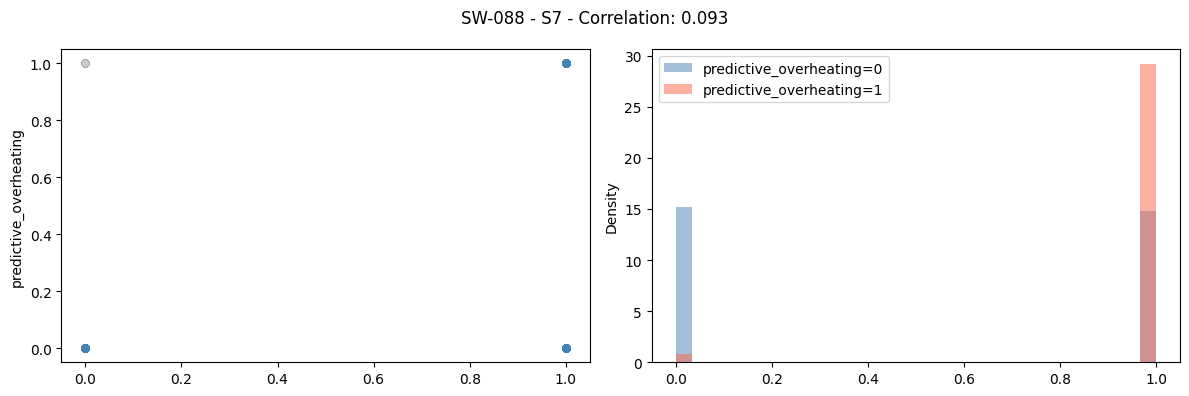

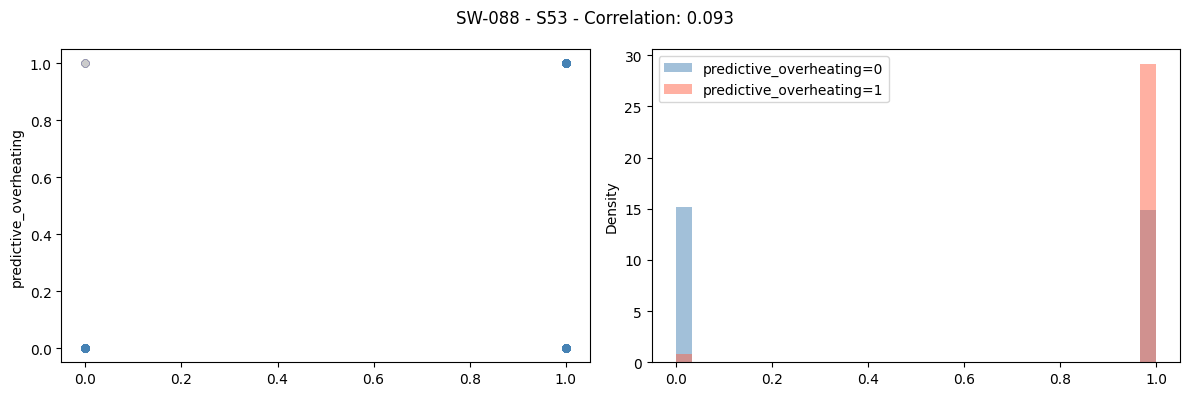

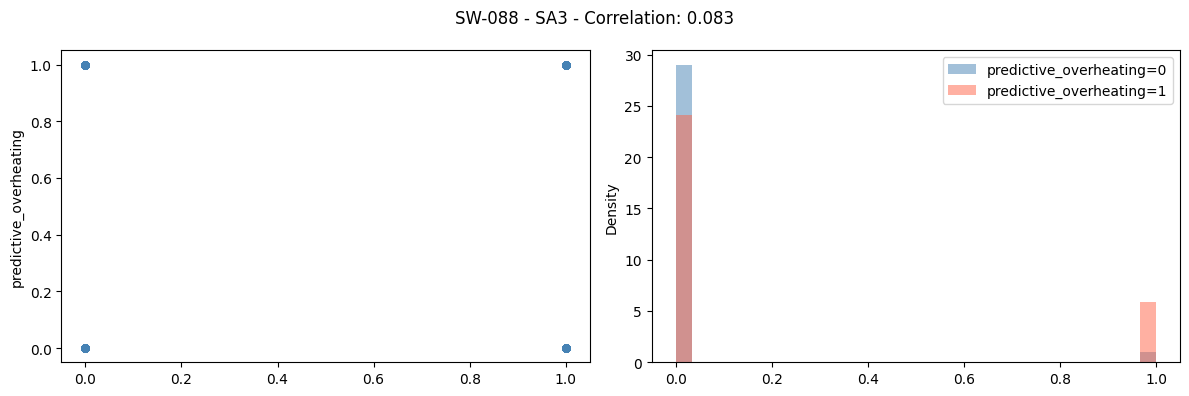

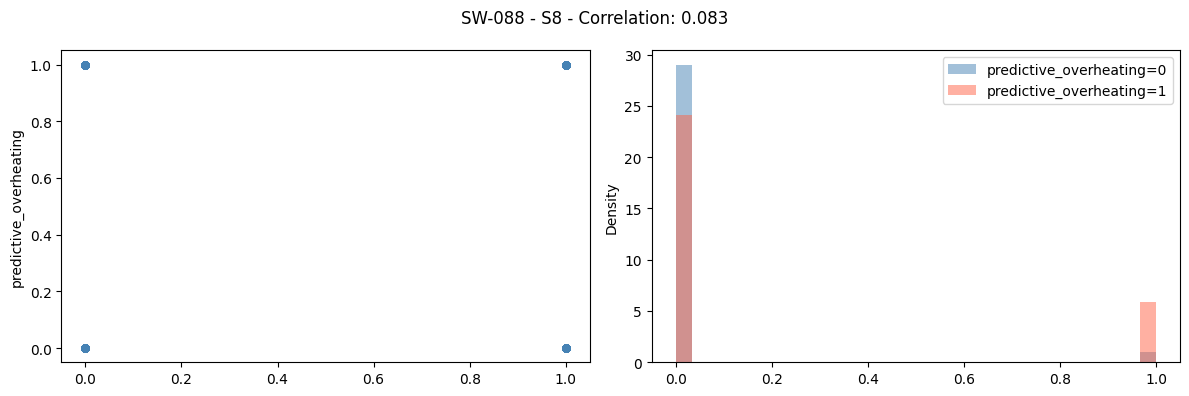

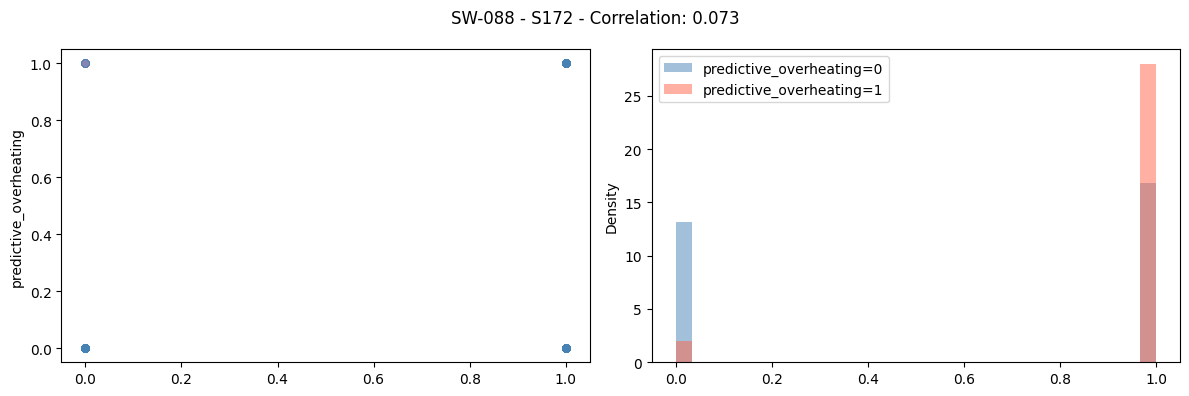

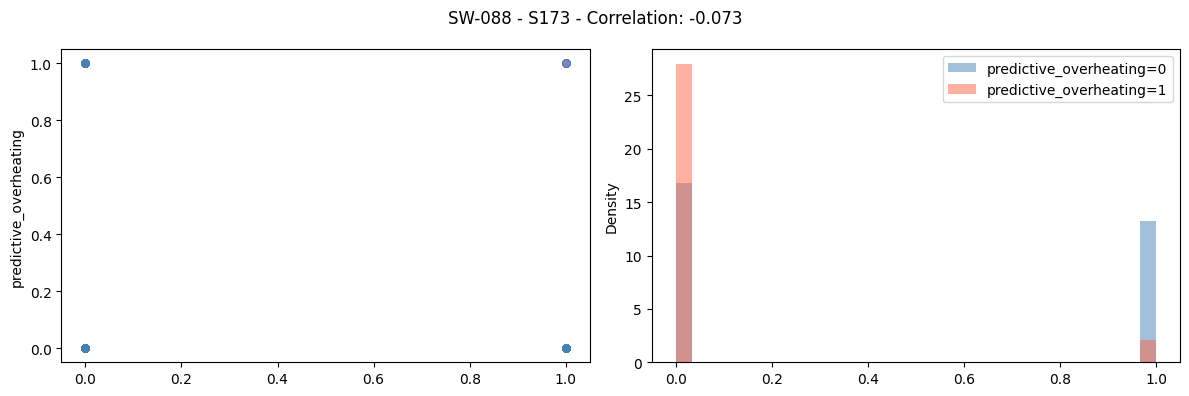

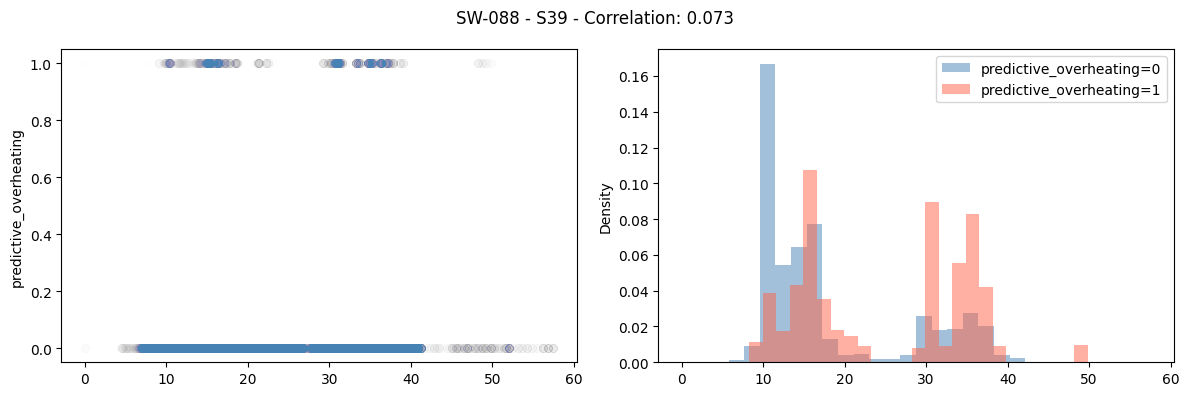

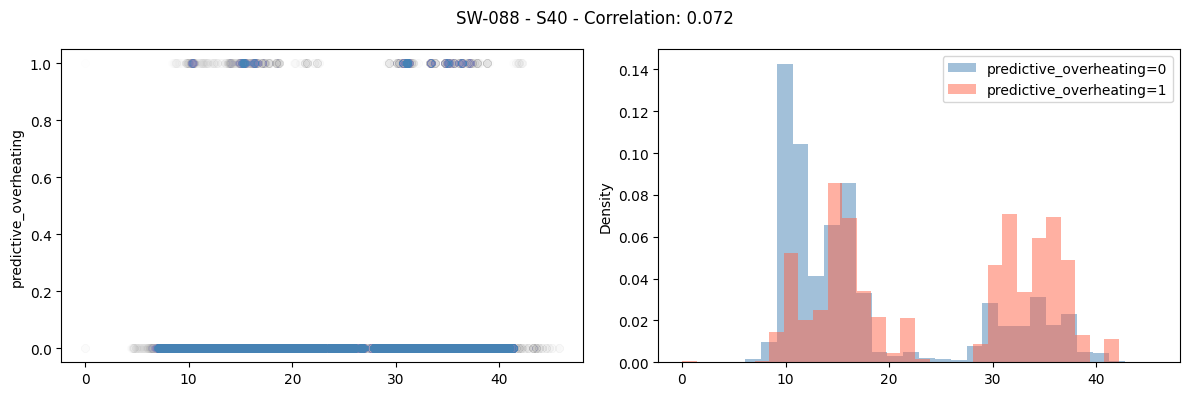

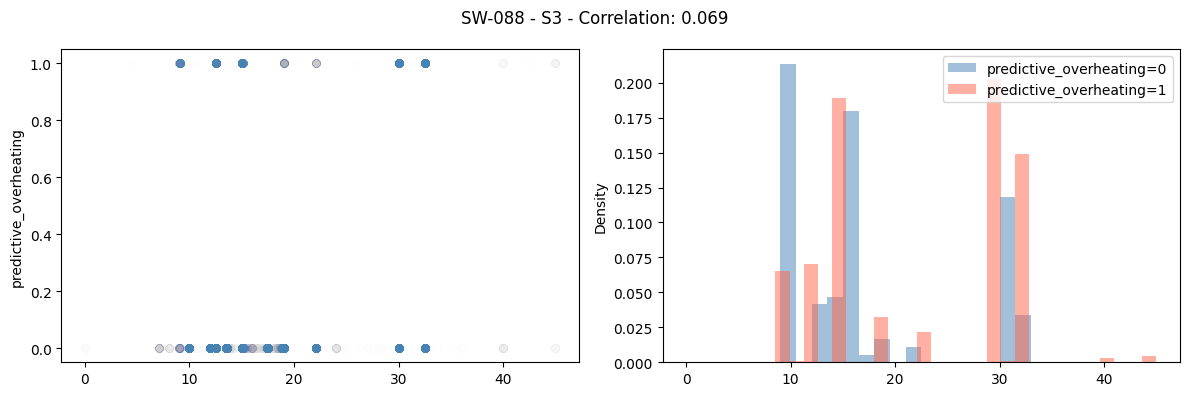

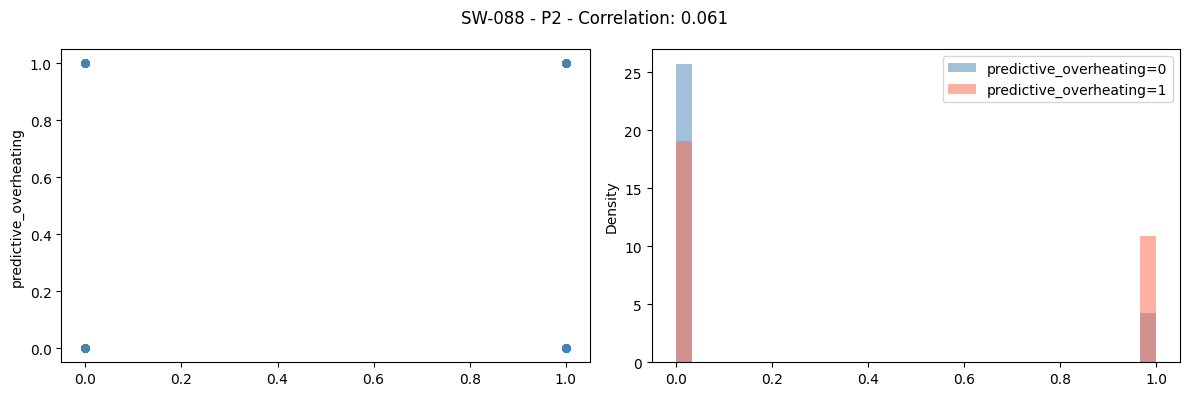

CPU times: user 9.55 s, sys: 2.25 s, total: 11.8 s
Wall time: 1min 21s


In [47]:
%%time

alarm_corr = correlations(df_final_088, useful_sensors, "predictive_overheating")

#top_alarm_corr = alarm_corr.head(5)[['Sensors', 'Correlations']].to_dict('records')
top_alarm_corr = alarm_corr.head(10)['Sensors'].tolist()

plot_correlations(df_final_088, "predictive_overheating", top_alarm_corr, alarm_corr, 'SW-088')

In [55]:
df_final_088.where( (col("S8")==1) & (col("SA3")==1) & (col("S101")>=14) & (col("predictive_overheating")==0)).count() # & (col("SA3")==1)

5229

In [54]:
df_final_088.where( (col("S8")==1) & (col("SA3")==1) & (col("S101")>=14) & (col("predictive_overheating")==1)).count() #  & (col("SA3")==1)

4

### Random forest su predictive flag anomaly

In [90]:
%%time

vector_to_drop = ['A5', 'A9', 'ComError', 'overheating', 'flag_anomaly']

sensors_forest_pred_allarm = [s for s in useful_sensors if s not in vector_to_drop]

model, train_preds, test_preds, test_accuracy = run_random_forest(df_final088, feature_cols=sensors_forest_pred_allarm, label_col="predictive_flag_anomaly", n_trees = 120, max_depth = 10, test_fraction=0.33333)

test_preds.select('flag_anomaly', 'prediction', 'probability').show(10, truncate = 0)

Training on 127904 rows, testing on 63901 rows


25/08/21 17:38:20 WARN DAGScheduler: Broadcasting large task binary with size 1465.6 KiB
25/08/21 17:38:25 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/08/21 17:38:32 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/08/21 17:38:38 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
25/08/21 17:38:45 WARN DAGScheduler: Broadcasting large task binary with size 7.9 MiB
25/08/21 17:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1164.8 KiB
25/08/21 17:39:17 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
                                                                                

RandomForest trained with 120 trees, maxDepth=10
Test Accuracy = 0.9841

Feature Importances:
S9: 0.0362
S81: 0.0344
S154: 0.0344
S39: 0.0338
S166: 0.0328
S109: 0.0317
S40: 0.0306
S83: 0.0299
S100: 0.0291
S138: 0.0290
S41: 0.0283
S157: 0.0278
S140: 0.0278
S97: 0.0271
S101: 0.0264
S180: 0.0250
S47: 0.0244
S126: 0.0240
S107: 0.0238
S102: 0.0237
S46: 0.0225
S124: 0.0223
S164: 0.0214
S158: 0.0204
S159: 0.0203
S90: 0.0188
S86: 0.0186
S5: 0.0162
S10: 0.0145
S137: 0.0144
S129: 0.0143
S128: 0.0137
S80: 0.0129
S72: 0.0124
S71: 0.0111
S125: 0.0110
S143: 0.0106
S3: 0.0098
S37: 0.0097
S122: 0.0096
S73: 0.0094
S147: 0.0086
S202: 0.0066
S203: 0.0060
S178: 0.0054
S179: 0.0047
S181: 0.0046
S6: 0.0043
S118: 0.0042
S206: 0.0042
P16: 0.0041
S205: 0.0041
S117: 0.0041
S70: 0.0041
SA9: 0.0037
S25: 0.0031
S130: 0.0030
S123: 0.0028
P10: 0.0028
S169: 0.0024
P2: 0.0021
SA1: 0.0019
S170: 0.0018
SA11: 0.0017
S112: 0.0016
S171: 0.0014
S113: 0.0014
S114: 0.0014
S201: 0.0013
S53: 0.0012
S172: 0.0011
S94: 0.0011
S7: 

25/08/21 17:39:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/08/21 17:39:32 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
[Stage 12278:=========================================>             (3 + 1) / 4]

+------------+----------+-----------------------------------------+
|flag_anomaly|prediction|probability                              |
+------------+----------+-----------------------------------------+
|0           |0.0       |[0.9992715865224766,7.284134775234509E-4]|
|0           |0.0       |[0.9992715865224766,7.284134775234509E-4]|
|0           |0.0       |[0.9992592699080298,7.407300919702641E-4]|
|0           |0.0       |[0.9992094941949214,7.905058050786124E-4]|
|0           |0.0       |[0.9992094941949214,7.905058050786124E-4]|
|0           |0.0       |[0.9992094941949214,7.905058050786124E-4]|
|0           |0.0       |[0.9992094941949214,7.905058050786124E-4]|
|0           |0.0       |[0.9992118577882084,7.881422117916856E-4]|
|0           |0.0       |[0.9991824419456641,8.175580543358878E-4]|
|0           |0.0       |[0.9991824419456641,8.175580543358878E-4]|
+------------+----------+-----------------------------------------+
only showing top 10 rows

CPU times: user 121 ms

25/08/21 17:40:38 ERROR TaskSchedulerImpl: Lost executor 2 on 10.67.22.135: Command exited with code 137


25/08/23 11:05:39 WARN DAGScheduler: Broadcasting large task binary with size 1447.2 KiB
25/08/23 11:05:41 WARN DAGScheduler: Broadcasting large task binary with size 2.2 MiB
25/08/23 11:05:44 WARN DAGScheduler: Broadcasting large task binary with size 3.5 MiB
25/08/23 11:05:47 WARN DAGScheduler: Broadcasting large task binary with size 5.4 MiB
25/08/23 11:05:51 WARN DAGScheduler: Broadcasting large task binary with size 7.8 MiB
25/08/23 11:05:54 WARN DAGScheduler: Broadcasting large task binary with size 1135.4 KiB
25/08/23 11:06:15 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
                                                                                


=== SAMPLE PREDICTIONS ===


25/08/23 11:06:28 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
                                                                                

+-----------------------+----------+---------------------+
|predictive_flag_anomaly|prediction|prob_rf              |
+-----------------------+----------+---------------------+
|0                      |0.0       |0.0055710920575165876|
|0                      |0.0       |0.004578903373246692 |
|0                      |0.0       |0.0019875571443571396|
|0                      |0.0       |0.004847923392773682 |
|0                      |0.0       |0.002817690144246578 |
|0                      |0.0       |0.002705332103021474 |
|0                      |0.0       |0.002673411179287716 |
|0                      |0.0       |0.0013599465007854594|
|0                      |0.0       |0.002782264183588096 |
|0                      |0.0       |0.00238141817255083  |
+-----------------------+----------+---------------------+
only showing top 10 rows



25/08/23 11:06:35 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
25/08/23 11:06:38 WARN DAGScheduler: Broadcasting large task binary with size 4.5 MiB
                                                                                

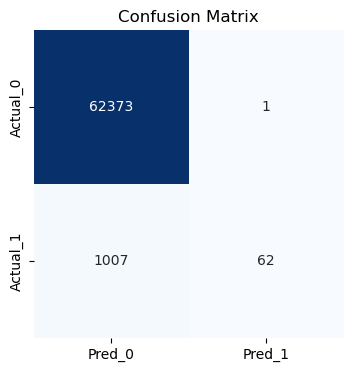

25/08/23 11:06:45 WARN DAGScheduler: Broadcasting large task binary with size 4.4 MiB
                                                                                


=== RANDOM FOREST PERFORMANCE ===
{'accuracy': 0.9841117223334331, 'precision': 0.9841269841269841, 'auc': 0.9821260090651454}


AnalysisException: [UNRESOLVED_COLUMN.WITH_SUGGESTION] A column or function parameter with name `S109` cannot be resolved. Did you mean one of the following? [`prob_rf`, `features`, `prediction`, `probability`, `rawPrediction`].;
'Project ['S109, 'S126, 'S5, prediction#290278]
+- Project [features#289989, predictive_flag_anomaly#223577, rawPrediction#290232, probability#290239, prediction#290250 AS prediction#290278, prob_rf#290271]
   +- Project [features#289989, predictive_flag_anomaly#223577, rawPrediction#290232, probability#290239, prediction#290250, <lambda>(probability#290239)#290270 AS prob_rf#290271]
      +- Project [features#289989, predictive_flag_anomaly#223577, rawPrediction#290232, probability#290239, UDF(rawPrediction#290232) AS prediction#290250]
         +- Project [features#289989, predictive_flag_anomaly#223577, rawPrediction#290232, UDF(rawPrediction#290232) AS probability#290239]
            +- Project [features#289989, predictive_flag_anomaly#223577, UDF(features#289989) AS rawPrediction#290232]
               +- Sample 0.66667, 1.0, false, 42
                  +- Sort [features#289989 ASC NULLS FIRST, predictive_flag_anomaly#223577 ASC NULLS FIRST], false
                     +- Project [features#289989, predictive_flag_anomaly#223577]
                        +- Project [when#1L, hwid#0, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S107#25, S109#27, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S151#51, S154#52, S157#53, S158#54, S159#55, S164#58, S166#60, S169#62, S170#64, S171#65, S172#66, S173#67, S174#68, S178#71, S179#72, S180#73, S181#74, S183#75, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S35#88, S37#89, S39#90, S40#91, S41#92, S46#96, S47#97, S5#99, S53#101, S55#103, S6#106, S64#108, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA2#128, SA3#129, SA5#131, SA6#132, SA7#133, SA9#135, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, predictive_flag_anomaly#223577, UDF(struct(P1, P1#7, P10, P10#8, P15_double_VectorAssembler_327c1d6fc6c0, cast(P15#9 as double), P16, P16#10, P17, P17#11, P18, P18#12, P2_double_VectorAssembler_327c1d6fc6c0, cast(P2#13 as double), P5, P5#14, P6, P6#15, P7, P7#16, P8, P8#17, P9, P9#18, S1_double_VectorAssembler_327c1d6fc6c0, cast(S1#19 as double), S10, S10#20, S100, S100#21, S101, S101#22, S102, S102#23, S107, S107#25, S109, S109#27, S112_double_VectorAssembler_327c1d6fc6c0, cast(S112#30 as double), S113_double_VectorAssembler_327c1d6fc6c0, cast(S113#31 as double), S114_double_VectorAssembler_327c1d6fc6c0, cast(S114#32 as double), S115_double_VectorAssembler_327c1d6fc6c0, cast(S115#33 as double), S117_double_VectorAssembler_327c1d6fc6c0, cast(S117#34 as double), S118_double_VectorAssembler_327c1d6fc6c0, cast(S118#35 as double), S122, S122#36, S123, S123#37, S124, S124#38, S125, S125#39, S126, S126#40, S127_double_VectorAssembler_327c1d6fc6c0, cast(S127#41 as double), S128, S128#42, S129, S129#43, S130, S130#44, S137, S137#45, S138, S138#46, S140, S140#47, S143, S143#48, S147, S147#49, S151, S151#51, S154, S154#52, S157, S157#53, S158, S158#54, S159, S159#55, S164, S164#58, S166, S166#60, S169_double_VectorAssembler_327c1d6fc6c0, cast(S169#62 as double), S170_double_VectorAssembler_327c1d6fc6c0, cast(S170#64 as double), S171_double_VectorAssembler_327c1d6fc6c0, cast(S171#65 as double), S172_double_VectorAssembler_327c1d6fc6c0, cast(S172#66 as double), S173_double_VectorAssembler_327c1d6fc6c0, cast(S173#67 as double), S174_double_VectorAssembler_327c1d6fc6c0, cast(S174#68 as double), S178, S178#71, S179, S179#72, S180, S180#73, S181, S181#74, S183_double_VectorAssembler_327c1d6fc6c0, cast(S183#75 as double), S2, S2#77, S201, S201#78, S202, S202#79, S203, S203#80, S204, S204#81, S205, S205#82, S206, S206#83, S25_double_VectorAssembler_327c1d6fc6c0, cast(S25#84 as double), S3, S3#85, S33_double_VectorAssembler_327c1d6fc6c0, cast(S33#86 as double), S35_double_VectorAssembler_327c1d6fc6c0, cast(S35#88 as double), S37, S37#89, S39, S39#90, S40, S40#91, S41, S41#92, S46, S46#96, S47, S47#97, S5, S5#99, S53_double_VectorAssembler_327c1d6fc6c0, cast(S53#101 as double), S55_double_VectorAssembler_327c1d6fc6c0, cast(S55#103 as double), S6, S6#106, S64_double_VectorAssembler_327c1d6fc6c0, cast(S64#108 as double), S7_double_VectorAssembler_327c1d6fc6c0, cast(S7#110 as double), S70, S70#111, S71, S71#112, S72, S72#113, S73, S73#114, S8_double_VectorAssembler_327c1d6fc6c0, cast(S8#115 as double), S80, S80#116, S81, S81#117, S83, S83#118, S86, S86#119, S9, S9#120, S90, S90#121, S94, S94#122, S97, S97#123, SA1, SA1#124, SA10, SA10#125, SA11, SA11#126, SA2, SA2#128, SA3_double_VectorAssembler_327c1d6fc6c0, cast(SA3#129 as double), SA5, SA5#131, SA6, SA6#132, SA7, SA7#133, SA9, SA9#135)) AS features#289989]
                           +- Project [when#1L, hwid#0, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S107#25, S109#27, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S151#51, S154#52, S157#53, S158#54, S159#55, S164#58, S166#60, S169#62, S170#64, S171#65, S172#66, S173#67, S174#68, S178#71, S179#72, S180#73, S181#74, S183#75, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S35#88, S37#89, S39#90, S40#91, S41#92, S46#96, S47#97, S5#99, S53#101, S55#103, S6#106, S64#108, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA2#128, SA3#129, SA5#131, SA6#132, SA7#133, SA9#135, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, predictive_flag_anomaly#223577]
                              +- Join LeftOuter, (when#1L = when#223707L)
                                 :- Project [when#1L, hwid#0, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S107#25, S109#27, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S151#51, S154#52, S157#53, S158#54, S159#55, S164#58, S166#60, S169#62, S170#64, S171#65, S172#66, S173#67, S174#68, S178#71, S179#72, S180#73, S181#74, S183#75, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S35#88, S37#89, S39#90, S40#91, S41#92, S46#96, S47#97, S5#99, S53#101, S55#103, S6#106, S64#108, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA2#128, SA3#129, SA5#131, SA6#132, SA7#133, SA9#135, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844]
                                 :  +- Join LeftOuter, (when#1L = when#221973L)
                                 :     :- Project [when#1L, hwid#0, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S107#25, S109#27, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S151#51, S154#52, S157#53, S158#54, S159#55, S164#58, S166#60, S169#62, S170#64, S171#65, S172#66, S173#67, S174#68, S178#71, S179#72, S180#73, S181#74, S183#75, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S35#88, S37#89, S39#90, S40#91, S41#92, S46#96, S47#97, S5#99, S53#101, S55#103, S6#106, S64#108, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA2#128, SA3#129, SA5#131, SA6#132, SA7#133, SA9#135, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L, flag_anomaly#7392, overheating#21554]
                                 :     :  +- Join LeftOuter, (when#1L = when#21854L)
                                 :     :     :- Project [when#1L, hwid#0, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S107#25, S109#27, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S151#51, S154#52, S157#53, S158#54, S159#55, S164#58, S166#60, S169#62, S170#64, S171#65, S172#66, S173#67, S174#68, S178#71, S179#72, S180#73, S181#74, S183#75, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S35#88, S37#89, S39#90, S40#91, S41#92, S46#96, S47#97, S5#99, S53#101, S55#103, S6#106, S64#108, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA2#128, SA3#129, SA5#131, SA6#132, SA7#133, SA9#135, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L, flag_anomaly#7392]
                                 :     :     :  +- Join LeftOuter, (when#1L = when#20469L)
                                 :     :     :     :- Filter (hwid#0 = SW-088)
                                 :     :     :     :  +- Project [hwid#0, when#1L, window_start#2, window_end#3, A5#284, A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S107#25, S109#27, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S151#51, S154#52, S157#53, S158#54, S159#55, S164#58, S166#60, S169#62, S170#64, S171#65, S172#66, S173#67, S174#68, S178#71, S179#72, S180#73, S181#74, S183#75, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S35#88, S37#89, S39#90, S40#91, S41#92, S46#96, S47#97, S5#99, S53#101, S55#103, S6#106, S64#108, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA2#128, SA3#129, SA5#131, SA6#132, SA7#133, SA9#135, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L]
                                 :     :     :     :     +- Project [hwid#0, when#1L, window_start#2, window_end#3, A5#284, cast(A9#5 as int) AS A9#428, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S106#24, S107#25, S108#26, S109#27, S11#28, S110#29, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S15#50, S151#51, S154#52, S157#53, S158#54, S159#55, S16#56, S163#57, S164#58, S165#59, S166#60, S167#61, S169#62, S17#63, S170#64, S171#65, S172#66, S173#67, S174#68, S175#69, S176#70, S178#71, S179#72, S180#73, S181#74, S183#75, S19#76, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S34#87, S35#88, S37#89, S39#90, S40#91, S41#92, S42#93, S43#94, S45#95, S46#96, S47#97, S49#98, S5#99, S50#100, S53#101, S54#102, S55#103, S56#104, S57#105, S6#106, S63#107, S64#108, S69#109, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA12#127, SA2#128, SA3#129, SA4#130, SA5#131, SA6#132, SA7#133, SA8#134, SA9#135, SW#136, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L]
                                 :     :     :     :        +- Project [hwid#0, when#1L, window_start#2, window_end#3, cast(A5#4 as int) AS A5#284, A9#5, ComError#6, P1#7, P10#8, P15#9, P16#10, P17#11, P18#12, P2#13, P5#14, P6#15, P7#16, P8#17, P9#18, S1#19, S10#20, S100#21, S101#22, S102#23, S106#24, S107#25, S108#26, S109#27, S11#28, S110#29, S112#30, S113#31, S114#32, S115#33, S117#34, S118#35, S122#36, S123#37, S124#38, S125#39, S126#40, S127#41, S128#42, S129#43, S130#44, S137#45, S138#46, S140#47, S143#48, S147#49, S15#50, S151#51, S154#52, S157#53, S158#54, S159#55, S16#56, S163#57, S164#58, S165#59, S166#60, S167#61, S169#62, S17#63, S170#64, S171#65, S172#66, S173#67, S174#68, S175#69, S176#70, S178#71, S179#72, S180#73, S181#74, S183#75, S19#76, S2#77, S201#78, S202#79, S203#80, S204#81, S205#82, S206#83, S25#84, S3#85, S33#86, S34#87, S35#88, S37#89, S39#90, S40#91, S41#92, S42#93, S43#94, S45#95, S46#96, S47#97, S49#98, S5#99, S50#100, S53#101, S54#102, S55#103, S56#104, S57#105, S6#106, S63#107, S64#108, S69#109, S7#110, S70#111, S71#112, S72#113, S73#114, S8#115, S80#116, S81#117, S83#118, S86#119, S9#120, S90#121, S94#122, S97#123, SA1#124, SA10#125, SA11#126, SA12#127, SA2#128, SA3#129, SA4#130, SA5#131, SA6#132, SA7#133, SA8#134, SA9#135, SW#136, Prev_TimeStamp#137, Next_TimeStamp#138, PrevDiff#139, NextDiff#140, BlockID#141L]
                                 :     :     :     :           +- Relation [hwid#0,when#1L,window_start#2,window_end#3,A5#4,A9#5,ComError#6,P1#7,P10#8,P15#9,P16#10,P17#11,P18#12,P2#13,P5#14,P6#15,P7#16,P8#17,P9#18,S1#19,S10#20,S100#21,S101#22,S102#23,S106#24,S107#25,S108#26,S109#27,S11#28,S110#29,S112#30,S113#31,S114#32,S115#33,S117#34,S118#35,S122#36,S123#37,S124#38,S125#39,S126#40,S127#41,S128#42,S129#43,S130#44,S137#45,S138#46,S140#47,S143#48,S147#49,S15#50,S151#51,S154#52,S157#53,S158#54,S159#55,S16#56,S163#57,S164#58,S165#59,S166#60,S167#61,S169#62,S17#63,S170#64,S171#65,S172#66,S173#67,S174#68,S175#69,S176#70,S178#71,S179#72,S180#73,S181#74,S183#75,S19#76,S2#77,S201#78,S202#79,S203#80,S204#81,S205#82,S206#83,S25#84,S3#85,S33#86,S34#87,S35#88,S37#89,S39#90,S40#91,S41#92,S42#93,S43#94,S45#95,S46#96,S47#97,S49#98,S5#99,S50#100,S53#101,S54#102,S55#103,S56#104,S57#105,S6#106,S63#107,S64#108,S69#109,S7#110,S70#111,S71#112,S72#113,S73#114,S8#115,S80#116,S81#117,S83#118,S86#119,S9#120,S90#121,S94#122,S97#123,SA1#124,SA10#125,SA11#126,SA12#127,SA2#128,SA3#129,SA4#130,SA5#131,SA6#132,SA7#133,SA8#134,SA9#135,SW#136,Prev_TimeStamp#137,Next_TimeStamp#138,PrevDiff#139,NextDiff#140,BlockID#141L] parquet
                                 :     :     :     +- Project [when#20469L, flag_anomaly#7392]
                                 :     :     :        +- Project [BlockID#20609L, when#20469L, S117#20502, S118#20503, S169#20530, S170#20532, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, flag_anomaly#7392]
                                 :     :     :           +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L, CASE WHEN (((flag_S117#7242 OR flag_S118#7243) OR flag_S169#7244) OR flag_S170#7245) THEN 1 ELSE 0 END AS flag_anomaly#7392]
                                 :     :     :              +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((nextID_S117#7084L = prevID_S117#6930L) AND (nextID_S117#7084L > cast(0 as bigint))) THEN true ELSE flag_S117#6772 END AS flag_S117#7242, CASE WHEN ((nextID_S118#7085L = prevID_S118#6931L) AND (nextID_S118#7085L > cast(0 as bigint))) THEN true ELSE flag_S118#6773 END AS flag_S118#7243, CASE WHEN ((nextID_S169#7086L = prevID_S169#6932L) AND (nextID_S169#7086L > cast(0 as bigint))) THEN true ELSE flag_S169#6774 END AS flag_S169#7244, CASE WHEN ((nextID_S170#7087L = prevID_S170#6933L) AND (nextID_S170#7087L > cast(0 as bigint))) THEN true ELSE flag_S170#6775 END AS flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                 :     :     :                 +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                 :     :     :                    +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, _we0#7088, _we1#7089L, _we2#7090, _we3#7091L, _we4#7092, _we5#7093L, _we6#7094, _we7#7095L, CASE WHEN _we0#7088 THEN _we1#7089L ELSE cast(null as bigint) END AS nextID_S117#7084L, CASE WHEN _we2#7090 THEN _we3#7091L ELSE cast(null as bigint) END AS nextID_S118#7085L, CASE WHEN _we4#7092 THEN _we5#7093L ELSE cast(null as bigint) END AS nextID_S169#7086L, CASE WHEN _we6#7094 THEN _we7#7095L ELSE cast(null as bigint) END AS nextID_S170#7087L]
                                 :     :     :                       +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we0#7088, min(anomalyID_S117#3877L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we1#7089L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we2#7090, min(anomalyID_S118#4658L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we3#7091L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we4#7092, min(anomalyID_S169#5441L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we5#7093L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we6#7094, min(anomalyID_S170#6226L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we7#7095L], [BlockID#20609L], [when#20469L ASC NULLS FIRST]
                                 :     :     :                          +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                 :     :     :                             +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                 :     :     :                                +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, _we0#6934, _we1#6935L, _we2#6936, _we3#6937L, _we4#6938, _we5#6939L, _we6#6940, _we7#6941L, CASE WHEN _we0#6934 THEN _we1#6935L ELSE cast(null as bigint) END AS prevID_S117#6930L, CASE WHEN _we2#6936 THEN _we3#6937L ELSE cast(null as bigint) END AS prevID_S118#6931L, CASE WHEN _we4#6938 THEN _we5#6939L ELSE cast(null as bigint) END AS prevID_S169#6932L, CASE WHEN _we6#6940 THEN _we7#6941L ELSE cast(null as bigint) END AS prevID_S170#6933L]
                                 :     :     :                                   +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we0#6934, max(anomalyID_S117#3877L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we1#6935L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we2#6936, max(anomalyID_S118#4658L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we3#6937L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we4#6938, max(anomalyID_S169#5441L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we5#6939L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we6#6940, max(anomalyID_S170#6226L) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we7#6941L], [BlockID#20609L], [when#20469L ASC NULLS FIRST]
                                 :     :     :                                      +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775]
                                 :     :     :                                         +- Sort [BlockID#20609L ASC NULLS FIRST, when#20469L ASC NULLS FIRST], true
                                 :     :     :                                            +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((count_S117#6634L >= cast(8 as bigint)) AND (anomalyID_S117#3877L > cast(0 as bigint))) THEN true ELSE false END AS flag_S117#6772, CASE WHEN ((count_S118#6635L >= cast(8 as bigint)) AND (anomalyID_S118#4658L > cast(0 as bigint))) THEN true ELSE false END AS flag_S118#6773, CASE WHEN ((count_S169#6636L >= cast(8 as bigint)) AND (anomalyID_S169#5441L > cast(0 as bigint))) THEN true ELSE false END AS flag_S169#6774, CASE WHEN ((count_S170#6637L >= cast(8 as bigint)) AND (anomalyID_S170#6226L > cast(0 as bigint))) THEN true ELSE false END AS flag_S170#6775]
                                 :     :     :                                               +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                 :     :     :                                                  +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                 :     :     :                                                     +- Window [count(1) windowspecdefinition(BlockID#20609L, anomalyID_S170#6226L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S170#6637L], [BlockID#20609L, anomalyID_S170#6226L]
                                 :     :     :                                                        +- Window [count(1) windowspecdefinition(BlockID#20609L, anomalyID_S169#5441L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S169#6636L], [BlockID#20609L, anomalyID_S169#5441L]
                                 :     :     :                                                           +- Window [count(1) windowspecdefinition(BlockID#20609L, anomalyID_S118#4658L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S118#6635L], [BlockID#20609L, anomalyID_S118#4658L]
                                 :     :     :                                                              +- Window [count(1) windowspecdefinition(BlockID#20609L, anomalyID_S117#3877L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S117#6634L], [BlockID#20609L, anomalyID_S117#3877L]
                                 :     :     :                                                                 +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :     :     :                                                                    +- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :     :     :                                                                       +- Join LeftOuter, ((BlockID#20609L = BlockID#6498L) AND (when#20469L = when#6358L))
                                 :     :     :                                                                          :- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L]
                                 :     :     :                                                                          :  +- Join LeftOuter, ((BlockID#20609L = BlockID#5713L) AND (when#20469L = when#5573L))
                                 :     :     :                                                                          :     :- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L]
                                 :     :     :                                                                          :     :  +- Join LeftOuter, ((BlockID#20609L = BlockID#4930L) AND (when#20469L = when#4790L))
                                 :     :     :                                                                          :     :     :- Project [BlockID#20609L, when#20469L, hwid#20468, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L]
                                 :     :     :                                                                          :     :     :  +- Join LeftOuter, ((BlockID#20609L = BlockID#4149L) AND (when#20469L = when#4009L))
                                 :     :     :                                                                          :     :     :     :- Project [hwid#20468, when#20469L, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, BlockID#20609L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#20502) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#20503) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#20530) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#20532) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :     :     :                                                                          :     :     :     :  +- Project [hwid#20468, when#20469L, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, BlockID#20609L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :     :     :     :     +- Project [hwid#20468, when#20469L, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, BlockID#20609L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :     :     :     :        +- Window [lag(S117#20502, -1, null) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#20503, -1, null) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#20530, -1, null) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#20532, -1, null) windowspecdefinition(BlockID#20609L, when#20469L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#20609L], [when#20469L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :     :     :           +- Project [hwid#20468, when#20469L, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, BlockID#20609L]
                                 :     :     :                                                                          :     :     :     :              +- Filter (hwid#20468 = SW-088)
                                 :     :     :                                                                          :     :     :     :                 +- Project [hwid#20468, when#20469L, window_start#20470, window_end#20471, A5#284, A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S107#20493, S109#20495, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S164#20526, S166#20528, S169#20530, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S46#20564, S47#20565, S5#20567, S53#20569, S55#20571, S6#20574, S64#20576, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA2#20596, SA3#20597, SA5#20599, SA6#20600, SA7#20601, SA9#20603, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, BlockID#20609L]
                                 :     :     :                                                                          :     :     :     :                    +- Project [hwid#20468, when#20469L, window_start#20470, window_end#20471, A5#284, cast(A9#20473 as int) AS A9#428, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S106#20492, S107#20493, S108#20494, S109#20495, S11#20496, S110#20497, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S15#20518, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S16#20524, S163#20525, S164#20526, S165#20527, S166#20528, S167#20529, S169#20530, S17#20531, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S175#20537, S176#20538, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S19#20544, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S34#20555, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S42#20561, S43#20562, S45#20563, S46#20564, S47#20565, S49#20566, S5#20567, S50#20568, S53#20569, S54#20570, S55#20571, S56#20572, S57#20573, S6#20574, S63#20575, S64#20576, S69#20577, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA12#20595, SA2#20596, SA3#20597, SA4#20598, SA5#20599, SA6#20600, SA7#20601, SA8#20602, SA9#20603, SW#20604, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, BlockID#20609L]
                                 :     :     :                                                                          :     :     :     :                       +- Project [hwid#20468, when#20469L, window_start#20470, window_end#20471, cast(A5#20472 as int) AS A5#284, A9#20473, ComError#20474, P1#20475, P10#20476, P15#20477, P16#20478, P17#20479, P18#20480, P2#20481, P5#20482, P6#20483, P7#20484, P8#20485, P9#20486, S1#20487, S10#20488, S100#20489, S101#20490, S102#20491, S106#20492, S107#20493, S108#20494, S109#20495, S11#20496, S110#20497, S112#20498, S113#20499, S114#20500, S115#20501, S117#20502, S118#20503, S122#20504, S123#20505, S124#20506, S125#20507, S126#20508, S127#20509, S128#20510, S129#20511, S130#20512, S137#20513, S138#20514, S140#20515, S143#20516, S147#20517, S15#20518, S151#20519, S154#20520, S157#20521, S158#20522, S159#20523, S16#20524, S163#20525, S164#20526, S165#20527, S166#20528, S167#20529, S169#20530, S17#20531, S170#20532, S171#20533, S172#20534, S173#20535, S174#20536, S175#20537, S176#20538, S178#20539, S179#20540, S180#20541, S181#20542, S183#20543, S19#20544, S2#20545, S201#20546, S202#20547, S203#20548, S204#20549, S205#20550, S206#20551, S25#20552, S3#20553, S33#20554, S34#20555, S35#20556, S37#20557, S39#20558, S40#20559, S41#20560, S42#20561, S43#20562, S45#20563, S46#20564, S47#20565, S49#20566, S5#20567, S50#20568, S53#20569, S54#20570, S55#20571, S56#20572, S57#20573, S6#20574, S63#20575, S64#20576, S69#20577, S7#20578, S70#20579, S71#20580, S72#20581, S73#20582, S8#20583, S80#20584, S81#20585, S83#20586, S86#20587, S9#20588, S90#20589, S94#20590, S97#20591, SA1#20592, SA10#20593, SA11#20594, SA12#20595, SA2#20596, SA3#20597, SA4#20598, SA5#20599, SA6#20600, SA7#20601, SA8#20602, SA9#20603, SW#20604, Prev_TimeStamp#20605, Next_TimeStamp#20606, PrevDiff#20607, NextDiff#20608, BlockID#20609L]
                                 :     :     :                                                                          :     :     :     :                          +- Relation [hwid#20468,when#20469L,window_start#20470,window_end#20471,A5#20472,A9#20473,ComError#20474,P1#20475,P10#20476,P15#20477,P16#20478,P17#20479,P18#20480,P2#20481,P5#20482,P6#20483,P7#20484,P8#20485,P9#20486,S1#20487,S10#20488,S100#20489,S101#20490,S102#20491,S106#20492,S107#20493,S108#20494,S109#20495,S11#20496,S110#20497,S112#20498,S113#20499,S114#20500,S115#20501,S117#20502,S118#20503,S122#20504,S123#20505,S124#20506,S125#20507,S126#20508,S127#20509,S128#20510,S129#20511,S130#20512,S137#20513,S138#20514,S140#20515,S143#20516,S147#20517,S15#20518,S151#20519,S154#20520,S157#20521,S158#20522,S159#20523,S16#20524,S163#20525,S164#20526,S165#20527,S166#20528,S167#20529,S169#20530,S17#20531,S170#20532,S171#20533,S172#20534,S173#20535,S174#20536,S175#20537,S176#20538,S178#20539,S179#20540,S180#20541,S181#20542,S183#20543,S19#20544,S2#20545,S201#20546,S202#20547,S203#20548,S204#20549,S205#20550,S206#20551,S25#20552,S3#20553,S33#20554,S34#20555,S35#20556,S37#20557,S39#20558,S40#20559,S41#20560,S42#20561,S43#20562,S45#20563,S46#20564,S47#20565,S49#20566,S5#20567,S50#20568,S53#20569,S54#20570,S55#20571,S56#20572,S57#20573,S6#20574,S63#20575,S64#20576,S69#20577,S7#20578,S70#20579,S71#20580,S72#20581,S73#20582,S8#20583,S80#20584,S81#20585,S83#20586,S86#20587,S9#20588,S90#20589,S94#20590,S97#20591,SA1#20592,SA10#20593,SA11#20594,SA12#20595,SA2#20596,SA3#20597,SA4#20598,SA5#20599,SA6#20600,SA7#20601,SA8#20602,SA9#20603,SW#20604,Prev_TimeStamp#20605,Next_TimeStamp#20606,PrevDiff#20607,NextDiff#20608,BlockID#20609L] parquet
                                 :     :     :                                                                          :     :     :     +- Project [BlockID#4149L, when#4009L, startGroup_S117#3749, anomalyID_S117#3877L]
                                 :     :     :                                                                          :     :     :        +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L]
                                 :     :     :                                                                          :     :     :           +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L, anomalyID_S117#3877L]
                                 :     :     :                                                                          :     :     :              +- Window [sum(startGroup_S117#3749) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S117#3877L], [BlockID#4149L], [when#4009L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :     :                 +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                 :     :     :                                                                          :     :     :                    +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                 :     :     :                                                                          :     :     :                       +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, _we0#3750L, CASE WHEN ((when#4009L - _we0#3750L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S117#3749]
                                 :     :     :                                                                          :     :     :                          +- Window [lag(when#4009L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#3750L], [BlockID#4149L], [when#4009L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :     :                             +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                 :     :     :                                                                          :     :     :                                +- Filter (((didSwitch_S117#3368 = 1) AND CASE WHEN (S117#4042 = 1) THEN theres0Before_S117#3495 ELSE true END) AND CASE WHEN (S117#4042 = 0) THEN theres0After_S117#3622 ELSE true END)
                                 :     :     :                                                                          :     :     :                                   +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                 :     :     :                                                                          :     :     :                                      +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, _w0#3623, _we0#3624L, (_we0#3624L > cast(0 as bigint)) AS theres0After_S117#3622]
                                 :     :     :                                                                          :     :     :                                         +- Window [count_if(_w0#3623) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#3624L], [BlockID#4149L], [when#4009L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :     :                                            +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, (S117#4042 = 0) AS _w0#3623]
                                 :     :     :                                                                          :     :     :                                               +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495]
                                 :     :     :                                                                          :     :     :                                                  +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#3496, _we0#3497L, (_we0#3497L > cast(0 as bigint)) AS theres0Before_S117#3495]
                                 :     :     :                                                                          :     :     :                                                     +- Window [count_if(_w0#3496) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#3497L], [BlockID#4149L], [when#4009L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :     :                                                        +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S117#4042 = 0) AS _w0#3496]
                                 :     :     :                                                                          :     :     :                                                           +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#4042) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#4043) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#4070) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#4072) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :     :     :                                                                          :     :     :                                                              +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :     :     :                                                                 +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :     :     :                                                                    +- Window [lag(S117#4042, -1, null) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#4043, -1, null) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#4070, -1, null) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#4072, -1, null) windowspecdefinition(BlockID#4149L, when#4009L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#4149L], [when#4009L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :     :                                                                       +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L]
                                 :     :     :                                                                          :     :     :                                                                          +- Filter (hwid#4008 = SW-088)
                                 :     :     :                                                                          :     :     :                                                                             +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S107#4033, S109#4035, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S164#4066, S166#4068, S169#4070, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S46#4104, S47#4105, S5#4107, S53#4109, S55#4111, S6#4114, S64#4116, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA2#4136, SA3#4137, SA5#4139, SA6#4140, SA7#4141, SA9#4143, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L]
                                 :     :     :                                                                          :     :     :                                                                                +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, A5#284, cast(A9#4013 as int) AS A9#428, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S106#4032, S107#4033, S108#4034, S109#4035, S11#4036, S110#4037, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S15#4058, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S16#4064, S163#4065, S164#4066, S165#4067, S166#4068, S167#4069, S169#4070, S17#4071, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S175#4077, S176#4078, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S19#4084, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S34#4095, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S42#4101, S43#4102, S45#4103, S46#4104, S47#4105, S49#4106, S5#4107, S50#4108, S53#4109, S54#4110, S55#4111, S56#4112, S57#4113, S6#4114, S63#4115, S64#4116, S69#4117, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA12#4135, SA2#4136, SA3#4137, SA4#4138, SA5#4139, SA6#4140, SA7#4141, SA8#4142, SA9#4143, SW#4144, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L]
                                 :     :     :                                                                          :     :     :                                                                                   +- Project [hwid#4008, when#4009L, window_start#4010, window_end#4011, cast(A5#4012 as int) AS A5#284, A9#4013, ComError#4014, P1#4015, P10#4016, P15#4017, P16#4018, P17#4019, P18#4020, P2#4021, P5#4022, P6#4023, P7#4024, P8#4025, P9#4026, S1#4027, S10#4028, S100#4029, S101#4030, S102#4031, S106#4032, S107#4033, S108#4034, S109#4035, S11#4036, S110#4037, S112#4038, S113#4039, S114#4040, S115#4041, S117#4042, S118#4043, S122#4044, S123#4045, S124#4046, S125#4047, S126#4048, S127#4049, S128#4050, S129#4051, S130#4052, S137#4053, S138#4054, S140#4055, S143#4056, S147#4057, S15#4058, S151#4059, S154#4060, S157#4061, S158#4062, S159#4063, S16#4064, S163#4065, S164#4066, S165#4067, S166#4068, S167#4069, S169#4070, S17#4071, S170#4072, S171#4073, S172#4074, S173#4075, S174#4076, S175#4077, S176#4078, S178#4079, S179#4080, S180#4081, S181#4082, S183#4083, S19#4084, S2#4085, S201#4086, S202#4087, S203#4088, S204#4089, S205#4090, S206#4091, S25#4092, S3#4093, S33#4094, S34#4095, S35#4096, S37#4097, S39#4098, S40#4099, S41#4100, S42#4101, S43#4102, S45#4103, S46#4104, S47#4105, S49#4106, S5#4107, S50#4108, S53#4109, S54#4110, S55#4111, S56#4112, S57#4113, S6#4114, S63#4115, S64#4116, S69#4117, S7#4118, S70#4119, S71#4120, S72#4121, S73#4122, S8#4123, S80#4124, S81#4125, S83#4126, S86#4127, S9#4128, S90#4129, S94#4130, S97#4131, SA1#4132, SA10#4133, SA11#4134, SA12#4135, SA2#4136, SA3#4137, SA4#4138, SA5#4139, SA6#4140, SA7#4141, SA8#4142, SA9#4143, SW#4144, Prev_TimeStamp#4145, Next_TimeStamp#4146, PrevDiff#4147, NextDiff#4148, BlockID#4149L]
                                 :     :     :                                                                          :     :     :                                                                                      +- Relation [hwid#4008,when#4009L,window_start#4010,window_end#4011,A5#4012,A9#4013,ComError#4014,P1#4015,P10#4016,P15#4017,P16#4018,P17#4019,P18#4020,P2#4021,P5#4022,P6#4023,P7#4024,P8#4025,P9#4026,S1#4027,S10#4028,S100#4029,S101#4030,S102#4031,S106#4032,S107#4033,S108#4034,S109#4035,S11#4036,S110#4037,S112#4038,S113#4039,S114#4040,S115#4041,S117#4042,S118#4043,S122#4044,S123#4045,S124#4046,S125#4047,S126#4048,S127#4049,S128#4050,S129#4051,S130#4052,S137#4053,S138#4054,S140#4055,S143#4056,S147#4057,S15#4058,S151#4059,S154#4060,S157#4061,S158#4062,S159#4063,S16#4064,S163#4065,S164#4066,S165#4067,S166#4068,S167#4069,S169#4070,S17#4071,S170#4072,S171#4073,S172#4074,S173#4075,S174#4076,S175#4077,S176#4078,S178#4079,S179#4080,S180#4081,S181#4082,S183#4083,S19#4084,S2#4085,S201#4086,S202#4087,S203#4088,S204#4089,S205#4090,S206#4091,S25#4092,S3#4093,S33#4094,S34#4095,S35#4096,S37#4097,S39#4098,S40#4099,S41#4100,S42#4101,S43#4102,S45#4103,S46#4104,S47#4105,S49#4106,S5#4107,S50#4108,S53#4109,S54#4110,S55#4111,S56#4112,S57#4113,S6#4114,S63#4115,S64#4116,S69#4117,S7#4118,S70#4119,S71#4120,S72#4121,S73#4122,S8#4123,S80#4124,S81#4125,S83#4126,S86#4127,S9#4128,S90#4129,S94#4130,S97#4131,SA1#4132,SA10#4133,SA11#4134,SA12#4135,SA2#4136,SA3#4137,SA4#4138,SA5#4139,SA6#4140,SA7#4141,SA8#4142,SA9#4143,SW#4144,Prev_TimeStamp#4145,Next_TimeStamp#4146,PrevDiff#4147,NextDiff#4148,BlockID#4149L] parquet
                                 :     :     :                                                                          :     :     +- Project [BlockID#4930L, when#4790L, startGroup_S118#4530, anomalyID_S118#4658L]
                                 :     :     :                                                                          :     :        +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L]
                                 :     :     :                                                                          :     :           +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L, anomalyID_S118#4658L]
                                 :     :     :                                                                          :     :              +- Window [sum(startGroup_S118#4530) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S118#4658L], [BlockID#4930L], [when#4790L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :                 +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                 :     :     :                                                                          :     :                    +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                 :     :     :                                                                          :     :                       +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, _we0#4531L, CASE WHEN ((when#4790L - _we0#4531L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S118#4530]
                                 :     :     :                                                                          :     :                          +- Window [lag(when#4790L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#4531L], [BlockID#4930L], [when#4790L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :                             +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                 :     :     :                                                                          :     :                                +- Filter (((didSwitch_S118#3369 = 1) AND CASE WHEN (S118#4824 = 1) THEN theres0Before_S118#4276 ELSE true END) AND CASE WHEN (S118#4824 = 0) THEN theres0After_S118#4403 ELSE true END)
                                 :     :     :                                                                          :     :                                   +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                 :     :     :                                                                          :     :                                      +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, _w0#4404, _we0#4405L, (_we0#4405L > cast(0 as bigint)) AS theres0After_S118#4403]
                                 :     :     :                                                                          :     :                                         +- Window [count_if(_w0#4404) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#4405L], [BlockID#4930L], [when#4790L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :                                            +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, (S118#4824 = 0) AS _w0#4404]
                                 :     :     :                                                                          :     :                                               +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276]
                                 :     :     :                                                                          :     :                                                  +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#4277, _we0#4278L, (_we0#4278L > cast(0 as bigint)) AS theres0Before_S118#4276]
                                 :     :     :                                                                          :     :                                                     +- Window [count_if(_w0#4277) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#4278L], [BlockID#4930L], [when#4790L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :                                                        +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S118#4824 = 0) AS _w0#4277]
                                 :     :     :                                                                          :     :                                                           +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#4823) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#4824) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#4851) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#4853) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :     :     :                                                                          :     :                                                              +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :     :                                                                 +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :     :                                                                    +- Window [lag(S117#4823, -1, null) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#4824, -1, null) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#4851, -1, null) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#4853, -1, null) windowspecdefinition(BlockID#4930L, when#4790L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#4930L], [when#4790L ASC NULLS FIRST]
                                 :     :     :                                                                          :     :                                                                       +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L]
                                 :     :     :                                                                          :     :                                                                          +- Filter (hwid#4789 = SW-088)
                                 :     :     :                                                                          :     :                                                                             +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S107#4814, S109#4816, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S164#4847, S166#4849, S169#4851, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S46#4885, S47#4886, S5#4888, S53#4890, S55#4892, S6#4895, S64#4897, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA2#4917, SA3#4918, SA5#4920, SA6#4921, SA7#4922, SA9#4924, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L]
                                 :     :     :                                                                          :     :                                                                                +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, A5#284, cast(A9#4794 as int) AS A9#428, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S106#4813, S107#4814, S108#4815, S109#4816, S11#4817, S110#4818, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S15#4839, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S16#4845, S163#4846, S164#4847, S165#4848, S166#4849, S167#4850, S169#4851, S17#4852, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S175#4858, S176#4859, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S19#4865, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S34#4876, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S42#4882, S43#4883, S45#4884, S46#4885, S47#4886, S49#4887, S5#4888, S50#4889, S53#4890, S54#4891, S55#4892, S56#4893, S57#4894, S6#4895, S63#4896, S64#4897, S69#4898, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA12#4916, SA2#4917, SA3#4918, SA4#4919, SA5#4920, SA6#4921, SA7#4922, SA8#4923, SA9#4924, SW#4925, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L]
                                 :     :     :                                                                          :     :                                                                                   +- Project [hwid#4789, when#4790L, window_start#4791, window_end#4792, cast(A5#4793 as int) AS A5#284, A9#4794, ComError#4795, P1#4796, P10#4797, P15#4798, P16#4799, P17#4800, P18#4801, P2#4802, P5#4803, P6#4804, P7#4805, P8#4806, P9#4807, S1#4808, S10#4809, S100#4810, S101#4811, S102#4812, S106#4813, S107#4814, S108#4815, S109#4816, S11#4817, S110#4818, S112#4819, S113#4820, S114#4821, S115#4822, S117#4823, S118#4824, S122#4825, S123#4826, S124#4827, S125#4828, S126#4829, S127#4830, S128#4831, S129#4832, S130#4833, S137#4834, S138#4835, S140#4836, S143#4837, S147#4838, S15#4839, S151#4840, S154#4841, S157#4842, S158#4843, S159#4844, S16#4845, S163#4846, S164#4847, S165#4848, S166#4849, S167#4850, S169#4851, S17#4852, S170#4853, S171#4854, S172#4855, S173#4856, S174#4857, S175#4858, S176#4859, S178#4860, S179#4861, S180#4862, S181#4863, S183#4864, S19#4865, S2#4866, S201#4867, S202#4868, S203#4869, S204#4870, S205#4871, S206#4872, S25#4873, S3#4874, S33#4875, S34#4876, S35#4877, S37#4878, S39#4879, S40#4880, S41#4881, S42#4882, S43#4883, S45#4884, S46#4885, S47#4886, S49#4887, S5#4888, S50#4889, S53#4890, S54#4891, S55#4892, S56#4893, S57#4894, S6#4895, S63#4896, S64#4897, S69#4898, S7#4899, S70#4900, S71#4901, S72#4902, S73#4903, S8#4904, S80#4905, S81#4906, S83#4907, S86#4908, S9#4909, S90#4910, S94#4911, S97#4912, SA1#4913, SA10#4914, SA11#4915, SA12#4916, SA2#4917, SA3#4918, SA4#4919, SA5#4920, SA6#4921, SA7#4922, SA8#4923, SA9#4924, SW#4925, Prev_TimeStamp#4926, Next_TimeStamp#4927, PrevDiff#4928, NextDiff#4929, BlockID#4930L]
                                 :     :     :                                                                          :     :                                                                                      +- Relation [hwid#4789,when#4790L,window_start#4791,window_end#4792,A5#4793,A9#4794,ComError#4795,P1#4796,P10#4797,P15#4798,P16#4799,P17#4800,P18#4801,P2#4802,P5#4803,P6#4804,P7#4805,P8#4806,P9#4807,S1#4808,S10#4809,S100#4810,S101#4811,S102#4812,S106#4813,S107#4814,S108#4815,S109#4816,S11#4817,S110#4818,S112#4819,S113#4820,S114#4821,S115#4822,S117#4823,S118#4824,S122#4825,S123#4826,S124#4827,S125#4828,S126#4829,S127#4830,S128#4831,S129#4832,S130#4833,S137#4834,S138#4835,S140#4836,S143#4837,S147#4838,S15#4839,S151#4840,S154#4841,S157#4842,S158#4843,S159#4844,S16#4845,S163#4846,S164#4847,S165#4848,S166#4849,S167#4850,S169#4851,S17#4852,S170#4853,S171#4854,S172#4855,S173#4856,S174#4857,S175#4858,S176#4859,S178#4860,S179#4861,S180#4862,S181#4863,S183#4864,S19#4865,S2#4866,S201#4867,S202#4868,S203#4869,S204#4870,S205#4871,S206#4872,S25#4873,S3#4874,S33#4875,S34#4876,S35#4877,S37#4878,S39#4879,S40#4880,S41#4881,S42#4882,S43#4883,S45#4884,S46#4885,S47#4886,S49#4887,S5#4888,S50#4889,S53#4890,S54#4891,S55#4892,S56#4893,S57#4894,S6#4895,S63#4896,S64#4897,S69#4898,S7#4899,S70#4900,S71#4901,S72#4902,S73#4903,S8#4904,S80#4905,S81#4906,S83#4907,S86#4908,S9#4909,S90#4910,S94#4911,S97#4912,SA1#4913,SA10#4914,SA11#4915,SA12#4916,SA2#4917,SA3#4918,SA4#4919,SA5#4920,SA6#4921,SA7#4922,SA8#4923,SA9#4924,SW#4925,Prev_TimeStamp#4926,Next_TimeStamp#4927,PrevDiff#4928,NextDiff#4929,BlockID#4930L] parquet
                                 :     :     :                                                                          :     +- Project [BlockID#5713L, when#5573L, startGroup_S169#5313, anomalyID_S169#5441L]
                                 :     :     :                                                                          :        +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L]
                                 :     :     :                                                                          :           +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L, anomalyID_S169#5441L]
                                 :     :     :                                                                          :              +- Window [sum(startGroup_S169#5313) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S169#5441L], [BlockID#5713L], [when#5573L ASC NULLS FIRST]
                                 :     :     :                                                                          :                 +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                 :     :     :                                                                          :                    +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                 :     :     :                                                                          :                       +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, _we0#5314L, CASE WHEN ((when#5573L - _we0#5314L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S169#5313]
                                 :     :     :                                                                          :                          +- Window [lag(when#5573L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#5314L], [BlockID#5713L], [when#5573L ASC NULLS FIRST]
                                 :     :     :                                                                          :                             +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                 :     :     :                                                                          :                                +- Filter (((didSwitch_S169#3370 = 1) AND CASE WHEN (S169#5634 = 1) THEN theres0Before_S169#5059 ELSE true END) AND CASE WHEN (S169#5634 = 0) THEN theres0After_S169#5186 ELSE true END)
                                 :     :     :                                                                          :                                   +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                 :     :     :                                                                          :                                      +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, _w0#5187, _we0#5188L, (_we0#5188L > cast(0 as bigint)) AS theres0After_S169#5186]
                                 :     :     :                                                                          :                                         +- Window [count_if(_w0#5187) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5188L], [BlockID#5713L], [when#5573L ASC NULLS FIRST]
                                 :     :     :                                                                          :                                            +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, (S169#5634 = 0) AS _w0#5187]
                                 :     :     :                                                                          :                                               +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059]
                                 :     :     :                                                                          :                                                  +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5060, _we0#5061L, (_we0#5061L > cast(0 as bigint)) AS theres0Before_S169#5059]
                                 :     :     :                                                                          :                                                     +- Window [count_if(_w0#5060) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5061L], [BlockID#5713L], [when#5573L ASC NULLS FIRST]
                                 :     :     :                                                                          :                                                        +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S169#5634 = 0) AS _w0#5060]
                                 :     :     :                                                                          :                                                           +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#5606) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#5607) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#5634) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#5636) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :     :     :                                                                          :                                                              +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :                                                                 +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                          :                                                                    +- Window [lag(S117#5606, -1, null) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#5607, -1, null) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#5634, -1, null) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#5636, -1, null) windowspecdefinition(BlockID#5713L, when#5573L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#5713L], [when#5573L ASC NULLS FIRST]
                                 :     :     :                                                                          :                                                                       +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L]
                                 :     :     :                                                                          :                                                                          +- Filter (hwid#5572 = SW-088)
                                 :     :     :                                                                          :                                                                             +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S107#5597, S109#5599, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S164#5630, S166#5632, S169#5634, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S46#5668, S47#5669, S5#5671, S53#5673, S55#5675, S6#5678, S64#5680, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA2#5700, SA3#5701, SA5#5703, SA6#5704, SA7#5705, SA9#5707, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L]
                                 :     :     :                                                                          :                                                                                +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, A5#284, cast(A9#5577 as int) AS A9#428, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S106#5596, S107#5597, S108#5598, S109#5599, S11#5600, S110#5601, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S15#5622, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S16#5628, S163#5629, S164#5630, S165#5631, S166#5632, S167#5633, S169#5634, S17#5635, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S175#5641, S176#5642, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S19#5648, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S34#5659, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S42#5665, S43#5666, S45#5667, S46#5668, S47#5669, S49#5670, S5#5671, S50#5672, S53#5673, S54#5674, S55#5675, S56#5676, S57#5677, S6#5678, S63#5679, S64#5680, S69#5681, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA12#5699, SA2#5700, SA3#5701, SA4#5702, SA5#5703, SA6#5704, SA7#5705, SA8#5706, SA9#5707, SW#5708, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L]
                                 :     :     :                                                                          :                                                                                   +- Project [hwid#5572, when#5573L, window_start#5574, window_end#5575, cast(A5#5576 as int) AS A5#284, A9#5577, ComError#5578, P1#5579, P10#5580, P15#5581, P16#5582, P17#5583, P18#5584, P2#5585, P5#5586, P6#5587, P7#5588, P8#5589, P9#5590, S1#5591, S10#5592, S100#5593, S101#5594, S102#5595, S106#5596, S107#5597, S108#5598, S109#5599, S11#5600, S110#5601, S112#5602, S113#5603, S114#5604, S115#5605, S117#5606, S118#5607, S122#5608, S123#5609, S124#5610, S125#5611, S126#5612, S127#5613, S128#5614, S129#5615, S130#5616, S137#5617, S138#5618, S140#5619, S143#5620, S147#5621, S15#5622, S151#5623, S154#5624, S157#5625, S158#5626, S159#5627, S16#5628, S163#5629, S164#5630, S165#5631, S166#5632, S167#5633, S169#5634, S17#5635, S170#5636, S171#5637, S172#5638, S173#5639, S174#5640, S175#5641, S176#5642, S178#5643, S179#5644, S180#5645, S181#5646, S183#5647, S19#5648, S2#5649, S201#5650, S202#5651, S203#5652, S204#5653, S205#5654, S206#5655, S25#5656, S3#5657, S33#5658, S34#5659, S35#5660, S37#5661, S39#5662, S40#5663, S41#5664, S42#5665, S43#5666, S45#5667, S46#5668, S47#5669, S49#5670, S5#5671, S50#5672, S53#5673, S54#5674, S55#5675, S56#5676, S57#5677, S6#5678, S63#5679, S64#5680, S69#5681, S7#5682, S70#5683, S71#5684, S72#5685, S73#5686, S8#5687, S80#5688, S81#5689, S83#5690, S86#5691, S9#5692, S90#5693, S94#5694, S97#5695, SA1#5696, SA10#5697, SA11#5698, SA12#5699, SA2#5700, SA3#5701, SA4#5702, SA5#5703, SA6#5704, SA7#5705, SA8#5706, SA9#5707, SW#5708, Prev_TimeStamp#5709, Next_TimeStamp#5710, PrevDiff#5711, NextDiff#5712, BlockID#5713L]
                                 :     :     :                                                                          :                                                                                      +- Relation [hwid#5572,when#5573L,window_start#5574,window_end#5575,A5#5576,A9#5577,ComError#5578,P1#5579,P10#5580,P15#5581,P16#5582,P17#5583,P18#5584,P2#5585,P5#5586,P6#5587,P7#5588,P8#5589,P9#5590,S1#5591,S10#5592,S100#5593,S101#5594,S102#5595,S106#5596,S107#5597,S108#5598,S109#5599,S11#5600,S110#5601,S112#5602,S113#5603,S114#5604,S115#5605,S117#5606,S118#5607,S122#5608,S123#5609,S124#5610,S125#5611,S126#5612,S127#5613,S128#5614,S129#5615,S130#5616,S137#5617,S138#5618,S140#5619,S143#5620,S147#5621,S15#5622,S151#5623,S154#5624,S157#5625,S158#5626,S159#5627,S16#5628,S163#5629,S164#5630,S165#5631,S166#5632,S167#5633,S169#5634,S17#5635,S170#5636,S171#5637,S172#5638,S173#5639,S174#5640,S175#5641,S176#5642,S178#5643,S179#5644,S180#5645,S181#5646,S183#5647,S19#5648,S2#5649,S201#5650,S202#5651,S203#5652,S204#5653,S205#5654,S206#5655,S25#5656,S3#5657,S33#5658,S34#5659,S35#5660,S37#5661,S39#5662,S40#5663,S41#5664,S42#5665,S43#5666,S45#5667,S46#5668,S47#5669,S49#5670,S5#5671,S50#5672,S53#5673,S54#5674,S55#5675,S56#5676,S57#5677,S6#5678,S63#5679,S64#5680,S69#5681,S7#5682,S70#5683,S71#5684,S72#5685,S73#5686,S8#5687,S80#5688,S81#5689,S83#5690,S86#5691,S9#5692,S90#5693,S94#5694,S97#5695,SA1#5696,SA10#5697,SA11#5698,SA12#5699,SA2#5700,SA3#5701,SA4#5702,SA5#5703,SA6#5704,SA7#5705,SA8#5706,SA9#5707,SW#5708,Prev_TimeStamp#5709,Next_TimeStamp#5710,PrevDiff#5711,NextDiff#5712,BlockID#5713L] parquet
                                 :     :     :                                                                          +- Project [BlockID#6498L, when#6358L, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :     :     :                                                                             +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :     :     :                                                                                +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L, anomalyID_S170#6226L]
                                 :     :     :                                                                                   +- Window [sum(startGroup_S170#6098) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S170#6226L], [BlockID#6498L], [when#6358L ASC NULLS FIRST]
                                 :     :     :                                                                                      +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                 :     :     :                                                                                         +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                 :     :     :                                                                                            +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, _we0#6099L, CASE WHEN ((when#6358L - _we0#6099L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S170#6098]
                                 :     :     :                                                                                               +- Window [lag(when#6358L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#6099L], [BlockID#6498L], [when#6358L ASC NULLS FIRST]
                                 :     :     :                                                                                                  +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                 :     :     :                                                                                                     +- Filter (((didSwitch_S170#3371 = 1) AND CASE WHEN (S170#6421 = 1) THEN theres0Before_S170#5844 ELSE true END) AND CASE WHEN (S170#6421 = 0) THEN theres0After_S170#5971 ELSE true END)
                                 :     :     :                                                                                                        +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                 :     :     :                                                                                                           +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, _w0#5972, _we0#5973L, (_we0#5973L > cast(0 as bigint)) AS theres0After_S170#5971]
                                 :     :     :                                                                                                              +- Window [count_if(_w0#5972) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5973L], [BlockID#6498L], [when#6358L ASC NULLS FIRST]
                                 :     :     :                                                                                                                 +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, (S170#6421 = 0) AS _w0#5972]
                                 :     :     :                                                                                                                    +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844]
                                 :     :     :                                                                                                                       +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5845, _we0#5846L, (_we0#5846L > cast(0 as bigint)) AS theres0Before_S170#5844]
                                 :     :     :                                                                                                                          +- Window [count_if(_w0#5845) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5846L], [BlockID#6498L], [when#6358L ASC NULLS FIRST]
                                 :     :     :                                                                                                                             +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S170#6421 = 0) AS _w0#5845]
                                 :     :     :                                                                                                                                +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#6391) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#6392) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#6419) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#6421) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :     :     :                                                                                                                                   +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                                                                                      +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :     :     :                                                                                                                                         +- Window [lag(S117#6391, -1, null) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#6392, -1, null) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#6419, -1, null) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#6421, -1, null) windowspecdefinition(BlockID#6498L, when#6358L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#6498L], [when#6358L ASC NULLS FIRST]
                                 :     :     :                                                                                                                                            +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L]
                                 :     :     :                                                                                                                                               +- Filter (hwid#6357 = SW-088)
                                 :     :     :                                                                                                                                                  +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S107#6382, S109#6384, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S164#6415, S166#6417, S169#6419, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S46#6453, S47#6454, S5#6456, S53#6458, S55#6460, S6#6463, S64#6465, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA2#6485, SA3#6486, SA5#6488, SA6#6489, SA7#6490, SA9#6492, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L]
                                 :     :     :                                                                                                                                                     +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, A5#284, cast(A9#6362 as int) AS A9#428, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S106#6381, S107#6382, S108#6383, S109#6384, S11#6385, S110#6386, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S15#6407, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S16#6413, S163#6414, S164#6415, S165#6416, S166#6417, S167#6418, S169#6419, S17#6420, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S175#6426, S176#6427, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S19#6433, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S34#6444, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S42#6450, S43#6451, S45#6452, S46#6453, S47#6454, S49#6455, S5#6456, S50#6457, S53#6458, S54#6459, S55#6460, S56#6461, S57#6462, S6#6463, S63#6464, S64#6465, S69#6466, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA12#6484, SA2#6485, SA3#6486, SA4#6487, SA5#6488, SA6#6489, SA7#6490, SA8#6491, SA9#6492, SW#6493, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L]
                                 :     :     :                                                                                                                                                        +- Project [hwid#6357, when#6358L, window_start#6359, window_end#6360, cast(A5#6361 as int) AS A5#284, A9#6362, ComError#6363, P1#6364, P10#6365, P15#6366, P16#6367, P17#6368, P18#6369, P2#6370, P5#6371, P6#6372, P7#6373, P8#6374, P9#6375, S1#6376, S10#6377, S100#6378, S101#6379, S102#6380, S106#6381, S107#6382, S108#6383, S109#6384, S11#6385, S110#6386, S112#6387, S113#6388, S114#6389, S115#6390, S117#6391, S118#6392, S122#6393, S123#6394, S124#6395, S125#6396, S126#6397, S127#6398, S128#6399, S129#6400, S130#6401, S137#6402, S138#6403, S140#6404, S143#6405, S147#6406, S15#6407, S151#6408, S154#6409, S157#6410, S158#6411, S159#6412, S16#6413, S163#6414, S164#6415, S165#6416, S166#6417, S167#6418, S169#6419, S17#6420, S170#6421, S171#6422, S172#6423, S173#6424, S174#6425, S175#6426, S176#6427, S178#6428, S179#6429, S180#6430, S181#6431, S183#6432, S19#6433, S2#6434, S201#6435, S202#6436, S203#6437, S204#6438, S205#6439, S206#6440, S25#6441, S3#6442, S33#6443, S34#6444, S35#6445, S37#6446, S39#6447, S40#6448, S41#6449, S42#6450, S43#6451, S45#6452, S46#6453, S47#6454, S49#6455, S5#6456, S50#6457, S53#6458, S54#6459, S55#6460, S56#6461, S57#6462, S6#6463, S63#6464, S64#6465, S69#6466, S7#6467, S70#6468, S71#6469, S72#6470, S73#6471, S8#6472, S80#6473, S81#6474, S83#6475, S86#6476, S9#6477, S90#6478, S94#6479, S97#6480, SA1#6481, SA10#6482, SA11#6483, SA12#6484, SA2#6485, SA3#6486, SA4#6487, SA5#6488, SA6#6489, SA7#6490, SA8#6491, SA9#6492, SW#6493, Prev_TimeStamp#6494, Next_TimeStamp#6495, PrevDiff#6496, NextDiff#6497, BlockID#6498L]
                                 :     :     :                                                                                                                                                           +- Relation [hwid#6357,when#6358L,window_start#6359,window_end#6360,A5#6361,A9#6362,ComError#6363,P1#6364,P10#6365,P15#6366,P16#6367,P17#6368,P18#6369,P2#6370,P5#6371,P6#6372,P7#6373,P8#6374,P9#6375,S1#6376,S10#6377,S100#6378,S101#6379,S102#6380,S106#6381,S107#6382,S108#6383,S109#6384,S11#6385,S110#6386,S112#6387,S113#6388,S114#6389,S115#6390,S117#6391,S118#6392,S122#6393,S123#6394,S124#6395,S125#6396,S126#6397,S127#6398,S128#6399,S129#6400,S130#6401,S137#6402,S138#6403,S140#6404,S143#6405,S147#6406,S15#6407,S151#6408,S154#6409,S157#6410,S158#6411,S159#6412,S16#6413,S163#6414,S164#6415,S165#6416,S166#6417,S167#6418,S169#6419,S17#6420,S170#6421,S171#6422,S172#6423,S173#6424,S174#6425,S175#6426,S176#6427,S178#6428,S179#6429,S180#6430,S181#6431,S183#6432,S19#6433,S2#6434,S201#6435,S202#6436,S203#6437,S204#6438,S205#6439,S206#6440,S25#6441,S3#6442,S33#6443,S34#6444,S35#6445,S37#6446,S39#6447,S40#6448,S41#6449,S42#6450,S43#6451,S45#6452,S46#6453,S47#6454,S49#6455,S5#6456,S50#6457,S53#6458,S54#6459,S55#6460,S56#6461,S57#6462,S6#6463,S63#6464,S64#6465,S69#6466,S7#6467,S70#6468,S71#6469,S72#6470,S73#6471,S8#6472,S80#6473,S81#6474,S83#6475,S86#6476,S9#6477,S90#6478,S94#6479,S97#6480,SA1#6481,SA10#6482,SA11#6483,SA12#6484,SA2#6485,SA3#6486,SA4#6487,SA5#6488,SA6#6489,SA7#6490,SA8#6491,SA9#6492,SW#6493,Prev_TimeStamp#6494,Next_TimeStamp#6495,PrevDiff#6496,NextDiff#6497,BlockID#6498L] parquet
                                 :     :     +- Project [when#21854L, overheating#21554]
                                 :     :        +- Filter (isnotnull(A5#284) OR isnotnull(A9#428))
                                 :     :           +- Project [when#21854L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, 8-A9#21544, cast(CASE WHEN ((((((6-A5#21509 = 1) OR (7-A5#21514 = 1)) OR (8-A5#21520 = 1)) OR (6-A9#21527 = 1)) OR (7-A9#21535 = 1)) OR (8-A9#21544 = 1)) THEN 1 ELSE 0 END as int) AS overheating#21554]
                                 :     :              +- Project [when#21854L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, cast(((A9#428 & 128) > 0) as int) AS 8-A9#21544]
                                 :     :                 +- Project [when#21854L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, cast(((A9#428 & 64) > 0) as int) AS 7-A9#21535]
                                 :     :                    +- Project [when#21854L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, cast(((A9#428 & 32) > 0) as int) AS 6-A9#21527]
                                 :     :                       +- Project [when#21854L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, cast(((A5#284 & 128) > 0) as int) AS 8-A5#21520]
                                 :     :                          +- Project [when#21854L, A5#284, A9#428, 6-A5#21509, cast(((A5#284 & 64) > 0) as int) AS 7-A5#21514]
                                 :     :                             +- Project [when#21854L, A5#284, A9#428, cast(((A5#284 & 32) > 0) as int) AS 6-A5#21509]
                                 :     :                                +- Project [when#21854L, A5#284, A9#428]
                                 :     :                                   +- Filter (hwid#21853 = SW-088)
                                 :     :                                      +- Project [hwid#21853, when#21854L, window_start#21855, window_end#21856, A5#284, A9#428, ComError#21859, P1#21860, P10#21861, P15#21862, P16#21863, P17#21864, P18#21865, P2#21866, P5#21867, P6#21868, P7#21869, P8#21870, P9#21871, S1#21872, S10#21873, S100#21874, S101#21875, S102#21876, S107#21878, S109#21880, S112#21883, S113#21884, S114#21885, S115#21886, S117#21887, S118#21888, S122#21889, S123#21890, S124#21891, S125#21892, S126#21893, S127#21894, S128#21895, S129#21896, S130#21897, S137#21898, S138#21899, S140#21900, S143#21901, S147#21902, S151#21904, S154#21905, S157#21906, S158#21907, S159#21908, S164#21911, S166#21913, S169#21915, S170#21917, S171#21918, S172#21919, S173#21920, S174#21921, S178#21924, S179#21925, S180#21926, S181#21927, S183#21928, S2#21930, S201#21931, S202#21932, S203#21933, S204#21934, S205#21935, S206#21936, S25#21937, S3#21938, S33#21939, S35#21941, S37#21942, S39#21943, S40#21944, S41#21945, S46#21949, S47#21950, S5#21952, S53#21954, S55#21956, S6#21959, S64#21961, S7#21963, S70#21964, S71#21965, S72#21966, S73#21967, S8#21968, S80#21969, S81#21970, S83#21971, S86#21972, S9#21973, S90#21974, S94#21975, S97#21976, SA1#21977, SA10#21978, SA11#21979, SA2#21981, SA3#21982, SA5#21984, SA6#21985, SA7#21986, SA9#21988, Prev_TimeStamp#21990, Next_TimeStamp#21991, PrevDiff#21992, NextDiff#21993, BlockID#21994L]
                                 :     :                                         +- Project [hwid#21853, when#21854L, window_start#21855, window_end#21856, A5#284, cast(A9#21858 as int) AS A9#428, ComError#21859, P1#21860, P10#21861, P15#21862, P16#21863, P17#21864, P18#21865, P2#21866, P5#21867, P6#21868, P7#21869, P8#21870, P9#21871, S1#21872, S10#21873, S100#21874, S101#21875, S102#21876, S106#21877, S107#21878, S108#21879, S109#21880, S11#21881, S110#21882, S112#21883, S113#21884, S114#21885, S115#21886, S117#21887, S118#21888, S122#21889, S123#21890, S124#21891, S125#21892, S126#21893, S127#21894, S128#21895, S129#21896, S130#21897, S137#21898, S138#21899, S140#21900, S143#21901, S147#21902, S15#21903, S151#21904, S154#21905, S157#21906, S158#21907, S159#21908, S16#21909, S163#21910, S164#21911, S165#21912, S166#21913, S167#21914, S169#21915, S17#21916, S170#21917, S171#21918, S172#21919, S173#21920, S174#21921, S175#21922, S176#21923, S178#21924, S179#21925, S180#21926, S181#21927, S183#21928, S19#21929, S2#21930, S201#21931, S202#21932, S203#21933, S204#21934, S205#21935, S206#21936, S25#21937, S3#21938, S33#21939, S34#21940, S35#21941, S37#21942, S39#21943, S40#21944, S41#21945, S42#21946, S43#21947, S45#21948, S46#21949, S47#21950, S49#21951, S5#21952, S50#21953, S53#21954, S54#21955, S55#21956, S56#21957, S57#21958, S6#21959, S63#21960, S64#21961, S69#21962, S7#21963, S70#21964, S71#21965, S72#21966, S73#21967, S8#21968, S80#21969, S81#21970, S83#21971, S86#21972, S9#21973, S90#21974, S94#21975, S97#21976, SA1#21977, SA10#21978, SA11#21979, SA12#21980, SA2#21981, SA3#21982, SA4#21983, SA5#21984, SA6#21985, SA7#21986, SA8#21987, SA9#21988, SW#21989, Prev_TimeStamp#21990, Next_TimeStamp#21991, PrevDiff#21992, NextDiff#21993, BlockID#21994L]
                                 :     :                                            +- Project [hwid#21853, when#21854L, window_start#21855, window_end#21856, cast(A5#21857 as int) AS A5#284, A9#21858, ComError#21859, P1#21860, P10#21861, P15#21862, P16#21863, P17#21864, P18#21865, P2#21866, P5#21867, P6#21868, P7#21869, P8#21870, P9#21871, S1#21872, S10#21873, S100#21874, S101#21875, S102#21876, S106#21877, S107#21878, S108#21879, S109#21880, S11#21881, S110#21882, S112#21883, S113#21884, S114#21885, S115#21886, S117#21887, S118#21888, S122#21889, S123#21890, S124#21891, S125#21892, S126#21893, S127#21894, S128#21895, S129#21896, S130#21897, S137#21898, S138#21899, S140#21900, S143#21901, S147#21902, S15#21903, S151#21904, S154#21905, S157#21906, S158#21907, S159#21908, S16#21909, S163#21910, S164#21911, S165#21912, S166#21913, S167#21914, S169#21915, S17#21916, S170#21917, S171#21918, S172#21919, S173#21920, S174#21921, S175#21922, S176#21923, S178#21924, S179#21925, S180#21926, S181#21927, S183#21928, S19#21929, S2#21930, S201#21931, S202#21932, S203#21933, S204#21934, S205#21935, S206#21936, S25#21937, S3#21938, S33#21939, S34#21940, S35#21941, S37#21942, S39#21943, S40#21944, S41#21945, S42#21946, S43#21947, S45#21948, S46#21949, S47#21950, S49#21951, S5#21952, S50#21953, S53#21954, S54#21955, S55#21956, S56#21957, S57#21958, S6#21959, S63#21960, S64#21961, S69#21962, S7#21963, S70#21964, S71#21965, S72#21966, S73#21967, S8#21968, S80#21969, S81#21970, S83#21971, S86#21972, S9#21973, S90#21974, S94#21975, S97#21976, SA1#21977, SA10#21978, SA11#21979, SA12#21980, SA2#21981, SA3#21982, SA4#21983, SA5#21984, SA6#21985, SA7#21986, SA8#21987, SA9#21988, SW#21989, Prev_TimeStamp#21990, Next_TimeStamp#21991, PrevDiff#21992, NextDiff#21993, BlockID#21994L]
                                 :     :                                               +- Relation [hwid#21853,when#21854L,window_start#21855,window_end#21856,A5#21857,A9#21858,ComError#21859,P1#21860,P10#21861,P15#21862,P16#21863,P17#21864,P18#21865,P2#21866,P5#21867,P6#21868,P7#21869,P8#21870,P9#21871,S1#21872,S10#21873,S100#21874,S101#21875,S102#21876,S106#21877,S107#21878,S108#21879,S109#21880,S11#21881,S110#21882,S112#21883,S113#21884,S114#21885,S115#21886,S117#21887,S118#21888,S122#21889,S123#21890,S124#21891,S125#21892,S126#21893,S127#21894,S128#21895,S129#21896,S130#21897,S137#21898,S138#21899,S140#21900,S143#21901,S147#21902,S15#21903,S151#21904,S154#21905,S157#21906,S158#21907,S159#21908,S16#21909,S163#21910,S164#21911,S165#21912,S166#21913,S167#21914,S169#21915,S17#21916,S170#21917,S171#21918,S172#21919,S173#21920,S174#21921,S175#21922,S176#21923,S178#21924,S179#21925,S180#21926,S181#21927,S183#21928,S19#21929,S2#21930,S201#21931,S202#21932,S203#21933,S204#21934,S205#21935,S206#21936,S25#21937,S3#21938,S33#21939,S34#21940,S35#21941,S37#21942,S39#21943,S40#21944,S41#21945,S42#21946,S43#21947,S45#21948,S46#21949,S47#21950,S49#21951,S5#21952,S50#21953,S53#21954,S54#21955,S55#21956,S56#21957,S57#21958,S6#21959,S63#21960,S64#21961,S69#21962,S7#21963,S70#21964,S71#21965,S72#21966,S73#21967,S8#21968,S80#21969,S81#21970,S83#21971,S86#21972,S9#21973,S90#21974,S94#21975,S97#21976,SA1#21977,SA10#21978,SA11#21979,SA12#21980,SA2#21981,SA3#21982,SA4#21983,SA5#21984,SA6#21985,SA7#21986,SA8#21987,SA9#21988,SW#21989,Prev_TimeStamp#21990,Next_TimeStamp#21991,PrevDiff#21992,NextDiff#21993,BlockID#21994L] parquet
                                 :     +- Project [when#221973L, predictive_overheating#221844]
                                 :        +- Project [BlockID#222113L, when#221973L, overheating#21554, predictive_overheating#221844]
                                 :           +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L, next_start_overheating#221723L, CASE WHEN (((isnotnull(next_start_overheating#221723L) AND (overheating#21554 = 0)) AND ((next_start_overheating#221723L - when#221973L) > cast(0 as bigint))) AND ((next_start_overheating#221723L - when#221973L) <= cast(1800 as bigint))) THEN 1 ELSE 0 END AS predictive_overheating#221844]
                                 :              +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L, next_start_overheating#221723L]
                                 :                 +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L, next_start_overheating#221723L, next_start_overheating#221723L]
                                 :                    +- Window [first(start_time_overheating#221602L, true) windowspecdefinition(BlockID#222113L, when#221973L ASC NULLS FIRST, specifiedwindowframe(RowFrame, currentrow$(), unboundedfollowing$())) AS next_start_overheating#221723L], [BlockID#222113L], [when#221973L ASC NULLS FIRST]
                                 :                       +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L]
                                 :                          +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, CASE WHEN (is_start_overheating#221483 = 1) THEN when#221973L END AS start_time_overheating#221602L]
                                 :                             +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, CASE WHEN ((overheating#21554 = 1) AND (NOT (prev_overheating#221365 = 1) OR isnull(prev_overheating#221365))) THEN 1 ELSE 0 END AS is_start_overheating#221483]
                                 :                                +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365]
                                 :                                   +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, prev_overheating#221365]
                                 :                                      +- Window [lag(overheating#21554, -1, null) windowspecdefinition(BlockID#222113L, when#221973L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS prev_overheating#221365], [BlockID#222113L], [when#221973L ASC NULLS FIRST]
                                 :                                         +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554]
                                 :                                            +- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392, overheating#21554]
                                 :                                               +- Join LeftOuter, (when#221973L = when#222825L)
                                 :                                                  :- Project [when#221973L, hwid#221972, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L, flag_anomaly#7392]
                                 :                                                  :  +- Join LeftOuter, (when#221973L = when#222115L)
                                 :                                                  :     :- Filter (hwid#221972 = SW-088)
                                 :                                                  :     :  +- Project [hwid#221972, when#221973L, window_start#221974, window_end#221975, A5#284, A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S107#221997, S109#221999, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S164#222030, S166#222032, S169#222034, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S46#222068, S47#222069, S5#222071, S53#222073, S55#222075, S6#222078, S64#222080, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA2#222100, SA3#222101, SA5#222103, SA6#222104, SA7#222105, SA9#222107, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L]
                                 :                                                  :     :     +- Project [hwid#221972, when#221973L, window_start#221974, window_end#221975, A5#284, cast(A9#221977 as int) AS A9#428, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S106#221996, S107#221997, S108#221998, S109#221999, S11#222000, S110#222001, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S15#222022, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S16#222028, S163#222029, S164#222030, S165#222031, S166#222032, S167#222033, S169#222034, S17#222035, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S175#222041, S176#222042, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S19#222048, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S34#222059, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S42#222065, S43#222066, S45#222067, S46#222068, S47#222069, S49#222070, S5#222071, S50#222072, S53#222073, S54#222074, S55#222075, S56#222076, S57#222077, S6#222078, S63#222079, S64#222080, S69#222081, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA12#222099, SA2#222100, SA3#222101, SA4#222102, SA5#222103, SA6#222104, SA7#222105, SA8#222106, SA9#222107, SW#222108, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L]
                                 :                                                  :     :        +- Project [hwid#221972, when#221973L, window_start#221974, window_end#221975, cast(A5#221976 as int) AS A5#284, A9#221977, ComError#221978, P1#221979, P10#221980, P15#221981, P16#221982, P17#221983, P18#221984, P2#221985, P5#221986, P6#221987, P7#221988, P8#221989, P9#221990, S1#221991, S10#221992, S100#221993, S101#221994, S102#221995, S106#221996, S107#221997, S108#221998, S109#221999, S11#222000, S110#222001, S112#222002, S113#222003, S114#222004, S115#222005, S117#222006, S118#222007, S122#222008, S123#222009, S124#222010, S125#222011, S126#222012, S127#222013, S128#222014, S129#222015, S130#222016, S137#222017, S138#222018, S140#222019, S143#222020, S147#222021, S15#222022, S151#222023, S154#222024, S157#222025, S158#222026, S159#222027, S16#222028, S163#222029, S164#222030, S165#222031, S166#222032, S167#222033, S169#222034, S17#222035, S170#222036, S171#222037, S172#222038, S173#222039, S174#222040, S175#222041, S176#222042, S178#222043, S179#222044, S180#222045, S181#222046, S183#222047, S19#222048, S2#222049, S201#222050, S202#222051, S203#222052, S204#222053, S205#222054, S206#222055, S25#222056, S3#222057, S33#222058, S34#222059, S35#222060, S37#222061, S39#222062, S40#222063, S41#222064, S42#222065, S43#222066, S45#222067, S46#222068, S47#222069, S49#222070, S5#222071, S50#222072, S53#222073, S54#222074, S55#222075, S56#222076, S57#222077, S6#222078, S63#222079, S64#222080, S69#222081, S7#222082, S70#222083, S71#222084, S72#222085, S73#222086, S8#222087, S80#222088, S81#222089, S83#222090, S86#222091, S9#222092, S90#222093, S94#222094, S97#222095, SA1#222096, SA10#222097, SA11#222098, SA12#222099, SA2#222100, SA3#222101, SA4#222102, SA5#222103, SA6#222104, SA7#222105, SA8#222106, SA9#222107, SW#222108, Prev_TimeStamp#222109, Next_TimeStamp#222110, PrevDiff#222111, NextDiff#222112, BlockID#222113L]
                                 :                                                  :     :           +- Relation [hwid#221972,when#221973L,window_start#221974,window_end#221975,A5#221976,A9#221977,ComError#221978,P1#221979,P10#221980,P15#221981,P16#221982,P17#221983,P18#221984,P2#221985,P5#221986,P6#221987,P7#221988,P8#221989,P9#221990,S1#221991,S10#221992,S100#221993,S101#221994,S102#221995,S106#221996,S107#221997,S108#221998,S109#221999,S11#222000,S110#222001,S112#222002,S113#222003,S114#222004,S115#222005,S117#222006,S118#222007,S122#222008,S123#222009,S124#222010,S125#222011,S126#222012,S127#222013,S128#222014,S129#222015,S130#222016,S137#222017,S138#222018,S140#222019,S143#222020,S147#222021,S15#222022,S151#222023,S154#222024,S157#222025,S158#222026,S159#222027,S16#222028,S163#222029,S164#222030,S165#222031,S166#222032,S167#222033,S169#222034,S17#222035,S170#222036,S171#222037,S172#222038,S173#222039,S174#222040,S175#222041,S176#222042,S178#222043,S179#222044,S180#222045,S181#222046,S183#222047,S19#222048,S2#222049,S201#222050,S202#222051,S203#222052,S204#222053,S205#222054,S206#222055,S25#222056,S3#222057,S33#222058,S34#222059,S35#222060,S37#222061,S39#222062,S40#222063,S41#222064,S42#222065,S43#222066,S45#222067,S46#222068,S47#222069,S49#222070,S5#222071,S50#222072,S53#222073,S54#222074,S55#222075,S56#222076,S57#222077,S6#222078,S63#222079,S64#222080,S69#222081,S7#222082,S70#222083,S71#222084,S72#222085,S73#222086,S8#222087,S80#222088,S81#222089,S83#222090,S86#222091,S9#222092,S90#222093,S94#222094,S97#222095,SA1#222096,SA10#222097,SA11#222098,SA12#222099,SA2#222100,SA3#222101,SA4#222102,SA5#222103,SA6#222104,SA7#222105,SA8#222106,SA9#222107,SW#222108,Prev_TimeStamp#222109,Next_TimeStamp#222110,PrevDiff#222111,NextDiff#222112,BlockID#222113L] parquet
                                 :                                                  :     +- Project [when#222115L, flag_anomaly#7392]
                                 :                                                  :        +- Project [BlockID#222255L, when#222115L, S117#222148, S118#222149, S169#222176, S170#222178, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, flag_anomaly#7392]
                                 :                                                  :           +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L, CASE WHEN (((flag_S117#7242 OR flag_S118#7243) OR flag_S169#7244) OR flag_S170#7245) THEN 1 ELSE 0 END AS flag_anomaly#7392]
                                 :                                                  :              +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((nextID_S117#7084L = prevID_S117#6930L) AND (nextID_S117#7084L > cast(0 as bigint))) THEN true ELSE flag_S117#6772 END AS flag_S117#7242, CASE WHEN ((nextID_S118#7085L = prevID_S118#6931L) AND (nextID_S118#7085L > cast(0 as bigint))) THEN true ELSE flag_S118#6773 END AS flag_S118#7243, CASE WHEN ((nextID_S169#7086L = prevID_S169#6932L) AND (nextID_S169#7086L > cast(0 as bigint))) THEN true ELSE flag_S169#6774 END AS flag_S169#7244, CASE WHEN ((nextID_S170#7087L = prevID_S170#6933L) AND (nextID_S170#7087L > cast(0 as bigint))) THEN true ELSE flag_S170#6775 END AS flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                 :                                                  :                 +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                 :                                                  :                    +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, _we0#7088, _we1#7089L, _we2#7090, _we3#7091L, _we4#7092, _we5#7093L, _we6#7094, _we7#7095L, CASE WHEN _we0#7088 THEN _we1#7089L ELSE cast(null as bigint) END AS nextID_S117#7084L, CASE WHEN _we2#7090 THEN _we3#7091L ELSE cast(null as bigint) END AS nextID_S118#7085L, CASE WHEN _we4#7092 THEN _we5#7093L ELSE cast(null as bigint) END AS nextID_S169#7086L, CASE WHEN _we6#7094 THEN _we7#7095L ELSE cast(null as bigint) END AS nextID_S170#7087L]
                                 :                                                  :                       +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we0#7088, min(anomalyID_S117#3877L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we1#7089L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we2#7090, min(anomalyID_S118#4658L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we3#7091L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we4#7092, min(anomalyID_S169#5441L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we5#7093L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we6#7094, min(anomalyID_S170#6226L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we7#7095L], [BlockID#222255L], [when#222115L ASC NULLS FIRST]
                                 :                                                  :                          +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                 :                                                  :                             +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                 :                                                  :                                +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, _we0#6934, _we1#6935L, _we2#6936, _we3#6937L, _we4#6938, _we5#6939L, _we6#6940, _we7#6941L, CASE WHEN _we0#6934 THEN _we1#6935L ELSE cast(null as bigint) END AS prevID_S117#6930L, CASE WHEN _we2#6936 THEN _we3#6937L ELSE cast(null as bigint) END AS prevID_S118#6931L, CASE WHEN _we4#6938 THEN _we5#6939L ELSE cast(null as bigint) END AS prevID_S169#6932L, CASE WHEN _we6#6940 THEN _we7#6941L ELSE cast(null as bigint) END AS prevID_S170#6933L]
                                 :                                                  :                                   +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we0#6934, max(anomalyID_S117#3877L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we1#6935L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we2#6936, max(anomalyID_S118#4658L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we3#6937L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we4#6938, max(anomalyID_S169#5441L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we5#6939L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we6#6940, max(anomalyID_S170#6226L) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we7#6941L], [BlockID#222255L], [when#222115L ASC NULLS FIRST]
                                 :                                                  :                                      +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775]
                                 :                                                  :                                         +- Sort [BlockID#222255L ASC NULLS FIRST, when#222115L ASC NULLS FIRST], true
                                 :                                                  :                                            +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((count_S117#6634L >= cast(8 as bigint)) AND (anomalyID_S117#3877L > cast(0 as bigint))) THEN true ELSE false END AS flag_S117#6772, CASE WHEN ((count_S118#6635L >= cast(8 as bigint)) AND (anomalyID_S118#4658L > cast(0 as bigint))) THEN true ELSE false END AS flag_S118#6773, CASE WHEN ((count_S169#6636L >= cast(8 as bigint)) AND (anomalyID_S169#5441L > cast(0 as bigint))) THEN true ELSE false END AS flag_S169#6774, CASE WHEN ((count_S170#6637L >= cast(8 as bigint)) AND (anomalyID_S170#6226L > cast(0 as bigint))) THEN true ELSE false END AS flag_S170#6775]
                                 :                                                  :                                               +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                 :                                                  :                                                  +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                 :                                                  :                                                     +- Window [count(1) windowspecdefinition(BlockID#222255L, anomalyID_S170#6226L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S170#6637L], [BlockID#222255L, anomalyID_S170#6226L]
                                 :                                                  :                                                        +- Window [count(1) windowspecdefinition(BlockID#222255L, anomalyID_S169#5441L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S169#6636L], [BlockID#222255L, anomalyID_S169#5441L]
                                 :                                                  :                                                           +- Window [count(1) windowspecdefinition(BlockID#222255L, anomalyID_S118#4658L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S118#6635L], [BlockID#222255L, anomalyID_S118#4658L]
                                 :                                                  :                                                              +- Window [count(1) windowspecdefinition(BlockID#222255L, anomalyID_S117#3877L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S117#6634L], [BlockID#222255L, anomalyID_S117#3877L]
                                 :                                                  :                                                                 +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :                                                  :                                                                    +- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :                                                  :                                                                       +- Join LeftOuter, ((BlockID#222255L = BlockID#222823L) AND (when#222115L = when#222683L))
                                 :                                                  :                                                                          :- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L]
                                 :                                                  :                                                                          :  +- Join LeftOuter, ((BlockID#222255L = BlockID#222681L) AND (when#222115L = when#222541L))
                                 :                                                  :                                                                          :     :- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L]
                                 :                                                  :                                                                          :     :  +- Join LeftOuter, ((BlockID#222255L = BlockID#222539L) AND (when#222115L = when#222399L))
                                 :                                                  :                                                                          :     :     :- Project [BlockID#222255L, when#222115L, hwid#222114, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L]
                                 :                                                  :                                                                          :     :     :  +- Join LeftOuter, ((BlockID#222255L = BlockID#222397L) AND (when#222115L = when#222257L))
                                 :                                                  :                                                                          :     :     :     :- Project [hwid#222114, when#222115L, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, BlockID#222255L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#222148) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#222149) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#222176) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#222178) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :                                                  :                                                                          :     :     :     :  +- Project [hwid#222114, when#222115L, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, BlockID#222255L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :     :     :     :     +- Project [hwid#222114, when#222115L, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, BlockID#222255L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :     :     :     :        +- Window [lag(S117#222148, -1, null) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#222149, -1, null) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#222176, -1, null) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#222178, -1, null) windowspecdefinition(BlockID#222255L, when#222115L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#222255L], [when#222115L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :     :     :           +- Project [hwid#222114, when#222115L, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, BlockID#222255L]
                                 :                                                  :                                                                          :     :     :     :              +- Filter (hwid#222114 = SW-088)
                                 :                                                  :                                                                          :     :     :     :                 +- Project [hwid#222114, when#222115L, window_start#222116, window_end#222117, A5#284, A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S107#222139, S109#222141, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S164#222172, S166#222174, S169#222176, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S46#222210, S47#222211, S5#222213, S53#222215, S55#222217, S6#222220, S64#222222, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA2#222242, SA3#222243, SA5#222245, SA6#222246, SA7#222247, SA9#222249, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, BlockID#222255L]
                                 :                                                  :                                                                          :     :     :     :                    +- Project [hwid#222114, when#222115L, window_start#222116, window_end#222117, A5#284, cast(A9#222119 as int) AS A9#428, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S106#222138, S107#222139, S108#222140, S109#222141, S11#222142, S110#222143, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S15#222164, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S16#222170, S163#222171, S164#222172, S165#222173, S166#222174, S167#222175, S169#222176, S17#222177, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S175#222183, S176#222184, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S19#222190, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S34#222201, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S42#222207, S43#222208, S45#222209, S46#222210, S47#222211, S49#222212, S5#222213, S50#222214, S53#222215, S54#222216, S55#222217, S56#222218, S57#222219, S6#222220, S63#222221, S64#222222, S69#222223, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA12#222241, SA2#222242, SA3#222243, SA4#222244, SA5#222245, SA6#222246, SA7#222247, SA8#222248, SA9#222249, SW#222250, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, BlockID#222255L]
                                 :                                                  :                                                                          :     :     :     :                       +- Project [hwid#222114, when#222115L, window_start#222116, window_end#222117, cast(A5#222118 as int) AS A5#284, A9#222119, ComError#222120, P1#222121, P10#222122, P15#222123, P16#222124, P17#222125, P18#222126, P2#222127, P5#222128, P6#222129, P7#222130, P8#222131, P9#222132, S1#222133, S10#222134, S100#222135, S101#222136, S102#222137, S106#222138, S107#222139, S108#222140, S109#222141, S11#222142, S110#222143, S112#222144, S113#222145, S114#222146, S115#222147, S117#222148, S118#222149, S122#222150, S123#222151, S124#222152, S125#222153, S126#222154, S127#222155, S128#222156, S129#222157, S130#222158, S137#222159, S138#222160, S140#222161, S143#222162, S147#222163, S15#222164, S151#222165, S154#222166, S157#222167, S158#222168, S159#222169, S16#222170, S163#222171, S164#222172, S165#222173, S166#222174, S167#222175, S169#222176, S17#222177, S170#222178, S171#222179, S172#222180, S173#222181, S174#222182, S175#222183, S176#222184, S178#222185, S179#222186, S180#222187, S181#222188, S183#222189, S19#222190, S2#222191, S201#222192, S202#222193, S203#222194, S204#222195, S205#222196, S206#222197, S25#222198, S3#222199, S33#222200, S34#222201, S35#222202, S37#222203, S39#222204, S40#222205, S41#222206, S42#222207, S43#222208, S45#222209, S46#222210, S47#222211, S49#222212, S5#222213, S50#222214, S53#222215, S54#222216, S55#222217, S56#222218, S57#222219, S6#222220, S63#222221, S64#222222, S69#222223, S7#222224, S70#222225, S71#222226, S72#222227, S73#222228, S8#222229, S80#222230, S81#222231, S83#222232, S86#222233, S9#222234, S90#222235, S94#222236, S97#222237, SA1#222238, SA10#222239, SA11#222240, SA12#222241, SA2#222242, SA3#222243, SA4#222244, SA5#222245, SA6#222246, SA7#222247, SA8#222248, SA9#222249, SW#222250, Prev_TimeStamp#222251, Next_TimeStamp#222252, PrevDiff#222253, NextDiff#222254, BlockID#222255L]
                                 :                                                  :                                                                          :     :     :     :                          +- Relation [hwid#222114,when#222115L,window_start#222116,window_end#222117,A5#222118,A9#222119,ComError#222120,P1#222121,P10#222122,P15#222123,P16#222124,P17#222125,P18#222126,P2#222127,P5#222128,P6#222129,P7#222130,P8#222131,P9#222132,S1#222133,S10#222134,S100#222135,S101#222136,S102#222137,S106#222138,S107#222139,S108#222140,S109#222141,S11#222142,S110#222143,S112#222144,S113#222145,S114#222146,S115#222147,S117#222148,S118#222149,S122#222150,S123#222151,S124#222152,S125#222153,S126#222154,S127#222155,S128#222156,S129#222157,S130#222158,S137#222159,S138#222160,S140#222161,S143#222162,S147#222163,S15#222164,S151#222165,S154#222166,S157#222167,S158#222168,S159#222169,S16#222170,S163#222171,S164#222172,S165#222173,S166#222174,S167#222175,S169#222176,S17#222177,S170#222178,S171#222179,S172#222180,S173#222181,S174#222182,S175#222183,S176#222184,S178#222185,S179#222186,S180#222187,S181#222188,S183#222189,S19#222190,S2#222191,S201#222192,S202#222193,S203#222194,S204#222195,S205#222196,S206#222197,S25#222198,S3#222199,S33#222200,S34#222201,S35#222202,S37#222203,S39#222204,S40#222205,S41#222206,S42#222207,S43#222208,S45#222209,S46#222210,S47#222211,S49#222212,S5#222213,S50#222214,S53#222215,S54#222216,S55#222217,S56#222218,S57#222219,S6#222220,S63#222221,S64#222222,S69#222223,S7#222224,S70#222225,S71#222226,S72#222227,S73#222228,S8#222229,S80#222230,S81#222231,S83#222232,S86#222233,S9#222234,S90#222235,S94#222236,S97#222237,SA1#222238,SA10#222239,SA11#222240,SA12#222241,SA2#222242,SA3#222243,SA4#222244,SA5#222245,SA6#222246,SA7#222247,SA8#222248,SA9#222249,SW#222250,Prev_TimeStamp#222251,Next_TimeStamp#222252,PrevDiff#222253,NextDiff#222254,BlockID#222255L] parquet
                                 :                                                  :                                                                          :     :     :     +- Project [BlockID#222397L, when#222257L, startGroup_S117#3749, anomalyID_S117#3877L]
                                 :                                                  :                                                                          :     :     :        +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L]
                                 :                                                  :                                                                          :     :     :           +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L, anomalyID_S117#3877L]
                                 :                                                  :                                                                          :     :     :              +- Window [sum(startGroup_S117#3749) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S117#3877L], [BlockID#222397L], [when#222257L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :     :                 +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                 :                                                  :                                                                          :     :     :                    +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                 :                                                  :                                                                          :     :     :                       +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, _we0#3750L, CASE WHEN ((when#222257L - _we0#3750L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S117#3749]
                                 :                                                  :                                                                          :     :     :                          +- Window [lag(when#222257L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#3750L], [BlockID#222397L], [when#222257L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :     :                             +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                 :                                                  :                                                                          :     :     :                                +- Filter (((didSwitch_S117#3368 = 1) AND CASE WHEN (S117#222290 = 1) THEN theres0Before_S117#3495 ELSE true END) AND CASE WHEN (S117#222290 = 0) THEN theres0After_S117#3622 ELSE true END)
                                 :                                                  :                                                                          :     :     :                                   +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                 :                                                  :                                                                          :     :     :                                      +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, _w0#3623, _we0#3624L, (_we0#3624L > cast(0 as bigint)) AS theres0After_S117#3622]
                                 :                                                  :                                                                          :     :     :                                         +- Window [count_if(_w0#3623) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#3624L], [BlockID#222397L], [when#222257L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :     :                                            +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, (S117#222290 = 0) AS _w0#3623]
                                 :                                                  :                                                                          :     :     :                                               +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495]
                                 :                                                  :                                                                          :     :     :                                                  +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#3496, _we0#3497L, (_we0#3497L > cast(0 as bigint)) AS theres0Before_S117#3495]
                                 :                                                  :                                                                          :     :     :                                                     +- Window [count_if(_w0#3496) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#3497L], [BlockID#222397L], [when#222257L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :     :                                                        +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S117#222290 = 0) AS _w0#3496]
                                 :                                                  :                                                                          :     :     :                                                           +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#222290) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#222291) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#222318) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#222320) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :                                                  :                                                                          :     :     :                                                              +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :     :     :                                                                 +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :     :     :                                                                    +- Window [lag(S117#222290, -1, null) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#222291, -1, null) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#222318, -1, null) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#222320, -1, null) windowspecdefinition(BlockID#222397L, when#222257L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#222397L], [when#222257L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :     :                                                                       +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L]
                                 :                                                  :                                                                          :     :     :                                                                          +- Filter (hwid#222256 = SW-088)
                                 :                                                  :                                                                          :     :     :                                                                             +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S107#222281, S109#222283, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S164#222314, S166#222316, S169#222318, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S46#222352, S47#222353, S5#222355, S53#222357, S55#222359, S6#222362, S64#222364, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA2#222384, SA3#222385, SA5#222387, SA6#222388, SA7#222389, SA9#222391, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L]
                                 :                                                  :                                                                          :     :     :                                                                                +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, A5#284, cast(A9#222261 as int) AS A9#428, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S106#222280, S107#222281, S108#222282, S109#222283, S11#222284, S110#222285, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S15#222306, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S16#222312, S163#222313, S164#222314, S165#222315, S166#222316, S167#222317, S169#222318, S17#222319, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S175#222325, S176#222326, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S19#222332, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S34#222343, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S42#222349, S43#222350, S45#222351, S46#222352, S47#222353, S49#222354, S5#222355, S50#222356, S53#222357, S54#222358, S55#222359, S56#222360, S57#222361, S6#222362, S63#222363, S64#222364, S69#222365, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA12#222383, SA2#222384, SA3#222385, SA4#222386, SA5#222387, SA6#222388, SA7#222389, SA8#222390, SA9#222391, SW#222392, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L]
                                 :                                                  :                                                                          :     :     :                                                                                   +- Project [hwid#222256, when#222257L, window_start#222258, window_end#222259, cast(A5#222260 as int) AS A5#284, A9#222261, ComError#222262, P1#222263, P10#222264, P15#222265, P16#222266, P17#222267, P18#222268, P2#222269, P5#222270, P6#222271, P7#222272, P8#222273, P9#222274, S1#222275, S10#222276, S100#222277, S101#222278, S102#222279, S106#222280, S107#222281, S108#222282, S109#222283, S11#222284, S110#222285, S112#222286, S113#222287, S114#222288, S115#222289, S117#222290, S118#222291, S122#222292, S123#222293, S124#222294, S125#222295, S126#222296, S127#222297, S128#222298, S129#222299, S130#222300, S137#222301, S138#222302, S140#222303, S143#222304, S147#222305, S15#222306, S151#222307, S154#222308, S157#222309, S158#222310, S159#222311, S16#222312, S163#222313, S164#222314, S165#222315, S166#222316, S167#222317, S169#222318, S17#222319, S170#222320, S171#222321, S172#222322, S173#222323, S174#222324, S175#222325, S176#222326, S178#222327, S179#222328, S180#222329, S181#222330, S183#222331, S19#222332, S2#222333, S201#222334, S202#222335, S203#222336, S204#222337, S205#222338, S206#222339, S25#222340, S3#222341, S33#222342, S34#222343, S35#222344, S37#222345, S39#222346, S40#222347, S41#222348, S42#222349, S43#222350, S45#222351, S46#222352, S47#222353, S49#222354, S5#222355, S50#222356, S53#222357, S54#222358, S55#222359, S56#222360, S57#222361, S6#222362, S63#222363, S64#222364, S69#222365, S7#222366, S70#222367, S71#222368, S72#222369, S73#222370, S8#222371, S80#222372, S81#222373, S83#222374, S86#222375, S9#222376, S90#222377, S94#222378, S97#222379, SA1#222380, SA10#222381, SA11#222382, SA12#222383, SA2#222384, SA3#222385, SA4#222386, SA5#222387, SA6#222388, SA7#222389, SA8#222390, SA9#222391, SW#222392, Prev_TimeStamp#222393, Next_TimeStamp#222394, PrevDiff#222395, NextDiff#222396, BlockID#222397L]
                                 :                                                  :                                                                          :     :     :                                                                                      +- Relation [hwid#222256,when#222257L,window_start#222258,window_end#222259,A5#222260,A9#222261,ComError#222262,P1#222263,P10#222264,P15#222265,P16#222266,P17#222267,P18#222268,P2#222269,P5#222270,P6#222271,P7#222272,P8#222273,P9#222274,S1#222275,S10#222276,S100#222277,S101#222278,S102#222279,S106#222280,S107#222281,S108#222282,S109#222283,S11#222284,S110#222285,S112#222286,S113#222287,S114#222288,S115#222289,S117#222290,S118#222291,S122#222292,S123#222293,S124#222294,S125#222295,S126#222296,S127#222297,S128#222298,S129#222299,S130#222300,S137#222301,S138#222302,S140#222303,S143#222304,S147#222305,S15#222306,S151#222307,S154#222308,S157#222309,S158#222310,S159#222311,S16#222312,S163#222313,S164#222314,S165#222315,S166#222316,S167#222317,S169#222318,S17#222319,S170#222320,S171#222321,S172#222322,S173#222323,S174#222324,S175#222325,S176#222326,S178#222327,S179#222328,S180#222329,S181#222330,S183#222331,S19#222332,S2#222333,S201#222334,S202#222335,S203#222336,S204#222337,S205#222338,S206#222339,S25#222340,S3#222341,S33#222342,S34#222343,S35#222344,S37#222345,S39#222346,S40#222347,S41#222348,S42#222349,S43#222350,S45#222351,S46#222352,S47#222353,S49#222354,S5#222355,S50#222356,S53#222357,S54#222358,S55#222359,S56#222360,S57#222361,S6#222362,S63#222363,S64#222364,S69#222365,S7#222366,S70#222367,S71#222368,S72#222369,S73#222370,S8#222371,S80#222372,S81#222373,S83#222374,S86#222375,S9#222376,S90#222377,S94#222378,S97#222379,SA1#222380,SA10#222381,SA11#222382,SA12#222383,SA2#222384,SA3#222385,SA4#222386,SA5#222387,SA6#222388,SA7#222389,SA8#222390,SA9#222391,SW#222392,Prev_TimeStamp#222393,Next_TimeStamp#222394,PrevDiff#222395,NextDiff#222396,BlockID#222397L] parquet
                                 :                                                  :                                                                          :     :     +- Project [BlockID#222539L, when#222399L, startGroup_S118#4530, anomalyID_S118#4658L]
                                 :                                                  :                                                                          :     :        +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L]
                                 :                                                  :                                                                          :     :           +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L, anomalyID_S118#4658L]
                                 :                                                  :                                                                          :     :              +- Window [sum(startGroup_S118#4530) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S118#4658L], [BlockID#222539L], [when#222399L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :                 +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                 :                                                  :                                                                          :     :                    +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                 :                                                  :                                                                          :     :                       +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, _we0#4531L, CASE WHEN ((when#222399L - _we0#4531L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S118#4530]
                                 :                                                  :                                                                          :     :                          +- Window [lag(when#222399L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#4531L], [BlockID#222539L], [when#222399L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :                             +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                 :                                                  :                                                                          :     :                                +- Filter (((didSwitch_S118#3369 = 1) AND CASE WHEN (S118#222433 = 1) THEN theres0Before_S118#4276 ELSE true END) AND CASE WHEN (S118#222433 = 0) THEN theres0After_S118#4403 ELSE true END)
                                 :                                                  :                                                                          :     :                                   +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                 :                                                  :                                                                          :     :                                      +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, _w0#4404, _we0#4405L, (_we0#4405L > cast(0 as bigint)) AS theres0After_S118#4403]
                                 :                                                  :                                                                          :     :                                         +- Window [count_if(_w0#4404) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#4405L], [BlockID#222539L], [when#222399L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :                                            +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, (S118#222433 = 0) AS _w0#4404]
                                 :                                                  :                                                                          :     :                                               +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276]
                                 :                                                  :                                                                          :     :                                                  +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#4277, _we0#4278L, (_we0#4278L > cast(0 as bigint)) AS theres0Before_S118#4276]
                                 :                                                  :                                                                          :     :                                                     +- Window [count_if(_w0#4277) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#4278L], [BlockID#222539L], [when#222399L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :                                                        +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S118#222433 = 0) AS _w0#4277]
                                 :                                                  :                                                                          :     :                                                           +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#222432) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#222433) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#222460) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#222462) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :                                                  :                                                                          :     :                                                              +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :     :                                                                 +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :     :                                                                    +- Window [lag(S117#222432, -1, null) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#222433, -1, null) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#222460, -1, null) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#222462, -1, null) windowspecdefinition(BlockID#222539L, when#222399L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#222539L], [when#222399L ASC NULLS FIRST]
                                 :                                                  :                                                                          :     :                                                                       +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L]
                                 :                                                  :                                                                          :     :                                                                          +- Filter (hwid#222398 = SW-088)
                                 :                                                  :                                                                          :     :                                                                             +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S107#222423, S109#222425, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S164#222456, S166#222458, S169#222460, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S46#222494, S47#222495, S5#222497, S53#222499, S55#222501, S6#222504, S64#222506, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA2#222526, SA3#222527, SA5#222529, SA6#222530, SA7#222531, SA9#222533, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L]
                                 :                                                  :                                                                          :     :                                                                                +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, A5#284, cast(A9#222403 as int) AS A9#428, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S106#222422, S107#222423, S108#222424, S109#222425, S11#222426, S110#222427, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S15#222448, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S16#222454, S163#222455, S164#222456, S165#222457, S166#222458, S167#222459, S169#222460, S17#222461, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S175#222467, S176#222468, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S19#222474, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S34#222485, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S42#222491, S43#222492, S45#222493, S46#222494, S47#222495, S49#222496, S5#222497, S50#222498, S53#222499, S54#222500, S55#222501, S56#222502, S57#222503, S6#222504, S63#222505, S64#222506, S69#222507, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA12#222525, SA2#222526, SA3#222527, SA4#222528, SA5#222529, SA6#222530, SA7#222531, SA8#222532, SA9#222533, SW#222534, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L]
                                 :                                                  :                                                                          :     :                                                                                   +- Project [hwid#222398, when#222399L, window_start#222400, window_end#222401, cast(A5#222402 as int) AS A5#284, A9#222403, ComError#222404, P1#222405, P10#222406, P15#222407, P16#222408, P17#222409, P18#222410, P2#222411, P5#222412, P6#222413, P7#222414, P8#222415, P9#222416, S1#222417, S10#222418, S100#222419, S101#222420, S102#222421, S106#222422, S107#222423, S108#222424, S109#222425, S11#222426, S110#222427, S112#222428, S113#222429, S114#222430, S115#222431, S117#222432, S118#222433, S122#222434, S123#222435, S124#222436, S125#222437, S126#222438, S127#222439, S128#222440, S129#222441, S130#222442, S137#222443, S138#222444, S140#222445, S143#222446, S147#222447, S15#222448, S151#222449, S154#222450, S157#222451, S158#222452, S159#222453, S16#222454, S163#222455, S164#222456, S165#222457, S166#222458, S167#222459, S169#222460, S17#222461, S170#222462, S171#222463, S172#222464, S173#222465, S174#222466, S175#222467, S176#222468, S178#222469, S179#222470, S180#222471, S181#222472, S183#222473, S19#222474, S2#222475, S201#222476, S202#222477, S203#222478, S204#222479, S205#222480, S206#222481, S25#222482, S3#222483, S33#222484, S34#222485, S35#222486, S37#222487, S39#222488, S40#222489, S41#222490, S42#222491, S43#222492, S45#222493, S46#222494, S47#222495, S49#222496, S5#222497, S50#222498, S53#222499, S54#222500, S55#222501, S56#222502, S57#222503, S6#222504, S63#222505, S64#222506, S69#222507, S7#222508, S70#222509, S71#222510, S72#222511, S73#222512, S8#222513, S80#222514, S81#222515, S83#222516, S86#222517, S9#222518, S90#222519, S94#222520, S97#222521, SA1#222522, SA10#222523, SA11#222524, SA12#222525, SA2#222526, SA3#222527, SA4#222528, SA5#222529, SA6#222530, SA7#222531, SA8#222532, SA9#222533, SW#222534, Prev_TimeStamp#222535, Next_TimeStamp#222536, PrevDiff#222537, NextDiff#222538, BlockID#222539L]
                                 :                                                  :                                                                          :     :                                                                                      +- Relation [hwid#222398,when#222399L,window_start#222400,window_end#222401,A5#222402,A9#222403,ComError#222404,P1#222405,P10#222406,P15#222407,P16#222408,P17#222409,P18#222410,P2#222411,P5#222412,P6#222413,P7#222414,P8#222415,P9#222416,S1#222417,S10#222418,S100#222419,S101#222420,S102#222421,S106#222422,S107#222423,S108#222424,S109#222425,S11#222426,S110#222427,S112#222428,S113#222429,S114#222430,S115#222431,S117#222432,S118#222433,S122#222434,S123#222435,S124#222436,S125#222437,S126#222438,S127#222439,S128#222440,S129#222441,S130#222442,S137#222443,S138#222444,S140#222445,S143#222446,S147#222447,S15#222448,S151#222449,S154#222450,S157#222451,S158#222452,S159#222453,S16#222454,S163#222455,S164#222456,S165#222457,S166#222458,S167#222459,S169#222460,S17#222461,S170#222462,S171#222463,S172#222464,S173#222465,S174#222466,S175#222467,S176#222468,S178#222469,S179#222470,S180#222471,S181#222472,S183#222473,S19#222474,S2#222475,S201#222476,S202#222477,S203#222478,S204#222479,S205#222480,S206#222481,S25#222482,S3#222483,S33#222484,S34#222485,S35#222486,S37#222487,S39#222488,S40#222489,S41#222490,S42#222491,S43#222492,S45#222493,S46#222494,S47#222495,S49#222496,S5#222497,S50#222498,S53#222499,S54#222500,S55#222501,S56#222502,S57#222503,S6#222504,S63#222505,S64#222506,S69#222507,S7#222508,S70#222509,S71#222510,S72#222511,S73#222512,S8#222513,S80#222514,S81#222515,S83#222516,S86#222517,S9#222518,S90#222519,S94#222520,S97#222521,SA1#222522,SA10#222523,SA11#222524,SA12#222525,SA2#222526,SA3#222527,SA4#222528,SA5#222529,SA6#222530,SA7#222531,SA8#222532,SA9#222533,SW#222534,Prev_TimeStamp#222535,Next_TimeStamp#222536,PrevDiff#222537,NextDiff#222538,BlockID#222539L] parquet
                                 :                                                  :                                                                          :     +- Project [BlockID#222681L, when#222541L, startGroup_S169#5313, anomalyID_S169#5441L]
                                 :                                                  :                                                                          :        +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L]
                                 :                                                  :                                                                          :           +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L, anomalyID_S169#5441L]
                                 :                                                  :                                                                          :              +- Window [sum(startGroup_S169#5313) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S169#5441L], [BlockID#222681L], [when#222541L ASC NULLS FIRST]
                                 :                                                  :                                                                          :                 +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                 :                                                  :                                                                          :                    +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                 :                                                  :                                                                          :                       +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, _we0#5314L, CASE WHEN ((when#222541L - _we0#5314L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S169#5313]
                                 :                                                  :                                                                          :                          +- Window [lag(when#222541L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#5314L], [BlockID#222681L], [when#222541L ASC NULLS FIRST]
                                 :                                                  :                                                                          :                             +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                 :                                                  :                                                                          :                                +- Filter (((didSwitch_S169#3370 = 1) AND CASE WHEN (S169#222602 = 1) THEN theres0Before_S169#5059 ELSE true END) AND CASE WHEN (S169#222602 = 0) THEN theres0After_S169#5186 ELSE true END)
                                 :                                                  :                                                                          :                                   +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                 :                                                  :                                                                          :                                      +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, _w0#5187, _we0#5188L, (_we0#5188L > cast(0 as bigint)) AS theres0After_S169#5186]
                                 :                                                  :                                                                          :                                         +- Window [count_if(_w0#5187) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5188L], [BlockID#222681L], [when#222541L ASC NULLS FIRST]
                                 :                                                  :                                                                          :                                            +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, (S169#222602 = 0) AS _w0#5187]
                                 :                                                  :                                                                          :                                               +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059]
                                 :                                                  :                                                                          :                                                  +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5060, _we0#5061L, (_we0#5061L > cast(0 as bigint)) AS theres0Before_S169#5059]
                                 :                                                  :                                                                          :                                                     +- Window [count_if(_w0#5060) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5061L], [BlockID#222681L], [when#222541L ASC NULLS FIRST]
                                 :                                                  :                                                                          :                                                        +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S169#222602 = 0) AS _w0#5060]
                                 :                                                  :                                                                          :                                                           +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#222574) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#222575) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#222602) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#222604) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :                                                  :                                                                          :                                                              +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :                                                                 +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                          :                                                                    +- Window [lag(S117#222574, -1, null) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#222575, -1, null) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#222602, -1, null) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#222604, -1, null) windowspecdefinition(BlockID#222681L, when#222541L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#222681L], [when#222541L ASC NULLS FIRST]
                                 :                                                  :                                                                          :                                                                       +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L]
                                 :                                                  :                                                                          :                                                                          +- Filter (hwid#222540 = SW-088)
                                 :                                                  :                                                                          :                                                                             +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S107#222565, S109#222567, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S164#222598, S166#222600, S169#222602, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S46#222636, S47#222637, S5#222639, S53#222641, S55#222643, S6#222646, S64#222648, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA2#222668, SA3#222669, SA5#222671, SA6#222672, SA7#222673, SA9#222675, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L]
                                 :                                                  :                                                                          :                                                                                +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, A5#284, cast(A9#222545 as int) AS A9#428, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S106#222564, S107#222565, S108#222566, S109#222567, S11#222568, S110#222569, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S15#222590, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S16#222596, S163#222597, S164#222598, S165#222599, S166#222600, S167#222601, S169#222602, S17#222603, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S175#222609, S176#222610, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S19#222616, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S34#222627, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S42#222633, S43#222634, S45#222635, S46#222636, S47#222637, S49#222638, S5#222639, S50#222640, S53#222641, S54#222642, S55#222643, S56#222644, S57#222645, S6#222646, S63#222647, S64#222648, S69#222649, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA12#222667, SA2#222668, SA3#222669, SA4#222670, SA5#222671, SA6#222672, SA7#222673, SA8#222674, SA9#222675, SW#222676, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L]
                                 :                                                  :                                                                          :                                                                                   +- Project [hwid#222540, when#222541L, window_start#222542, window_end#222543, cast(A5#222544 as int) AS A5#284, A9#222545, ComError#222546, P1#222547, P10#222548, P15#222549, P16#222550, P17#222551, P18#222552, P2#222553, P5#222554, P6#222555, P7#222556, P8#222557, P9#222558, S1#222559, S10#222560, S100#222561, S101#222562, S102#222563, S106#222564, S107#222565, S108#222566, S109#222567, S11#222568, S110#222569, S112#222570, S113#222571, S114#222572, S115#222573, S117#222574, S118#222575, S122#222576, S123#222577, S124#222578, S125#222579, S126#222580, S127#222581, S128#222582, S129#222583, S130#222584, S137#222585, S138#222586, S140#222587, S143#222588, S147#222589, S15#222590, S151#222591, S154#222592, S157#222593, S158#222594, S159#222595, S16#222596, S163#222597, S164#222598, S165#222599, S166#222600, S167#222601, S169#222602, S17#222603, S170#222604, S171#222605, S172#222606, S173#222607, S174#222608, S175#222609, S176#222610, S178#222611, S179#222612, S180#222613, S181#222614, S183#222615, S19#222616, S2#222617, S201#222618, S202#222619, S203#222620, S204#222621, S205#222622, S206#222623, S25#222624, S3#222625, S33#222626, S34#222627, S35#222628, S37#222629, S39#222630, S40#222631, S41#222632, S42#222633, S43#222634, S45#222635, S46#222636, S47#222637, S49#222638, S5#222639, S50#222640, S53#222641, S54#222642, S55#222643, S56#222644, S57#222645, S6#222646, S63#222647, S64#222648, S69#222649, S7#222650, S70#222651, S71#222652, S72#222653, S73#222654, S8#222655, S80#222656, S81#222657, S83#222658, S86#222659, S9#222660, S90#222661, S94#222662, S97#222663, SA1#222664, SA10#222665, SA11#222666, SA12#222667, SA2#222668, SA3#222669, SA4#222670, SA5#222671, SA6#222672, SA7#222673, SA8#222674, SA9#222675, SW#222676, Prev_TimeStamp#222677, Next_TimeStamp#222678, PrevDiff#222679, NextDiff#222680, BlockID#222681L]
                                 :                                                  :                                                                          :                                                                                      +- Relation [hwid#222540,when#222541L,window_start#222542,window_end#222543,A5#222544,A9#222545,ComError#222546,P1#222547,P10#222548,P15#222549,P16#222550,P17#222551,P18#222552,P2#222553,P5#222554,P6#222555,P7#222556,P8#222557,P9#222558,S1#222559,S10#222560,S100#222561,S101#222562,S102#222563,S106#222564,S107#222565,S108#222566,S109#222567,S11#222568,S110#222569,S112#222570,S113#222571,S114#222572,S115#222573,S117#222574,S118#222575,S122#222576,S123#222577,S124#222578,S125#222579,S126#222580,S127#222581,S128#222582,S129#222583,S130#222584,S137#222585,S138#222586,S140#222587,S143#222588,S147#222589,S15#222590,S151#222591,S154#222592,S157#222593,S158#222594,S159#222595,S16#222596,S163#222597,S164#222598,S165#222599,S166#222600,S167#222601,S169#222602,S17#222603,S170#222604,S171#222605,S172#222606,S173#222607,S174#222608,S175#222609,S176#222610,S178#222611,S179#222612,S180#222613,S181#222614,S183#222615,S19#222616,S2#222617,S201#222618,S202#222619,S203#222620,S204#222621,S205#222622,S206#222623,S25#222624,S3#222625,S33#222626,S34#222627,S35#222628,S37#222629,S39#222630,S40#222631,S41#222632,S42#222633,S43#222634,S45#222635,S46#222636,S47#222637,S49#222638,S5#222639,S50#222640,S53#222641,S54#222642,S55#222643,S56#222644,S57#222645,S6#222646,S63#222647,S64#222648,S69#222649,S7#222650,S70#222651,S71#222652,S72#222653,S73#222654,S8#222655,S80#222656,S81#222657,S83#222658,S86#222659,S9#222660,S90#222661,S94#222662,S97#222663,SA1#222664,SA10#222665,SA11#222666,SA12#222667,SA2#222668,SA3#222669,SA4#222670,SA5#222671,SA6#222672,SA7#222673,SA8#222674,SA9#222675,SW#222676,Prev_TimeStamp#222677,Next_TimeStamp#222678,PrevDiff#222679,NextDiff#222680,BlockID#222681L] parquet
                                 :                                                  :                                                                          +- Project [BlockID#222823L, when#222683L, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :                                                  :                                                                             +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L]
                                 :                                                  :                                                                                +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L, anomalyID_S170#6226L]
                                 :                                                  :                                                                                   +- Window [sum(startGroup_S170#6098) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S170#6226L], [BlockID#222823L], [when#222683L ASC NULLS FIRST]
                                 :                                                  :                                                                                      +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                 :                                                  :                                                                                         +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                 :                                                  :                                                                                            +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, _we0#6099L, CASE WHEN ((when#222683L - _we0#6099L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S170#6098]
                                 :                                                  :                                                                                               +- Window [lag(when#222683L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#6099L], [BlockID#222823L], [when#222683L ASC NULLS FIRST]
                                 :                                                  :                                                                                                  +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                 :                                                  :                                                                                                     +- Filter (((didSwitch_S170#3371 = 1) AND CASE WHEN (S170#222746 = 1) THEN theres0Before_S170#5844 ELSE true END) AND CASE WHEN (S170#222746 = 0) THEN theres0After_S170#5971 ELSE true END)
                                 :                                                  :                                                                                                        +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                 :                                                  :                                                                                                           +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, _w0#5972, _we0#5973L, (_we0#5973L > cast(0 as bigint)) AS theres0After_S170#5971]
                                 :                                                  :                                                                                                              +- Window [count_if(_w0#5972) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5973L], [BlockID#222823L], [when#222683L ASC NULLS FIRST]
                                 :                                                  :                                                                                                                 +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, (S170#222746 = 0) AS _w0#5972]
                                 :                                                  :                                                                                                                    +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844]
                                 :                                                  :                                                                                                                       +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5845, _we0#5846L, (_we0#5846L > cast(0 as bigint)) AS theres0Before_S170#5844]
                                 :                                                  :                                                                                                                          +- Window [count_if(_w0#5845) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5846L], [BlockID#222823L], [when#222683L ASC NULLS FIRST]
                                 :                                                  :                                                                                                                             +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S170#222746 = 0) AS _w0#5845]
                                 :                                                  :                                                                                                                                +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#222716) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#222717) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#222744) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#222746) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                 :                                                  :                                                                                                                                   +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                                                                                      +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                 :                                                  :                                                                                                                                         +- Window [lag(S117#222716, -1, null) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#222717, -1, null) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#222744, -1, null) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#222746, -1, null) windowspecdefinition(BlockID#222823L, when#222683L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#222823L], [when#222683L ASC NULLS FIRST]
                                 :                                                  :                                                                                                                                            +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L]
                                 :                                                  :                                                                                                                                               +- Filter (hwid#222682 = SW-088)
                                 :                                                  :                                                                                                                                                  +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S107#222707, S109#222709, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S164#222740, S166#222742, S169#222744, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S46#222778, S47#222779, S5#222781, S53#222783, S55#222785, S6#222788, S64#222790, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA2#222810, SA3#222811, SA5#222813, SA6#222814, SA7#222815, SA9#222817, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L]
                                 :                                                  :                                                                                                                                                     +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, A5#284, cast(A9#222687 as int) AS A9#428, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S106#222706, S107#222707, S108#222708, S109#222709, S11#222710, S110#222711, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S15#222732, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S16#222738, S163#222739, S164#222740, S165#222741, S166#222742, S167#222743, S169#222744, S17#222745, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S175#222751, S176#222752, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S19#222758, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S34#222769, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S42#222775, S43#222776, S45#222777, S46#222778, S47#222779, S49#222780, S5#222781, S50#222782, S53#222783, S54#222784, S55#222785, S56#222786, S57#222787, S6#222788, S63#222789, S64#222790, S69#222791, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA12#222809, SA2#222810, SA3#222811, SA4#222812, SA5#222813, SA6#222814, SA7#222815, SA8#222816, SA9#222817, SW#222818, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L]
                                 :                                                  :                                                                                                                                                        +- Project [hwid#222682, when#222683L, window_start#222684, window_end#222685, cast(A5#222686 as int) AS A5#284, A9#222687, ComError#222688, P1#222689, P10#222690, P15#222691, P16#222692, P17#222693, P18#222694, P2#222695, P5#222696, P6#222697, P7#222698, P8#222699, P9#222700, S1#222701, S10#222702, S100#222703, S101#222704, S102#222705, S106#222706, S107#222707, S108#222708, S109#222709, S11#222710, S110#222711, S112#222712, S113#222713, S114#222714, S115#222715, S117#222716, S118#222717, S122#222718, S123#222719, S124#222720, S125#222721, S126#222722, S127#222723, S128#222724, S129#222725, S130#222726, S137#222727, S138#222728, S140#222729, S143#222730, S147#222731, S15#222732, S151#222733, S154#222734, S157#222735, S158#222736, S159#222737, S16#222738, S163#222739, S164#222740, S165#222741, S166#222742, S167#222743, S169#222744, S17#222745, S170#222746, S171#222747, S172#222748, S173#222749, S174#222750, S175#222751, S176#222752, S178#222753, S179#222754, S180#222755, S181#222756, S183#222757, S19#222758, S2#222759, S201#222760, S202#222761, S203#222762, S204#222763, S205#222764, S206#222765, S25#222766, S3#222767, S33#222768, S34#222769, S35#222770, S37#222771, S39#222772, S40#222773, S41#222774, S42#222775, S43#222776, S45#222777, S46#222778, S47#222779, S49#222780, S5#222781, S50#222782, S53#222783, S54#222784, S55#222785, S56#222786, S57#222787, S6#222788, S63#222789, S64#222790, S69#222791, S7#222792, S70#222793, S71#222794, S72#222795, S73#222796, S8#222797, S80#222798, S81#222799, S83#222800, S86#222801, S9#222802, S90#222803, S94#222804, S97#222805, SA1#222806, SA10#222807, SA11#222808, SA12#222809, SA2#222810, SA3#222811, SA4#222812, SA5#222813, SA6#222814, SA7#222815, SA8#222816, SA9#222817, SW#222818, Prev_TimeStamp#222819, Next_TimeStamp#222820, PrevDiff#222821, NextDiff#222822, BlockID#222823L]
                                 :                                                  :                                                                                                                                                           +- Relation [hwid#222682,when#222683L,window_start#222684,window_end#222685,A5#222686,A9#222687,ComError#222688,P1#222689,P10#222690,P15#222691,P16#222692,P17#222693,P18#222694,P2#222695,P5#222696,P6#222697,P7#222698,P8#222699,P9#222700,S1#222701,S10#222702,S100#222703,S101#222704,S102#222705,S106#222706,S107#222707,S108#222708,S109#222709,S11#222710,S110#222711,S112#222712,S113#222713,S114#222714,S115#222715,S117#222716,S118#222717,S122#222718,S123#222719,S124#222720,S125#222721,S126#222722,S127#222723,S128#222724,S129#222725,S130#222726,S137#222727,S138#222728,S140#222729,S143#222730,S147#222731,S15#222732,S151#222733,S154#222734,S157#222735,S158#222736,S159#222737,S16#222738,S163#222739,S164#222740,S165#222741,S166#222742,S167#222743,S169#222744,S17#222745,S170#222746,S171#222747,S172#222748,S173#222749,S174#222750,S175#222751,S176#222752,S178#222753,S179#222754,S180#222755,S181#222756,S183#222757,S19#222758,S2#222759,S201#222760,S202#222761,S203#222762,S204#222763,S205#222764,S206#222765,S25#222766,S3#222767,S33#222768,S34#222769,S35#222770,S37#222771,S39#222772,S40#222773,S41#222774,S42#222775,S43#222776,S45#222777,S46#222778,S47#222779,S49#222780,S5#222781,S50#222782,S53#222783,S54#222784,S55#222785,S56#222786,S57#222787,S6#222788,S63#222789,S64#222790,S69#222791,S7#222792,S70#222793,S71#222794,S72#222795,S73#222796,S8#222797,S80#222798,S81#222799,S83#222800,S86#222801,S9#222802,S90#222803,S94#222804,S97#222805,SA1#222806,SA10#222807,SA11#222808,SA12#222809,SA2#222810,SA3#222811,SA4#222812,SA5#222813,SA6#222814,SA7#222815,SA8#222816,SA9#222817,SW#222818,Prev_TimeStamp#222819,Next_TimeStamp#222820,PrevDiff#222821,NextDiff#222822,BlockID#222823L] parquet
                                 :                                                  +- Project [when#222825L, overheating#21554]
                                 :                                                     +- Filter (isnotnull(A5#284) OR isnotnull(A9#428))
                                 :                                                        +- Project [when#222825L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, 8-A9#21544, cast(CASE WHEN ((((((6-A5#21509 = 1) OR (7-A5#21514 = 1)) OR (8-A5#21520 = 1)) OR (6-A9#21527 = 1)) OR (7-A9#21535 = 1)) OR (8-A9#21544 = 1)) THEN 1 ELSE 0 END as int) AS overheating#21554]
                                 :                                                           +- Project [when#222825L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, cast(((A9#428 & 128) > 0) as int) AS 8-A9#21544]
                                 :                                                              +- Project [when#222825L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, cast(((A9#428 & 64) > 0) as int) AS 7-A9#21535]
                                 :                                                                 +- Project [when#222825L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, cast(((A9#428 & 32) > 0) as int) AS 6-A9#21527]
                                 :                                                                    +- Project [when#222825L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, cast(((A5#284 & 128) > 0) as int) AS 8-A5#21520]
                                 :                                                                       +- Project [when#222825L, A5#284, A9#428, 6-A5#21509, cast(((A5#284 & 64) > 0) as int) AS 7-A5#21514]
                                 :                                                                          +- Project [when#222825L, A5#284, A9#428, cast(((A5#284 & 32) > 0) as int) AS 6-A5#21509]
                                 :                                                                             +- Project [when#222825L, A5#284, A9#428]
                                 :                                                                                +- Filter (hwid#222824 = SW-088)
                                 :                                                                                   +- Project [hwid#222824, when#222825L, window_start#222826, window_end#222827, A5#284, A9#428, ComError#222830, P1#222831, P10#222832, P15#222833, P16#222834, P17#222835, P18#222836, P2#222837, P5#222838, P6#222839, P7#222840, P8#222841, P9#222842, S1#222843, S10#222844, S100#222845, S101#222846, S102#222847, S107#222849, S109#222851, S112#222854, S113#222855, S114#222856, S115#222857, S117#222858, S118#222859, S122#222860, S123#222861, S124#222862, S125#222863, S126#222864, S127#222865, S128#222866, S129#222867, S130#222868, S137#222869, S138#222870, S140#222871, S143#222872, S147#222873, S151#222875, S154#222876, S157#222877, S158#222878, S159#222879, S164#222882, S166#222884, S169#222886, S170#222888, S171#222889, S172#222890, S173#222891, S174#222892, S178#222895, S179#222896, S180#222897, S181#222898, S183#222899, S2#222901, S201#222902, S202#222903, S203#222904, S204#222905, S205#222906, S206#222907, S25#222908, S3#222909, S33#222910, S35#222912, S37#222913, S39#222914, S40#222915, S41#222916, S46#222920, S47#222921, S5#222923, S53#222925, S55#222927, S6#222930, S64#222932, S7#222934, S70#222935, S71#222936, S72#222937, S73#222938, S8#222939, S80#222940, S81#222941, S83#222942, S86#222943, S9#222944, S90#222945, S94#222946, S97#222947, SA1#222948, SA10#222949, SA11#222950, SA2#222952, SA3#222953, SA5#222955, SA6#222956, SA7#222957, SA9#222959, Prev_TimeStamp#222961, Next_TimeStamp#222962, PrevDiff#222963, NextDiff#222964, BlockID#222965L]
                                 :                                                                                      +- Project [hwid#222824, when#222825L, window_start#222826, window_end#222827, A5#284, cast(A9#222829 as int) AS A9#428, ComError#222830, P1#222831, P10#222832, P15#222833, P16#222834, P17#222835, P18#222836, P2#222837, P5#222838, P6#222839, P7#222840, P8#222841, P9#222842, S1#222843, S10#222844, S100#222845, S101#222846, S102#222847, S106#222848, S107#222849, S108#222850, S109#222851, S11#222852, S110#222853, S112#222854, S113#222855, S114#222856, S115#222857, S117#222858, S118#222859, S122#222860, S123#222861, S124#222862, S125#222863, S126#222864, S127#222865, S128#222866, S129#222867, S130#222868, S137#222869, S138#222870, S140#222871, S143#222872, S147#222873, S15#222874, S151#222875, S154#222876, S157#222877, S158#222878, S159#222879, S16#222880, S163#222881, S164#222882, S165#222883, S166#222884, S167#222885, S169#222886, S17#222887, S170#222888, S171#222889, S172#222890, S173#222891, S174#222892, S175#222893, S176#222894, S178#222895, S179#222896, S180#222897, S181#222898, S183#222899, S19#222900, S2#222901, S201#222902, S202#222903, S203#222904, S204#222905, S205#222906, S206#222907, S25#222908, S3#222909, S33#222910, S34#222911, S35#222912, S37#222913, S39#222914, S40#222915, S41#222916, S42#222917, S43#222918, S45#222919, S46#222920, S47#222921, S49#222922, S5#222923, S50#222924, S53#222925, S54#222926, S55#222927, S56#222928, S57#222929, S6#222930, S63#222931, S64#222932, S69#222933, S7#222934, S70#222935, S71#222936, S72#222937, S73#222938, S8#222939, S80#222940, S81#222941, S83#222942, S86#222943, S9#222944, S90#222945, S94#222946, S97#222947, SA1#222948, SA10#222949, SA11#222950, SA12#222951, SA2#222952, SA3#222953, SA4#222954, SA5#222955, SA6#222956, SA7#222957, SA8#222958, SA9#222959, SW#222960, Prev_TimeStamp#222961, Next_TimeStamp#222962, PrevDiff#222963, NextDiff#222964, BlockID#222965L]
                                 :                                                                                         +- Project [hwid#222824, when#222825L, window_start#222826, window_end#222827, cast(A5#222828 as int) AS A5#284, A9#222829, ComError#222830, P1#222831, P10#222832, P15#222833, P16#222834, P17#222835, P18#222836, P2#222837, P5#222838, P6#222839, P7#222840, P8#222841, P9#222842, S1#222843, S10#222844, S100#222845, S101#222846, S102#222847, S106#222848, S107#222849, S108#222850, S109#222851, S11#222852, S110#222853, S112#222854, S113#222855, S114#222856, S115#222857, S117#222858, S118#222859, S122#222860, S123#222861, S124#222862, S125#222863, S126#222864, S127#222865, S128#222866, S129#222867, S130#222868, S137#222869, S138#222870, S140#222871, S143#222872, S147#222873, S15#222874, S151#222875, S154#222876, S157#222877, S158#222878, S159#222879, S16#222880, S163#222881, S164#222882, S165#222883, S166#222884, S167#222885, S169#222886, S17#222887, S170#222888, S171#222889, S172#222890, S173#222891, S174#222892, S175#222893, S176#222894, S178#222895, S179#222896, S180#222897, S181#222898, S183#222899, S19#222900, S2#222901, S201#222902, S202#222903, S203#222904, S204#222905, S205#222906, S206#222907, S25#222908, S3#222909, S33#222910, S34#222911, S35#222912, S37#222913, S39#222914, S40#222915, S41#222916, S42#222917, S43#222918, S45#222919, S46#222920, S47#222921, S49#222922, S5#222923, S50#222924, S53#222925, S54#222926, S55#222927, S56#222928, S57#222929, S6#222930, S63#222931, S64#222932, S69#222933, S7#222934, S70#222935, S71#222936, S72#222937, S73#222938, S8#222939, S80#222940, S81#222941, S83#222942, S86#222943, S9#222944, S90#222945, S94#222946, S97#222947, SA1#222948, SA10#222949, SA11#222950, SA12#222951, SA2#222952, SA3#222953, SA4#222954, SA5#222955, SA6#222956, SA7#222957, SA8#222958, SA9#222959, SW#222960, Prev_TimeStamp#222961, Next_TimeStamp#222962, PrevDiff#222963, NextDiff#222964, BlockID#222965L]
                                 :                                                                                            +- Relation [hwid#222824,when#222825L,window_start#222826,window_end#222827,A5#222828,A9#222829,ComError#222830,P1#222831,P10#222832,P15#222833,P16#222834,P17#222835,P18#222836,P2#222837,P5#222838,P6#222839,P7#222840,P8#222841,P9#222842,S1#222843,S10#222844,S100#222845,S101#222846,S102#222847,S106#222848,S107#222849,S108#222850,S109#222851,S11#222852,S110#222853,S112#222854,S113#222855,S114#222856,S115#222857,S117#222858,S118#222859,S122#222860,S123#222861,S124#222862,S125#222863,S126#222864,S127#222865,S128#222866,S129#222867,S130#222868,S137#222869,S138#222870,S140#222871,S143#222872,S147#222873,S15#222874,S151#222875,S154#222876,S157#222877,S158#222878,S159#222879,S16#222880,S163#222881,S164#222882,S165#222883,S166#222884,S167#222885,S169#222886,S17#222887,S170#222888,S171#222889,S172#222890,S173#222891,S174#222892,S175#222893,S176#222894,S178#222895,S179#222896,S180#222897,S181#222898,S183#222899,S19#222900,S2#222901,S201#222902,S202#222903,S203#222904,S204#222905,S205#222906,S206#222907,S25#222908,S3#222909,S33#222910,S34#222911,S35#222912,S37#222913,S39#222914,S40#222915,S41#222916,S42#222917,S43#222918,S45#222919,S46#222920,S47#222921,S49#222922,S5#222923,S50#222924,S53#222925,S54#222926,S55#222927,S56#222928,S57#222929,S6#222930,S63#222931,S64#222932,S69#222933,S7#222934,S70#222935,S71#222936,S72#222937,S73#222938,S8#222939,S80#222940,S81#222941,S83#222942,S86#222943,S9#222944,S90#222945,S94#222946,S97#222947,SA1#222948,SA10#222949,SA11#222950,SA12#222951,SA2#222952,SA3#222953,SA4#222954,SA5#222955,SA6#222956,SA7#222957,SA8#222958,SA9#222959,SW#222960,Prev_TimeStamp#222961,Next_TimeStamp#222962,PrevDiff#222963,NextDiff#222964,BlockID#222965L] parquet
                                 +- Project [when#223707L, predictive_flag_anomaly#223577]
                                    +- Project [BlockID#223847L, when#223707L, flag_anomaly#7392, predictive_flag_anomaly#223577]
                                       +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094, is_start_flag_anomaly#223213, start_time_flag_anomaly#223333L, next_start_flag_anomaly#223455L, CASE WHEN (((isnotnull(next_start_flag_anomaly#223455L) AND (flag_anomaly#7392 = 0)) AND ((next_start_flag_anomaly#223455L - when#223707L) > cast(0 as bigint))) AND ((next_start_flag_anomaly#223455L - when#223707L) <= cast(1800 as bigint))) THEN 1 ELSE 0 END AS predictive_flag_anomaly#223577]
                                          +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094, is_start_flag_anomaly#223213, start_time_flag_anomaly#223333L, next_start_flag_anomaly#223455L]
                                             +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094, is_start_flag_anomaly#223213, start_time_flag_anomaly#223333L, next_start_flag_anomaly#223455L, next_start_flag_anomaly#223455L]
                                                +- Window [first(start_time_flag_anomaly#223333L, true) windowspecdefinition(BlockID#223847L, when#223707L ASC NULLS FIRST, specifiedwindowframe(RowFrame, currentrow$(), unboundedfollowing$())) AS next_start_flag_anomaly#223455L], [BlockID#223847L], [when#223707L ASC NULLS FIRST]
                                                   +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094, is_start_flag_anomaly#223213, start_time_flag_anomaly#223333L]
                                                      +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094, is_start_flag_anomaly#223213, CASE WHEN (is_start_flag_anomaly#223213 = 1) THEN when#223707L END AS start_time_flag_anomaly#223333L]
                                                         +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094, CASE WHEN ((flag_anomaly#7392 = 1) AND (NOT (prev_flag_anomaly#223094 = 1) OR isnull(prev_flag_anomaly#223094))) THEN 1 ELSE 0 END AS is_start_flag_anomaly#223213]
                                                            +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094]
                                                               +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844, prev_flag_anomaly#223094, prev_flag_anomaly#223094]
                                                                  +- Window [lag(flag_anomaly#7392, -1, null) windowspecdefinition(BlockID#223847L, when#223707L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS prev_flag_anomaly#223094], [BlockID#223847L], [when#223707L ASC NULLS FIRST]
                                                                     +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844]
                                                                        +- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554, predictive_overheating#221844]
                                                                           +- Join LeftOuter, (when#223707L = when#224701L)
                                                                              :- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392, overheating#21554]
                                                                              :  +- Join LeftOuter, (when#223707L = when#224559L)
                                                                              :     :- Project [when#223707L, hwid#223706, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L, flag_anomaly#7392]
                                                                              :     :  +- Join LeftOuter, (when#223707L = when#223849L)
                                                                              :     :     :- Filter (hwid#223706 = SW-088)
                                                                              :     :     :  +- Project [hwid#223706, when#223707L, window_start#223708, window_end#223709, A5#284, A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S107#223731, S109#223733, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S164#223764, S166#223766, S169#223768, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S46#223802, S47#223803, S5#223805, S53#223807, S55#223809, S6#223812, S64#223814, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA2#223834, SA3#223835, SA5#223837, SA6#223838, SA7#223839, SA9#223841, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L]
                                                                              :     :     :     +- Project [hwid#223706, when#223707L, window_start#223708, window_end#223709, A5#284, cast(A9#223711 as int) AS A9#428, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S106#223730, S107#223731, S108#223732, S109#223733, S11#223734, S110#223735, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S15#223756, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S16#223762, S163#223763, S164#223764, S165#223765, S166#223766, S167#223767, S169#223768, S17#223769, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S175#223775, S176#223776, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S19#223782, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S34#223793, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S42#223799, S43#223800, S45#223801, S46#223802, S47#223803, S49#223804, S5#223805, S50#223806, S53#223807, S54#223808, S55#223809, S56#223810, S57#223811, S6#223812, S63#223813, S64#223814, S69#223815, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA12#223833, SA2#223834, SA3#223835, SA4#223836, SA5#223837, SA6#223838, SA7#223839, SA8#223840, SA9#223841, SW#223842, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L]
                                                                              :     :     :        +- Project [hwid#223706, when#223707L, window_start#223708, window_end#223709, cast(A5#223710 as int) AS A5#284, A9#223711, ComError#223712, P1#223713, P10#223714, P15#223715, P16#223716, P17#223717, P18#223718, P2#223719, P5#223720, P6#223721, P7#223722, P8#223723, P9#223724, S1#223725, S10#223726, S100#223727, S101#223728, S102#223729, S106#223730, S107#223731, S108#223732, S109#223733, S11#223734, S110#223735, S112#223736, S113#223737, S114#223738, S115#223739, S117#223740, S118#223741, S122#223742, S123#223743, S124#223744, S125#223745, S126#223746, S127#223747, S128#223748, S129#223749, S130#223750, S137#223751, S138#223752, S140#223753, S143#223754, S147#223755, S15#223756, S151#223757, S154#223758, S157#223759, S158#223760, S159#223761, S16#223762, S163#223763, S164#223764, S165#223765, S166#223766, S167#223767, S169#223768, S17#223769, S170#223770, S171#223771, S172#223772, S173#223773, S174#223774, S175#223775, S176#223776, S178#223777, S179#223778, S180#223779, S181#223780, S183#223781, S19#223782, S2#223783, S201#223784, S202#223785, S203#223786, S204#223787, S205#223788, S206#223789, S25#223790, S3#223791, S33#223792, S34#223793, S35#223794, S37#223795, S39#223796, S40#223797, S41#223798, S42#223799, S43#223800, S45#223801, S46#223802, S47#223803, S49#223804, S5#223805, S50#223806, S53#223807, S54#223808, S55#223809, S56#223810, S57#223811, S6#223812, S63#223813, S64#223814, S69#223815, S7#223816, S70#223817, S71#223818, S72#223819, S73#223820, S8#223821, S80#223822, S81#223823, S83#223824, S86#223825, S9#223826, S90#223827, S94#223828, S97#223829, SA1#223830, SA10#223831, SA11#223832, SA12#223833, SA2#223834, SA3#223835, SA4#223836, SA5#223837, SA6#223838, SA7#223839, SA8#223840, SA9#223841, SW#223842, Prev_TimeStamp#223843, Next_TimeStamp#223844, PrevDiff#223845, NextDiff#223846, BlockID#223847L]
                                                                              :     :     :           +- Relation [hwid#223706,when#223707L,window_start#223708,window_end#223709,A5#223710,A9#223711,ComError#223712,P1#223713,P10#223714,P15#223715,P16#223716,P17#223717,P18#223718,P2#223719,P5#223720,P6#223721,P7#223722,P8#223723,P9#223724,S1#223725,S10#223726,S100#223727,S101#223728,S102#223729,S106#223730,S107#223731,S108#223732,S109#223733,S11#223734,S110#223735,S112#223736,S113#223737,S114#223738,S115#223739,S117#223740,S118#223741,S122#223742,S123#223743,S124#223744,S125#223745,S126#223746,S127#223747,S128#223748,S129#223749,S130#223750,S137#223751,S138#223752,S140#223753,S143#223754,S147#223755,S15#223756,S151#223757,S154#223758,S157#223759,S158#223760,S159#223761,S16#223762,S163#223763,S164#223764,S165#223765,S166#223766,S167#223767,S169#223768,S17#223769,S170#223770,S171#223771,S172#223772,S173#223773,S174#223774,S175#223775,S176#223776,S178#223777,S179#223778,S180#223779,S181#223780,S183#223781,S19#223782,S2#223783,S201#223784,S202#223785,S203#223786,S204#223787,S205#223788,S206#223789,S25#223790,S3#223791,S33#223792,S34#223793,S35#223794,S37#223795,S39#223796,S40#223797,S41#223798,S42#223799,S43#223800,S45#223801,S46#223802,S47#223803,S49#223804,S5#223805,S50#223806,S53#223807,S54#223808,S55#223809,S56#223810,S57#223811,S6#223812,S63#223813,S64#223814,S69#223815,S7#223816,S70#223817,S71#223818,S72#223819,S73#223820,S8#223821,S80#223822,S81#223823,S83#223824,S86#223825,S9#223826,S90#223827,S94#223828,S97#223829,SA1#223830,SA10#223831,SA11#223832,SA12#223833,SA2#223834,SA3#223835,SA4#223836,SA5#223837,SA6#223838,SA7#223839,SA8#223840,SA9#223841,SW#223842,Prev_TimeStamp#223843,Next_TimeStamp#223844,PrevDiff#223845,NextDiff#223846,BlockID#223847L] parquet
                                                                              :     :     +- Project [when#223849L, flag_anomaly#7392]
                                                                              :     :        +- Project [BlockID#223989L, when#223849L, S117#223882, S118#223883, S169#223910, S170#223912, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, flag_anomaly#7392]
                                                                              :     :           +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L, CASE WHEN (((flag_S117#7242 OR flag_S118#7243) OR flag_S169#7244) OR flag_S170#7245) THEN 1 ELSE 0 END AS flag_anomaly#7392]
                                                                              :     :              +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((nextID_S117#7084L = prevID_S117#6930L) AND (nextID_S117#7084L > cast(0 as bigint))) THEN true ELSE flag_S117#6772 END AS flag_S117#7242, CASE WHEN ((nextID_S118#7085L = prevID_S118#6931L) AND (nextID_S118#7085L > cast(0 as bigint))) THEN true ELSE flag_S118#6773 END AS flag_S118#7243, CASE WHEN ((nextID_S169#7086L = prevID_S169#6932L) AND (nextID_S169#7086L > cast(0 as bigint))) THEN true ELSE flag_S169#6774 END AS flag_S169#7244, CASE WHEN ((nextID_S170#7087L = prevID_S170#6933L) AND (nextID_S170#7087L > cast(0 as bigint))) THEN true ELSE flag_S170#6775 END AS flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                                                              :     :                 +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                                                              :     :                    +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, _we0#7088, _we1#7089L, _we2#7090, _we3#7091L, _we4#7092, _we5#7093L, _we6#7094, _we7#7095L, CASE WHEN _we0#7088 THEN _we1#7089L ELSE cast(null as bigint) END AS nextID_S117#7084L, CASE WHEN _we2#7090 THEN _we3#7091L ELSE cast(null as bigint) END AS nextID_S118#7085L, CASE WHEN _we4#7092 THEN _we5#7093L ELSE cast(null as bigint) END AS nextID_S169#7086L, CASE WHEN _we6#7094 THEN _we7#7095L ELSE cast(null as bigint) END AS nextID_S170#7087L]
                                                                              :     :                       +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we0#7088, min(anomalyID_S117#3877L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we1#7089L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we2#7090, min(anomalyID_S118#4658L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we3#7091L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we4#7092, min(anomalyID_S169#5441L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we5#7093L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we6#7094, min(anomalyID_S170#6226L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we7#7095L], [BlockID#223989L], [when#223849L ASC NULLS FIRST]
                                                                              :     :                          +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                                                              :     :                             +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                                                              :     :                                +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, _we0#6934, _we1#6935L, _we2#6936, _we3#6937L, _we4#6938, _we5#6939L, _we6#6940, _we7#6941L, CASE WHEN _we0#6934 THEN _we1#6935L ELSE cast(null as bigint) END AS prevID_S117#6930L, CASE WHEN _we2#6936 THEN _we3#6937L ELSE cast(null as bigint) END AS prevID_S118#6931L, CASE WHEN _we4#6938 THEN _we5#6939L ELSE cast(null as bigint) END AS prevID_S169#6932L, CASE WHEN _we6#6940 THEN _we7#6941L ELSE cast(null as bigint) END AS prevID_S170#6933L]
                                                                              :     :                                   +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we0#6934, max(anomalyID_S117#3877L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we1#6935L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we2#6936, max(anomalyID_S118#4658L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we3#6937L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we4#6938, max(anomalyID_S169#5441L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we5#6939L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we6#6940, max(anomalyID_S170#6226L) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we7#6941L], [BlockID#223989L], [when#223849L ASC NULLS FIRST]
                                                                              :     :                                      +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775]
                                                                              :     :                                         +- Sort [BlockID#223989L ASC NULLS FIRST, when#223849L ASC NULLS FIRST], true
                                                                              :     :                                            +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((count_S117#6634L >= cast(8 as bigint)) AND (anomalyID_S117#3877L > cast(0 as bigint))) THEN true ELSE false END AS flag_S117#6772, CASE WHEN ((count_S118#6635L >= cast(8 as bigint)) AND (anomalyID_S118#4658L > cast(0 as bigint))) THEN true ELSE false END AS flag_S118#6773, CASE WHEN ((count_S169#6636L >= cast(8 as bigint)) AND (anomalyID_S169#5441L > cast(0 as bigint))) THEN true ELSE false END AS flag_S169#6774, CASE WHEN ((count_S170#6637L >= cast(8 as bigint)) AND (anomalyID_S170#6226L > cast(0 as bigint))) THEN true ELSE false END AS flag_S170#6775]
                                                                              :     :                                               +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                                                              :     :                                                  +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                                                              :     :                                                     +- Window [count(1) windowspecdefinition(BlockID#223989L, anomalyID_S170#6226L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S170#6637L], [BlockID#223989L, anomalyID_S170#6226L]
                                                                              :     :                                                        +- Window [count(1) windowspecdefinition(BlockID#223989L, anomalyID_S169#5441L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S169#6636L], [BlockID#223989L, anomalyID_S169#5441L]
                                                                              :     :                                                           +- Window [count(1) windowspecdefinition(BlockID#223989L, anomalyID_S118#4658L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S118#6635L], [BlockID#223989L, anomalyID_S118#4658L]
                                                                              :     :                                                              +- Window [count(1) windowspecdefinition(BlockID#223989L, anomalyID_S117#3877L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S117#6634L], [BlockID#223989L, anomalyID_S117#3877L]
                                                                              :     :                                                                 +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                              :     :                                                                    +- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                              :     :                                                                       +- Join LeftOuter, ((BlockID#223989L = BlockID#224557L) AND (when#223849L = when#224417L))
                                                                              :     :                                                                          :- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L]
                                                                              :     :                                                                          :  +- Join LeftOuter, ((BlockID#223989L = BlockID#224415L) AND (when#223849L = when#224275L))
                                                                              :     :                                                                          :     :- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L]
                                                                              :     :                                                                          :     :  +- Join LeftOuter, ((BlockID#223989L = BlockID#224273L) AND (when#223849L = when#224133L))
                                                                              :     :                                                                          :     :     :- Project [BlockID#223989L, when#223849L, hwid#223848, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L]
                                                                              :     :                                                                          :     :     :  +- Join LeftOuter, ((BlockID#223989L = BlockID#224131L) AND (when#223849L = when#223991L))
                                                                              :     :                                                                          :     :     :     :- Project [hwid#223848, when#223849L, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, BlockID#223989L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#223882) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#223883) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#223910) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#223912) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                              :     :                                                                          :     :     :     :  +- Project [hwid#223848, when#223849L, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, BlockID#223989L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :     :     :     :     +- Project [hwid#223848, when#223849L, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, BlockID#223989L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :     :     :     :        +- Window [lag(S117#223882, -1, null) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#223883, -1, null) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#223910, -1, null) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#223912, -1, null) windowspecdefinition(BlockID#223989L, when#223849L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#223989L], [when#223849L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :     :     :           +- Project [hwid#223848, when#223849L, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, BlockID#223989L]
                                                                              :     :                                                                          :     :     :     :              +- Filter (hwid#223848 = SW-088)
                                                                              :     :                                                                          :     :     :     :                 +- Project [hwid#223848, when#223849L, window_start#223850, window_end#223851, A5#284, A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S107#223873, S109#223875, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S164#223906, S166#223908, S169#223910, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S46#223944, S47#223945, S5#223947, S53#223949, S55#223951, S6#223954, S64#223956, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA2#223976, SA3#223977, SA5#223979, SA6#223980, SA7#223981, SA9#223983, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, BlockID#223989L]
                                                                              :     :                                                                          :     :     :     :                    +- Project [hwid#223848, when#223849L, window_start#223850, window_end#223851, A5#284, cast(A9#223853 as int) AS A9#428, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S106#223872, S107#223873, S108#223874, S109#223875, S11#223876, S110#223877, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S15#223898, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S16#223904, S163#223905, S164#223906, S165#223907, S166#223908, S167#223909, S169#223910, S17#223911, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S175#223917, S176#223918, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S19#223924, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S34#223935, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S42#223941, S43#223942, S45#223943, S46#223944, S47#223945, S49#223946, S5#223947, S50#223948, S53#223949, S54#223950, S55#223951, S56#223952, S57#223953, S6#223954, S63#223955, S64#223956, S69#223957, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA12#223975, SA2#223976, SA3#223977, SA4#223978, SA5#223979, SA6#223980, SA7#223981, SA8#223982, SA9#223983, SW#223984, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, BlockID#223989L]
                                                                              :     :                                                                          :     :     :     :                       +- Project [hwid#223848, when#223849L, window_start#223850, window_end#223851, cast(A5#223852 as int) AS A5#284, A9#223853, ComError#223854, P1#223855, P10#223856, P15#223857, P16#223858, P17#223859, P18#223860, P2#223861, P5#223862, P6#223863, P7#223864, P8#223865, P9#223866, S1#223867, S10#223868, S100#223869, S101#223870, S102#223871, S106#223872, S107#223873, S108#223874, S109#223875, S11#223876, S110#223877, S112#223878, S113#223879, S114#223880, S115#223881, S117#223882, S118#223883, S122#223884, S123#223885, S124#223886, S125#223887, S126#223888, S127#223889, S128#223890, S129#223891, S130#223892, S137#223893, S138#223894, S140#223895, S143#223896, S147#223897, S15#223898, S151#223899, S154#223900, S157#223901, S158#223902, S159#223903, S16#223904, S163#223905, S164#223906, S165#223907, S166#223908, S167#223909, S169#223910, S17#223911, S170#223912, S171#223913, S172#223914, S173#223915, S174#223916, S175#223917, S176#223918, S178#223919, S179#223920, S180#223921, S181#223922, S183#223923, S19#223924, S2#223925, S201#223926, S202#223927, S203#223928, S204#223929, S205#223930, S206#223931, S25#223932, S3#223933, S33#223934, S34#223935, S35#223936, S37#223937, S39#223938, S40#223939, S41#223940, S42#223941, S43#223942, S45#223943, S46#223944, S47#223945, S49#223946, S5#223947, S50#223948, S53#223949, S54#223950, S55#223951, S56#223952, S57#223953, S6#223954, S63#223955, S64#223956, S69#223957, S7#223958, S70#223959, S71#223960, S72#223961, S73#223962, S8#223963, S80#223964, S81#223965, S83#223966, S86#223967, S9#223968, S90#223969, S94#223970, S97#223971, SA1#223972, SA10#223973, SA11#223974, SA12#223975, SA2#223976, SA3#223977, SA4#223978, SA5#223979, SA6#223980, SA7#223981, SA8#223982, SA9#223983, SW#223984, Prev_TimeStamp#223985, Next_TimeStamp#223986, PrevDiff#223987, NextDiff#223988, BlockID#223989L]
                                                                              :     :                                                                          :     :     :     :                          +- Relation [hwid#223848,when#223849L,window_start#223850,window_end#223851,A5#223852,A9#223853,ComError#223854,P1#223855,P10#223856,P15#223857,P16#223858,P17#223859,P18#223860,P2#223861,P5#223862,P6#223863,P7#223864,P8#223865,P9#223866,S1#223867,S10#223868,S100#223869,S101#223870,S102#223871,S106#223872,S107#223873,S108#223874,S109#223875,S11#223876,S110#223877,S112#223878,S113#223879,S114#223880,S115#223881,S117#223882,S118#223883,S122#223884,S123#223885,S124#223886,S125#223887,S126#223888,S127#223889,S128#223890,S129#223891,S130#223892,S137#223893,S138#223894,S140#223895,S143#223896,S147#223897,S15#223898,S151#223899,S154#223900,S157#223901,S158#223902,S159#223903,S16#223904,S163#223905,S164#223906,S165#223907,S166#223908,S167#223909,S169#223910,S17#223911,S170#223912,S171#223913,S172#223914,S173#223915,S174#223916,S175#223917,S176#223918,S178#223919,S179#223920,S180#223921,S181#223922,S183#223923,S19#223924,S2#223925,S201#223926,S202#223927,S203#223928,S204#223929,S205#223930,S206#223931,S25#223932,S3#223933,S33#223934,S34#223935,S35#223936,S37#223937,S39#223938,S40#223939,S41#223940,S42#223941,S43#223942,S45#223943,S46#223944,S47#223945,S49#223946,S5#223947,S50#223948,S53#223949,S54#223950,S55#223951,S56#223952,S57#223953,S6#223954,S63#223955,S64#223956,S69#223957,S7#223958,S70#223959,S71#223960,S72#223961,S73#223962,S8#223963,S80#223964,S81#223965,S83#223966,S86#223967,S9#223968,S90#223969,S94#223970,S97#223971,SA1#223972,SA10#223973,SA11#223974,SA12#223975,SA2#223976,SA3#223977,SA4#223978,SA5#223979,SA6#223980,SA7#223981,SA8#223982,SA9#223983,SW#223984,Prev_TimeStamp#223985,Next_TimeStamp#223986,PrevDiff#223987,NextDiff#223988,BlockID#223989L] parquet
                                                                              :     :                                                                          :     :     :     +- Project [BlockID#224131L, when#223991L, startGroup_S117#3749, anomalyID_S117#3877L]
                                                                              :     :                                                                          :     :     :        +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L]
                                                                              :     :                                                                          :     :     :           +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L, anomalyID_S117#3877L]
                                                                              :     :                                                                          :     :     :              +- Window [sum(startGroup_S117#3749) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S117#3877L], [BlockID#224131L], [when#223991L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :     :                 +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                                                              :     :                                                                          :     :     :                    +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                                                              :     :                                                                          :     :     :                       +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, _we0#3750L, CASE WHEN ((when#223991L - _we0#3750L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S117#3749]
                                                                              :     :                                                                          :     :     :                          +- Window [lag(when#223991L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#3750L], [BlockID#224131L], [when#223991L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :     :                             +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                                                              :     :                                                                          :     :     :                                +- Filter (((didSwitch_S117#3368 = 1) AND CASE WHEN (S117#224024 = 1) THEN theres0Before_S117#3495 ELSE true END) AND CASE WHEN (S117#224024 = 0) THEN theres0After_S117#3622 ELSE true END)
                                                                              :     :                                                                          :     :     :                                   +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                                                              :     :                                                                          :     :     :                                      +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, _w0#3623, _we0#3624L, (_we0#3624L > cast(0 as bigint)) AS theres0After_S117#3622]
                                                                              :     :                                                                          :     :     :                                         +- Window [count_if(_w0#3623) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#3624L], [BlockID#224131L], [when#223991L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :     :                                            +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, (S117#224024 = 0) AS _w0#3623]
                                                                              :     :                                                                          :     :     :                                               +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495]
                                                                              :     :                                                                          :     :     :                                                  +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#3496, _we0#3497L, (_we0#3497L > cast(0 as bigint)) AS theres0Before_S117#3495]
                                                                              :     :                                                                          :     :     :                                                     +- Window [count_if(_w0#3496) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#3497L], [BlockID#224131L], [when#223991L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :     :                                                        +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S117#224024 = 0) AS _w0#3496]
                                                                              :     :                                                                          :     :     :                                                           +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#224024) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#224025) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#224052) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#224054) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                              :     :                                                                          :     :     :                                                              +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :     :     :                                                                 +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :     :     :                                                                    +- Window [lag(S117#224024, -1, null) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#224025, -1, null) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#224052, -1, null) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#224054, -1, null) windowspecdefinition(BlockID#224131L, when#223991L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#224131L], [when#223991L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :     :                                                                       +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L]
                                                                              :     :                                                                          :     :     :                                                                          +- Filter (hwid#223990 = SW-088)
                                                                              :     :                                                                          :     :     :                                                                             +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S107#224015, S109#224017, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S164#224048, S166#224050, S169#224052, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S46#224086, S47#224087, S5#224089, S53#224091, S55#224093, S6#224096, S64#224098, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA2#224118, SA3#224119, SA5#224121, SA6#224122, SA7#224123, SA9#224125, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L]
                                                                              :     :                                                                          :     :     :                                                                                +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, A5#284, cast(A9#223995 as int) AS A9#428, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S106#224014, S107#224015, S108#224016, S109#224017, S11#224018, S110#224019, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S15#224040, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S16#224046, S163#224047, S164#224048, S165#224049, S166#224050, S167#224051, S169#224052, S17#224053, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S175#224059, S176#224060, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S19#224066, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S34#224077, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S42#224083, S43#224084, S45#224085, S46#224086, S47#224087, S49#224088, S5#224089, S50#224090, S53#224091, S54#224092, S55#224093, S56#224094, S57#224095, S6#224096, S63#224097, S64#224098, S69#224099, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA12#224117, SA2#224118, SA3#224119, SA4#224120, SA5#224121, SA6#224122, SA7#224123, SA8#224124, SA9#224125, SW#224126, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L]
                                                                              :     :                                                                          :     :     :                                                                                   +- Project [hwid#223990, when#223991L, window_start#223992, window_end#223993, cast(A5#223994 as int) AS A5#284, A9#223995, ComError#223996, P1#223997, P10#223998, P15#223999, P16#224000, P17#224001, P18#224002, P2#224003, P5#224004, P6#224005, P7#224006, P8#224007, P9#224008, S1#224009, S10#224010, S100#224011, S101#224012, S102#224013, S106#224014, S107#224015, S108#224016, S109#224017, S11#224018, S110#224019, S112#224020, S113#224021, S114#224022, S115#224023, S117#224024, S118#224025, S122#224026, S123#224027, S124#224028, S125#224029, S126#224030, S127#224031, S128#224032, S129#224033, S130#224034, S137#224035, S138#224036, S140#224037, S143#224038, S147#224039, S15#224040, S151#224041, S154#224042, S157#224043, S158#224044, S159#224045, S16#224046, S163#224047, S164#224048, S165#224049, S166#224050, S167#224051, S169#224052, S17#224053, S170#224054, S171#224055, S172#224056, S173#224057, S174#224058, S175#224059, S176#224060, S178#224061, S179#224062, S180#224063, S181#224064, S183#224065, S19#224066, S2#224067, S201#224068, S202#224069, S203#224070, S204#224071, S205#224072, S206#224073, S25#224074, S3#224075, S33#224076, S34#224077, S35#224078, S37#224079, S39#224080, S40#224081, S41#224082, S42#224083, S43#224084, S45#224085, S46#224086, S47#224087, S49#224088, S5#224089, S50#224090, S53#224091, S54#224092, S55#224093, S56#224094, S57#224095, S6#224096, S63#224097, S64#224098, S69#224099, S7#224100, S70#224101, S71#224102, S72#224103, S73#224104, S8#224105, S80#224106, S81#224107, S83#224108, S86#224109, S9#224110, S90#224111, S94#224112, S97#224113, SA1#224114, SA10#224115, SA11#224116, SA12#224117, SA2#224118, SA3#224119, SA4#224120, SA5#224121, SA6#224122, SA7#224123, SA8#224124, SA9#224125, SW#224126, Prev_TimeStamp#224127, Next_TimeStamp#224128, PrevDiff#224129, NextDiff#224130, BlockID#224131L]
                                                                              :     :                                                                          :     :     :                                                                                      +- Relation [hwid#223990,when#223991L,window_start#223992,window_end#223993,A5#223994,A9#223995,ComError#223996,P1#223997,P10#223998,P15#223999,P16#224000,P17#224001,P18#224002,P2#224003,P5#224004,P6#224005,P7#224006,P8#224007,P9#224008,S1#224009,S10#224010,S100#224011,S101#224012,S102#224013,S106#224014,S107#224015,S108#224016,S109#224017,S11#224018,S110#224019,S112#224020,S113#224021,S114#224022,S115#224023,S117#224024,S118#224025,S122#224026,S123#224027,S124#224028,S125#224029,S126#224030,S127#224031,S128#224032,S129#224033,S130#224034,S137#224035,S138#224036,S140#224037,S143#224038,S147#224039,S15#224040,S151#224041,S154#224042,S157#224043,S158#224044,S159#224045,S16#224046,S163#224047,S164#224048,S165#224049,S166#224050,S167#224051,S169#224052,S17#224053,S170#224054,S171#224055,S172#224056,S173#224057,S174#224058,S175#224059,S176#224060,S178#224061,S179#224062,S180#224063,S181#224064,S183#224065,S19#224066,S2#224067,S201#224068,S202#224069,S203#224070,S204#224071,S205#224072,S206#224073,S25#224074,S3#224075,S33#224076,S34#224077,S35#224078,S37#224079,S39#224080,S40#224081,S41#224082,S42#224083,S43#224084,S45#224085,S46#224086,S47#224087,S49#224088,S5#224089,S50#224090,S53#224091,S54#224092,S55#224093,S56#224094,S57#224095,S6#224096,S63#224097,S64#224098,S69#224099,S7#224100,S70#224101,S71#224102,S72#224103,S73#224104,S8#224105,S80#224106,S81#224107,S83#224108,S86#224109,S9#224110,S90#224111,S94#224112,S97#224113,SA1#224114,SA10#224115,SA11#224116,SA12#224117,SA2#224118,SA3#224119,SA4#224120,SA5#224121,SA6#224122,SA7#224123,SA8#224124,SA9#224125,SW#224126,Prev_TimeStamp#224127,Next_TimeStamp#224128,PrevDiff#224129,NextDiff#224130,BlockID#224131L] parquet
                                                                              :     :                                                                          :     :     +- Project [BlockID#224273L, when#224133L, startGroup_S118#4530, anomalyID_S118#4658L]
                                                                              :     :                                                                          :     :        +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L]
                                                                              :     :                                                                          :     :           +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L, anomalyID_S118#4658L]
                                                                              :     :                                                                          :     :              +- Window [sum(startGroup_S118#4530) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S118#4658L], [BlockID#224273L], [when#224133L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :                 +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                                                              :     :                                                                          :     :                    +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                                                              :     :                                                                          :     :                       +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, _we0#4531L, CASE WHEN ((when#224133L - _we0#4531L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S118#4530]
                                                                              :     :                                                                          :     :                          +- Window [lag(when#224133L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#4531L], [BlockID#224273L], [when#224133L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :                             +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                                                              :     :                                                                          :     :                                +- Filter (((didSwitch_S118#3369 = 1) AND CASE WHEN (S118#224167 = 1) THEN theres0Before_S118#4276 ELSE true END) AND CASE WHEN (S118#224167 = 0) THEN theres0After_S118#4403 ELSE true END)
                                                                              :     :                                                                          :     :                                   +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                                                              :     :                                                                          :     :                                      +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, _w0#4404, _we0#4405L, (_we0#4405L > cast(0 as bigint)) AS theres0After_S118#4403]
                                                                              :     :                                                                          :     :                                         +- Window [count_if(_w0#4404) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#4405L], [BlockID#224273L], [when#224133L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :                                            +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, (S118#224167 = 0) AS _w0#4404]
                                                                              :     :                                                                          :     :                                               +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276]
                                                                              :     :                                                                          :     :                                                  +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#4277, _we0#4278L, (_we0#4278L > cast(0 as bigint)) AS theres0Before_S118#4276]
                                                                              :     :                                                                          :     :                                                     +- Window [count_if(_w0#4277) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#4278L], [BlockID#224273L], [when#224133L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :                                                        +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S118#224167 = 0) AS _w0#4277]
                                                                              :     :                                                                          :     :                                                           +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#224166) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#224167) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#224194) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#224196) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                              :     :                                                                          :     :                                                              +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :     :                                                                 +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :     :                                                                    +- Window [lag(S117#224166, -1, null) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#224167, -1, null) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#224194, -1, null) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#224196, -1, null) windowspecdefinition(BlockID#224273L, when#224133L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#224273L], [when#224133L ASC NULLS FIRST]
                                                                              :     :                                                                          :     :                                                                       +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L]
                                                                              :     :                                                                          :     :                                                                          +- Filter (hwid#224132 = SW-088)
                                                                              :     :                                                                          :     :                                                                             +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S107#224157, S109#224159, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S164#224190, S166#224192, S169#224194, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S46#224228, S47#224229, S5#224231, S53#224233, S55#224235, S6#224238, S64#224240, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA2#224260, SA3#224261, SA5#224263, SA6#224264, SA7#224265, SA9#224267, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L]
                                                                              :     :                                                                          :     :                                                                                +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, A5#284, cast(A9#224137 as int) AS A9#428, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S106#224156, S107#224157, S108#224158, S109#224159, S11#224160, S110#224161, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S15#224182, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S16#224188, S163#224189, S164#224190, S165#224191, S166#224192, S167#224193, S169#224194, S17#224195, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S175#224201, S176#224202, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S19#224208, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S34#224219, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S42#224225, S43#224226, S45#224227, S46#224228, S47#224229, S49#224230, S5#224231, S50#224232, S53#224233, S54#224234, S55#224235, S56#224236, S57#224237, S6#224238, S63#224239, S64#224240, S69#224241, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA12#224259, SA2#224260, SA3#224261, SA4#224262, SA5#224263, SA6#224264, SA7#224265, SA8#224266, SA9#224267, SW#224268, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L]
                                                                              :     :                                                                          :     :                                                                                   +- Project [hwid#224132, when#224133L, window_start#224134, window_end#224135, cast(A5#224136 as int) AS A5#284, A9#224137, ComError#224138, P1#224139, P10#224140, P15#224141, P16#224142, P17#224143, P18#224144, P2#224145, P5#224146, P6#224147, P7#224148, P8#224149, P9#224150, S1#224151, S10#224152, S100#224153, S101#224154, S102#224155, S106#224156, S107#224157, S108#224158, S109#224159, S11#224160, S110#224161, S112#224162, S113#224163, S114#224164, S115#224165, S117#224166, S118#224167, S122#224168, S123#224169, S124#224170, S125#224171, S126#224172, S127#224173, S128#224174, S129#224175, S130#224176, S137#224177, S138#224178, S140#224179, S143#224180, S147#224181, S15#224182, S151#224183, S154#224184, S157#224185, S158#224186, S159#224187, S16#224188, S163#224189, S164#224190, S165#224191, S166#224192, S167#224193, S169#224194, S17#224195, S170#224196, S171#224197, S172#224198, S173#224199, S174#224200, S175#224201, S176#224202, S178#224203, S179#224204, S180#224205, S181#224206, S183#224207, S19#224208, S2#224209, S201#224210, S202#224211, S203#224212, S204#224213, S205#224214, S206#224215, S25#224216, S3#224217, S33#224218, S34#224219, S35#224220, S37#224221, S39#224222, S40#224223, S41#224224, S42#224225, S43#224226, S45#224227, S46#224228, S47#224229, S49#224230, S5#224231, S50#224232, S53#224233, S54#224234, S55#224235, S56#224236, S57#224237, S6#224238, S63#224239, S64#224240, S69#224241, S7#224242, S70#224243, S71#224244, S72#224245, S73#224246, S8#224247, S80#224248, S81#224249, S83#224250, S86#224251, S9#224252, S90#224253, S94#224254, S97#224255, SA1#224256, SA10#224257, SA11#224258, SA12#224259, SA2#224260, SA3#224261, SA4#224262, SA5#224263, SA6#224264, SA7#224265, SA8#224266, SA9#224267, SW#224268, Prev_TimeStamp#224269, Next_TimeStamp#224270, PrevDiff#224271, NextDiff#224272, BlockID#224273L]
                                                                              :     :                                                                          :     :                                                                                      +- Relation [hwid#224132,when#224133L,window_start#224134,window_end#224135,A5#224136,A9#224137,ComError#224138,P1#224139,P10#224140,P15#224141,P16#224142,P17#224143,P18#224144,P2#224145,P5#224146,P6#224147,P7#224148,P8#224149,P9#224150,S1#224151,S10#224152,S100#224153,S101#224154,S102#224155,S106#224156,S107#224157,S108#224158,S109#224159,S11#224160,S110#224161,S112#224162,S113#224163,S114#224164,S115#224165,S117#224166,S118#224167,S122#224168,S123#224169,S124#224170,S125#224171,S126#224172,S127#224173,S128#224174,S129#224175,S130#224176,S137#224177,S138#224178,S140#224179,S143#224180,S147#224181,S15#224182,S151#224183,S154#224184,S157#224185,S158#224186,S159#224187,S16#224188,S163#224189,S164#224190,S165#224191,S166#224192,S167#224193,S169#224194,S17#224195,S170#224196,S171#224197,S172#224198,S173#224199,S174#224200,S175#224201,S176#224202,S178#224203,S179#224204,S180#224205,S181#224206,S183#224207,S19#224208,S2#224209,S201#224210,S202#224211,S203#224212,S204#224213,S205#224214,S206#224215,S25#224216,S3#224217,S33#224218,S34#224219,S35#224220,S37#224221,S39#224222,S40#224223,S41#224224,S42#224225,S43#224226,S45#224227,S46#224228,S47#224229,S49#224230,S5#224231,S50#224232,S53#224233,S54#224234,S55#224235,S56#224236,S57#224237,S6#224238,S63#224239,S64#224240,S69#224241,S7#224242,S70#224243,S71#224244,S72#224245,S73#224246,S8#224247,S80#224248,S81#224249,S83#224250,S86#224251,S9#224252,S90#224253,S94#224254,S97#224255,SA1#224256,SA10#224257,SA11#224258,SA12#224259,SA2#224260,SA3#224261,SA4#224262,SA5#224263,SA6#224264,SA7#224265,SA8#224266,SA9#224267,SW#224268,Prev_TimeStamp#224269,Next_TimeStamp#224270,PrevDiff#224271,NextDiff#224272,BlockID#224273L] parquet
                                                                              :     :                                                                          :     +- Project [BlockID#224415L, when#224275L, startGroup_S169#5313, anomalyID_S169#5441L]
                                                                              :     :                                                                          :        +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L]
                                                                              :     :                                                                          :           +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L, anomalyID_S169#5441L]
                                                                              :     :                                                                          :              +- Window [sum(startGroup_S169#5313) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S169#5441L], [BlockID#224415L], [when#224275L ASC NULLS FIRST]
                                                                              :     :                                                                          :                 +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                                                              :     :                                                                          :                    +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                                                              :     :                                                                          :                       +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, _we0#5314L, CASE WHEN ((when#224275L - _we0#5314L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S169#5313]
                                                                              :     :                                                                          :                          +- Window [lag(when#224275L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#5314L], [BlockID#224415L], [when#224275L ASC NULLS FIRST]
                                                                              :     :                                                                          :                             +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                                                              :     :                                                                          :                                +- Filter (((didSwitch_S169#3370 = 1) AND CASE WHEN (S169#224336 = 1) THEN theres0Before_S169#5059 ELSE true END) AND CASE WHEN (S169#224336 = 0) THEN theres0After_S169#5186 ELSE true END)
                                                                              :     :                                                                          :                                   +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                                                              :     :                                                                          :                                      +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, _w0#5187, _we0#5188L, (_we0#5188L > cast(0 as bigint)) AS theres0After_S169#5186]
                                                                              :     :                                                                          :                                         +- Window [count_if(_w0#5187) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5188L], [BlockID#224415L], [when#224275L ASC NULLS FIRST]
                                                                              :     :                                                                          :                                            +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, (S169#224336 = 0) AS _w0#5187]
                                                                              :     :                                                                          :                                               +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059]
                                                                              :     :                                                                          :                                                  +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5060, _we0#5061L, (_we0#5061L > cast(0 as bigint)) AS theres0Before_S169#5059]
                                                                              :     :                                                                          :                                                     +- Window [count_if(_w0#5060) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5061L], [BlockID#224415L], [when#224275L ASC NULLS FIRST]
                                                                              :     :                                                                          :                                                        +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S169#224336 = 0) AS _w0#5060]
                                                                              :     :                                                                          :                                                           +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#224308) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#224309) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#224336) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#224338) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                              :     :                                                                          :                                                              +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :                                                                 +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                          :                                                                    +- Window [lag(S117#224308, -1, null) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#224309, -1, null) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#224336, -1, null) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#224338, -1, null) windowspecdefinition(BlockID#224415L, when#224275L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#224415L], [when#224275L ASC NULLS FIRST]
                                                                              :     :                                                                          :                                                                       +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L]
                                                                              :     :                                                                          :                                                                          +- Filter (hwid#224274 = SW-088)
                                                                              :     :                                                                          :                                                                             +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S107#224299, S109#224301, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S164#224332, S166#224334, S169#224336, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S46#224370, S47#224371, S5#224373, S53#224375, S55#224377, S6#224380, S64#224382, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA2#224402, SA3#224403, SA5#224405, SA6#224406, SA7#224407, SA9#224409, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L]
                                                                              :     :                                                                          :                                                                                +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, A5#284, cast(A9#224279 as int) AS A9#428, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S106#224298, S107#224299, S108#224300, S109#224301, S11#224302, S110#224303, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S15#224324, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S16#224330, S163#224331, S164#224332, S165#224333, S166#224334, S167#224335, S169#224336, S17#224337, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S175#224343, S176#224344, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S19#224350, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S34#224361, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S42#224367, S43#224368, S45#224369, S46#224370, S47#224371, S49#224372, S5#224373, S50#224374, S53#224375, S54#224376, S55#224377, S56#224378, S57#224379, S6#224380, S63#224381, S64#224382, S69#224383, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA12#224401, SA2#224402, SA3#224403, SA4#224404, SA5#224405, SA6#224406, SA7#224407, SA8#224408, SA9#224409, SW#224410, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L]
                                                                              :     :                                                                          :                                                                                   +- Project [hwid#224274, when#224275L, window_start#224276, window_end#224277, cast(A5#224278 as int) AS A5#284, A9#224279, ComError#224280, P1#224281, P10#224282, P15#224283, P16#224284, P17#224285, P18#224286, P2#224287, P5#224288, P6#224289, P7#224290, P8#224291, P9#224292, S1#224293, S10#224294, S100#224295, S101#224296, S102#224297, S106#224298, S107#224299, S108#224300, S109#224301, S11#224302, S110#224303, S112#224304, S113#224305, S114#224306, S115#224307, S117#224308, S118#224309, S122#224310, S123#224311, S124#224312, S125#224313, S126#224314, S127#224315, S128#224316, S129#224317, S130#224318, S137#224319, S138#224320, S140#224321, S143#224322, S147#224323, S15#224324, S151#224325, S154#224326, S157#224327, S158#224328, S159#224329, S16#224330, S163#224331, S164#224332, S165#224333, S166#224334, S167#224335, S169#224336, S17#224337, S170#224338, S171#224339, S172#224340, S173#224341, S174#224342, S175#224343, S176#224344, S178#224345, S179#224346, S180#224347, S181#224348, S183#224349, S19#224350, S2#224351, S201#224352, S202#224353, S203#224354, S204#224355, S205#224356, S206#224357, S25#224358, S3#224359, S33#224360, S34#224361, S35#224362, S37#224363, S39#224364, S40#224365, S41#224366, S42#224367, S43#224368, S45#224369, S46#224370, S47#224371, S49#224372, S5#224373, S50#224374, S53#224375, S54#224376, S55#224377, S56#224378, S57#224379, S6#224380, S63#224381, S64#224382, S69#224383, S7#224384, S70#224385, S71#224386, S72#224387, S73#224388, S8#224389, S80#224390, S81#224391, S83#224392, S86#224393, S9#224394, S90#224395, S94#224396, S97#224397, SA1#224398, SA10#224399, SA11#224400, SA12#224401, SA2#224402, SA3#224403, SA4#224404, SA5#224405, SA6#224406, SA7#224407, SA8#224408, SA9#224409, SW#224410, Prev_TimeStamp#224411, Next_TimeStamp#224412, PrevDiff#224413, NextDiff#224414, BlockID#224415L]
                                                                              :     :                                                                          :                                                                                      +- Relation [hwid#224274,when#224275L,window_start#224276,window_end#224277,A5#224278,A9#224279,ComError#224280,P1#224281,P10#224282,P15#224283,P16#224284,P17#224285,P18#224286,P2#224287,P5#224288,P6#224289,P7#224290,P8#224291,P9#224292,S1#224293,S10#224294,S100#224295,S101#224296,S102#224297,S106#224298,S107#224299,S108#224300,S109#224301,S11#224302,S110#224303,S112#224304,S113#224305,S114#224306,S115#224307,S117#224308,S118#224309,S122#224310,S123#224311,S124#224312,S125#224313,S126#224314,S127#224315,S128#224316,S129#224317,S130#224318,S137#224319,S138#224320,S140#224321,S143#224322,S147#224323,S15#224324,S151#224325,S154#224326,S157#224327,S158#224328,S159#224329,S16#224330,S163#224331,S164#224332,S165#224333,S166#224334,S167#224335,S169#224336,S17#224337,S170#224338,S171#224339,S172#224340,S173#224341,S174#224342,S175#224343,S176#224344,S178#224345,S179#224346,S180#224347,S181#224348,S183#224349,S19#224350,S2#224351,S201#224352,S202#224353,S203#224354,S204#224355,S205#224356,S206#224357,S25#224358,S3#224359,S33#224360,S34#224361,S35#224362,S37#224363,S39#224364,S40#224365,S41#224366,S42#224367,S43#224368,S45#224369,S46#224370,S47#224371,S49#224372,S5#224373,S50#224374,S53#224375,S54#224376,S55#224377,S56#224378,S57#224379,S6#224380,S63#224381,S64#224382,S69#224383,S7#224384,S70#224385,S71#224386,S72#224387,S73#224388,S8#224389,S80#224390,S81#224391,S83#224392,S86#224393,S9#224394,S90#224395,S94#224396,S97#224397,SA1#224398,SA10#224399,SA11#224400,SA12#224401,SA2#224402,SA3#224403,SA4#224404,SA5#224405,SA6#224406,SA7#224407,SA8#224408,SA9#224409,SW#224410,Prev_TimeStamp#224411,Next_TimeStamp#224412,PrevDiff#224413,NextDiff#224414,BlockID#224415L] parquet
                                                                              :     :                                                                          +- Project [BlockID#224557L, when#224417L, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                              :     :                                                                             +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                              :     :                                                                                +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L, anomalyID_S170#6226L]
                                                                              :     :                                                                                   +- Window [sum(startGroup_S170#6098) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S170#6226L], [BlockID#224557L], [when#224417L ASC NULLS FIRST]
                                                                              :     :                                                                                      +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                                                              :     :                                                                                         +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                                                              :     :                                                                                            +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, _we0#6099L, CASE WHEN ((when#224417L - _we0#6099L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S170#6098]
                                                                              :     :                                                                                               +- Window [lag(when#224417L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#6099L], [BlockID#224557L], [when#224417L ASC NULLS FIRST]
                                                                              :     :                                                                                                  +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                                                              :     :                                                                                                     +- Filter (((didSwitch_S170#3371 = 1) AND CASE WHEN (S170#224480 = 1) THEN theres0Before_S170#5844 ELSE true END) AND CASE WHEN (S170#224480 = 0) THEN theres0After_S170#5971 ELSE true END)
                                                                              :     :                                                                                                        +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                                                              :     :                                                                                                           +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, _w0#5972, _we0#5973L, (_we0#5973L > cast(0 as bigint)) AS theres0After_S170#5971]
                                                                              :     :                                                                                                              +- Window [count_if(_w0#5972) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5973L], [BlockID#224557L], [when#224417L ASC NULLS FIRST]
                                                                              :     :                                                                                                                 +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, (S170#224480 = 0) AS _w0#5972]
                                                                              :     :                                                                                                                    +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844]
                                                                              :     :                                                                                                                       +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5845, _we0#5846L, (_we0#5846L > cast(0 as bigint)) AS theres0Before_S170#5844]
                                                                              :     :                                                                                                                          +- Window [count_if(_w0#5845) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5846L], [BlockID#224557L], [when#224417L ASC NULLS FIRST]
                                                                              :     :                                                                                                                             +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S170#224480 = 0) AS _w0#5845]
                                                                              :     :                                                                                                                                +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#224450) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#224451) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#224478) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#224480) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                              :     :                                                                                                                                   +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                                                                                      +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                              :     :                                                                                                                                         +- Window [lag(S117#224450, -1, null) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#224451, -1, null) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#224478, -1, null) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#224480, -1, null) windowspecdefinition(BlockID#224557L, when#224417L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#224557L], [when#224417L ASC NULLS FIRST]
                                                                              :     :                                                                                                                                            +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L]
                                                                              :     :                                                                                                                                               +- Filter (hwid#224416 = SW-088)
                                                                              :     :                                                                                                                                                  +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S107#224441, S109#224443, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S164#224474, S166#224476, S169#224478, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S46#224512, S47#224513, S5#224515, S53#224517, S55#224519, S6#224522, S64#224524, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA2#224544, SA3#224545, SA5#224547, SA6#224548, SA7#224549, SA9#224551, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L]
                                                                              :     :                                                                                                                                                     +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, A5#284, cast(A9#224421 as int) AS A9#428, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S106#224440, S107#224441, S108#224442, S109#224443, S11#224444, S110#224445, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S15#224466, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S16#224472, S163#224473, S164#224474, S165#224475, S166#224476, S167#224477, S169#224478, S17#224479, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S175#224485, S176#224486, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S19#224492, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S34#224503, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S42#224509, S43#224510, S45#224511, S46#224512, S47#224513, S49#224514, S5#224515, S50#224516, S53#224517, S54#224518, S55#224519, S56#224520, S57#224521, S6#224522, S63#224523, S64#224524, S69#224525, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA12#224543, SA2#224544, SA3#224545, SA4#224546, SA5#224547, SA6#224548, SA7#224549, SA8#224550, SA9#224551, SW#224552, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L]
                                                                              :     :                                                                                                                                                        +- Project [hwid#224416, when#224417L, window_start#224418, window_end#224419, cast(A5#224420 as int) AS A5#284, A9#224421, ComError#224422, P1#224423, P10#224424, P15#224425, P16#224426, P17#224427, P18#224428, P2#224429, P5#224430, P6#224431, P7#224432, P8#224433, P9#224434, S1#224435, S10#224436, S100#224437, S101#224438, S102#224439, S106#224440, S107#224441, S108#224442, S109#224443, S11#224444, S110#224445, S112#224446, S113#224447, S114#224448, S115#224449, S117#224450, S118#224451, S122#224452, S123#224453, S124#224454, S125#224455, S126#224456, S127#224457, S128#224458, S129#224459, S130#224460, S137#224461, S138#224462, S140#224463, S143#224464, S147#224465, S15#224466, S151#224467, S154#224468, S157#224469, S158#224470, S159#224471, S16#224472, S163#224473, S164#224474, S165#224475, S166#224476, S167#224477, S169#224478, S17#224479, S170#224480, S171#224481, S172#224482, S173#224483, S174#224484, S175#224485, S176#224486, S178#224487, S179#224488, S180#224489, S181#224490, S183#224491, S19#224492, S2#224493, S201#224494, S202#224495, S203#224496, S204#224497, S205#224498, S206#224499, S25#224500, S3#224501, S33#224502, S34#224503, S35#224504, S37#224505, S39#224506, S40#224507, S41#224508, S42#224509, S43#224510, S45#224511, S46#224512, S47#224513, S49#224514, S5#224515, S50#224516, S53#224517, S54#224518, S55#224519, S56#224520, S57#224521, S6#224522, S63#224523, S64#224524, S69#224525, S7#224526, S70#224527, S71#224528, S72#224529, S73#224530, S8#224531, S80#224532, S81#224533, S83#224534, S86#224535, S9#224536, S90#224537, S94#224538, S97#224539, SA1#224540, SA10#224541, SA11#224542, SA12#224543, SA2#224544, SA3#224545, SA4#224546, SA5#224547, SA6#224548, SA7#224549, SA8#224550, SA9#224551, SW#224552, Prev_TimeStamp#224553, Next_TimeStamp#224554, PrevDiff#224555, NextDiff#224556, BlockID#224557L]
                                                                              :     :                                                                                                                                                           +- Relation [hwid#224416,when#224417L,window_start#224418,window_end#224419,A5#224420,A9#224421,ComError#224422,P1#224423,P10#224424,P15#224425,P16#224426,P17#224427,P18#224428,P2#224429,P5#224430,P6#224431,P7#224432,P8#224433,P9#224434,S1#224435,S10#224436,S100#224437,S101#224438,S102#224439,S106#224440,S107#224441,S108#224442,S109#224443,S11#224444,S110#224445,S112#224446,S113#224447,S114#224448,S115#224449,S117#224450,S118#224451,S122#224452,S123#224453,S124#224454,S125#224455,S126#224456,S127#224457,S128#224458,S129#224459,S130#224460,S137#224461,S138#224462,S140#224463,S143#224464,S147#224465,S15#224466,S151#224467,S154#224468,S157#224469,S158#224470,S159#224471,S16#224472,S163#224473,S164#224474,S165#224475,S166#224476,S167#224477,S169#224478,S17#224479,S170#224480,S171#224481,S172#224482,S173#224483,S174#224484,S175#224485,S176#224486,S178#224487,S179#224488,S180#224489,S181#224490,S183#224491,S19#224492,S2#224493,S201#224494,S202#224495,S203#224496,S204#224497,S205#224498,S206#224499,S25#224500,S3#224501,S33#224502,S34#224503,S35#224504,S37#224505,S39#224506,S40#224507,S41#224508,S42#224509,S43#224510,S45#224511,S46#224512,S47#224513,S49#224514,S5#224515,S50#224516,S53#224517,S54#224518,S55#224519,S56#224520,S57#224521,S6#224522,S63#224523,S64#224524,S69#224525,S7#224526,S70#224527,S71#224528,S72#224529,S73#224530,S8#224531,S80#224532,S81#224533,S83#224534,S86#224535,S9#224536,S90#224537,S94#224538,S97#224539,SA1#224540,SA10#224541,SA11#224542,SA12#224543,SA2#224544,SA3#224545,SA4#224546,SA5#224547,SA6#224548,SA7#224549,SA8#224550,SA9#224551,SW#224552,Prev_TimeStamp#224553,Next_TimeStamp#224554,PrevDiff#224555,NextDiff#224556,BlockID#224557L] parquet
                                                                              :     +- Project [when#224559L, overheating#21554]
                                                                              :        +- Filter (isnotnull(A5#284) OR isnotnull(A9#428))
                                                                              :           +- Project [when#224559L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, 8-A9#21544, cast(CASE WHEN ((((((6-A5#21509 = 1) OR (7-A5#21514 = 1)) OR (8-A5#21520 = 1)) OR (6-A9#21527 = 1)) OR (7-A9#21535 = 1)) OR (8-A9#21544 = 1)) THEN 1 ELSE 0 END as int) AS overheating#21554]
                                                                              :              +- Project [when#224559L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, cast(((A9#428 & 128) > 0) as int) AS 8-A9#21544]
                                                                              :                 +- Project [when#224559L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, cast(((A9#428 & 64) > 0) as int) AS 7-A9#21535]
                                                                              :                    +- Project [when#224559L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, cast(((A9#428 & 32) > 0) as int) AS 6-A9#21527]
                                                                              :                       +- Project [when#224559L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, cast(((A5#284 & 128) > 0) as int) AS 8-A5#21520]
                                                                              :                          +- Project [when#224559L, A5#284, A9#428, 6-A5#21509, cast(((A5#284 & 64) > 0) as int) AS 7-A5#21514]
                                                                              :                             +- Project [when#224559L, A5#284, A9#428, cast(((A5#284 & 32) > 0) as int) AS 6-A5#21509]
                                                                              :                                +- Project [when#224559L, A5#284, A9#428]
                                                                              :                                   +- Filter (hwid#224558 = SW-088)
                                                                              :                                      +- Project [hwid#224558, when#224559L, window_start#224560, window_end#224561, A5#284, A9#428, ComError#224564, P1#224565, P10#224566, P15#224567, P16#224568, P17#224569, P18#224570, P2#224571, P5#224572, P6#224573, P7#224574, P8#224575, P9#224576, S1#224577, S10#224578, S100#224579, S101#224580, S102#224581, S107#224583, S109#224585, S112#224588, S113#224589, S114#224590, S115#224591, S117#224592, S118#224593, S122#224594, S123#224595, S124#224596, S125#224597, S126#224598, S127#224599, S128#224600, S129#224601, S130#224602, S137#224603, S138#224604, S140#224605, S143#224606, S147#224607, S151#224609, S154#224610, S157#224611, S158#224612, S159#224613, S164#224616, S166#224618, S169#224620, S170#224622, S171#224623, S172#224624, S173#224625, S174#224626, S178#224629, S179#224630, S180#224631, S181#224632, S183#224633, S2#224635, S201#224636, S202#224637, S203#224638, S204#224639, S205#224640, S206#224641, S25#224642, S3#224643, S33#224644, S35#224646, S37#224647, S39#224648, S40#224649, S41#224650, S46#224654, S47#224655, S5#224657, S53#224659, S55#224661, S6#224664, S64#224666, S7#224668, S70#224669, S71#224670, S72#224671, S73#224672, S8#224673, S80#224674, S81#224675, S83#224676, S86#224677, S9#224678, S90#224679, S94#224680, S97#224681, SA1#224682, SA10#224683, SA11#224684, SA2#224686, SA3#224687, SA5#224689, SA6#224690, SA7#224691, SA9#224693, Prev_TimeStamp#224695, Next_TimeStamp#224696, PrevDiff#224697, NextDiff#224698, BlockID#224699L]
                                                                              :                                         +- Project [hwid#224558, when#224559L, window_start#224560, window_end#224561, A5#284, cast(A9#224563 as int) AS A9#428, ComError#224564, P1#224565, P10#224566, P15#224567, P16#224568, P17#224569, P18#224570, P2#224571, P5#224572, P6#224573, P7#224574, P8#224575, P9#224576, S1#224577, S10#224578, S100#224579, S101#224580, S102#224581, S106#224582, S107#224583, S108#224584, S109#224585, S11#224586, S110#224587, S112#224588, S113#224589, S114#224590, S115#224591, S117#224592, S118#224593, S122#224594, S123#224595, S124#224596, S125#224597, S126#224598, S127#224599, S128#224600, S129#224601, S130#224602, S137#224603, S138#224604, S140#224605, S143#224606, S147#224607, S15#224608, S151#224609, S154#224610, S157#224611, S158#224612, S159#224613, S16#224614, S163#224615, S164#224616, S165#224617, S166#224618, S167#224619, S169#224620, S17#224621, S170#224622, S171#224623, S172#224624, S173#224625, S174#224626, S175#224627, S176#224628, S178#224629, S179#224630, S180#224631, S181#224632, S183#224633, S19#224634, S2#224635, S201#224636, S202#224637, S203#224638, S204#224639, S205#224640, S206#224641, S25#224642, S3#224643, S33#224644, S34#224645, S35#224646, S37#224647, S39#224648, S40#224649, S41#224650, S42#224651, S43#224652, S45#224653, S46#224654, S47#224655, S49#224656, S5#224657, S50#224658, S53#224659, S54#224660, S55#224661, S56#224662, S57#224663, S6#224664, S63#224665, S64#224666, S69#224667, S7#224668, S70#224669, S71#224670, S72#224671, S73#224672, S8#224673, S80#224674, S81#224675, S83#224676, S86#224677, S9#224678, S90#224679, S94#224680, S97#224681, SA1#224682, SA10#224683, SA11#224684, SA12#224685, SA2#224686, SA3#224687, SA4#224688, SA5#224689, SA6#224690, SA7#224691, SA8#224692, SA9#224693, SW#224694, Prev_TimeStamp#224695, Next_TimeStamp#224696, PrevDiff#224697, NextDiff#224698, BlockID#224699L]
                                                                              :                                            +- Project [hwid#224558, when#224559L, window_start#224560, window_end#224561, cast(A5#224562 as int) AS A5#284, A9#224563, ComError#224564, P1#224565, P10#224566, P15#224567, P16#224568, P17#224569, P18#224570, P2#224571, P5#224572, P6#224573, P7#224574, P8#224575, P9#224576, S1#224577, S10#224578, S100#224579, S101#224580, S102#224581, S106#224582, S107#224583, S108#224584, S109#224585, S11#224586, S110#224587, S112#224588, S113#224589, S114#224590, S115#224591, S117#224592, S118#224593, S122#224594, S123#224595, S124#224596, S125#224597, S126#224598, S127#224599, S128#224600, S129#224601, S130#224602, S137#224603, S138#224604, S140#224605, S143#224606, S147#224607, S15#224608, S151#224609, S154#224610, S157#224611, S158#224612, S159#224613, S16#224614, S163#224615, S164#224616, S165#224617, S166#224618, S167#224619, S169#224620, S17#224621, S170#224622, S171#224623, S172#224624, S173#224625, S174#224626, S175#224627, S176#224628, S178#224629, S179#224630, S180#224631, S181#224632, S183#224633, S19#224634, S2#224635, S201#224636, S202#224637, S203#224638, S204#224639, S205#224640, S206#224641, S25#224642, S3#224643, S33#224644, S34#224645, S35#224646, S37#224647, S39#224648, S40#224649, S41#224650, S42#224651, S43#224652, S45#224653, S46#224654, S47#224655, S49#224656, S5#224657, S50#224658, S53#224659, S54#224660, S55#224661, S56#224662, S57#224663, S6#224664, S63#224665, S64#224666, S69#224667, S7#224668, S70#224669, S71#224670, S72#224671, S73#224672, S8#224673, S80#224674, S81#224675, S83#224676, S86#224677, S9#224678, S90#224679, S94#224680, S97#224681, SA1#224682, SA10#224683, SA11#224684, SA12#224685, SA2#224686, SA3#224687, SA4#224688, SA5#224689, SA6#224690, SA7#224691, SA8#224692, SA9#224693, SW#224694, Prev_TimeStamp#224695, Next_TimeStamp#224696, PrevDiff#224697, NextDiff#224698, BlockID#224699L]
                                                                              :                                               +- Relation [hwid#224558,when#224559L,window_start#224560,window_end#224561,A5#224562,A9#224563,ComError#224564,P1#224565,P10#224566,P15#224567,P16#224568,P17#224569,P18#224570,P2#224571,P5#224572,P6#224573,P7#224574,P8#224575,P9#224576,S1#224577,S10#224578,S100#224579,S101#224580,S102#224581,S106#224582,S107#224583,S108#224584,S109#224585,S11#224586,S110#224587,S112#224588,S113#224589,S114#224590,S115#224591,S117#224592,S118#224593,S122#224594,S123#224595,S124#224596,S125#224597,S126#224598,S127#224599,S128#224600,S129#224601,S130#224602,S137#224603,S138#224604,S140#224605,S143#224606,S147#224607,S15#224608,S151#224609,S154#224610,S157#224611,S158#224612,S159#224613,S16#224614,S163#224615,S164#224616,S165#224617,S166#224618,S167#224619,S169#224620,S17#224621,S170#224622,S171#224623,S172#224624,S173#224625,S174#224626,S175#224627,S176#224628,S178#224629,S179#224630,S180#224631,S181#224632,S183#224633,S19#224634,S2#224635,S201#224636,S202#224637,S203#224638,S204#224639,S205#224640,S206#224641,S25#224642,S3#224643,S33#224644,S34#224645,S35#224646,S37#224647,S39#224648,S40#224649,S41#224650,S42#224651,S43#224652,S45#224653,S46#224654,S47#224655,S49#224656,S5#224657,S50#224658,S53#224659,S54#224660,S55#224661,S56#224662,S57#224663,S6#224664,S63#224665,S64#224666,S69#224667,S7#224668,S70#224669,S71#224670,S72#224671,S73#224672,S8#224673,S80#224674,S81#224675,S83#224676,S86#224677,S9#224678,S90#224679,S94#224680,S97#224681,SA1#224682,SA10#224683,SA11#224684,SA12#224685,SA2#224686,SA3#224687,SA4#224688,SA5#224689,SA6#224690,SA7#224691,SA8#224692,SA9#224693,SW#224694,Prev_TimeStamp#224695,Next_TimeStamp#224696,PrevDiff#224697,NextDiff#224698,BlockID#224699L] parquet
                                                                              +- Project [when#224701L, predictive_overheating#221844]
                                                                                 +- Project [BlockID#224841L, when#224701L, overheating#21554, predictive_overheating#221844]
                                                                                    +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L, next_start_overheating#221723L, CASE WHEN (((isnotnull(next_start_overheating#221723L) AND (overheating#21554 = 0)) AND ((next_start_overheating#221723L - when#224701L) > cast(0 as bigint))) AND ((next_start_overheating#221723L - when#224701L) <= cast(1800 as bigint))) THEN 1 ELSE 0 END AS predictive_overheating#221844]
                                                                                       +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L, next_start_overheating#221723L]
                                                                                          +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L, next_start_overheating#221723L, next_start_overheating#221723L]
                                                                                             +- Window [first(start_time_overheating#221602L, true) windowspecdefinition(BlockID#224841L, when#224701L ASC NULLS FIRST, specifiedwindowframe(RowFrame, currentrow$(), unboundedfollowing$())) AS next_start_overheating#221723L], [BlockID#224841L], [when#224701L ASC NULLS FIRST]
                                                                                                +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, start_time_overheating#221602L]
                                                                                                   +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, is_start_overheating#221483, CASE WHEN (is_start_overheating#221483 = 1) THEN when#224701L END AS start_time_overheating#221602L]
                                                                                                      +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, CASE WHEN ((overheating#21554 = 1) AND (NOT (prev_overheating#221365 = 1) OR isnull(prev_overheating#221365))) THEN 1 ELSE 0 END AS is_start_overheating#221483]
                                                                                                         +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365]
                                                                                                            +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554, prev_overheating#221365, prev_overheating#221365]
                                                                                                               +- Window [lag(overheating#21554, -1, null) windowspecdefinition(BlockID#224841L, when#224701L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS prev_overheating#221365], [BlockID#224841L], [when#224701L ASC NULLS FIRST]
                                                                                                                  +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554]
                                                                                                                     +- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392, overheating#21554]
                                                                                                                        +- Join LeftOuter, (when#224701L = when#225553L)
                                                                                                                           :- Project [when#224701L, hwid#224700, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L, flag_anomaly#7392]
                                                                                                                           :  +- Join LeftOuter, (when#224701L = when#224843L)
                                                                                                                           :     :- Filter (hwid#224700 = SW-088)
                                                                                                                           :     :  +- Project [hwid#224700, when#224701L, window_start#224702, window_end#224703, A5#284, A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S107#224725, S109#224727, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S164#224758, S166#224760, S169#224762, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S46#224796, S47#224797, S5#224799, S53#224801, S55#224803, S6#224806, S64#224808, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA2#224828, SA3#224829, SA5#224831, SA6#224832, SA7#224833, SA9#224835, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L]
                                                                                                                           :     :     +- Project [hwid#224700, when#224701L, window_start#224702, window_end#224703, A5#284, cast(A9#224705 as int) AS A9#428, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S106#224724, S107#224725, S108#224726, S109#224727, S11#224728, S110#224729, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S15#224750, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S16#224756, S163#224757, S164#224758, S165#224759, S166#224760, S167#224761, S169#224762, S17#224763, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S175#224769, S176#224770, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S19#224776, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S34#224787, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S42#224793, S43#224794, S45#224795, S46#224796, S47#224797, S49#224798, S5#224799, S50#224800, S53#224801, S54#224802, S55#224803, S56#224804, S57#224805, S6#224806, S63#224807, S64#224808, S69#224809, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA12#224827, SA2#224828, SA3#224829, SA4#224830, SA5#224831, SA6#224832, SA7#224833, SA8#224834, SA9#224835, SW#224836, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L]
                                                                                                                           :     :        +- Project [hwid#224700, when#224701L, window_start#224702, window_end#224703, cast(A5#224704 as int) AS A5#284, A9#224705, ComError#224706, P1#224707, P10#224708, P15#224709, P16#224710, P17#224711, P18#224712, P2#224713, P5#224714, P6#224715, P7#224716, P8#224717, P9#224718, S1#224719, S10#224720, S100#224721, S101#224722, S102#224723, S106#224724, S107#224725, S108#224726, S109#224727, S11#224728, S110#224729, S112#224730, S113#224731, S114#224732, S115#224733, S117#224734, S118#224735, S122#224736, S123#224737, S124#224738, S125#224739, S126#224740, S127#224741, S128#224742, S129#224743, S130#224744, S137#224745, S138#224746, S140#224747, S143#224748, S147#224749, S15#224750, S151#224751, S154#224752, S157#224753, S158#224754, S159#224755, S16#224756, S163#224757, S164#224758, S165#224759, S166#224760, S167#224761, S169#224762, S17#224763, S170#224764, S171#224765, S172#224766, S173#224767, S174#224768, S175#224769, S176#224770, S178#224771, S179#224772, S180#224773, S181#224774, S183#224775, S19#224776, S2#224777, S201#224778, S202#224779, S203#224780, S204#224781, S205#224782, S206#224783, S25#224784, S3#224785, S33#224786, S34#224787, S35#224788, S37#224789, S39#224790, S40#224791, S41#224792, S42#224793, S43#224794, S45#224795, S46#224796, S47#224797, S49#224798, S5#224799, S50#224800, S53#224801, S54#224802, S55#224803, S56#224804, S57#224805, S6#224806, S63#224807, S64#224808, S69#224809, S7#224810, S70#224811, S71#224812, S72#224813, S73#224814, S8#224815, S80#224816, S81#224817, S83#224818, S86#224819, S9#224820, S90#224821, S94#224822, S97#224823, SA1#224824, SA10#224825, SA11#224826, SA12#224827, SA2#224828, SA3#224829, SA4#224830, SA5#224831, SA6#224832, SA7#224833, SA8#224834, SA9#224835, SW#224836, Prev_TimeStamp#224837, Next_TimeStamp#224838, PrevDiff#224839, NextDiff#224840, BlockID#224841L]
                                                                                                                           :     :           +- Relation [hwid#224700,when#224701L,window_start#224702,window_end#224703,A5#224704,A9#224705,ComError#224706,P1#224707,P10#224708,P15#224709,P16#224710,P17#224711,P18#224712,P2#224713,P5#224714,P6#224715,P7#224716,P8#224717,P9#224718,S1#224719,S10#224720,S100#224721,S101#224722,S102#224723,S106#224724,S107#224725,S108#224726,S109#224727,S11#224728,S110#224729,S112#224730,S113#224731,S114#224732,S115#224733,S117#224734,S118#224735,S122#224736,S123#224737,S124#224738,S125#224739,S126#224740,S127#224741,S128#224742,S129#224743,S130#224744,S137#224745,S138#224746,S140#224747,S143#224748,S147#224749,S15#224750,S151#224751,S154#224752,S157#224753,S158#224754,S159#224755,S16#224756,S163#224757,S164#224758,S165#224759,S166#224760,S167#224761,S169#224762,S17#224763,S170#224764,S171#224765,S172#224766,S173#224767,S174#224768,S175#224769,S176#224770,S178#224771,S179#224772,S180#224773,S181#224774,S183#224775,S19#224776,S2#224777,S201#224778,S202#224779,S203#224780,S204#224781,S205#224782,S206#224783,S25#224784,S3#224785,S33#224786,S34#224787,S35#224788,S37#224789,S39#224790,S40#224791,S41#224792,S42#224793,S43#224794,S45#224795,S46#224796,S47#224797,S49#224798,S5#224799,S50#224800,S53#224801,S54#224802,S55#224803,S56#224804,S57#224805,S6#224806,S63#224807,S64#224808,S69#224809,S7#224810,S70#224811,S71#224812,S72#224813,S73#224814,S8#224815,S80#224816,S81#224817,S83#224818,S86#224819,S9#224820,S90#224821,S94#224822,S97#224823,SA1#224824,SA10#224825,SA11#224826,SA12#224827,SA2#224828,SA3#224829,SA4#224830,SA5#224831,SA6#224832,SA7#224833,SA8#224834,SA9#224835,SW#224836,Prev_TimeStamp#224837,Next_TimeStamp#224838,PrevDiff#224839,NextDiff#224840,BlockID#224841L] parquet
                                                                                                                           :     +- Project [when#224843L, flag_anomaly#7392]
                                                                                                                           :        +- Project [BlockID#224983L, when#224843L, S117#224876, S118#224877, S169#224904, S170#224906, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, flag_anomaly#7392]
                                                                                                                           :           +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#7242, flag_S118#7243, flag_S169#7244, flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L, CASE WHEN (((flag_S117#7242 OR flag_S118#7243) OR flag_S169#7244) OR flag_S170#7245) THEN 1 ELSE 0 END AS flag_anomaly#7392]
                                                                                                                           :              +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((nextID_S117#7084L = prevID_S117#6930L) AND (nextID_S117#7084L > cast(0 as bigint))) THEN true ELSE flag_S117#6772 END AS flag_S117#7242, CASE WHEN ((nextID_S118#7085L = prevID_S118#6931L) AND (nextID_S118#7085L > cast(0 as bigint))) THEN true ELSE flag_S118#6773 END AS flag_S118#7243, CASE WHEN ((nextID_S169#7086L = prevID_S169#6932L) AND (nextID_S169#7086L > cast(0 as bigint))) THEN true ELSE flag_S169#6774 END AS flag_S169#7244, CASE WHEN ((nextID_S170#7087L = prevID_S170#6933L) AND (nextID_S170#7087L > cast(0 as bigint))) THEN true ELSE flag_S170#6775 END AS flag_S170#7245, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                                                                                                           :                 +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, nextID_S117#7084L, nextID_S118#7085L, nextID_S169#7086L, nextID_S170#7087L]
                                                                                                                           :                    +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L, _we0#7088, _we1#7089L, _we2#7090, _we3#7091L, _we4#7092, _we5#7093L, _we6#7094, _we7#7095L, CASE WHEN _we0#7088 THEN _we1#7089L ELSE cast(null as bigint) END AS nextID_S117#7084L, CASE WHEN _we2#7090 THEN _we3#7091L ELSE cast(null as bigint) END AS nextID_S118#7085L, CASE WHEN _we4#7092 THEN _we5#7093L ELSE cast(null as bigint) END AS nextID_S169#7086L, CASE WHEN _we6#7094 THEN _we7#7095L ELSE cast(null as bigint) END AS nextID_S170#7087L]
                                                                                                                           :                       +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we0#7088, min(anomalyID_S117#3877L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we1#7089L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we2#7090, min(anomalyID_S118#4658L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we3#7091L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we4#7092, min(anomalyID_S169#5441L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we5#7093L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we6#7094, min(anomalyID_S170#6226L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, currentrow$(), 2400)) AS _we7#7095L], [BlockID#224983L], [when#224843L ASC NULLS FIRST]
                                                                                                                           :                          +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                                                                                                           :                             +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, prevID_S117#6930L, prevID_S118#6931L, prevID_S169#6932L, prevID_S170#6933L]
                                                                                                                           :                                +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775, _we0#6934, _we1#6935L, _we2#6936, _we3#6937L, _we4#6938, _we5#6939L, _we6#6940, _we7#6941L, CASE WHEN _we0#6934 THEN _we1#6935L ELSE cast(null as bigint) END AS prevID_S117#6930L, CASE WHEN _we2#6936 THEN _we3#6937L ELSE cast(null as bigint) END AS prevID_S118#6931L, CASE WHEN _we4#6938 THEN _we5#6939L ELSE cast(null as bigint) END AS prevID_S169#6932L, CASE WHEN _we6#6940 THEN _we7#6941L ELSE cast(null as bigint) END AS prevID_S170#6933L]
                                                                                                                           :                                   +- Window [bool_or(flag_S117#6772) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we0#6934, max(anomalyID_S117#3877L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we1#6935L, bool_or(flag_S118#6773) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we2#6936, max(anomalyID_S118#4658L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we3#6937L, bool_or(flag_S169#6774) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we4#6938, max(anomalyID_S169#5441L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we5#6939L, bool_or(flag_S170#6775) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we6#6940, max(anomalyID_S170#6226L) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, currentrow$())) AS _we7#6941L], [BlockID#224983L], [when#224843L ASC NULLS FIRST]
                                                                                                                           :                                      +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, flag_S117#6772, flag_S118#6773, flag_S169#6774, flag_S170#6775]
                                                                                                                           :                                         +- Sort [BlockID#224983L ASC NULLS FIRST, when#224843L ASC NULLS FIRST], true
                                                                                                                           :                                            +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, CASE WHEN ((count_S117#6634L >= cast(8 as bigint)) AND (anomalyID_S117#3877L > cast(0 as bigint))) THEN true ELSE false END AS flag_S117#6772, CASE WHEN ((count_S118#6635L >= cast(8 as bigint)) AND (anomalyID_S118#4658L > cast(0 as bigint))) THEN true ELSE false END AS flag_S118#6773, CASE WHEN ((count_S169#6636L >= cast(8 as bigint)) AND (anomalyID_S169#5441L > cast(0 as bigint))) THEN true ELSE false END AS flag_S169#6774, CASE WHEN ((count_S170#6637L >= cast(8 as bigint)) AND (anomalyID_S170#6226L > cast(0 as bigint))) THEN true ELSE false END AS flag_S170#6775]
                                                                                                                           :                                               +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                                                                                                           :                                                  +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L, count_S117#6634L, count_S118#6635L, count_S169#6636L, count_S170#6637L]
                                                                                                                           :                                                     +- Window [count(1) windowspecdefinition(BlockID#224983L, anomalyID_S170#6226L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S170#6637L], [BlockID#224983L, anomalyID_S170#6226L]
                                                                                                                           :                                                        +- Window [count(1) windowspecdefinition(BlockID#224983L, anomalyID_S169#5441L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S169#6636L], [BlockID#224983L, anomalyID_S169#5441L]
                                                                                                                           :                                                           +- Window [count(1) windowspecdefinition(BlockID#224983L, anomalyID_S118#4658L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S118#6635L], [BlockID#224983L, anomalyID_S118#4658L]
                                                                                                                           :                                                              +- Window [count(1) windowspecdefinition(BlockID#224983L, anomalyID_S117#3877L, specifiedwindowframe(RowFrame, unboundedpreceding$(), unboundedfollowing$())) AS count_S117#6634L], [BlockID#224983L, anomalyID_S117#3877L]
                                                                                                                           :                                                                 +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                                                                           :                                                                    +- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                                                                           :                                                                       +- Join LeftOuter, ((BlockID#224983L = BlockID#225551L) AND (when#224843L = when#225411L))
                                                                                                                           :                                                                          :- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L, startGroup_S169#5313, anomalyID_S169#5441L]
                                                                                                                           :                                                                          :  +- Join LeftOuter, ((BlockID#224983L = BlockID#225409L) AND (when#224843L = when#225269L))
                                                                                                                           :                                                                          :     :- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L, startGroup_S118#4530, anomalyID_S118#4658L]
                                                                                                                           :                                                                          :     :  +- Join LeftOuter, ((BlockID#224983L = BlockID#225267L) AND (when#224843L = when#225127L))
                                                                                                                           :                                                                          :     :     :- Project [BlockID#224983L, when#224843L, hwid#224842, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, startGroup_S117#3749, anomalyID_S117#3877L]
                                                                                                                           :                                                                          :     :     :  +- Join LeftOuter, ((BlockID#224983L = BlockID#225125L) AND (when#224843L = when#224985L))
                                                                                                                           :                                                                          :     :     :     :- Project [hwid#224842, when#224843L, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, BlockID#224983L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#224876) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#224877) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#224904) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#224906) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                                                                           :                                                                          :     :     :     :  +- Project [hwid#224842, when#224843L, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, BlockID#224983L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :     :     :     :     +- Project [hwid#224842, when#224843L, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, BlockID#224983L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :     :     :     :        +- Window [lag(S117#224876, -1, null) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#224877, -1, null) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#224904, -1, null) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#224906, -1, null) windowspecdefinition(BlockID#224983L, when#224843L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#224983L], [when#224843L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :     :     :           +- Project [hwid#224842, when#224843L, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, BlockID#224983L]
                                                                                                                           :                                                                          :     :     :     :              +- Filter (hwid#224842 = SW-088)
                                                                                                                           :                                                                          :     :     :     :                 +- Project [hwid#224842, when#224843L, window_start#224844, window_end#224845, A5#284, A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S107#224867, S109#224869, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S164#224900, S166#224902, S169#224904, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S46#224938, S47#224939, S5#224941, S53#224943, S55#224945, S6#224948, S64#224950, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA2#224970, SA3#224971, SA5#224973, SA6#224974, SA7#224975, SA9#224977, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, BlockID#224983L]
                                                                                                                           :                                                                          :     :     :     :                    +- Project [hwid#224842, when#224843L, window_start#224844, window_end#224845, A5#284, cast(A9#224847 as int) AS A9#428, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S106#224866, S107#224867, S108#224868, S109#224869, S11#224870, S110#224871, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S15#224892, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S16#224898, S163#224899, S164#224900, S165#224901, S166#224902, S167#224903, S169#224904, S17#224905, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S175#224911, S176#224912, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S19#224918, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S34#224929, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S42#224935, S43#224936, S45#224937, S46#224938, S47#224939, S49#224940, S5#224941, S50#224942, S53#224943, S54#224944, S55#224945, S56#224946, S57#224947, S6#224948, S63#224949, S64#224950, S69#224951, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA12#224969, SA2#224970, SA3#224971, SA4#224972, SA5#224973, SA6#224974, SA7#224975, SA8#224976, SA9#224977, SW#224978, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, BlockID#224983L]
                                                                                                                           :                                                                          :     :     :     :                       +- Project [hwid#224842, when#224843L, window_start#224844, window_end#224845, cast(A5#224846 as int) AS A5#284, A9#224847, ComError#224848, P1#224849, P10#224850, P15#224851, P16#224852, P17#224853, P18#224854, P2#224855, P5#224856, P6#224857, P7#224858, P8#224859, P9#224860, S1#224861, S10#224862, S100#224863, S101#224864, S102#224865, S106#224866, S107#224867, S108#224868, S109#224869, S11#224870, S110#224871, S112#224872, S113#224873, S114#224874, S115#224875, S117#224876, S118#224877, S122#224878, S123#224879, S124#224880, S125#224881, S126#224882, S127#224883, S128#224884, S129#224885, S130#224886, S137#224887, S138#224888, S140#224889, S143#224890, S147#224891, S15#224892, S151#224893, S154#224894, S157#224895, S158#224896, S159#224897, S16#224898, S163#224899, S164#224900, S165#224901, S166#224902, S167#224903, S169#224904, S17#224905, S170#224906, S171#224907, S172#224908, S173#224909, S174#224910, S175#224911, S176#224912, S178#224913, S179#224914, S180#224915, S181#224916, S183#224917, S19#224918, S2#224919, S201#224920, S202#224921, S203#224922, S204#224923, S205#224924, S206#224925, S25#224926, S3#224927, S33#224928, S34#224929, S35#224930, S37#224931, S39#224932, S40#224933, S41#224934, S42#224935, S43#224936, S45#224937, S46#224938, S47#224939, S49#224940, S5#224941, S50#224942, S53#224943, S54#224944, S55#224945, S56#224946, S57#224947, S6#224948, S63#224949, S64#224950, S69#224951, S7#224952, S70#224953, S71#224954, S72#224955, S73#224956, S8#224957, S80#224958, S81#224959, S83#224960, S86#224961, S9#224962, S90#224963, S94#224964, S97#224965, SA1#224966, SA10#224967, SA11#224968, SA12#224969, SA2#224970, SA3#224971, SA4#224972, SA5#224973, SA6#224974, SA7#224975, SA8#224976, SA9#224977, SW#224978, Prev_TimeStamp#224979, Next_TimeStamp#224980, PrevDiff#224981, NextDiff#224982, BlockID#224983L]
                                                                                                                           :                                                                          :     :     :     :                          +- Relation [hwid#224842,when#224843L,window_start#224844,window_end#224845,A5#224846,A9#224847,ComError#224848,P1#224849,P10#224850,P15#224851,P16#224852,P17#224853,P18#224854,P2#224855,P5#224856,P6#224857,P7#224858,P8#224859,P9#224860,S1#224861,S10#224862,S100#224863,S101#224864,S102#224865,S106#224866,S107#224867,S108#224868,S109#224869,S11#224870,S110#224871,S112#224872,S113#224873,S114#224874,S115#224875,S117#224876,S118#224877,S122#224878,S123#224879,S124#224880,S125#224881,S126#224882,S127#224883,S128#224884,S129#224885,S130#224886,S137#224887,S138#224888,S140#224889,S143#224890,S147#224891,S15#224892,S151#224893,S154#224894,S157#224895,S158#224896,S159#224897,S16#224898,S163#224899,S164#224900,S165#224901,S166#224902,S167#224903,S169#224904,S17#224905,S170#224906,S171#224907,S172#224908,S173#224909,S174#224910,S175#224911,S176#224912,S178#224913,S179#224914,S180#224915,S181#224916,S183#224917,S19#224918,S2#224919,S201#224920,S202#224921,S203#224922,S204#224923,S205#224924,S206#224925,S25#224926,S3#224927,S33#224928,S34#224929,S35#224930,S37#224931,S39#224932,S40#224933,S41#224934,S42#224935,S43#224936,S45#224937,S46#224938,S47#224939,S49#224940,S5#224941,S50#224942,S53#224943,S54#224944,S55#224945,S56#224946,S57#224947,S6#224948,S63#224949,S64#224950,S69#224951,S7#224952,S70#224953,S71#224954,S72#224955,S73#224956,S8#224957,S80#224958,S81#224959,S83#224960,S86#224961,S9#224962,S90#224963,S94#224964,S97#224965,SA1#224966,SA10#224967,SA11#224968,SA12#224969,SA2#224970,SA3#224971,SA4#224972,SA5#224973,SA6#224974,SA7#224975,SA8#224976,SA9#224977,SW#224978,Prev_TimeStamp#224979,Next_TimeStamp#224980,PrevDiff#224981,NextDiff#224982,BlockID#224983L] parquet
                                                                                                                           :                                                                          :     :     :     +- Project [BlockID#225125L, when#224985L, startGroup_S117#3749, anomalyID_S117#3877L]
                                                                                                                           :                                                                          :     :     :        +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L]
                                                                                                                           :                                                                          :     :     :           +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749, anomalyID_S117#3877L, anomalyID_S117#3877L]
                                                                                                                           :                                                                          :     :     :              +- Window [sum(startGroup_S117#3749) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S117#3877L], [BlockID#225125L], [when#224985L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :     :                 +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                                                                                                           :                                                                          :     :     :                    +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, startGroup_S117#3749]
                                                                                                                           :                                                                          :     :     :                       +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622, _we0#3750L, CASE WHEN ((when#224985L - _we0#3750L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S117#3749]
                                                                                                                           :                                                                          :     :     :                          +- Window [lag(when#224985L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#3750L], [BlockID#225125L], [when#224985L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :     :                             +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                                                                                                           :                                                                          :     :     :                                +- Filter (((didSwitch_S117#3368 = 1) AND CASE WHEN (S117#225018 = 1) THEN theres0Before_S117#3495 ELSE true END) AND CASE WHEN (S117#225018 = 0) THEN theres0After_S117#3622 ELSE true END)
                                                                                                                           :                                                                          :     :     :                                   +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, theres0After_S117#3622]
                                                                                                                           :                                                                          :     :     :                                      +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, _w0#3623, _we0#3624L, (_we0#3624L > cast(0 as bigint)) AS theres0After_S117#3622]
                                                                                                                           :                                                                          :     :     :                                         +- Window [count_if(_w0#3623) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#3624L], [BlockID#225125L], [when#224985L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :     :                                            +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495, (S117#225018 = 0) AS _w0#3623]
                                                                                                                           :                                                                          :     :     :                                               +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S117#3495]
                                                                                                                           :                                                                          :     :     :                                                  +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#3496, _we0#3497L, (_we0#3497L > cast(0 as bigint)) AS theres0Before_S117#3495]
                                                                                                                           :                                                                          :     :     :                                                     +- Window [count_if(_w0#3496) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#3497L], [BlockID#225125L], [when#224985L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :     :                                                        +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S117#225018 = 0) AS _w0#3496]
                                                                                                                           :                                                                          :     :     :                                                           +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#225018) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#225019) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#225046) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#225048) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                                                                           :                                                                          :     :     :                                                              +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :     :     :                                                                 +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :     :     :                                                                    +- Window [lag(S117#225018, -1, null) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#225019, -1, null) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#225046, -1, null) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#225048, -1, null) windowspecdefinition(BlockID#225125L, when#224985L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#225125L], [when#224985L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :     :                                                                       +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L]
                                                                                                                           :                                                                          :     :     :                                                                          +- Filter (hwid#224984 = SW-088)
                                                                                                                           :                                                                          :     :     :                                                                             +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S107#225009, S109#225011, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S164#225042, S166#225044, S169#225046, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S46#225080, S47#225081, S5#225083, S53#225085, S55#225087, S6#225090, S64#225092, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA2#225112, SA3#225113, SA5#225115, SA6#225116, SA7#225117, SA9#225119, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L]
                                                                                                                           :                                                                          :     :     :                                                                                +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, A5#284, cast(A9#224989 as int) AS A9#428, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S106#225008, S107#225009, S108#225010, S109#225011, S11#225012, S110#225013, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S15#225034, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S16#225040, S163#225041, S164#225042, S165#225043, S166#225044, S167#225045, S169#225046, S17#225047, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S175#225053, S176#225054, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S19#225060, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S34#225071, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S42#225077, S43#225078, S45#225079, S46#225080, S47#225081, S49#225082, S5#225083, S50#225084, S53#225085, S54#225086, S55#225087, S56#225088, S57#225089, S6#225090, S63#225091, S64#225092, S69#225093, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA12#225111, SA2#225112, SA3#225113, SA4#225114, SA5#225115, SA6#225116, SA7#225117, SA8#225118, SA9#225119, SW#225120, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L]
                                                                                                                           :                                                                          :     :     :                                                                                   +- Project [hwid#224984, when#224985L, window_start#224986, window_end#224987, cast(A5#224988 as int) AS A5#284, A9#224989, ComError#224990, P1#224991, P10#224992, P15#224993, P16#224994, P17#224995, P18#224996, P2#224997, P5#224998, P6#224999, P7#225000, P8#225001, P9#225002, S1#225003, S10#225004, S100#225005, S101#225006, S102#225007, S106#225008, S107#225009, S108#225010, S109#225011, S11#225012, S110#225013, S112#225014, S113#225015, S114#225016, S115#225017, S117#225018, S118#225019, S122#225020, S123#225021, S124#225022, S125#225023, S126#225024, S127#225025, S128#225026, S129#225027, S130#225028, S137#225029, S138#225030, S140#225031, S143#225032, S147#225033, S15#225034, S151#225035, S154#225036, S157#225037, S158#225038, S159#225039, S16#225040, S163#225041, S164#225042, S165#225043, S166#225044, S167#225045, S169#225046, S17#225047, S170#225048, S171#225049, S172#225050, S173#225051, S174#225052, S175#225053, S176#225054, S178#225055, S179#225056, S180#225057, S181#225058, S183#225059, S19#225060, S2#225061, S201#225062, S202#225063, S203#225064, S204#225065, S205#225066, S206#225067, S25#225068, S3#225069, S33#225070, S34#225071, S35#225072, S37#225073, S39#225074, S40#225075, S41#225076, S42#225077, S43#225078, S45#225079, S46#225080, S47#225081, S49#225082, S5#225083, S50#225084, S53#225085, S54#225086, S55#225087, S56#225088, S57#225089, S6#225090, S63#225091, S64#225092, S69#225093, S7#225094, S70#225095, S71#225096, S72#225097, S73#225098, S8#225099, S80#225100, S81#225101, S83#225102, S86#225103, S9#225104, S90#225105, S94#225106, S97#225107, SA1#225108, SA10#225109, SA11#225110, SA12#225111, SA2#225112, SA3#225113, SA4#225114, SA5#225115, SA6#225116, SA7#225117, SA8#225118, SA9#225119, SW#225120, Prev_TimeStamp#225121, Next_TimeStamp#225122, PrevDiff#225123, NextDiff#225124, BlockID#225125L]
                                                                                                                           :                                                                          :     :     :                                                                                      +- Relation [hwid#224984,when#224985L,window_start#224986,window_end#224987,A5#224988,A9#224989,ComError#224990,P1#224991,P10#224992,P15#224993,P16#224994,P17#224995,P18#224996,P2#224997,P5#224998,P6#224999,P7#225000,P8#225001,P9#225002,S1#225003,S10#225004,S100#225005,S101#225006,S102#225007,S106#225008,S107#225009,S108#225010,S109#225011,S11#225012,S110#225013,S112#225014,S113#225015,S114#225016,S115#225017,S117#225018,S118#225019,S122#225020,S123#225021,S124#225022,S125#225023,S126#225024,S127#225025,S128#225026,S129#225027,S130#225028,S137#225029,S138#225030,S140#225031,S143#225032,S147#225033,S15#225034,S151#225035,S154#225036,S157#225037,S158#225038,S159#225039,S16#225040,S163#225041,S164#225042,S165#225043,S166#225044,S167#225045,S169#225046,S17#225047,S170#225048,S171#225049,S172#225050,S173#225051,S174#225052,S175#225053,S176#225054,S178#225055,S179#225056,S180#225057,S181#225058,S183#225059,S19#225060,S2#225061,S201#225062,S202#225063,S203#225064,S204#225065,S205#225066,S206#225067,S25#225068,S3#225069,S33#225070,S34#225071,S35#225072,S37#225073,S39#225074,S40#225075,S41#225076,S42#225077,S43#225078,S45#225079,S46#225080,S47#225081,S49#225082,S5#225083,S50#225084,S53#225085,S54#225086,S55#225087,S56#225088,S57#225089,S6#225090,S63#225091,S64#225092,S69#225093,S7#225094,S70#225095,S71#225096,S72#225097,S73#225098,S8#225099,S80#225100,S81#225101,S83#225102,S86#225103,S9#225104,S90#225105,S94#225106,S97#225107,SA1#225108,SA10#225109,SA11#225110,SA12#225111,SA2#225112,SA3#225113,SA4#225114,SA5#225115,SA6#225116,SA7#225117,SA8#225118,SA9#225119,SW#225120,Prev_TimeStamp#225121,Next_TimeStamp#225122,PrevDiff#225123,NextDiff#225124,BlockID#225125L] parquet
                                                                                                                           :                                                                          :     :     +- Project [BlockID#225267L, when#225127L, startGroup_S118#4530, anomalyID_S118#4658L]
                                                                                                                           :                                                                          :     :        +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L]
                                                                                                                           :                                                                          :     :           +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530, anomalyID_S118#4658L, anomalyID_S118#4658L]
                                                                                                                           :                                                                          :     :              +- Window [sum(startGroup_S118#4530) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S118#4658L], [BlockID#225267L], [when#225127L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :                 +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                                                                                                           :                                                                          :     :                    +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, startGroup_S118#4530]
                                                                                                                           :                                                                          :     :                       +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403, _we0#4531L, CASE WHEN ((when#225127L - _we0#4531L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S118#4530]
                                                                                                                           :                                                                          :     :                          +- Window [lag(when#225127L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#4531L], [BlockID#225267L], [when#225127L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :                             +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                                                                                                           :                                                                          :     :                                +- Filter (((didSwitch_S118#3369 = 1) AND CASE WHEN (S118#225161 = 1) THEN theres0Before_S118#4276 ELSE true END) AND CASE WHEN (S118#225161 = 0) THEN theres0After_S118#4403 ELSE true END)
                                                                                                                           :                                                                          :     :                                   +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, theres0After_S118#4403]
                                                                                                                           :                                                                          :     :                                      +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, _w0#4404, _we0#4405L, (_we0#4405L > cast(0 as bigint)) AS theres0After_S118#4403]
                                                                                                                           :                                                                          :     :                                         +- Window [count_if(_w0#4404) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#4405L], [BlockID#225267L], [when#225127L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :                                            +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276, (S118#225161 = 0) AS _w0#4404]
                                                                                                                           :                                                                          :     :                                               +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S118#4276]
                                                                                                                           :                                                                          :     :                                                  +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#4277, _we0#4278L, (_we0#4278L > cast(0 as bigint)) AS theres0Before_S118#4276]
                                                                                                                           :                                                                          :     :                                                     +- Window [count_if(_w0#4277) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#4278L], [BlockID#225267L], [when#225127L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :                                                        +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S118#225161 = 0) AS _w0#4277]
                                                                                                                           :                                                                          :     :                                                           +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#225160) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#225161) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#225188) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#225190) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                                                                           :                                                                          :     :                                                              +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :     :                                                                 +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :     :                                                                    +- Window [lag(S117#225160, -1, null) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#225161, -1, null) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#225188, -1, null) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#225190, -1, null) windowspecdefinition(BlockID#225267L, when#225127L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#225267L], [when#225127L ASC NULLS FIRST]
                                                                                                                           :                                                                          :     :                                                                       +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L]
                                                                                                                           :                                                                          :     :                                                                          +- Filter (hwid#225126 = SW-088)
                                                                                                                           :                                                                          :     :                                                                             +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S107#225151, S109#225153, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S164#225184, S166#225186, S169#225188, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S46#225222, S47#225223, S5#225225, S53#225227, S55#225229, S6#225232, S64#225234, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA2#225254, SA3#225255, SA5#225257, SA6#225258, SA7#225259, SA9#225261, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L]
                                                                                                                           :                                                                          :     :                                                                                +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, A5#284, cast(A9#225131 as int) AS A9#428, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S106#225150, S107#225151, S108#225152, S109#225153, S11#225154, S110#225155, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S15#225176, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S16#225182, S163#225183, S164#225184, S165#225185, S166#225186, S167#225187, S169#225188, S17#225189, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S175#225195, S176#225196, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S19#225202, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S34#225213, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S42#225219, S43#225220, S45#225221, S46#225222, S47#225223, S49#225224, S5#225225, S50#225226, S53#225227, S54#225228, S55#225229, S56#225230, S57#225231, S6#225232, S63#225233, S64#225234, S69#225235, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA12#225253, SA2#225254, SA3#225255, SA4#225256, SA5#225257, SA6#225258, SA7#225259, SA8#225260, SA9#225261, SW#225262, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L]
                                                                                                                           :                                                                          :     :                                                                                   +- Project [hwid#225126, when#225127L, window_start#225128, window_end#225129, cast(A5#225130 as int) AS A5#284, A9#225131, ComError#225132, P1#225133, P10#225134, P15#225135, P16#225136, P17#225137, P18#225138, P2#225139, P5#225140, P6#225141, P7#225142, P8#225143, P9#225144, S1#225145, S10#225146, S100#225147, S101#225148, S102#225149, S106#225150, S107#225151, S108#225152, S109#225153, S11#225154, S110#225155, S112#225156, S113#225157, S114#225158, S115#225159, S117#225160, S118#225161, S122#225162, S123#225163, S124#225164, S125#225165, S126#225166, S127#225167, S128#225168, S129#225169, S130#225170, S137#225171, S138#225172, S140#225173, S143#225174, S147#225175, S15#225176, S151#225177, S154#225178, S157#225179, S158#225180, S159#225181, S16#225182, S163#225183, S164#225184, S165#225185, S166#225186, S167#225187, S169#225188, S17#225189, S170#225190, S171#225191, S172#225192, S173#225193, S174#225194, S175#225195, S176#225196, S178#225197, S179#225198, S180#225199, S181#225200, S183#225201, S19#225202, S2#225203, S201#225204, S202#225205, S203#225206, S204#225207, S205#225208, S206#225209, S25#225210, S3#225211, S33#225212, S34#225213, S35#225214, S37#225215, S39#225216, S40#225217, S41#225218, S42#225219, S43#225220, S45#225221, S46#225222, S47#225223, S49#225224, S5#225225, S50#225226, S53#225227, S54#225228, S55#225229, S56#225230, S57#225231, S6#225232, S63#225233, S64#225234, S69#225235, S7#225236, S70#225237, S71#225238, S72#225239, S73#225240, S8#225241, S80#225242, S81#225243, S83#225244, S86#225245, S9#225246, S90#225247, S94#225248, S97#225249, SA1#225250, SA10#225251, SA11#225252, SA12#225253, SA2#225254, SA3#225255, SA4#225256, SA5#225257, SA6#225258, SA7#225259, SA8#225260, SA9#225261, SW#225262, Prev_TimeStamp#225263, Next_TimeStamp#225264, PrevDiff#225265, NextDiff#225266, BlockID#225267L]
                                                                                                                           :                                                                          :     :                                                                                      +- Relation [hwid#225126,when#225127L,window_start#225128,window_end#225129,A5#225130,A9#225131,ComError#225132,P1#225133,P10#225134,P15#225135,P16#225136,P17#225137,P18#225138,P2#225139,P5#225140,P6#225141,P7#225142,P8#225143,P9#225144,S1#225145,S10#225146,S100#225147,S101#225148,S102#225149,S106#225150,S107#225151,S108#225152,S109#225153,S11#225154,S110#225155,S112#225156,S113#225157,S114#225158,S115#225159,S117#225160,S118#225161,S122#225162,S123#225163,S124#225164,S125#225165,S126#225166,S127#225167,S128#225168,S129#225169,S130#225170,S137#225171,S138#225172,S140#225173,S143#225174,S147#225175,S15#225176,S151#225177,S154#225178,S157#225179,S158#225180,S159#225181,S16#225182,S163#225183,S164#225184,S165#225185,S166#225186,S167#225187,S169#225188,S17#225189,S170#225190,S171#225191,S172#225192,S173#225193,S174#225194,S175#225195,S176#225196,S178#225197,S179#225198,S180#225199,S181#225200,S183#225201,S19#225202,S2#225203,S201#225204,S202#225205,S203#225206,S204#225207,S205#225208,S206#225209,S25#225210,S3#225211,S33#225212,S34#225213,S35#225214,S37#225215,S39#225216,S40#225217,S41#225218,S42#225219,S43#225220,S45#225221,S46#225222,S47#225223,S49#225224,S5#225225,S50#225226,S53#225227,S54#225228,S55#225229,S56#225230,S57#225231,S6#225232,S63#225233,S64#225234,S69#225235,S7#225236,S70#225237,S71#225238,S72#225239,S73#225240,S8#225241,S80#225242,S81#225243,S83#225244,S86#225245,S9#225246,S90#225247,S94#225248,S97#225249,SA1#225250,SA10#225251,SA11#225252,SA12#225253,SA2#225254,SA3#225255,SA4#225256,SA5#225257,SA6#225258,SA7#225259,SA8#225260,SA9#225261,SW#225262,Prev_TimeStamp#225263,Next_TimeStamp#225264,PrevDiff#225265,NextDiff#225266,BlockID#225267L] parquet
                                                                                                                           :                                                                          :     +- Project [BlockID#225409L, when#225269L, startGroup_S169#5313, anomalyID_S169#5441L]
                                                                                                                           :                                                                          :        +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L]
                                                                                                                           :                                                                          :           +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313, anomalyID_S169#5441L, anomalyID_S169#5441L]
                                                                                                                           :                                                                          :              +- Window [sum(startGroup_S169#5313) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S169#5441L], [BlockID#225409L], [when#225269L ASC NULLS FIRST]
                                                                                                                           :                                                                          :                 +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                                                                                                           :                                                                          :                    +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, startGroup_S169#5313]
                                                                                                                           :                                                                          :                       +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186, _we0#5314L, CASE WHEN ((when#225269L - _we0#5314L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S169#5313]
                                                                                                                           :                                                                          :                          +- Window [lag(when#225269L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#5314L], [BlockID#225409L], [when#225269L ASC NULLS FIRST]
                                                                                                                           :                                                                          :                             +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                                                                                                           :                                                                          :                                +- Filter (((didSwitch_S169#3370 = 1) AND CASE WHEN (S169#225330 = 1) THEN theres0Before_S169#5059 ELSE true END) AND CASE WHEN (S169#225330 = 0) THEN theres0After_S169#5186 ELSE true END)
                                                                                                                           :                                                                          :                                   +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, theres0After_S169#5186]
                                                                                                                           :                                                                          :                                      +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, _w0#5187, _we0#5188L, (_we0#5188L > cast(0 as bigint)) AS theres0After_S169#5186]
                                                                                                                           :                                                                          :                                         +- Window [count_if(_w0#5187) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5188L], [BlockID#225409L], [when#225269L ASC NULLS FIRST]
                                                                                                                           :                                                                          :                                            +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059, (S169#225330 = 0) AS _w0#5187]
                                                                                                                           :                                                                          :                                               +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S169#5059]
                                                                                                                           :                                                                          :                                                  +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5060, _we0#5061L, (_we0#5061L > cast(0 as bigint)) AS theres0Before_S169#5059]
                                                                                                                           :                                                                          :                                                     +- Window [count_if(_w0#5060) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5061L], [BlockID#225409L], [when#225269L ASC NULLS FIRST]
                                                                                                                           :                                                                          :                                                        +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S169#225330 = 0) AS _w0#5060]
                                                                                                                           :                                                                          :                                                           +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#225302) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#225303) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#225330) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#225332) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                                                                           :                                                                          :                                                              +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :                                                                 +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                          :                                                                    +- Window [lag(S117#225302, -1, null) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#225303, -1, null) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#225330, -1, null) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#225332, -1, null) windowspecdefinition(BlockID#225409L, when#225269L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#225409L], [when#225269L ASC NULLS FIRST]
                                                                                                                           :                                                                          :                                                                       +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L]
                                                                                                                           :                                                                          :                                                                          +- Filter (hwid#225268 = SW-088)
                                                                                                                           :                                                                          :                                                                             +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S107#225293, S109#225295, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S164#225326, S166#225328, S169#225330, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S46#225364, S47#225365, S5#225367, S53#225369, S55#225371, S6#225374, S64#225376, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA2#225396, SA3#225397, SA5#225399, SA6#225400, SA7#225401, SA9#225403, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L]
                                                                                                                           :                                                                          :                                                                                +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, A5#284, cast(A9#225273 as int) AS A9#428, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S106#225292, S107#225293, S108#225294, S109#225295, S11#225296, S110#225297, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S15#225318, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S16#225324, S163#225325, S164#225326, S165#225327, S166#225328, S167#225329, S169#225330, S17#225331, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S175#225337, S176#225338, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S19#225344, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S34#225355, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S42#225361, S43#225362, S45#225363, S46#225364, S47#225365, S49#225366, S5#225367, S50#225368, S53#225369, S54#225370, S55#225371, S56#225372, S57#225373, S6#225374, S63#225375, S64#225376, S69#225377, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA12#225395, SA2#225396, SA3#225397, SA4#225398, SA5#225399, SA6#225400, SA7#225401, SA8#225402, SA9#225403, SW#225404, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L]
                                                                                                                           :                                                                          :                                                                                   +- Project [hwid#225268, when#225269L, window_start#225270, window_end#225271, cast(A5#225272 as int) AS A5#284, A9#225273, ComError#225274, P1#225275, P10#225276, P15#225277, P16#225278, P17#225279, P18#225280, P2#225281, P5#225282, P6#225283, P7#225284, P8#225285, P9#225286, S1#225287, S10#225288, S100#225289, S101#225290, S102#225291, S106#225292, S107#225293, S108#225294, S109#225295, S11#225296, S110#225297, S112#225298, S113#225299, S114#225300, S115#225301, S117#225302, S118#225303, S122#225304, S123#225305, S124#225306, S125#225307, S126#225308, S127#225309, S128#225310, S129#225311, S130#225312, S137#225313, S138#225314, S140#225315, S143#225316, S147#225317, S15#225318, S151#225319, S154#225320, S157#225321, S158#225322, S159#225323, S16#225324, S163#225325, S164#225326, S165#225327, S166#225328, S167#225329, S169#225330, S17#225331, S170#225332, S171#225333, S172#225334, S173#225335, S174#225336, S175#225337, S176#225338, S178#225339, S179#225340, S180#225341, S181#225342, S183#225343, S19#225344, S2#225345, S201#225346, S202#225347, S203#225348, S204#225349, S205#225350, S206#225351, S25#225352, S3#225353, S33#225354, S34#225355, S35#225356, S37#225357, S39#225358, S40#225359, S41#225360, S42#225361, S43#225362, S45#225363, S46#225364, S47#225365, S49#225366, S5#225367, S50#225368, S53#225369, S54#225370, S55#225371, S56#225372, S57#225373, S6#225374, S63#225375, S64#225376, S69#225377, S7#225378, S70#225379, S71#225380, S72#225381, S73#225382, S8#225383, S80#225384, S81#225385, S83#225386, S86#225387, S9#225388, S90#225389, S94#225390, S97#225391, SA1#225392, SA10#225393, SA11#225394, SA12#225395, SA2#225396, SA3#225397, SA4#225398, SA5#225399, SA6#225400, SA7#225401, SA8#225402, SA9#225403, SW#225404, Prev_TimeStamp#225405, Next_TimeStamp#225406, PrevDiff#225407, NextDiff#225408, BlockID#225409L]
                                                                                                                           :                                                                          :                                                                                      +- Relation [hwid#225268,when#225269L,window_start#225270,window_end#225271,A5#225272,A9#225273,ComError#225274,P1#225275,P10#225276,P15#225277,P16#225278,P17#225279,P18#225280,P2#225281,P5#225282,P6#225283,P7#225284,P8#225285,P9#225286,S1#225287,S10#225288,S100#225289,S101#225290,S102#225291,S106#225292,S107#225293,S108#225294,S109#225295,S11#225296,S110#225297,S112#225298,S113#225299,S114#225300,S115#225301,S117#225302,S118#225303,S122#225304,S123#225305,S124#225306,S125#225307,S126#225308,S127#225309,S128#225310,S129#225311,S130#225312,S137#225313,S138#225314,S140#225315,S143#225316,S147#225317,S15#225318,S151#225319,S154#225320,S157#225321,S158#225322,S159#225323,S16#225324,S163#225325,S164#225326,S165#225327,S166#225328,S167#225329,S169#225330,S17#225331,S170#225332,S171#225333,S172#225334,S173#225335,S174#225336,S175#225337,S176#225338,S178#225339,S179#225340,S180#225341,S181#225342,S183#225343,S19#225344,S2#225345,S201#225346,S202#225347,S203#225348,S204#225349,S205#225350,S206#225351,S25#225352,S3#225353,S33#225354,S34#225355,S35#225356,S37#225357,S39#225358,S40#225359,S41#225360,S42#225361,S43#225362,S45#225363,S46#225364,S47#225365,S49#225366,S5#225367,S50#225368,S53#225369,S54#225370,S55#225371,S56#225372,S57#225373,S6#225374,S63#225375,S64#225376,S69#225377,S7#225378,S70#225379,S71#225380,S72#225381,S73#225382,S8#225383,S80#225384,S81#225385,S83#225386,S86#225387,S9#225388,S90#225389,S94#225390,S97#225391,SA1#225392,SA10#225393,SA11#225394,SA12#225395,SA2#225396,SA3#225397,SA4#225398,SA5#225399,SA6#225400,SA7#225401,SA8#225402,SA9#225403,SW#225404,Prev_TimeStamp#225405,Next_TimeStamp#225406,PrevDiff#225407,NextDiff#225408,BlockID#225409L] parquet
                                                                                                                           :                                                                          +- Project [BlockID#225551L, when#225411L, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                                                                           :                                                                             +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L]
                                                                                                                           :                                                                                +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098, anomalyID_S170#6226L, anomalyID_S170#6226L]
                                                                                                                           :                                                                                   +- Window [sum(startGroup_S170#6098) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, unboundedpreceding$(), currentrow$())) AS anomalyID_S170#6226L], [BlockID#225551L], [when#225411L ASC NULLS FIRST]
                                                                                                                           :                                                                                      +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                                                                                                           :                                                                                         +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, startGroup_S170#6098]
                                                                                                                           :                                                                                            +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971, _we0#6099L, CASE WHEN ((when#225411L - _we0#6099L) > cast(2400 as bigint)) THEN 1 ELSE 0 END AS startGroup_S170#6098]
                                                                                                                           :                                                                                               +- Window [lag(when#225411L, -1, cast(-1.0E9 as bigint)) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS _we0#6099L], [BlockID#225551L], [when#225411L ASC NULLS FIRST]
                                                                                                                           :                                                                                                  +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                                                                                                           :                                                                                                     +- Filter (((didSwitch_S170#3371 = 1) AND CASE WHEN (S170#225474 = 1) THEN theres0Before_S170#5844 ELSE true END) AND CASE WHEN (S170#225474 = 0) THEN theres0After_S170#5971 ELSE true END)
                                                                                                                           :                                                                                                        +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, theres0After_S170#5971]
                                                                                                                           :                                                                                                           +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, _w0#5972, _we0#5973L, (_we0#5973L > cast(0 as bigint)) AS theres0After_S170#5971]
                                                                                                                           :                                                                                                              +- Window [count_if(_w0#5972) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, -2400, -1)) AS _we0#5973L], [BlockID#225551L], [when#225411L ASC NULLS FIRST]
                                                                                                                           :                                                                                                                 +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844, (S170#225474 = 0) AS _w0#5972]
                                                                                                                           :                                                                                                                    +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, theres0Before_S170#5844]
                                                                                                                           :                                                                                                                       +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, _w0#5845, _we0#5846L, (_we0#5846L > cast(0 as bigint)) AS theres0Before_S170#5844]
                                                                                                                           :                                                                                                                          +- Window [count_if(_w0#5845) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RangeFrame, 1, 2400)) AS _we0#5846L], [BlockID#225551L], [when#225411L ASC NULLS FIRST]
                                                                                                                           :                                                                                                                             +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, didSwitch_S117#3368, didSwitch_S118#3369, didSwitch_S169#3370, didSwitch_S170#3371, (S170#225474 = 0) AS _w0#5845]
                                                                                                                           :                                                                                                                                +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, CASE WHEN NOT (lagged_S117#3246 = S117#225444) THEN 1 ELSE 0 END AS didSwitch_S117#3368, CASE WHEN NOT (lagged_S118#3247 = S118#225445) THEN 1 ELSE 0 END AS didSwitch_S118#3369, CASE WHEN NOT (lagged_S169#3248 = S169#225472) THEN 1 ELSE 0 END AS didSwitch_S169#3370, CASE WHEN NOT (lagged_S170#3249 = S170#225474) THEN 1 ELSE 0 END AS didSwitch_S170#3371]
                                                                                                                           :                                                                                                                                   +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                                                                                      +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249, lagged_S117#3246, lagged_S118#3247, lagged_S169#3248, lagged_S170#3249]
                                                                                                                           :                                                                                                                                         +- Window [lag(S117#225444, -1, null) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S117#3246, lag(S118#225445, -1, null) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S118#3247, lag(S169#225472, -1, null) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S169#3248, lag(S170#225474, -1, null) windowspecdefinition(BlockID#225551L, when#225411L ASC NULLS FIRST, specifiedwindowframe(RowFrame, -1, -1)) AS lagged_S170#3249], [BlockID#225551L], [when#225411L ASC NULLS FIRST]
                                                                                                                           :                                                                                                                                            +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L]
                                                                                                                           :                                                                                                                                               +- Filter (hwid#225410 = SW-088)
                                                                                                                           :                                                                                                                                                  +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S107#225435, S109#225437, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S164#225468, S166#225470, S169#225472, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S46#225506, S47#225507, S5#225509, S53#225511, S55#225513, S6#225516, S64#225518, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA2#225538, SA3#225539, SA5#225541, SA6#225542, SA7#225543, SA9#225545, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L]
                                                                                                                           :                                                                                                                                                     +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, A5#284, cast(A9#225415 as int) AS A9#428, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S106#225434, S107#225435, S108#225436, S109#225437, S11#225438, S110#225439, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S15#225460, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S16#225466, S163#225467, S164#225468, S165#225469, S166#225470, S167#225471, S169#225472, S17#225473, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S175#225479, S176#225480, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S19#225486, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S34#225497, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S42#225503, S43#225504, S45#225505, S46#225506, S47#225507, S49#225508, S5#225509, S50#225510, S53#225511, S54#225512, S55#225513, S56#225514, S57#225515, S6#225516, S63#225517, S64#225518, S69#225519, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA12#225537, SA2#225538, SA3#225539, SA4#225540, SA5#225541, SA6#225542, SA7#225543, SA8#225544, SA9#225545, SW#225546, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L]
                                                                                                                           :                                                                                                                                                        +- Project [hwid#225410, when#225411L, window_start#225412, window_end#225413, cast(A5#225414 as int) AS A5#284, A9#225415, ComError#225416, P1#225417, P10#225418, P15#225419, P16#225420, P17#225421, P18#225422, P2#225423, P5#225424, P6#225425, P7#225426, P8#225427, P9#225428, S1#225429, S10#225430, S100#225431, S101#225432, S102#225433, S106#225434, S107#225435, S108#225436, S109#225437, S11#225438, S110#225439, S112#225440, S113#225441, S114#225442, S115#225443, S117#225444, S118#225445, S122#225446, S123#225447, S124#225448, S125#225449, S126#225450, S127#225451, S128#225452, S129#225453, S130#225454, S137#225455, S138#225456, S140#225457, S143#225458, S147#225459, S15#225460, S151#225461, S154#225462, S157#225463, S158#225464, S159#225465, S16#225466, S163#225467, S164#225468, S165#225469, S166#225470, S167#225471, S169#225472, S17#225473, S170#225474, S171#225475, S172#225476, S173#225477, S174#225478, S175#225479, S176#225480, S178#225481, S179#225482, S180#225483, S181#225484, S183#225485, S19#225486, S2#225487, S201#225488, S202#225489, S203#225490, S204#225491, S205#225492, S206#225493, S25#225494, S3#225495, S33#225496, S34#225497, S35#225498, S37#225499, S39#225500, S40#225501, S41#225502, S42#225503, S43#225504, S45#225505, S46#225506, S47#225507, S49#225508, S5#225509, S50#225510, S53#225511, S54#225512, S55#225513, S56#225514, S57#225515, S6#225516, S63#225517, S64#225518, S69#225519, S7#225520, S70#225521, S71#225522, S72#225523, S73#225524, S8#225525, S80#225526, S81#225527, S83#225528, S86#225529, S9#225530, S90#225531, S94#225532, S97#225533, SA1#225534, SA10#225535, SA11#225536, SA12#225537, SA2#225538, SA3#225539, SA4#225540, SA5#225541, SA6#225542, SA7#225543, SA8#225544, SA9#225545, SW#225546, Prev_TimeStamp#225547, Next_TimeStamp#225548, PrevDiff#225549, NextDiff#225550, BlockID#225551L]
                                                                                                                           :                                                                                                                                                           +- Relation [hwid#225410,when#225411L,window_start#225412,window_end#225413,A5#225414,A9#225415,ComError#225416,P1#225417,P10#225418,P15#225419,P16#225420,P17#225421,P18#225422,P2#225423,P5#225424,P6#225425,P7#225426,P8#225427,P9#225428,S1#225429,S10#225430,S100#225431,S101#225432,S102#225433,S106#225434,S107#225435,S108#225436,S109#225437,S11#225438,S110#225439,S112#225440,S113#225441,S114#225442,S115#225443,S117#225444,S118#225445,S122#225446,S123#225447,S124#225448,S125#225449,S126#225450,S127#225451,S128#225452,S129#225453,S130#225454,S137#225455,S138#225456,S140#225457,S143#225458,S147#225459,S15#225460,S151#225461,S154#225462,S157#225463,S158#225464,S159#225465,S16#225466,S163#225467,S164#225468,S165#225469,S166#225470,S167#225471,S169#225472,S17#225473,S170#225474,S171#225475,S172#225476,S173#225477,S174#225478,S175#225479,S176#225480,S178#225481,S179#225482,S180#225483,S181#225484,S183#225485,S19#225486,S2#225487,S201#225488,S202#225489,S203#225490,S204#225491,S205#225492,S206#225493,S25#225494,S3#225495,S33#225496,S34#225497,S35#225498,S37#225499,S39#225500,S40#225501,S41#225502,S42#225503,S43#225504,S45#225505,S46#225506,S47#225507,S49#225508,S5#225509,S50#225510,S53#225511,S54#225512,S55#225513,S56#225514,S57#225515,S6#225516,S63#225517,S64#225518,S69#225519,S7#225520,S70#225521,S71#225522,S72#225523,S73#225524,S8#225525,S80#225526,S81#225527,S83#225528,S86#225529,S9#225530,S90#225531,S94#225532,S97#225533,SA1#225534,SA10#225535,SA11#225536,SA12#225537,SA2#225538,SA3#225539,SA4#225540,SA5#225541,SA6#225542,SA7#225543,SA8#225544,SA9#225545,SW#225546,Prev_TimeStamp#225547,Next_TimeStamp#225548,PrevDiff#225549,NextDiff#225550,BlockID#225551L] parquet
                                                                                                                           +- Project [when#225553L, overheating#21554]
                                                                                                                              +- Filter (isnotnull(A5#284) OR isnotnull(A9#428))
                                                                                                                                 +- Project [when#225553L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, 8-A9#21544, cast(CASE WHEN ((((((6-A5#21509 = 1) OR (7-A5#21514 = 1)) OR (8-A5#21520 = 1)) OR (6-A9#21527 = 1)) OR (7-A9#21535 = 1)) OR (8-A9#21544 = 1)) THEN 1 ELSE 0 END as int) AS overheating#21554]
                                                                                                                                    +- Project [when#225553L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, 7-A9#21535, cast(((A9#428 & 128) > 0) as int) AS 8-A9#21544]
                                                                                                                                       +- Project [when#225553L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, 6-A9#21527, cast(((A9#428 & 64) > 0) as int) AS 7-A9#21535]
                                                                                                                                          +- Project [when#225553L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, 8-A5#21520, cast(((A9#428 & 32) > 0) as int) AS 6-A9#21527]
                                                                                                                                             +- Project [when#225553L, A5#284, A9#428, 6-A5#21509, 7-A5#21514, cast(((A5#284 & 128) > 0) as int) AS 8-A5#21520]
                                                                                                                                                +- Project [when#225553L, A5#284, A9#428, 6-A5#21509, cast(((A5#284 & 64) > 0) as int) AS 7-A5#21514]
                                                                                                                                                   +- Project [when#225553L, A5#284, A9#428, cast(((A5#284 & 32) > 0) as int) AS 6-A5#21509]
                                                                                                                                                      +- Project [when#225553L, A5#284, A9#428]
                                                                                                                                                         +- Filter (hwid#225552 = SW-088)
                                                                                                                                                            +- Project [hwid#225552, when#225553L, window_start#225554, window_end#225555, A5#284, A9#428, ComError#225558, P1#225559, P10#225560, P15#225561, P16#225562, P17#225563, P18#225564, P2#225565, P5#225566, P6#225567, P7#225568, P8#225569, P9#225570, S1#225571, S10#225572, S100#225573, S101#225574, S102#225575, S107#225577, S109#225579, S112#225582, S113#225583, S114#225584, S115#225585, S117#225586, S118#225587, S122#225588, S123#225589, S124#225590, S125#225591, S126#225592, S127#225593, S128#225594, S129#225595, S130#225596, S137#225597, S138#225598, S140#225599, S143#225600, S147#225601, S151#225603, S154#225604, S157#225605, S158#225606, S159#225607, S164#225610, S166#225612, S169#225614, S170#225616, S171#225617, S172#225618, S173#225619, S174#225620, S178#225623, S179#225624, S180#225625, S181#225626, S183#225627, S2#225629, S201#225630, S202#225631, S203#225632, S204#225633, S205#225634, S206#225635, S25#225636, S3#225637, S33#225638, S35#225640, S37#225641, S39#225642, S40#225643, S41#225644, S46#225648, S47#225649, S5#225651, S53#225653, S55#225655, S6#225658, S64#225660, S7#225662, S70#225663, S71#225664, S72#225665, S73#225666, S8#225667, S80#225668, S81#225669, S83#225670, S86#225671, S9#225672, S90#225673, S94#225674, S97#225675, SA1#225676, SA10#225677, SA11#225678, SA2#225680, SA3#225681, SA5#225683, SA6#225684, SA7#225685, SA9#225687, Prev_TimeStamp#225689, Next_TimeStamp#225690, PrevDiff#225691, NextDiff#225692, BlockID#225693L]
                                                                                                                                                               +- Project [hwid#225552, when#225553L, window_start#225554, window_end#225555, A5#284, cast(A9#225557 as int) AS A9#428, ComError#225558, P1#225559, P10#225560, P15#225561, P16#225562, P17#225563, P18#225564, P2#225565, P5#225566, P6#225567, P7#225568, P8#225569, P9#225570, S1#225571, S10#225572, S100#225573, S101#225574, S102#225575, S106#225576, S107#225577, S108#225578, S109#225579, S11#225580, S110#225581, S112#225582, S113#225583, S114#225584, S115#225585, S117#225586, S118#225587, S122#225588, S123#225589, S124#225590, S125#225591, S126#225592, S127#225593, S128#225594, S129#225595, S130#225596, S137#225597, S138#225598, S140#225599, S143#225600, S147#225601, S15#225602, S151#225603, S154#225604, S157#225605, S158#225606, S159#225607, S16#225608, S163#225609, S164#225610, S165#225611, S166#225612, S167#225613, S169#225614, S17#225615, S170#225616, S171#225617, S172#225618, S173#225619, S174#225620, S175#225621, S176#225622, S178#225623, S179#225624, S180#225625, S181#225626, S183#225627, S19#225628, S2#225629, S201#225630, S202#225631, S203#225632, S204#225633, S205#225634, S206#225635, S25#225636, S3#225637, S33#225638, S34#225639, S35#225640, S37#225641, S39#225642, S40#225643, S41#225644, S42#225645, S43#225646, S45#225647, S46#225648, S47#225649, S49#225650, S5#225651, S50#225652, S53#225653, S54#225654, S55#225655, S56#225656, S57#225657, S6#225658, S63#225659, S64#225660, S69#225661, S7#225662, S70#225663, S71#225664, S72#225665, S73#225666, S8#225667, S80#225668, S81#225669, S83#225670, S86#225671, S9#225672, S90#225673, S94#225674, S97#225675, SA1#225676, SA10#225677, SA11#225678, SA12#225679, SA2#225680, SA3#225681, SA4#225682, SA5#225683, SA6#225684, SA7#225685, SA8#225686, SA9#225687, SW#225688, Prev_TimeStamp#225689, Next_TimeStamp#225690, PrevDiff#225691, NextDiff#225692, BlockID#225693L]
                                                                                                                                                                  +- Project [hwid#225552, when#225553L, window_start#225554, window_end#225555, cast(A5#225556 as int) AS A5#284, A9#225557, ComError#225558, P1#225559, P10#225560, P15#225561, P16#225562, P17#225563, P18#225564, P2#225565, P5#225566, P6#225567, P7#225568, P8#225569, P9#225570, S1#225571, S10#225572, S100#225573, S101#225574, S102#225575, S106#225576, S107#225577, S108#225578, S109#225579, S11#225580, S110#225581, S112#225582, S113#225583, S114#225584, S115#225585, S117#225586, S118#225587, S122#225588, S123#225589, S124#225590, S125#225591, S126#225592, S127#225593, S128#225594, S129#225595, S130#225596, S137#225597, S138#225598, S140#225599, S143#225600, S147#225601, S15#225602, S151#225603, S154#225604, S157#225605, S158#225606, S159#225607, S16#225608, S163#225609, S164#225610, S165#225611, S166#225612, S167#225613, S169#225614, S17#225615, S170#225616, S171#225617, S172#225618, S173#225619, S174#225620, S175#225621, S176#225622, S178#225623, S179#225624, S180#225625, S181#225626, S183#225627, S19#225628, S2#225629, S201#225630, S202#225631, S203#225632, S204#225633, S205#225634, S206#225635, S25#225636, S3#225637, S33#225638, S34#225639, S35#225640, S37#225641, S39#225642, S40#225643, S41#225644, S42#225645, S43#225646, S45#225647, S46#225648, S47#225649, S49#225650, S5#225651, S50#225652, S53#225653, S54#225654, S55#225655, S56#225656, S57#225657, S6#225658, S63#225659, S64#225660, S69#225661, S7#225662, S70#225663, S71#225664, S72#225665, S73#225666, S8#225667, S80#225668, S81#225669, S83#225670, S86#225671, S9#225672, S90#225673, S94#225674, S97#225675, SA1#225676, SA10#225677, SA11#225678, SA12#225679, SA2#225680, SA3#225681, SA4#225682, SA5#225683, SA6#225684, SA7#225685, SA8#225686, SA9#225687, SW#225688, Prev_TimeStamp#225689, Next_TimeStamp#225690, PrevDiff#225691, NextDiff#225692, BlockID#225693L]
                                                                                                                                                                     +- Relation [hwid#225552,when#225553L,window_start#225554,window_end#225555,A5#225556,A9#225557,ComError#225558,P1#225559,P10#225560,P15#225561,P16#225562,P17#225563,P18#225564,P2#225565,P5#225566,P6#225567,P7#225568,P8#225569,P9#225570,S1#225571,S10#225572,S100#225573,S101#225574,S102#225575,S106#225576,S107#225577,S108#225578,S109#225579,S11#225580,S110#225581,S112#225582,S113#225583,S114#225584,S115#225585,S117#225586,S118#225587,S122#225588,S123#225589,S124#225590,S125#225591,S126#225592,S127#225593,S128#225594,S129#225595,S130#225596,S137#225597,S138#225598,S140#225599,S143#225600,S147#225601,S15#225602,S151#225603,S154#225604,S157#225605,S158#225606,S159#225607,S16#225608,S163#225609,S164#225610,S165#225611,S166#225612,S167#225613,S169#225614,S17#225615,S170#225616,S171#225617,S172#225618,S173#225619,S174#225620,S175#225621,S176#225622,S178#225623,S179#225624,S180#225625,S181#225626,S183#225627,S19#225628,S2#225629,S201#225630,S202#225631,S203#225632,S204#225633,S205#225634,S206#225635,S25#225636,S3#225637,S33#225638,S34#225639,S35#225640,S37#225641,S39#225642,S40#225643,S41#225644,S42#225645,S43#225646,S45#225647,S46#225648,S47#225649,S49#225650,S5#225651,S50#225652,S53#225653,S54#225654,S55#225655,S56#225656,S57#225657,S6#225658,S63#225659,S64#225660,S69#225661,S7#225662,S70#225663,S71#225664,S72#225665,S73#225666,S8#225667,S80#225668,S81#225669,S83#225670,S86#225671,S9#225672,S90#225673,S94#225674,S97#225675,SA1#225676,SA10#225677,SA11#225678,SA12#225679,SA2#225680,SA3#225681,SA4#225682,SA5#225683,SA6#225684,SA7#225685,SA8#225686,SA9#225687,SW#225688,Prev_TimeStamp#225689,Next_TimeStamp#225690,PrevDiff#225691,NextDiff#225692,BlockID#225693L] parquet


In [59]:
%%time

from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# ================================
# 1. Funzione per allenare Random Forest
# ================================
def run_random_forest(df, feature_cols, label_col, n_trees=100, max_depth=10, test_fraction=0.3, seed=42):
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_features = assembler.transform(df).select("features", label_col)

    train_data, test_data = df_features.randomSplit([1-test_fraction, test_fraction], seed=seed)

    rf = RandomForestClassifier(featuresCol="features", labelCol=label_col,
                                numTrees=n_trees, maxDepth=max_depth, seed=seed)
    model = rf.fit(train_data)

    train_preds = model.transform(train_data)
    test_preds = model.transform(test_data)

    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=label_col)
    test_accuracy = evaluator.evaluate(test_preds)

    return model, train_preds, test_preds, test_accuracy

# ================================
# 2. Allena Random Forest
# ================================
vector_to_drop = ['A5', 'A9', 'ComError', 'overheating', 'flag_anomaly']
sensors_forest_pred_allarm = [s for s in useful_sensors if s not in vector_to_drop]

model, train_preds, test_preds, test_accuracy = run_random_forest(
    df_final088,
    feature_cols=sensors_forest_pred_allarm,
    label_col="predictive_flag_anomaly",
    n_trees=120,
    max_depth=10,
    test_fraction=0.33333
)

# Colonna con probabilità predetta (classe 1)
get_prob_1 = udf(lambda prob: float(prob[1]), DoubleType())
test_preds = test_preds.withColumn("prob_rf", get_prob_1(col("probability")))

# Rinomino la colonna delle predizioni
test_preds = test_preds.withColumnRenamed("prediction", "prediction")

print("\n=== SAMPLE PREDICTIONS ===")
test_preds.select("predictive_flag_anomaly", "prediction", "prob_rf").show(10, truncate=False)

# ================================
# 3. Metriche + matrice di confusione
# ================================
cm_pandas = get_confusion_matrix(test_preds, "predictive_flag_anomaly")
plot_confusion_heatmap(cm_pandas, "predictive_flag_anomaly")

metrics = calculate_metrics(test_preds, cm_pandas, "predictive_flag_anomaly")
print("\n=== RANDOM FOREST PERFORMANCE ===")
print(metrics)

# ================================
# 4. Distribuzione colorata dalle predizioni
# ================================
def plot_feature_distributions_with_preds(df_spark, feature_cols, pred_col):
    pd_df = df_spark.select(*feature_cols, pred_col).toPandas()

    for feature in feature_cols:
        plt.figure(figsize=(6,4))
        for pred_val, color in zip([0,1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[pred_col] == pred_val]
            sns.histplot(subset[feature], bins=30, kde=True, color=color, label=f"{pred_col}={pred_val}", alpha=0.5)

        plt.xlabel(feature)
        plt.ylabel("Density")
        plt.title(f"Distribution of {feature} by RF Predictions")
        plt.legend()
        plt.tight_layout()
        plt.show()

# Esempio: plottiamo solo alcune feature
# plot_feature_distributions_with_preds(test_preds, ["S109", "S126", "S5"], "prediction")

## RandomTree (per singola variabile e poi combinato, sarebbe random forest ma vista step by step)

In [115]:
df = df_final088
df = df.where(
    (col(target) == 1) | 
    ((col(target) == 0) & (rand(seed=seed) <= 0.2)) #eliminate 80% of target=0 data
)

In [116]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.sql import functions as F

def get_best_threshold(df, feature, target):
    assembler = VectorAssembler(inputCols=[feature], outputCol="features")
    df_vec = assembler.transform(df)
    
    dt = DecisionTreeClassifier(featuresCol="features", labelCol=target, maxDepth=1)
    model = dt.fit(df_vec)
    
    # parsing dello split
    tree_str = model.toDebugString
    for line in tree_str.splitlines():
        if "<=" in line:
            try:
                return float(line.split("<= ")[1].split()[0])
            except:
                pass
    
    # fallback: media delle mediane
    medians = (
        df.groupBy(target)
          .agg(F.expr(f"percentile_approx({feature}, 0.5)").alias("median"))
          .toPandas()
    )
    if len(medians) == 2:
        return medians["median"].mean()
    else:
        return float(medians["median"].iloc[0])  # caso raro: solo una classe presente

In [117]:
def plot_histograms_with_threshold(df_spark, target_col, feature_cols, thresholds):
    pd_df = df_spark.select(target_col, *feature_cols).toPandas()
    
    for feature in feature_cols:
        fig, ax = plt.subplots(figsize=(8, 4))
        
        # histogram per classi
        for target_val, color in zip([0, 1], ["steelblue", "tomato"]):
            subset = pd_df[pd_df[target_col] == target_val]
            ax.hist(subset[feature], bins=30, alpha=0.5, color=color, 
                    label=f"{target_col}={target_val}", density=True)
        
        # soglia verticale tratteggiata (solo se esiste)
        thr = thresholds.get(feature, None)
        if thr is not None:
            ax.axvline(x=thr, color="black", linestyle="--", linewidth=2, label="Threshold")
        
        ax.set_ylabel("Density")
        ax.set_xlabel(feature)
        ax.legend()
        
        fig.suptitle(f"{feature}")
        plt.tight_layout()
        plt.show()

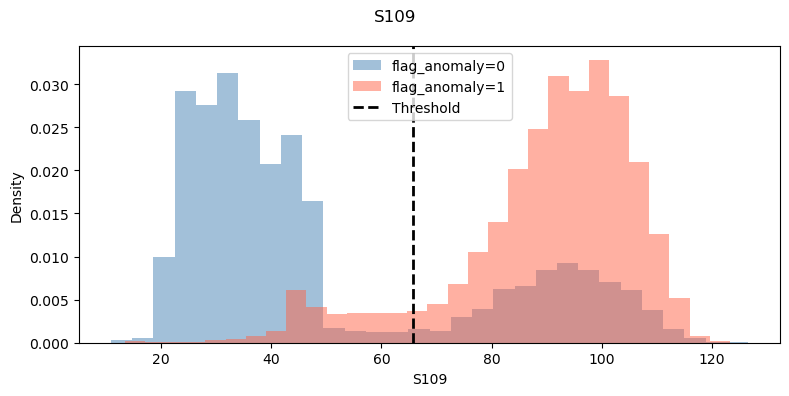

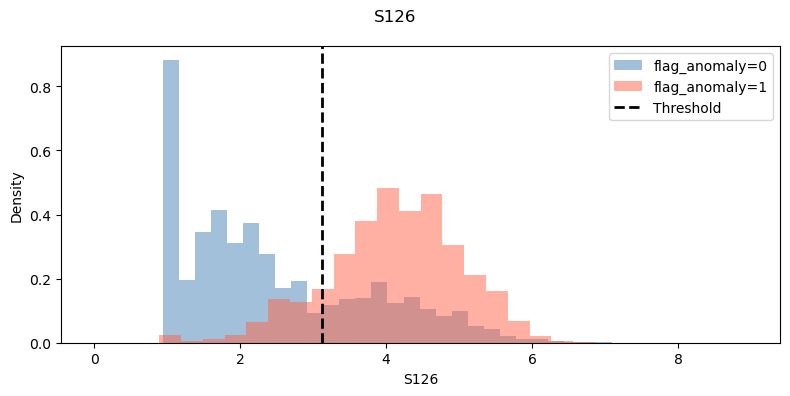

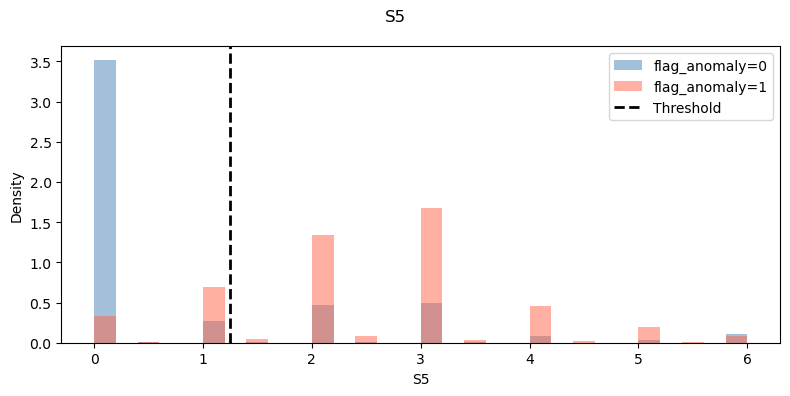

CPU times: user 491 ms, sys: 20 ms, total: 511 ms
Wall time: 1min 16s


In [118]:
%%time

thresholds = {}
for feature in ["S109","S126","S5"]:
    thr = get_best_threshold(df, feature, target="flag_anomaly")
    thresholds[feature] = thr

plot_histograms_with_threshold(df, "flag_anomaly", ["S109","S126","S5"], thresholds)

In [119]:
from pyspark.sql import functions as F
from functools import reduce

def add_tree_predictions(df, thresholds, features, pred_col="prediction_trees", score_col="rawPrediction"):
    # Regole booleane: feature > soglia (adatta l'operatore se serve)
    rules = [
        (F.col(f).cast("double") > F.lit(float(thresholds[f])))
        for f in features
    ]

    # OR logico tra tutte le regole (anomaly se almeno una è vera)
    cond_or = reduce(lambda a, b: a | b, [F.lit(False)] + rules)

    # Punteggio continuo: quante regole sono vere (0..len(features))
    score = reduce(lambda a, b: a + b, [F.lit(0)] + [F.when(r, 1).otherwise(0) for r in rules])

    return (
        df
        .withColumn(pred_col, F.when(cond_or, F.lit(1)).otherwise(F.lit(0)))
        .withColumn(score_col, score.cast("double"))  # per AUC in BinaryClassificationEvaluator
    )

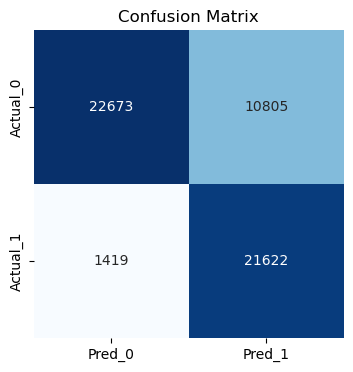

[Stage 17822:======================>                                (2 + 2) / 5]

{'accuracy': 0.7837187494470886, 'precision': 0.6667900206617942, 'auc': 0.8295408890650461}


In [120]:
features = ["S109","S126","S5"]

df_predictions = (
    add_tree_predictions(df, thresholds, features)   # crea prediction_trees e rawPrediction
    .withColumnRenamed("prediction_trees", "prediction")  # le tue funzioni si aspettano "prediction"
)

#--------QUESTE FUNZIONI SONO DEFINITE NELLA PARTE SOTTO DA RUNNARE PRIMA !!!!!!!!!!!!!!
cm_pandas = get_confusion_matrix(df_predictions, target="flag_anomaly")
plot_confusion_heatmap(cm_pandas, target="flag_anomaly")
metrics = calculate_metrics(df_predictions, cm_pandas, target="flag_anomaly")
print(metrics)

## SVM (su flag_alarm, se si usano le variabili predictive fa schifo)

In [58]:
df = df_final_088
#top_corr_alarm = ["S109","S9","S126"]
top_corr_alarm = ["S7","S53","SA3","S8","S172","S173","S39","S40","S3","P2"] # per "predictive_overheating"
df_data = df.select(*top_corr_alarm,"overheating","predictive_overheating","flag_anomaly","predictive_flag_anomaly")

In [39]:
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
#from pyspark.sql.types import DoubleType
from pyspark.ml.classification import LinearSVC
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
# import pandas as pd
# import numpy as np

In [61]:
def run_svm_analysis(df_data, top_corr_alarm, target, seed=516622, weight_class1=1):
    
    # Data preparation
    df_data = df_data.select(*top_corr_alarm, target)
    
    assembler = VectorAssembler(inputCols=top_corr_alarm, outputCol="VectorSensors")
    df_data = assembler.transform(df_data)
    
    df_data = df_data.where(
        (col(target) == 1) | 
        ((col(target) == 0) & (rand(seed=seed) <= 0.2)) #eliminate 80% of target=0 data
    )
    
    scaler = StandardScaler(inputCol="VectorSensors", outputCol="scaledFeatures")
    scaler_model = scaler.fit(df_data)
    df_data = scaler_model.transform(df_data)
    
    means = scaler_model.mean
    stds = scaler_model.std
    

    # Add weight column (heavier penalty for class 1 misclassification)
    df_data = df_data.withColumn("weight", when(col(target) == 1, weight_class1).otherwise(1.0))
    
    # Train/test split
    train, test = df_data.randomSplit([0.8, 0.2], seed=seed)

    # Train weighted SVM
    svc = LinearSVC(
        featuresCol="scaledFeatures",
        labelCol=target,
        predictionCol="prediction",
        rawPredictionCol="rawPrediction",
        weightCol="weight",
        regParam=0.01,
        maxIter=100,
        tol=1e-8
    )
    svc_model = svc.fit(train)
    
    # Predict on full dataset (not only test split)
    df_predictions = svc_model.transform(df_data)
    
    df_predictions.select(target, "prediction", "rawPrediction").show(10, truncate=False)
    
    intercept = svc_model.intercept
    coefficients = svc_model.coefficients.toArray()
    
    # 3D Plots
    #plot_3d_views(df_data, top_corr_alarm, intercept, coefficients, means, stds, target)
    
    # Decision function analysis
    df_with_decision = add_decision_function(df_data, intercept, coefficients, means, stds, top_corr_alarm)
    plot_decision_distribution(df_with_decision, target)
    
    # Metrics and confusion matrix
    cm_pandas = get_confusion_matrix(df_predictions, target)
    plot_confusion_heatmap(cm_pandas, target)
    metrics = calculate_metrics(df_predictions, cm_pandas, target)
    print(metrics)




def plot_3d_views(df_data, sensors, intercept, coefficients, means, stds, target):
    pdf = df_data.select(*sensors[:3], target).toPandas()
    fig = plt.figure(figsize=(18, 6))
    
    views = [{'elev': 30, 'azim': -60}, {'elev': 45, 'azim': 45}, {'elev': 60, 'azim': 135}]
    
    normal = pdf[pdf[target] == 0]
    anomaly = pdf[pdf[target] == 1]
    
    x_range = pdf[sensors[0]].min(), pdf[sensors[0]].max()
    y_range = pdf[sensors[1]].min(), pdf[sensors[1]].max()
    z_range = pdf[sensors[2]].min(), pdf[sensors[2]].max()
    
    for i, view in enumerate(views):
        ax = fig.add_subplot(1, 3, i+1, projection='3d')
        
        if len(normal) > 0:
            ax.scatter(normal[sensors[0]], normal[sensors[1]], normal[sensors[2]], 
                      c='blue', alpha=0.6, s=5, label='Normal')
        if len(anomaly) > 0:
            ax.scatter(anomaly[sensors[0]], anomaly[sensors[1]], anomaly[sensors[2]], 
                      c='red', alpha=0.8, s=5, label='Anomaly')
        
        xx, yy = np.meshgrid(np.linspace(x_range[0], x_range[1], 50),
                             np.linspace(y_range[0], y_range[1], 50))
        
        if abs(coefficients[2]) > 1e-10:
            # Prepare first-3 coeffs/means/stds as numpy arrays and guard against zero std
            means3 = np.array(means[:3], dtype=float)
            stds3 = np.array(stds[:3], dtype=float)
            coeffs3 = np.array(coefficients[:3], dtype=float)
            stds3_safe = np.where(stds3 == 0, 1e-8, stds3)
        
            a, b, c = coeffs3 / stds3_safe
            d = float(intercept) - float(np.dot(coeffs3, means3 / stds3_safe))
        
            # compute plane z in original feature space and mask outside z-range
            zz = -(a * xx + b * yy + d) / c
            mask = (zz >= z_range[0]) & (zz <= z_range[1])
            xx_masked = np.where(mask, xx, np.nan)
            yy_masked = np.where(mask, yy, np.nan)
            zz_masked = np.where(mask, zz, np.nan)
        
            ax.plot_surface(xx_masked, yy_masked, zz_masked, alpha=0.5, color='orange')
        
        
        ax.view_init(elev=view['elev'], azim=view['azim'])
        ax.set_xlabel(sensors[0])
        ax.set_ylabel(sensors[1])
        ax.set_zlabel(sensors[2])
        if i == 0:
            ax.legend()
    
    plt.tight_layout()
    plt.show()

def add_decision_function(df_data, intercept, coefficients, means, stds, sensors):
    coeffs = [float(c) for c in coefficients]
    means = [float(m) for m in means]
    stds = [float(s) if float(s) != 0 else 1e-8 for s in stds]

    expr = lit(float(intercept))
    for coeff, mean, std, sensor in zip(coeffs, means, stds, sensors):
        # cast sensor to double and safely compute (sensor - mean) / std
        expr = expr + (lit(coeff) * (col(sensor).cast("double") - lit(mean)) / lit(std))

    return df_data.withColumn("decision_function", expr)

def plot_decision_distribution(df_with_decision, target):
    pdf = df_with_decision.select("decision_function", target).toPandas()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.scatter(pdf['decision_function'], pdf[target], color="steelblue", alpha=0.1)
    ax1.axvline(x=0, color='red', linestyle='--', label='Decision boundary')
    ax1.set_xlabel('Decision Function')
    ax1.set_ylabel('Target')
    ax1.legend()
    
    for val, color in zip([0, 1], ["steelblue", "tomato"]):
        subset = pdf[pdf[target] == val]
        ax2.hist(subset['decision_function'], bins=50, alpha=0.6, color=color, 
                 label=f"target={val}", density=True)
    
    ax2.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Decision boundary')
    ax2.set_xlabel('Decision Function')
    ax2.set_ylabel('Density')
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

def get_confusion_matrix(df_predictions, target):
    cm_data = df_predictions.groupBy(target, "prediction").count().collect()
    cm_dict = {(row[target], row["prediction"]): row['count'] for row in cm_data}
    
    tn = cm_dict.get((0, 0), 0)
    fp = cm_dict.get((0, 1), 0)  
    fn = cm_dict.get((1, 0), 0)
    tp = cm_dict.get((1, 1), 0)
    
    return pd.DataFrame([[tn, fp], [fn, tp]], 
                       index=['Actual_0', 'Actual_1'],
                       columns=['Pred_0', 'Pred_1'])

def plot_confusion_heatmap(cm_pandas, target):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm_pandas, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.show()

def calculate_metrics(df_predictions, cm_pandas, target):
    tn, fp = cm_pandas.iloc[0]
    fn, tp = cm_pandas.iloc[1]
    
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target)
    auc = evaluator.evaluate(df_predictions)
    
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    
    return {'accuracy': accuracy, 'precision': precision, 'auc': auc}

+----------------------+----------+----------------------------------------+
|predictive_overheating|prediction|rawPrediction                           |
+----------------------+----------+----------------------------------------+
|1                     |1.0       |[-0.9997736587519896,0.9997736587519896]|
|1                     |1.0       |[-0.999872719725373,0.999872719725373]  |
|0                     |1.0       |[-0.9998234247154563,0.9998234247154563]|
|0                     |1.0       |[-0.9998216754594127,0.9998216754594127]|
|0                     |1.0       |[-0.9997724477285743,0.9997724477285743]|
|0                     |1.0       |[-0.9998230210409846,0.9998230210409846]|
|0                     |1.0       |[-0.9998225500874347,0.9998225500874347]|
|0                     |1.0       |[-0.9997733896356751,0.9997733896356751]|
|0                     |1.0       |[-0.9998225500874347,0.9998225500874347]|
|0                     |1.0       |[-0.9998232901572992,0.9998232901572992]|

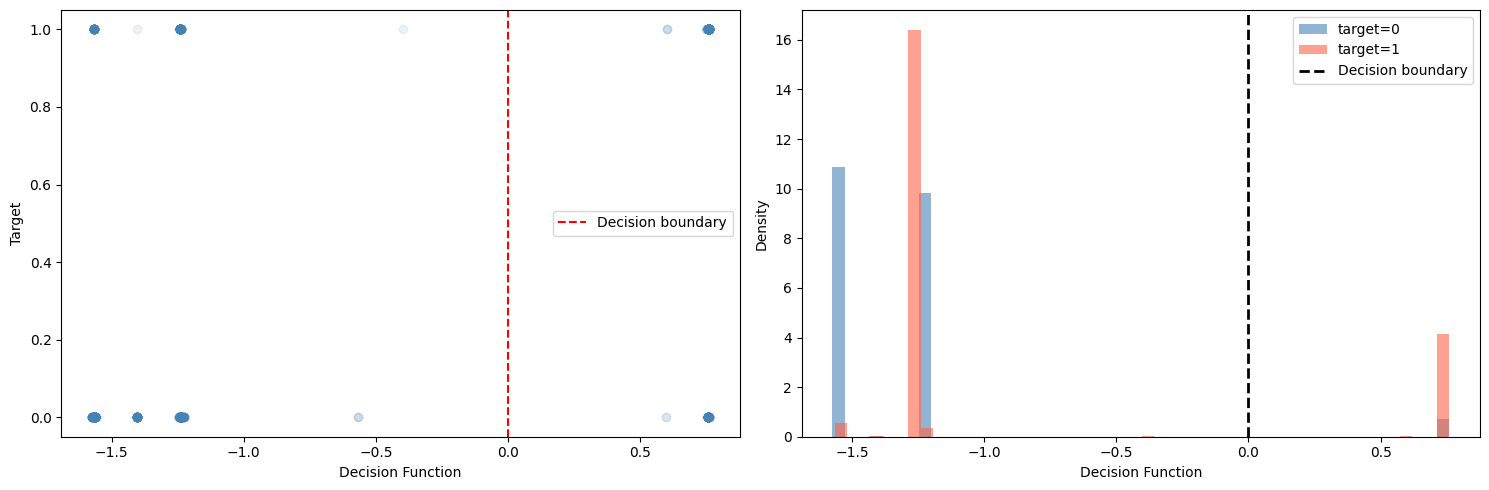

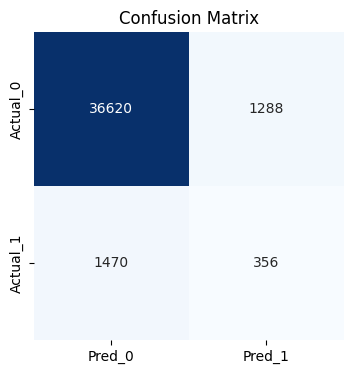

{'accuracy': 0.9305884129460915, 'precision': 0.21654501216545013, 'auc': 0.790733179343175}
CPU times: user 593 ms, sys: 490 ms, total: 1.08 s
Wall time: 7.12 s


In [62]:
%%time
target = "predictive_overheating"
run_svm_analysis(df_data, top_corr_alarm, target, weight_class1=5)

## modello logistico (devo ancora revisionarlo bene)

25/08/24 12:41:24 WARN BlockManagerMaster: Failed to remove broadcast 22430 with removeFromMaster = true - Block broadcast_22430 does not exist
org.apache.spark.SparkException: Block broadcast_22430 does not exist
	at org.apache.spark.errors.SparkCoreErrors$.blockDoesNotExistError(SparkCoreErrors.scala:318)
	at org.apache.spark.storage.BlockInfoManager.blockInfo(BlockInfoManager.scala:269)
	at org.apache.spark.storage.BlockInfoManager.removeBlock(BlockInfoManager.scala:547)
	at org.apache.spark.storage.BlockManager.removeBlockInternal(BlockManager.scala:2093)
	at org.apache.spark.storage.BlockManager.removeBlock(BlockManager.scala:2057)
	at org.apache.spark.storage.BlockManager.$anonfun$removeBroadcast$3(BlockManager.scala:2029)
	at org.apache.spark.storage.BlockManager.$anonfun$removeBroadcast$3$adapted(BlockManager.scala:2029)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at scala.collection.AbstractIterator.fore

=== MODEL COEFFICIENTS ===
Intercept: -7.0630
S7: 2.4019 - increases P(predictive_overheating=1)
S53: 0.2344 - increases P(predictive_overheating=1)
SA3: 5.8514 - increases P(predictive_overheating=1)
S8: -4.4099 - decreases P(predictive_overheating=1)
S172: 2.2400 - increases P(predictive_overheating=1)
S173: 1.4011 - increases P(predictive_overheating=1)
S39: 0.0564 - increases P(predictive_overheating=1)
S40: -0.0275 - decreases P(predictive_overheating=1)
S3: -0.0186 - decreases P(predictive_overheating=1)
P2: 0.3770 - increases P(predictive_overheating=1)

=== SAMPLE PREDICTIONS ===


+----------------------+----------+-------------------+
|predictive_overheating|prediction|prob_anomaly       |
+----------------------+----------+-------------------+
|1                     |0.0       |0.33480817471850377|
|1                     |0.0       |0.3366790122876626 |
|0                     |0.0       |0.3379995590401569 |
|0                     |0.0       |0.33224192717569045|
|0                     |0.0       |0.33349381528646316|
|0                     |0.0       |0.33349381528646316|
|0                     |0.0       |0.3354512734300067 |
|0                     |0.0       |0.33735405499299975|
|0                     |0.0       |0.336064865989281  |
|0                     |0.0       |0.335421184684224  |
+----------------------+----------+-------------------+
only showing top 10 rows



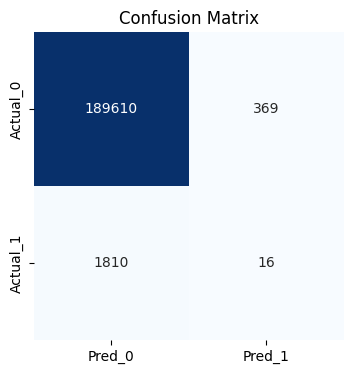


=== MODEL PERFORMANCE ===
{'accuracy': 0.9886395036625739, 'precision': 0.04155844155844156, 'auc': 0.8096538507712044}
CPU times: user 241 ms, sys: 148 ms, total: 389 ms
Wall time: 12.4 s


In [53]:
%%time

from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.sql.functions import col, udf, when
from pyspark.sql.types import DoubleType

features = top_corr_alarm
target = "predictive_overheating"

assembler = VectorAssembler(inputCols=features, outputCol="features")
df_features = assembler.transform(df)

# weight column: emphasize class 1 to reduce false negatives
df_features = df_features.withColumn("weight", when(col(target) == 1, 10.0).otherwise(1.0))

train_data, test_data = df_features.randomSplit([0.8, 0.2], seed=42)

lr = LogisticRegression(featuresCol="features", labelCol=target, weightCol="weight")
lr_model = lr.fit(train_data)

print("=== MODEL COEFFICIENTS ===")
print(f"Intercept: {lr_model.intercept:.4f}")
for feature, coeff in zip(features, lr_model.coefficients):
    direction = "increases" if coeff > 0 else "decreases"
    print(f"{feature}: {coeff:.4f} - {direction} P({target}=1)")

predictions = lr_model.transform(df_features)

get_prob_1 = udf(lambda prob: float(prob[1]), DoubleType())
predictions = predictions.withColumn("prob_anomaly", get_prob_1(col("probability")))

print("\n=== SAMPLE PREDICTIONS ===")
predictions.select(target, "prediction", "prob_anomaly").show(10, truncate=False)

cm_pandas = get_confusion_matrix(predictions, target)
plot_confusion_heatmap(cm_pandas, target)

metrics = calculate_metrics(predictions, cm_pandas, target)
print("\n=== MODEL PERFORMANCE ===")
print(metrics)

# <hr style="height:4px; background-color:black; border:none;" />

# Rioridino modelli preditti

In [95]:
from math import floor
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LinearSVC, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# ---------- Shared preprocessing ----------
def preprocess_features(df, feature_cols, scaler=True):
    df = df.where( (col(target) == 1) | ((col(target) == 0) & (rand(seed=123) <= 0.2)) )
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
    df_feat = assembler.transform(df).select(*feature_cols, *[c for c in df.columns if c not in feature_cols], "features")
    if not scaler:
        return df_feat, None
    scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withMean=True, withStd=True)
    scaler_model = scaler.fit(df_feat)
    df_scaled = scaler_model.transform(df_feat)
    return df_scaled, scaler_model

# ---------- Replicate positives for RF ----------
def replicate_positive(df, label_col, n_rep):
    n_rep = int(n_rep)
    if n_rep <= 1:
        return df
    df_w = df.withColumn("_rep", when(col(label_col) == 1, lit(n_rep)).otherwise(lit(1)))
    df_rep = df_w.withColumn("_dup", explode(array_repeat(lit(1), col("_rep")))).drop("_rep", "_dup")
    return df_rep

# ---------- Add weight column for linear models ----------
def add_class_weights(df, label_col, weight_class1):
    return df.withColumn("weight", when(col(label_col) == 1, lit(float(weight_class1))).otherwise(lit(1.0)))

# ---------- SVM runner ----------
def svm(f_data, top_corr_alarm, target, weight_class1=1.0, seed=516622):
    df = f_data.select(*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = add_class_weights(df_prep, target, weight_class1)
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    svc = LinearSVC(featuresCol="scaledFeatures", labelCol=target, weightCol="weight",
                    rawPredictionCol="rawPrediction", predictionCol="prediction",
                    regParam=0.01, maxIter=1000, tol=1e-8)
    model = svc.fit(train)
    preds = model.transform(df_prep)                          # predict on full (original) df_data
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "scaler": scaler_model}

# ---------- Logistic runner ----------
def logistic(f_data, top_corr_alarm, target, weight_class1=1.0, seed=516622):
    df = f_data.select(*top_corr_alarm, target)
    df_prep, scaler_model = preprocess_features(df, top_corr_alarm, scaler=True)
    df_prep = add_class_weights(df_prep, target, weight_class1)
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    lr = LogisticRegression(featuresCol="scaledFeatures", labelCol=target, weightCol="weight",
                            rawPredictionCol="rawPrediction", predictionCol="prediction")
    model = lr.fit(train)
    preds = model.transform(df_prep)
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "scaler": scaler_model}

# ---------- Random Forest runner (replicate class-1) ----------
def random_forest(f_data, top_corr_alarm, target, weight_class1=1.0, n_trees=100, max_depth=10, seed=42):
    df = f_data.select(*top_corr_alarm, target)
    rep_n = max(1, int(floor(weight_class1)))   # number of copies per positive
    df_rep = replicate_positive(df, target, rep_n)
    df_prep, _ = preprocess_features(df_rep, top_corr_alarm, scaler=False)  # RF uses raw features
    train, _ = df_prep.randomSplit([0.8, 0.2], seed=seed)
    rf = RandomForestClassifier(featuresCol="features", labelCol=target, rawPredictionCol="rawPrediction", predictionCol="prediction",
                                numTrees=n_trees, maxDepth=max_depth, seed=seed)
    model = rf.fit(train)
    # feature importances
    rf_model = model
    importances = rf_model.featureImportances.toArray()
    feature_importance = sorted(zip(top_corr_alarm, importances), key=lambda x: -x[1])
    # predict on original full (non-replicated) data preprocessed the same way
    df_orig_prep, _ = preprocess_features(df, top_corr_alarm, scaler=False)
    preds = model.transform(df_orig_prep)
    cm = get_confusion_matrix(preds, target)
    plot_confusion_heatmap(cm, target)
    metrics = calculate_metrics(preds, cm, target)
    return {"model": model, "predictions": preds, "cm": cm, "metrics": metrics, "feature_importance": feature_importance}

# --------------------
def get_confusion_matrix(df_predictions, target):
    cm_data = df_predictions.groupBy(target, "prediction").count().collect()
    cm_dict = {(row[target], row["prediction"]): row['count'] for row in cm_data}   
    tn = cm_dict.get((0, 0), 0)
    fp = cm_dict.get((0, 1), 0)  
    fn = cm_dict.get((1, 0), 0)
    tp = cm_dict.get((1, 1), 0)
    return pd.DataFrame([[tn, fp], [fn, tp]], 
                       index=['Actual_0', 'Actual_1'],
                       columns=['Pred_0', 'Pred_1'])

# --------------------
def plot_confusion_heatmap(cm_pandas, target):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm_pandas, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix')
    plt.show()

# --------------------
def calculate_metrics(df_predictions, cm_pandas, target):
    tn, fp = cm_pandas.iloc[0]
    fn, tp = cm_pandas.iloc[1]
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target)
    auc = evaluator.evaluate(df_predictions)
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    return {'accuracy': accuracy, 'precision': precision, 'auc': auc}

In [96]:
df = df_final_088
#top_corr_alarm = ["S109","S9","S126"]
top_corr_alarm = ["S7","S53","SA3","S8","S172","S173","S39","S40","S3","P2"] # per "predictive_overheating"
target = "predictive_overheating"
df_data = df.select(*top_corr_alarm,"overheating","predictive_overheating","flag_anomaly","predictive_flag_anomaly")

In [97]:
# --------- SVM ---------
svm(df_data, top_corr_alarm, target, weight_class1=0)

25/08/24 14:08:20 ERROR Instrumentation: java.lang.IllegalArgumentException: requirement failed: LinearSVC only supports binary classification. 1 classes detected in LinearSVC_6f7fe4c55d93__labelCol
	at scala.Predef$.require(Predef.scala:281)
	at org.apache.spark.ml.classification.LinearSVC.$anonfun$train$1(LinearSVC.scala:217)
	at org.apache.spark.ml.util.Instrumentation$.$anonfun$instrumented$1(Instrumentation.scala:191)
	at scala.util.Try$.apply(Try.scala:213)
	at org.apache.spark.ml.util.Instrumentation$.instrumented(Instrumentation.scala:191)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:172)
	at org.apache.spark.ml.classification.LinearSVC.train(LinearSVC.scala:77)
	at org.apache.spark.ml.Predictor.fit(Predictor.scala:114)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at java.base/jdk.internal.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:77)
	at java.base/jdk.internal.reflect.DelegatingMethodA

IllegalArgumentException: requirement failed: LinearSVC only supports binary classification. 1 classes detected in LinearSVC_6f7fe4c55d93__labelCol

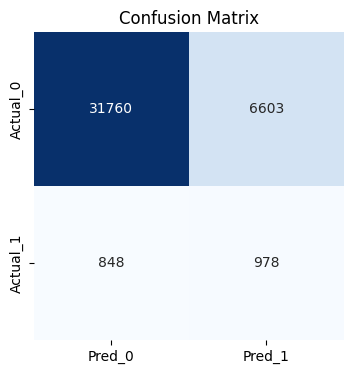

{'model': LogisticRegressionModel: uid=LogisticRegression_46c0d38a8bdd, numClasses=2, numFeatures=10,
 'predictions': DataFrame[S7: int, S53: int, SA3: int, S8: int, S172: int, S173: int, S39: double, S40: double, S3: double, P2: int, predictive_overheating: int, features: vector, scaledFeatures: vector, weight: double, rawPrediction: vector, probability: vector, prediction: double],
 'cm':           Pred_0  Pred_1
 Actual_0   31760    6603
 Actual_1     848     978,
 'metrics': {'accuracy': 0.814601010226679,
  'precision': 0.1290067273446775,
  'auc': 0.8146936729008153},
 'scaler': StandardScalerModel: uid=StandardScaler_4edbd948ee0b, numFeatures=10, withMean=true, withStd=true}

In [83]:
# --------- Logistic Regression ---------
logistic(df_data, top_corr_alarm, target, weight_class1=10)

25/08/24 13:38:38 WARN DAGScheduler: Broadcasting large task binary with size 1022.4 KiB
25/08/24 13:38:39 WARN DAGScheduler: Broadcasting large task binary with size 1354.4 KiB
25/08/24 13:38:39 WARN DAGScheduler: Broadcasting large task binary with size 1683.8 KiB
25/08/24 13:38:40 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
25/08/24 13:38:40 WARN DAGScheduler: Broadcasting large task binary with size 1191.4 KiB
25/08/24 13:38:41 WARN DAGScheduler: Broadcasting large task binary with size 1173.0 KiB


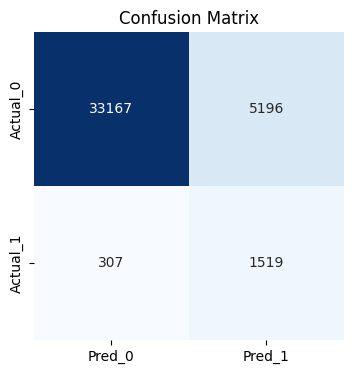

25/08/24 13:38:41 WARN DAGScheduler: Broadcasting large task binary with size 1182.1 KiB


{'model': RandomForestClassificationModel: uid=RandomForestClassifier_cbf92c8ec75f, numTrees=120, numClasses=2, numFeatures=10,
 'predictions': DataFrame[S7: int, S53: int, SA3: int, S8: int, S172: int, S173: int, S39: double, S40: double, S3: double, P2: int, predictive_overheating: int, features: vector, rawPrediction: vector, probability: vector, prediction: double],
 'cm':           Pred_0  Pred_1
 Actual_0   33167    5196
 Actual_1     307    1519,
 'metrics': {'accuracy': 0.8630719848714823,
  'precision': 0.22620997766195086,
  'auc': 0.9334849498873946},
 'feature_importance': [('S7', 0.1980581810827932),
  ('S53', 0.1645689149398235),
  ('S3', 0.1403637120464886),
  ('S39', 0.13887158849602402),
  ('S40', 0.11620655042609294),
  ('S172', 0.09456567573148861),
  ('P2', 0.048681128606392114),
  ('SA3', 0.03970604699045012),
  ('S173', 0.03262328979914645),
  ('S8', 0.026354911881300482)]}

In [82]:
# --------- Random Forest ---------
random_forest(df_data, top_corr_alarm, target, weight_class1=10, n_trees=120, max_depth=10)

# Altro riassunto conciso con PipeLine anche

In [85]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.classification import LinearSVC, LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# --- Oversample positives for RF ---
def replicate_positive(df, label_col, n_rep):
    if n_rep <= 1:
        return df
    df_w = df.withColumn("_rep", when(col(label_col)==1, lit(n_rep)).otherwise(lit(1)))
    return df_w.withColumn("_dup", explode(array_repeat(lit(1), col("_rep")))).drop("_rep","_dup")

# --- Add weights for linear models ---
def add_class_weights(df, label_col, weight_class1):
    return df.withColumn("weight", when(col(label_col)==1, lit(float(weight_class1))).otherwise(lit(1.0)))

# --- Confusion matrix ---
def get_confusion_matrix(df_predictions, target):
    cm = {(r[target], r["prediction"]): r['count'] for r in df_predictions.groupBy(target,"prediction").count().collect()}
    tn = cm.get((0,0),0)
    fp = cm.get((0,1),0)
    fn = cm.get((1,0),0)
    tp = cm.get((1,1),0)
    return pd.DataFrame([[tn, fp],[fn, tp]], index=['Actual_0','Actual_1'], columns=['Pred_0','Pred_1'])

# --- Plot confusion matrix ---
def plot_confusion_heatmap(cm):
    plt.figure(figsize=(4,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.show()

# --- Metrics ---
def calculate_metrics(df_predictions, cm, target):
    tn, fp, fn, tp = cm.iloc[0,0], cm.iloc[0,1], cm.iloc[1,0], cm.iloc[1,1]
    auc = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction", labelCol=target).evaluate(df_predictions)
    acc = (tp+tn)/(tp+tn+fp+fn)
    prec = tp/(tp+fp) if (tp+fp)>0 else 0
    return {'accuracy': acc, 'precision': prec, 'auc': auc}

# --- Main runner ---
def run_model(df, feature_cols, label_col, algo="rf", weight_class1=1.0, test_fraction=0.3, seed=42, **kwargs):
    if algo=="rf":
        df = replicate_positive(df, label_col, max(1,int(floor(weight_class1))))
    else:
        df = add_class_weights(df, label_col, weight_class1)

    train_df, test_df = df.randomSplit([1-test_fraction,test_fraction], seed=seed)
    assembler = VectorAssembler(inputCols=feature_cols, outputCol="features"); stages=[assembler]
    if algo in ["lr","svc"]:
        stages.append(StandardScaler(inputCol="features",outputCol="scaledFeatures",withMean=True,withStd=True))
        feat="scaledFeatures"
    else:
        feat="features"
    if algo=="rf":
        est=RandomForestClassifier(featuresCol=feat,labelCol=label_col,numTrees=kwargs.get("numTrees",100),maxDepth=kwargs.get("maxDepth",10),seed=seed)
    elif algo=="lr":
        est=LogisticRegression(featuresCol=feat,labelCol=label_col,weightCol="weight",maxIter=kwargs.get("maxIter",100))
    elif algo=="svc":
        est=LinearSVC(featuresCol=feat,labelCol=label_col,weightCol="weight",maxIter=kwargs.get("maxIter",100),regParam=kwargs.get("regParam",0.01))
    else:
        raise ValueError("algo must be 'rf','lr','svc'")
        
    stages.append(est); model=Pipeline(stages=stages).fit(train_df)
    preds=model.transform(test_df); cm=get_confusion_matrix(preds,label_col)
    metrics=calculate_metrics(preds,cm,label_col)
    plot_confusion_heatmap(cm)
    return {"model":model,"preds":preds,"cm":cm,"metrics":metrics}

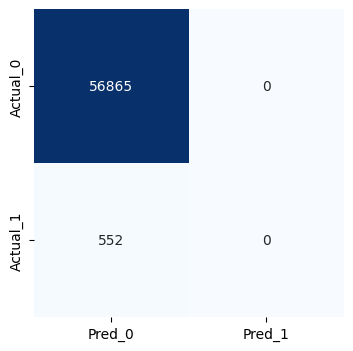

{'accuracy': 0.9903861225769371, 'precision': 0, 'auc': 0.7875117077441232}


In [88]:
# --------- SVM ---------
res = run_model(df_data, feature_cols=top_corr_alarm, label_col=target, algo="svc", weight_class1=10)
print(res["metrics"])

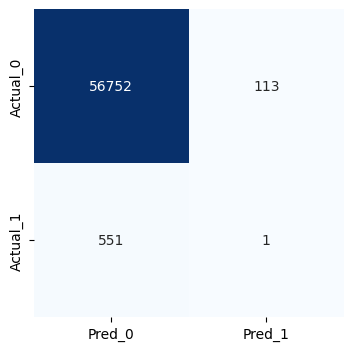

{'accuracy': 0.9884354807809533, 'precision': 0.008771929824561403, 'auc': 0.8129352413611184}


In [89]:
# --------- Logistic Regression ---------
res = run_model(df_data, feature_cols=top_corr_alarm, label_col=target, algo="lr", weight_class1=10)
print(res["metrics"])

In [91]:
# # ---------RandomForest ---------
# res = run_model(df_data, feature_cols=top_corr_alarm, label_col=target, algo="rf", weight_class1=10)
# print(res["metrics"])